## Smith-Hutton Problem

We want to solve the following PDE:

\begin{equation}
    u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = \Gamma (\phi_{xx} + \phi_{yy}) 
\end{equation}

The independen variables, $x$ and $y$, and the diffusive constant, $\Gamma$, are used as input values for the NN, and the solution (i.e. $\phi(x,y)$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs to obtain the first order derivatives. The same is done for the gradients to obtain the second order derivatives. Then, a loss function that matches the PDE is built and the weights are updated accordingly. A loss function that matches the PDE is then used for optimization. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $\Gamma$, so we can then obtain a solution for different diffusivities without requiring new computations. The geometry of the problem is as follows:

![sh](pics/sh.png)

In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#imports
import math
import numpy as np 
import matplotlib.pyplot as plt 
import torch

First we define our PDE and set the values for training.

In [3]:
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco, NeumannBoco
from nangs.solutions import MLP

class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, order=2):
        super().__init__(inputs, outputs, order=order)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpdx, dpdy = grads['p']['x'], grads['p']['y']
        d2pdx2, d2pdy2 = grads['2p']['xx'], grads['2p']['yy']
        x, y = inputs['x'], inputs['y']
        u, v = 2*y*(1-x**2), -2*x*(1-y**2)
        print("d2pdx2=", d2pdx2)
        print("d2pdy2=", d2pdy2)
        print("dpdx=", dpdx)
        print("dpdy=", dpdy)
        return [u*dpdx + v*dpdy - inputs['g']*(d2pdx2 + d2pdy2)]

# instanciate pde
pde = MyPDE(inputs=['x', 'y', 'g'], outputs=['p'])

# define input values
x = np.linspace(-1,1,60)
y = np.linspace(0,1,30)
g = np.array([0.1, 0.001, 0.000001])

pde.setValues({'x': x, 'y': y, 'g': g})
pde.setValues({'x': x, 'y': y, 'g': g}, train=False)

Boundary conditions.

In [4]:
# alpha parameter
a = 10

# left and rigth b.c 
x1, x2 = np.array([-1, 1]), np.array([1])
p = np.zeros(2*len(y)*len(g))

boco = DirichletBoco('left_right', {'x': x1, 'y': y, 'g': g}, {'p': p})
pde.addBoco(boco)

# top b.c 
y2 = np.array([1])
p = np.zeros(len(x)*len(g))
for i in range(len(x)): 
    for _g in g:
        p[i] = 1. - math.tanh(a)
boco = DirichletBoco('top', {'x': x, 'y': y2, 'g': g}, {'p': p})
pde.addBoco(boco)

# bottom b.c
y1 = np.array([0])
x1, x2, p1 = [], [], []
for i in range(len(x)): 
    if x[i] < 0:
        x1.append(x[i])
    else:
        x2.append(x[i])
for _g in g:
    for i in range(len(x)): 
        if x[i] < 0:
            p1.append(1.+math.tanh(a*(2*x[i]+1)))
x1, x2, p1 = np.array(x1), np.array(x2), np.array(p1) 

# bottom left b.c
boco = DirichletBoco('bottom_left', {'x': x1, 'y': y1, 'g': g}, {'p': p1})
pde.addBoco(boco)

# bottom right b.c
boco = NeumannBoco('bottom_right', {'x': x2, 'y': y1, 'g': g}, grads={'p': 'y'})
pde.addBoco(boco)

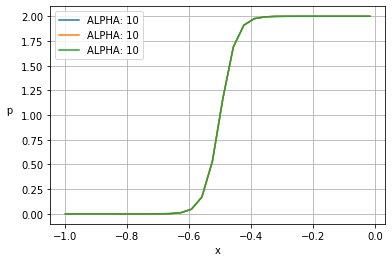

In [5]:
# visualize inlet conditions (same ALPHA for every Gamma)
n, m = len(g), len(x1)
for i in range(n):
    plt.plot(x1,p1[i*m:(i+1)*m], label="ALPHA: {}".format(a))
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("p    ", rotation=np.pi/2)
plt.show()

Now we define a topology for our solution and set the training parameters. Then we can find a solution for our PDE.

In [6]:
# define solution topology
mlp = MLP(pde.n_inputs, pde.n_outputs, 5, 2048, activations="sigmoid")


In [7]:
# find the solution
optimizer = torch.optim.Adam(mlp.parameters(), lr=3e-4)
pde.compile(mlp, optimizer)

hist = pde.solve(epochs=100) 

d2pdx2= tensor([ 1.5358e-07,  3.2993e-08,  3.4460e-07,  3.2286e-07, -3.6305e-08,
         3.4177e-07,  4.6701e-07,  4.5260e-07,  3.4171e-07,  5.1386e-07,
         2.7717e-07,  5.2943e-07,  5.4937e-07,  3.3501e-07,  3.7789e-07,
         5.3354e-07,  3.8038e-07,  4.4644e-07,  5.6044e-07,  1.9310e-07,
         5.6798e-07,  5.2756e-07,  2.0519e-07,  4.8718e-07,  1.6775e-07,
         1.4840e-07,  4.2832e-07,  3.2191e-07,  1.9117e-07, -3.6297e-08,
         3.9136e-07,  4.7240e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-6.6225e-09, -3.5495e-08,  1.6240e-07,  2.7748e-07, -1.4702e-07,
         2.7422e-07,  3.2135e-07,  2.4912e-07,  1.9437e-07,  3.7998e-07,
         8.0473e-08,  4.0426e-07,  3.6938e-07,  1.6830e-07,  1.8517e-07,
         3.6487e-07,  3.1864e-07,  3.2293e-07,  4.4999e-07,  1.1626e-07,
         4.1865e-07,  4.4528e-07,  5.9312e-08,  3.5481e-07,  5.1391e-08,
        -3.6290e-09,  2.5388e-07,  3.0044e-07,  1.2842e-07, -1.2834e-07,
         3.0875e-07,  3.2851e-

/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


d2pdx2= tensor([-6.2222e-07, -6.0195e-07, -4.7169e-07, -6.2410e-07, -5.6812e-07,
        -6.3297e-07, -6.4409e-07, -6.3512e-07, -5.8976e-07, -5.8346e-07,
        -6.2525e-07, -4.6669e-07, -6.5000e-07, -2.7258e-07, -5.4552e-07,
        -6.1198e-07, -5.5102e-07, -5.7245e-07, -5.0299e-07, -6.3974e-07,
        -2.6198e-07, -6.5981e-07, -5.5738e-07, -5.9855e-07, -5.6034e-07,
        -5.7333e-07, -5.1531e-07, -4.3537e-07, -6.5072e-07, -6.8048e-07,
        -3.3609e-07, -6.7565e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-3.1905e-07, -4.5422e-07, -4.3270e-07, -4.0954e-07, -3.6967e-07,
        -3.4054e-07, -3.9433e-07, -4.2997e-07, -4.0931e-07, -3.9825e-07,
        -4.9855e-07, -3.1824e-07, -2.8251e-07, -3.9274e-07, -3.9230e-07,
        -5.6612e-07, -4.1515e-07, -5.2471e-07, -3.1590e-07, -4.1091e-07,
        -3.6125e-07, -3.6282e-07, -3.3790e-07, -5.5221e-07, -5.9283e-07,
        -4.9641e-07, -4.5258e-07, -3.1634e-07, -4.7002e-07, -3.3377e-07,
        -4.5649e-07, -3.8335e-

dpdy= tensor([-7.8091e-06, -7.1710e-06, -7.3679e-06, -7.2517e-06, -7.3676e-06,
        -7.3540e-06, -7.0868e-06, -7.3640e-06, -7.4085e-06, -7.2931e-06,
        -7.4804e-06, -7.6533e-06, -7.7068e-06, -7.0342e-06, -7.6604e-06,
        -7.6599e-06, -7.2673e-06, -7.5411e-06, -7.6169e-06, -7.4527e-06,
        -7.4726e-06, -7.4772e-06, -7.3063e-06, -7.2380e-06, -7.4278e-06,
        -7.4227e-06, -7.3340e-06, -7.7701e-06, -7.0787e-06, -7.4087e-06,
        -7.6650e-06, -7.6139e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([3.3677e-07, 4.4980e-07, 3.0304e-07, 5.3189e-07, 3.6318e-07, 2.1871e-07,
        2.5306e-07, 2.2724e-07, 4.4133e-07, 1.6045e-07, 2.3704e-07, 2.2430e-07,
        2.4442e-07, 1.6999e-07, 3.7170e-07, 2.5846e-07, 4.0588e-07, 1.7468e-07,
        3.7911e-07, 4.0512e-07, 2.8408e-07, 1.9423e-07, 2.6823e-07, 2.2419e-07,
        1.0309e-07, 1.7758e-07, 3.8763e-07, 4.6764e-07, 5.2092e-08, 3.9901e-07,
        5.3030e-07, 2.4259e-07], device='cuda:0', grad_fn=<SelectBackw

d2pdx2= tensor([ 4.0104e-07,  3.2882e-07,  2.1675e-07,  1.2991e-07,  1.0131e-09,
         1.1136e-07,  3.4273e-07,  2.9040e-07,  6.9908e-08,  5.0622e-08,
         2.0153e-07,  3.3709e-07,  2.4341e-07,  3.1446e-07,  2.6585e-07,
         2.1210e-07,  1.4048e-07,  2.8243e-07,  5.1745e-08,  3.9750e-07,
         4.2282e-07,  2.8972e-07,  2.6244e-07, -1.8790e-09,  4.1594e-07,
         2.9582e-07,  3.2670e-07,  2.1975e-07,  1.7716e-07,  4.4724e-07,
         1.2229e-07,  3.5432e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([4.6642e-07, 4.5115e-07, 3.3290e-07, 3.9825e-07, 1.9300e-07, 3.2906e-07,
        1.6422e-07, 2.3087e-07, 2.1124e-07, 1.6229e-07, 3.1908e-07, 4.3431e-07,
        3.9068e-07, 2.5986e-07, 4.4248e-07, 1.8165e-07, 1.6411e-07, 2.4134e-07,
        1.7398e-07, 3.7933e-07, 3.7666e-07, 4.6644e-07, 2.8110e-07, 1.5137e-07,
        3.0839e-07, 3.2311e-07, 3.8936e-07, 2.6501e-07, 3.6962e-07, 4.0581e-07,
        1.9949e-07, 2.1080e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([6.5573e-07, 1.1033e-06, 1.1247e-06, 7.0995e-07, 1.0935e-06, 8.5062e-07,
        9.0992e-07, 5.9215e-07, 8.5108e-07, 6.4341e-07, 1.0584e-06, 7.8119e-07,
        1.0406e-06, 1.1346e-06, 9.4095e-07, 8.5051e-07, 8.4296e-07, 1.1241e-06,
        8.9869e-07, 8.6376e-07, 7.4953e-07, 7.3763e-07, 1.0664e-06, 1.0043e-06,
        8.3729e-07, 9.5940e-07, 9.3193e-07, 6.8610e-07, 8.8261e-07, 8.3132e-07,
        9.5093e-07, 8.8832e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([9.0246e-07, 1.1040e-06, 1.1425e-06, 9.5672e-07, 1.0930e-06, 8.9848e-07,
        9.3243e-07, 8.7514e-07, 8.9038e-07, 8.8991e-07, 1.0986e-06, 9.7220e-07,
        1.0830e-06, 1.1262e-06, 9.7801e-07, 8.8575e-07, 1.0037e-06, 1.1215e-06,
        9.0663e-07, 8.6397e-07, 9.5611e-07, 9.3858e-07, 1.0705e-06, 1.0809e-06,
        8.8709e-07, 9.6625e-07, 1.0534e-06, 9.1176e-07, 9.9266e-07, 8.3270e-07,
        1.0752e-06, 8.9695e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 5.4136e-07, -5.41

d2pdx2= tensor([4.0306e-07, 4.2051e-07, 3.4512e-07, 4.5562e-07, 3.4435e-07, 3.6666e-07,
        3.3508e-07, 3.4592e-07, 3.4702e-07, 3.8162e-07, 4.6735e-07, 3.5991e-07,
        3.8240e-07, 4.7680e-07, 3.8100e-07, 3.7336e-07, 2.9384e-07, 3.5164e-07,
        3.3722e-07, 3.3352e-07, 4.7590e-07, 3.9394e-07, 3.5405e-07, 3.4875e-07,
        3.5970e-07, 3.3470e-07, 4.1923e-07, 3.1368e-07, 3.6565e-07, 3.7680e-07,
        4.8070e-07, 2.7276e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([4.5142e-07, 4.4796e-07, 4.0473e-07, 4.9101e-07, 4.1407e-07, 4.2513e-07,
        3.9674e-07, 4.2177e-07, 4.2004e-07, 4.3481e-07, 5.0295e-07, 4.2157e-07,
        4.4023e-07, 5.0886e-07, 4.4358e-07, 4.2584e-07, 3.8410e-07, 4.1629e-07,
        4.1299e-07, 4.1371e-07, 5.0935e-07, 4.5209e-07, 4.1678e-07, 4.1422e-07,
        4.1316e-07, 4.0294e-07, 4.6886e-07, 3.7225e-07, 4.2755e-07, 4.4127e-07,
        5.1019e-07, 3.7046e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.1632e-07,  7.58

d2pdx2= tensor([2.0345e-07, 1.8075e-07, 1.7650e-07, 2.2094e-07, 1.5954e-07, 1.4870e-07,
        1.7624e-07, 1.6536e-07, 1.3416e-07, 1.4186e-07, 2.1279e-07, 1.6854e-07,
        1.6039e-07, 2.0028e-07, 1.6795e-07, 1.9583e-07, 1.7725e-07, 2.2723e-07,
        1.7199e-07, 1.6310e-07, 2.0166e-07, 1.9054e-07, 1.8858e-07, 1.8721e-07,
        1.9344e-07, 1.2677e-07, 1.4051e-07, 1.6136e-07, 1.6410e-07, 2.0448e-07,
        1.7843e-07, 1.6885e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.3926e-07, 2.2339e-07, 2.2023e-07, 2.6063e-07, 1.9921e-07, 2.0618e-07,
        2.4491e-07, 2.0479e-07, 1.9712e-07, 1.8177e-07, 2.5566e-07, 2.1679e-07,
        2.0611e-07, 2.3439e-07, 2.3565e-07, 2.3618e-07, 2.2567e-07, 2.5856e-07,
        2.3201e-07, 2.0786e-07, 2.4454e-07, 2.4524e-07, 2.5294e-07, 2.2775e-07,
        2.4017e-07, 1.9118e-07, 1.8118e-07, 2.0162e-07, 2.1238e-07, 2.4477e-07,
        2.2188e-07, 2.0980e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.1884e-07, -2.73

d2pdx2= tensor([1.2833e-07, 1.2792e-07, 1.3959e-07, 1.7217e-07, 1.3718e-07, 1.1271e-07,
        1.5384e-07, 1.1404e-07, 1.3609e-07, 1.3606e-07, 1.3546e-07, 1.6399e-07,
        1.3429e-07, 1.5604e-07, 1.1643e-07, 7.5969e-08, 1.1771e-07, 1.8603e-07,
        1.4310e-07, 1.5323e-07, 1.5389e-07, 1.9141e-07, 9.8143e-08, 1.7629e-07,
        6.7947e-08, 6.9121e-08, 1.3487e-07, 1.1072e-07, 1.2250e-07, 1.3725e-07,
        1.5378e-07, 8.0478e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.1475e-07, 1.7085e-07, 1.7988e-07, 2.2665e-07, 1.7660e-07, 1.5608e-07,
        2.0439e-07, 2.0225e-07, 2.0210e-07, 1.7486e-07, 2.0649e-07, 2.3985e-07,
        1.8495e-07, 2.0194e-07, 1.5467e-07, 1.4639e-07, 1.8381e-07, 2.4731e-07,
        1.8466e-07, 2.0728e-07, 1.9838e-07, 2.4265e-07, 1.4921e-07, 2.2205e-07,
        1.3951e-07, 1.2854e-07, 1.7358e-07, 1.8857e-07, 1.8931e-07, 2.1635e-07,
        2.1778e-07, 1.4858e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-6.4890e-07, -5.08

d2pdx2= tensor([3.6183e-08, 6.9183e-08, 1.2355e-07, 1.7290e-07, 1.8581e-07, 1.7368e-07,
        1.2457e-07, 1.6817e-07, 1.1723e-07, 2.9967e-08, 1.2943e-07, 7.9786e-08,
        9.7099e-08, 1.1500e-07, 1.7334e-07, 1.5796e-07, 7.2717e-08, 5.5132e-08,
        1.0349e-07, 1.0087e-07, 1.3801e-07, 1.2029e-07, 9.7759e-08, 9.6075e-08,
        5.4993e-08, 1.3772e-07, 1.1432e-07, 1.5729e-07, 1.3574e-07, 7.2439e-08,
        1.5193e-07, 1.6872e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.1606e-07, 1.3389e-07, 2.0049e-07, 2.3988e-07, 2.5246e-07, 2.4728e-07,
        1.7031e-07, 2.4926e-07, 2.2500e-07, 9.7179e-08, 2.0895e-07, 1.2548e-07,
        1.4871e-07, 1.5959e-07, 2.3540e-07, 2.3460e-07, 1.4910e-07, 1.2152e-07,
        1.2692e-07, 1.3335e-07, 2.1568e-07, 1.6105e-07, 1.4519e-07, 1.3876e-07,
        1.1554e-07, 2.4171e-07, 1.8215e-07, 2.1971e-07, 1.9694e-07, 1.7710e-07,
        2.0432e-07, 2.3992e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-7.0264e-07, -6.79

d2pdx2= tensor([1.7626e-07, 1.2783e-07, 1.6789e-08, 1.0341e-07, 7.5102e-08, 1.0607e-07,
        1.5647e-07, 9.4824e-08, 1.5585e-07, 8.8152e-08, 1.1415e-07, 1.0896e-07,
        9.2108e-08, 9.4181e-08, 1.5301e-07, 1.4768e-07, 2.8035e-08, 6.6965e-08,
        1.2018e-07, 1.1751e-07, 1.1100e-07, 8.1411e-08, 9.8190e-08, 1.7292e-07,
        8.5084e-08, 4.0597e-08, 1.5218e-07, 4.9759e-08, 8.8807e-08, 1.5115e-07,
        1.7799e-07, 1.1136e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.5103e-07, 1.7913e-07, 9.5091e-08, 1.4552e-07, 1.8621e-07, 1.3577e-07,
        2.3124e-07, 1.3326e-07, 2.4568e-07, 1.5461e-07, 2.2273e-07, 1.6181e-07,
        1.7407e-07, 1.8337e-07, 2.3245e-07, 2.1718e-07, 9.9970e-08, 1.5433e-07,
        2.4476e-07, 2.2964e-07, 1.5191e-07, 1.7357e-07, 1.8916e-07, 2.4718e-07,
        1.2512e-07, 1.1042e-07, 2.5198e-07, 1.3759e-07, 1.5432e-07, 2.2221e-07,
        2.5732e-07, 1.9036e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-4.2499e-07, -5.11

d2pdx2= tensor([1.0112e-07, 4.0322e-08, 7.7029e-08, 1.2201e-07, 1.7143e-07, 1.5445e-07,
        6.2399e-08, 8.4527e-08, 8.8632e-08, 7.0967e-08, 1.0419e-07, 6.2753e-08,
        9.6198e-08, 7.1266e-08, 1.1661e-07, 1.4531e-07, 1.5752e-07, 5.6787e-08,
        1.0493e-07, 1.4743e-07, 8.4980e-08, 1.2927e-07, 1.6158e-07, 1.0636e-07,
        1.5233e-07, 6.6617e-08, 1.4313e-07, 1.4505e-07, 2.7795e-08, 8.6319e-08,
        1.3490e-07, 3.1041e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.4932e-07, 1.2669e-07, 1.8759e-07, 1.9686e-07, 2.5791e-07, 2.3023e-07,
        1.3241e-07, 2.0627e-07, 1.4126e-07, 1.3523e-07, 1.4254e-07, 1.4642e-07,
        1.4967e-07, 1.6398e-07, 2.0949e-07, 2.4865e-07, 2.4659e-07, 1.4371e-07,
        1.5551e-07, 2.4091e-07, 1.1300e-07, 1.8734e-07, 2.5656e-07, 1.4887e-07,
        2.2550e-07, 1.1282e-07, 2.2029e-07, 2.3091e-07, 1.2061e-07, 1.7086e-07,
        2.1486e-07, 8.8023e-08], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-4.9212e-07, -5.96

d2pdx2= tensor([8.5992e-08, 1.5837e-07, 4.7657e-08, 1.4012e-07, 1.7120e-07, 7.0848e-08,
        1.6468e-07, 1.5170e-07, 4.7996e-08, 1.4522e-07, 1.5080e-07, 7.3293e-08,
        1.1647e-07, 1.5412e-07, 7.4569e-08, 1.1214e-07, 1.4724e-07, 9.2373e-08,
        8.3075e-08, 3.6416e-08, 1.1668e-07, 7.3684e-08, 9.7958e-08, 1.5691e-07,
        1.1346e-07, 1.0793e-07, 7.8951e-08, 1.4107e-07, 7.9133e-08, 1.6181e-07,
        1.4337e-07, 1.5379e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.1225e-07, 2.5108e-07, 1.1737e-07, 2.3188e-07, 2.6819e-07, 1.9339e-07,
        2.9559e-07, 2.9029e-07, 1.2930e-07, 2.2312e-07, 2.5298e-07, 1.2340e-07,
        1.6816e-07, 2.3242e-07, 1.1525e-07, 1.6895e-07, 2.2415e-07, 1.8810e-07,
        1.9959e-07, 1.4173e-07, 1.8321e-07, 1.8996e-07, 1.7273e-07, 2.3959e-07,
        2.6687e-07, 2.0660e-07, 1.7273e-07, 2.2510e-07, 1.5580e-07, 2.4708e-07,
        2.5526e-07, 2.6357e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-5.4796e-07, -5.11

d2pdx2= tensor([1.4263e-07, 4.9480e-08, 1.6176e-07, 3.1311e-08, 1.5903e-08, 1.0258e-07,
        1.2954e-07, 1.5765e-07, 1.5142e-07, 2.9781e-08, 9.2815e-08, 1.0132e-07,
        1.0016e-07, 6.8171e-08, 3.6347e-08, 1.6054e-07, 1.5662e-07, 1.3813e-07,
        1.5848e-07, 1.1855e-07, 4.8582e-08, 9.1390e-08, 1.0154e-07, 1.5923e-07,
        2.0168e-07, 1.0196e-07, 7.4155e-08, 1.2578e-07, 1.2119e-07, 2.1592e-07,
        1.6253e-07, 7.7252e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.6257e-07, 1.9415e-07, 3.0070e-07, 1.4827e-07, 1.3403e-07, 1.7120e-07,
        2.5140e-07, 2.9909e-07, 2.4974e-07, 1.0666e-07, 2.0360e-07, 1.4392e-07,
        1.4366e-07, 1.8576e-07, 1.5081e-07, 2.6604e-07, 3.0977e-07, 2.7938e-07,
        2.6603e-07, 2.2035e-07, 1.2193e-07, 1.3387e-07, 2.7672e-07, 3.1617e-07,
        3.2144e-07, 2.6636e-07, 1.3947e-07, 2.9518e-07, 1.7783e-07, 3.4772e-07,
        3.0262e-07, 1.2185e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-6.8507e-07, -7.77

d2pdx2= tensor([ 1.9158e-07,  1.7971e-07,  4.8338e-08,  1.7683e-07,  1.4398e-07,
         1.1849e-07,  2.2268e-07,  6.8628e-08,  2.0394e-07,  9.3833e-08,
         8.6156e-08,  9.4597e-08,  9.3614e-08,  2.0821e-07,  2.1329e-07,
         1.1781e-07, -9.3196e-09,  1.5420e-07,  1.1888e-07,  1.0850e-07,
         1.0527e-07,  1.3515e-07,  1.6203e-07,  2.2420e-07,  1.6067e-07,
         1.6720e-08,  7.0389e-08,  4.2740e-08,  5.7512e-08,  9.0145e-08,
         2.3139e-07,  1.9391e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.3377e-07, 2.9717e-07, 1.8983e-07, 2.9836e-07, 2.3363e-07, 2.2103e-07,
        3.5990e-07, 2.1408e-07, 3.2833e-07, 2.2953e-07, 1.9340e-07, 1.9669e-07,
        2.1513e-07, 3.3824e-07, 3.7431e-07, 2.3675e-07, 8.8150e-08, 3.0172e-07,
        2.0412e-07, 1.5815e-07, 2.9984e-07, 2.5032e-07, 2.8911e-07, 3.6865e-07,
        2.6078e-07, 1.4539e-07, 1.5103e-07, 1.8680e-07, 1.8049e-07, 1.4152e-07,
        3.8059e-07, 3.1623e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([8.6292e-08, 1.0090e-07, 8.0186e-08, 6.2029e-08, 1.5667e-07, 2.0263e-07,
        2.2133e-07, 1.4193e-07, 3.3733e-08, 1.1327e-07, 1.0841e-07, 8.5797e-08,
        2.1679e-07, 7.0732e-08, 1.4480e-07, 1.9226e-07, 1.8889e-07, 1.0434e-07,
        2.4283e-07, 1.7477e-07, 1.8716e-07, 1.0801e-07, 1.0259e-07, 1.1746e-07,
        2.3492e-09, 1.2542e-07, 1.4217e-07, 1.5592e-07, 6.0606e-08, 2.3739e-07,
        1.0982e-07, 1.5363e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.5103e-07, 2.1915e-07, 2.1039e-07, 1.6051e-07, 3.4154e-07, 3.5174e-07,
        3.9259e-07, 3.3377e-07, 1.0965e-07, 2.0511e-07, 1.9459e-07, 1.7851e-07,
        3.5877e-07, 1.6400e-07, 3.4142e-07, 3.3796e-07, 3.1069e-07, 1.6527e-07,
        4.0562e-07, 3.5926e-07, 3.5442e-07, 2.1291e-07, 1.9811e-07, 2.1139e-07,
        1.2044e-07, 2.0695e-07, 2.7609e-07, 3.0538e-07, 2.0849e-07, 4.0777e-07,
        2.1347e-07, 2.5813e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-8.1509e-07, -7.49

d2pdx2= tensor([ 2.0452e-07,  1.1963e-07,  1.9949e-07, -5.0864e-09,  1.3762e-07,
         9.7145e-08,  2.1540e-07,  9.1122e-08,  2.2033e-07,  2.5179e-07,
         1.1657e-07,  2.0813e-07,  9.2257e-08,  3.0439e-08,  1.4031e-07,
         6.7414e-08,  2.2308e-07,  1.1071e-07,  1.4673e-07,  2.1649e-07,
         1.6243e-07,  1.3723e-07,  2.1949e-07,  1.3183e-07,  7.4202e-08,
         2.3466e-07,  1.8051e-07,  2.3648e-07,  1.4374e-07,  1.5304e-07,
         1.6246e-07,  1.3052e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([4.1474e-07, 2.3256e-07, 4.1841e-07, 1.3236e-07, 2.3509e-07, 2.0081e-07,
        3.6666e-07, 2.2228e-07, 4.2808e-07, 4.3909e-07, 2.5026e-07, 4.0968e-07,
        2.0858e-07, 1.4578e-07, 3.3608e-07, 1.6156e-07, 4.0578e-07, 2.3382e-07,
        3.0052e-07, 4.1983e-07, 3.0457e-07, 3.4737e-07, 3.7169e-07, 3.1020e-07,
        1.5065e-07, 3.9861e-07, 4.0796e-07, 4.0407e-07, 2.3370e-07, 2.7233e-07,
        3.8035e-07, 3.6089e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([1.0858e-07, 1.2674e-07, 1.5157e-07, 1.3591e-07, 2.2210e-07, 7.1033e-08,
        2.4070e-07, 1.8493e-07, 2.5474e-07, 1.7184e-07, 1.5870e-07, 1.6859e-07,
        1.0216e-07, 1.3638e-07, 1.7095e-07, 1.0226e-07, 1.3806e-07, 1.7560e-07,
        1.2199e-07, 1.0959e-07, 1.6777e-07, 2.6087e-07, 1.0692e-07, 2.2459e-07,
        7.9128e-09, 6.9190e-08, 2.1896e-07, 2.0643e-07, 2.0232e-07, 1.8426e-07,
        6.5714e-09, 8.4646e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.5033e-07, 2.9473e-07, 4.1064e-07, 2.2153e-07, 4.4899e-07, 2.3379e-07,
        4.6411e-07, 3.8587e-07, 4.4984e-07, 3.6192e-07, 2.9789e-07, 2.8270e-07,
        1.9961e-07, 3.6906e-07, 3.5604e-07, 2.9647e-07, 2.7774e-07, 2.9400e-07,
        2.3942e-07, 3.5236e-07, 4.4020e-07, 4.5313e-07, 3.2837e-07, 4.5000e-07,
        1.3878e-07, 1.5871e-07, 4.1575e-07, 3.7227e-07, 4.3994e-07, 3.9871e-07,
        1.6189e-07, 2.1539e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-8.5612e-07, -8.72

d2pdx2= tensor([ 2.7867e-07,  1.8153e-07,  1.0489e-07,  1.4321e-07,  1.0375e-07,
         3.1338e-07,  2.5121e-07,  1.6721e-07,  1.7987e-07,  1.2337e-07,
         1.4985e-07,  2.1532e-07,  1.2262e-07,  2.9311e-07, -3.8177e-10,
         2.4511e-07,  1.8761e-07,  1.2474e-07,  1.5998e-07,  1.0987e-07,
         2.7535e-07,  2.9384e-07,  1.4408e-07,  2.5299e-07,  2.4885e-07,
         2.7568e-07,  1.9853e-07,  1.2105e-07,  1.9779e-07,  1.8699e-07,
         2.5924e-07,  1.2706e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([5.0231e-07, 3.2642e-07, 2.2478e-07, 3.6098e-07, 2.6696e-07, 5.8566e-07,
        4.5339e-07, 4.2368e-07, 4.8189e-07, 2.3455e-07, 2.4848e-07, 4.9074e-07,
        1.9437e-07, 5.2807e-07, 1.5851e-07, 5.0026e-07, 4.3889e-07, 3.5587e-07,
        2.8209e-07, 3.4757e-07, 5.4138e-07, 5.6705e-07, 3.0673e-07, 4.5083e-07,
        4.9535e-07, 5.2389e-07, 5.2667e-07, 2.1641e-07, 5.1232e-07, 3.4139e-07,
        4.9754e-07, 3.2457e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([1.6926e-07, 1.5260e-07, 2.4628e-07, 5.4832e-08, 2.2896e-07, 1.5148e-07,
        2.0352e-08, 1.3019e-07, 7.1792e-08, 6.0618e-08, 3.2373e-07, 2.1091e-07,
        2.8324e-07, 4.4808e-08, 2.9640e-07, 1.3048e-07, 2.9801e-08, 7.1547e-08,
        4.8480e-08, 1.1143e-07, 5.4627e-08, 2.7776e-07, 2.5727e-07, 3.0750e-07,
        6.1316e-08, 6.2130e-08, 1.2553e-07, 1.7136e-07, 2.8262e-07, 2.7030e-07,
        1.8775e-07, 3.2822e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.1528e-07, 3.4125e-07, 5.8430e-07, 1.6984e-07, 5.3285e-07, 4.4153e-07,
        1.6415e-07, 3.9559e-07, 2.7621e-07, 1.9933e-07, 5.7791e-07, 4.8465e-07,
        5.1561e-07, 2.1407e-07, 5.6926e-07, 2.2171e-07, 1.8583e-07, 3.2403e-07,
        2.4040e-07, 2.3138e-07, 1.9687e-07, 5.0274e-07, 5.5262e-07, 5.6010e-07,
        1.6832e-07, 1.8639e-07, 2.9167e-07, 3.3093e-07, 5.4188e-07, 4.8514e-07,
        3.7773e-07, 6.0452e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-8.9745e-07, -9.78

d2pdx2= tensor([1.9350e-07, 1.1655e-07, 2.3475e-07, 3.0134e-07, 3.1178e-07, 2.2616e-07,
        2.9387e-07, 1.3554e-07, 5.8848e-08, 1.9671e-07, 2.1987e-07, 1.8903e-07,
        1.1718e-07, 5.2435e-08, 2.5531e-07, 1.0612e-07, 2.2646e-07, 2.8938e-07,
        2.2869e-07, 1.8955e-07, 9.4309e-08, 2.4657e-07, 2.1951e-07, 2.3412e-07,
        2.7986e-07, 2.8204e-08, 1.6326e-07, 1.4502e-07, 1.7994e-07, 2.6887e-07,
        7.4063e-08, 2.0694e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.5242e-07, 2.7863e-07, 4.2418e-07, 6.1793e-07, 5.6801e-07, 4.5370e-07,
        6.4012e-07, 2.5321e-07, 2.2746e-07, 4.7187e-07, 4.1966e-07, 5.4956e-07,
        2.1889e-07, 1.7775e-07, 4.7638e-07, 1.9727e-07, 5.2030e-07, 5.6284e-07,
        5.7600e-07, 3.5349e-07, 2.1205e-07, 4.6700e-07, 5.1697e-07, 4.9440e-07,
        6.0908e-07, 1.9961e-07, 3.4724e-07, 3.1692e-07, 5.2261e-07, 5.1555e-07,
        2.6186e-07, 4.1612e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-8.9492e-07, -1.02

d2pdx2= tensor([3.2784e-07, 2.6277e-07, 1.5934e-07, 2.3042e-07, 1.6758e-07, 2.9558e-07,
        4.8815e-08, 3.1415e-07, 3.8628e-08, 1.6270e-07, 3.6914e-07, 3.7496e-07,
        3.5356e-07, 1.3851e-07, 3.1634e-08, 1.9744e-07, 1.2621e-07, 2.0418e-07,
        9.0715e-08, 2.8738e-07, 5.8979e-08, 1.3453e-07, 2.4836e-07, 2.8739e-07,
        3.1556e-07, 3.5131e-07, 2.5441e-07, 2.4440e-07, 5.1056e-08, 7.4493e-08,
        9.9622e-08, 2.1322e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([6.6872e-07, 5.3452e-07, 4.3856e-07, 6.1405e-07, 4.1178e-07, 6.3145e-07,
        2.3510e-07, 7.0471e-07, 3.0403e-07, 3.3822e-07, 7.0050e-07, 7.5259e-07,
        6.9009e-07, 4.6672e-07, 2.2261e-07, 3.8336e-07, 3.6376e-07, 5.9704e-07,
        2.3134e-07, 5.6512e-07, 2.5102e-07, 2.4947e-07, 6.1381e-07, 6.0475e-07,
        5.9087e-07, 6.5431e-07, 5.5004e-07, 6.6207e-07, 2.1987e-07, 3.5193e-07,
        3.6577e-07, 6.2235e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.1088e-06, -1.07

d2pdx2= tensor([1.5092e-07, 3.3042e-07, 3.6824e-08, 2.9977e-07, 1.7512e-07, 2.3471e-07,
        1.5474e-07, 3.5916e-07, 1.2577e-07, 3.1436e-07, 4.2276e-07, 3.8788e-07,
        2.4161e-07, 2.7238e-07, 2.5740e-07, 2.6613e-07, 3.0194e-07, 1.8357e-07,
        3.4167e-07, 2.3698e-07, 2.9851e-07, 3.0476e-07, 2.5505e-07, 6.3055e-08,
        3.2095e-07, 4.0568e-07, 4.1321e-07, 3.7104e-07, 4.0086e-07, 3.3543e-07,
        2.1761e-07, 3.1182e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([4.8653e-07, 6.3630e-07, 3.7419e-07, 7.5557e-07, 3.7710e-07, 4.7880e-07,
        2.9197e-07, 7.3895e-07, 4.1237e-07, 6.5909e-07, 7.9341e-07, 7.4932e-07,
        5.1918e-07, 6.6307e-07, 5.2495e-07, 7.3723e-07, 7.6135e-07, 4.7110e-07,
        6.4544e-07, 4.6183e-07, 7.1514e-07, 7.6868e-07, 7.3410e-07, 3.7757e-07,
        6.1658e-07, 7.8680e-07, 8.2040e-07, 7.3796e-07, 7.8506e-07, 7.3267e-07,
        5.6060e-07, 6.1906e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.3656e-06, -1.01

d2pdx2= tensor([-3.3150e-08,  2.0586e-07,  1.7505e-07,  1.6166e-07,  2.5142e-07,
         3.2900e-07,  3.5849e-07,  5.1248e-08,  1.0802e-07, -5.8428e-09,
         1.6918e-07,  2.6183e-07,  2.1698e-07,  1.1128e-07,  2.3480e-07,
         4.0491e-07,  2.1001e-07,  1.1522e-07,  2.3604e-07,  1.7428e-07,
         7.3061e-08,  1.7752e-07,  2.3129e-07,  2.6445e-07,  4.2166e-07,
         2.6017e-07,  2.4795e-08,  3.0535e-07,  6.0813e-08,  3.4486e-07,
         2.5017e-07,  6.2793e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.1083e-07, 6.2791e-07, 5.7065e-07, 3.6736e-07, 6.5569e-07, 7.7859e-07,
        7.2292e-07, 2.8830e-07, 4.6119e-07, 2.4671e-07, 4.4964e-07, 5.2108e-07,
        6.2712e-07, 5.1946e-07, 4.8169e-07, 8.1582e-07, 5.4682e-07, 2.6288e-07,
        4.5787e-07, 5.1860e-07, 3.8635e-07, 4.1011e-07, 6.9464e-07, 6.3342e-07,
        8.2041e-07, 7.2508e-07, 3.2745e-07, 7.2404e-07, 4.0776e-07, 7.9893e-07,
        6.1651e-07, 3.1572e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([1.5963e-07, 3.0228e-07, 1.9263e-07, 2.9788e-07, 1.4813e-07, 1.9155e-07,
        1.2869e-07, 6.9528e-08, 1.9577e-07, 6.3355e-08, 3.5255e-07, 5.1876e-08,
        1.3510e-07, 2.2971e-07, 3.4681e-07, 2.2000e-07, 1.8434e-07, 2.6102e-07,
        3.2491e-07, 1.4373e-07, 2.4556e-07, 7.8829e-08, 1.8169e-07, 3.2882e-07,
        3.1559e-07, 3.2609e-07, 2.6729e-07, 3.7444e-07, 1.8286e-07, 2.4269e-07,
        4.1290e-07, 2.2506e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([5.4698e-07, 7.8298e-07, 6.2625e-07, 6.3459e-07, 4.5511e-07, 4.2818e-07,
        5.2814e-07, 4.3010e-07, 4.0687e-07, 3.5477e-07, 8.3744e-07, 3.8740e-07,
        5.9929e-07, 6.7715e-07, 6.8136e-07, 4.9293e-07, 4.4327e-07, 7.2353e-07,
        6.4525e-07, 5.1725e-07, 6.8672e-07, 3.6730e-07, 4.0487e-07, 7.6930e-07,
        6.5465e-07, 6.4183e-07, 6.1123e-07, 7.9984e-07, 4.4756e-07, 6.9879e-07,
        8.3558e-07, 6.5559e-07], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.4668e-06, -1.49

d2pdx2= tensor([ 2.5960e-07,  4.7902e-07,  3.1940e-07,  5.6296e-08,  1.8153e-07,
         4.0935e-07,  1.8437e-07,  2.1889e-07,  2.0010e-07,  4.7157e-07,
         3.3098e-07,  4.1348e-07,  5.1671e-07,  2.6314e-07,  2.4402e-07,
         1.2244e-07,  1.9303e-07,  2.8403e-07,  1.9498e-07,  4.7225e-07,
         2.8278e-07,  2.3092e-07,  2.3051e-07,  1.2647e-07,  2.0037e-07,
         2.6393e-07,  4.3176e-07, -8.6609e-08,  4.9415e-07,  3.9475e-07,
         4.8749e-07,  1.4970e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([5.4139e-07, 1.0071e-06, 9.3574e-07, 4.7598e-07, 6.2472e-07, 1.0093e-06,
        4.0803e-07, 4.6285e-07, 5.7528e-07, 9.3574e-07, 8.1141e-07, 9.5325e-07,
        1.0403e-06, 6.9972e-07, 5.3610e-07, 5.8742e-07, 6.6126e-07, 6.6984e-07,
        6.4520e-07, 1.0423e-06, 6.2026e-07, 4.8430e-07, 4.6362e-07, 6.2157e-07,
        7.1364e-07, 8.4176e-07, 9.7754e-07, 2.3428e-07, 9.8033e-07, 8.7121e-07,
        1.0472e-06, 5.3112e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 3.9209e-07,  2.9012e-07,  2.2162e-07,  5.3445e-08, -9.2826e-09,
         5.0446e-07,  1.5443e-07,  1.7302e-07, -2.3835e-08,  4.2012e-08,
         1.0293e-07,  1.3601e-07,  3.6422e-07,  3.4685e-08,  1.4153e-07,
         1.5292e-07,  2.0333e-07,  2.6406e-07,  1.0052e-07,  4.2658e-07,
         3.2927e-07,  5.7461e-08,  7.8385e-08,  2.2468e-07,  3.4658e-07,
         4.4599e-07,  3.0003e-07,  7.7926e-08,  5.1578e-07,  1.9805e-07,
         3.8666e-07,  3.5775e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([9.0029e-07, 6.3409e-07, 8.4575e-07, 4.5314e-07, 3.3312e-07, 1.0180e-06,
        4.0206e-07, 4.1237e-07, 3.6538e-07, 4.2582e-07, 4.8048e-07, 6.8106e-07,
        7.7100e-07, 3.7893e-07, 6.6949e-07, 4.2626e-07, 4.9608e-07, 6.6232e-07,
        5.7842e-07, 9.3219e-07, 8.4184e-07, 4.1299e-07, 5.4556e-07, 7.4777e-07,
        7.1185e-07, 1.0881e-06, 7.8310e-07, 5.9045e-07, 1.0596e-06, 4.1384e-07,
        8.2552e-07, 8.4695e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 2.3535e-07,  4.8499e-07,  2.0261e-07,  2.0926e-07,  2.9181e-07,
         4.7080e-07,  2.8474e-07,  4.4106e-07,  1.5579e-07,  3.1810e-07,
         1.6296e-07,  2.6483e-07, -4.4050e-08,  4.1826e-07,  7.0270e-08,
         4.7674e-07,  2.3600e-07,  2.3874e-07,  5.4562e-07,  4.7861e-07,
         2.2747e-07,  3.8183e-07,  2.2155e-07,  4.6625e-07,  1.3696e-07,
         1.6695e-07,  1.0291e-07,  1.9500e-07,  3.6397e-07,  4.2316e-07,
         4.0835e-07,  1.2289e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([7.1043e-07, 1.1086e-06, 6.0778e-07, 5.3250e-07, 6.8195e-07, 1.1537e-06,
        9.4402e-07, 1.0497e-06, 5.3475e-07, 8.3522e-07, 5.1291e-07, 7.2288e-07,
        3.6247e-07, 9.2701e-07, 5.1760e-07, 1.0330e-06, 8.3203e-07, 8.9511e-07,
        1.1446e-06, 1.1253e-06, 7.3330e-07, 8.1296e-07, 8.6244e-07, 1.0371e-06,
        5.3146e-07, 7.3316e-07, 3.6784e-07, 5.2381e-07, 9.3869e-07, 9.5508e-07,
        8.6416e-07, 6.9528e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 2.9349e-07,  3.1008e-07,  2.3868e-07,  6.3994e-08,  4.5965e-07,
         2.6225e-07, -6.5037e-09, -2.7213e-08, -7.4503e-08,  3.5053e-07,
         3.9973e-07,  2.4104e-07,  1.1295e-07,  4.8210e-07,  4.6657e-07,
         1.5179e-07,  4.3409e-07,  2.7874e-07,  5.0502e-07,  2.4077e-07,
         3.4448e-08,  2.0219e-07,  2.2209e-07,  1.1206e-07,  1.6683e-07,
         5.3418e-07,  3.4809e-07,  3.4988e-07,  4.2622e-07,  3.2961e-07,
         1.6197e-07,  1.4054e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([9.7028e-07, 1.0263e-06, 9.3041e-07, 6.3953e-07, 1.1624e-06, 7.7925e-07,
        3.7317e-07, 4.3183e-07, 3.7771e-07, 7.6625e-07, 9.2907e-07, 6.1408e-07,
        6.7518e-07, 1.0720e-06, 1.0443e-06, 7.2189e-07, 9.5062e-07, 6.1873e-07,
        1.0908e-06, 6.7119e-07, 5.1661e-07, 6.8241e-07, 9.0140e-07, 3.9762e-07,
        5.3461e-07, 1.1398e-06, 9.3684e-07, 1.1009e-06, 9.1298e-07, 9.9418e-07,
        7.8689e-07, 6.0208e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 5.2831e-07,  1.6685e-07,  4.4134e-07,  3.7339e-07,  2.1172e-07,
         3.1676e-07,  3.7130e-07,  3.3129e-07,  4.0247e-07,  6.2259e-07,
         2.2772e-07, -8.0084e-09,  8.7875e-08,  6.2313e-07,  1.3435e-07,
        -7.2286e-08,  1.8866e-07,  3.6276e-08,  2.4489e-07,  1.9003e-07,
         2.8891e-07,  4.4459e-07,  1.8755e-07,  2.0437e-07,  5.8023e-08,
         2.9403e-07,  3.1868e-07,  8.9405e-08,  4.8394e-07,  4.1033e-07,
         1.3639e-07,  5.9544e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.2915e-06, 5.8035e-07, 1.2429e-06, 1.2541e-06, 6.5263e-07, 7.0759e-07,
        8.8564e-07, 9.5667e-07, 1.1348e-06, 1.3110e-06, 9.4233e-07, 4.6185e-07,
        4.2085e-07, 1.3151e-06, 6.4476e-07, 4.4315e-07, 5.2693e-07, 6.3467e-07,
        7.5437e-07, 5.5301e-07, 8.0596e-07, 1.0540e-06, 6.7760e-07, 6.2507e-07,
        6.2210e-07, 8.0760e-07, 7.7576e-07, 7.1709e-07, 1.0795e-06, 1.0188e-06,
        6.5169e-07, 1.2668e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 6.5995e-07,  4.0067e-07,  1.8956e-07,  9.4769e-08,  2.7497e-07,
         4.2844e-07,  4.7183e-07,  4.4844e-07,  6.6491e-07, -8.4677e-08,
         4.9340e-07,  2.3971e-07,  1.5492e-08,  2.4778e-07,  5.0242e-07,
         4.1290e-07,  4.4860e-07,  5.9740e-07,  4.0041e-07,  1.6854e-07,
         1.5035e-07, -8.0199e-08,  5.2780e-07,  4.5289e-07,  8.9870e-08,
         9.6780e-08,  1.1531e-07,  4.6286e-07,  4.2599e-08,  6.1960e-07,
         2.8911e-07,  5.7797e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.4705e-06, 1.0143e-06, 6.8903e-07, 6.1112e-07, 7.5813e-07, 1.0514e-06,
        1.2709e-06, 1.0492e-06, 1.5086e-06, 4.2239e-07, 1.4029e-06, 1.0793e-06,
        4.1893e-07, 8.4242e-07, 1.1965e-06, 9.8445e-07, 1.1264e-06, 1.4664e-06,
        1.1045e-06, 7.3785e-07, 7.6060e-07, 3.9869e-07, 1.1734e-06, 1.1271e-06,
        6.1434e-07, 7.4942e-07, 7.8006e-07, 1.1843e-06, 4.9996e-07, 1.4209e-06,
        9.1387e-07, 1.3259e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([1.2174e-07, 1.1289e-07, 4.6504e-07, 7.1676e-08, 6.7789e-07, 5.6012e-07,
        9.4215e-08, 6.0670e-07, 2.2241e-07, 2.5491e-07, 4.9910e-07, 9.8978e-08,
        1.3765e-07, 5.3159e-07, 5.5276e-07, 2.0952e-07, 3.7462e-07, 5.5356e-07,
        6.2039e-07, 8.6705e-08, 2.8761e-07, 1.6256e-08, 5.7776e-07, 7.0822e-07,
        6.3792e-07, 2.5315e-07, 4.9635e-07, 4.4885e-07, 2.7144e-07, 2.5766e-07,
        4.3347e-07, 6.3489e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([5.4453e-07, 6.7061e-07, 1.4335e-06, 4.8803e-07, 1.5083e-06, 1.2869e-06,
        7.1808e-07, 1.5459e-06, 1.0738e-06, 8.3479e-07, 1.2630e-06, 5.0060e-07,
        6.5164e-07, 1.3385e-06, 1.4682e-06, 6.4740e-07, 1.1786e-06, 1.3001e-06,
        1.4294e-06, 7.4015e-07, 9.7445e-07, 5.7698e-07, 1.4021e-06, 1.5557e-06,
        1.5825e-06, 1.0555e-06, 1.1420e-06, 1.1245e-06, 1.1718e-06, 9.5173e-07,
        1.0005e-06, 1.4694e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-2.1926e-06, -2.22

d2pdx2= tensor([ 5.8738e-07, -6.0077e-08,  5.3686e-07,  5.3789e-07,  3.5123e-07,
         1.6705e-07, -3.9418e-08,  4.8886e-07,  2.7860e-07,  2.1452e-07,
         9.3721e-08,  8.8663e-09,  6.6702e-07,  4.1057e-07,  1.8768e-07,
         7.2219e-08,  5.6006e-07,  4.1024e-07,  3.9612e-07,  2.1078e-07,
         6.8125e-07,  3.8923e-07,  1.8475e-07,  2.5174e-07,  2.2315e-07,
         4.3675e-08,  2.2325e-07,  1.4228e-07,  1.8685e-07,  3.7766e-07,
         2.5794e-07,  5.1772e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.4044e-06, 5.8481e-07, 1.5663e-06, 1.5995e-06, 1.1774e-06, 8.8227e-07,
        5.9383e-07, 1.5120e-06, 1.0162e-06, 7.0751e-07, 6.1796e-07, 5.3737e-07,
        1.6856e-06, 1.3633e-06, 1.0614e-06, 7.9469e-07, 1.4760e-06, 1.2385e-06,
        1.4570e-06, 6.6886e-07, 1.6235e-06, 1.2276e-06, 8.9991e-07, 9.3745e-07,
        1.0391e-06, 5.2167e-07, 9.7710e-07, 9.2742e-07, 6.9095e-07, 1.2998e-06,
        6.8318e-07, 1.3691e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 5.6369e-07,  3.3977e-07,  4.8402e-07,  3.8171e-07,  5.5340e-07,
         4.5621e-07,  5.2738e-07,  5.7488e-07,  5.1679e-07,  1.4137e-07,
         5.1645e-07,  7.0971e-08,  2.7577e-07,  4.2469e-07,  6.6638e-07,
         5.9254e-07,  4.5406e-07,  7.9373e-07,  2.0353e-07,  5.5716e-07,
         1.6238e-07,  5.9082e-07,  5.0151e-07,  1.9684e-07,  4.3322e-07,
         8.0739e-08,  1.3532e-07,  2.3535e-07,  7.2725e-07, -1.5287e-07,
         1.4151e-07,  2.3663e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.4408e-06, 1.0390e-06, 1.3509e-06, 1.1684e-06, 1.4786e-06, 1.1838e-06,
        1.3096e-06, 1.6859e-06, 1.3901e-06, 9.3104e-07, 1.6633e-06, 9.2515e-07,
        1.1730e-06, 1.3257e-06, 1.6379e-06, 1.4800e-06, 1.1374e-06, 1.8265e-06,
        6.6723e-07, 1.5459e-06, 6.5635e-07, 1.4282e-06, 1.3145e-06, 8.9977e-07,
        1.0944e-06, 6.5495e-07, 6.8279e-07, 1.0562e-06, 1.8164e-06, 4.3152e-07,
        7.6148e-07, 8.0486e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 2.9804e-08,  1.9952e-07,  2.5156e-07,  7.4204e-07,  8.0207e-07,
         8.1922e-07,  6.9779e-08,  5.0602e-08,  7.3335e-07,  3.5668e-07,
        -1.2653e-07,  1.1823e-07,  2.3576e-07,  6.8087e-07,  2.5067e-07,
         5.3346e-07,  8.0163e-07,  1.9477e-07,  3.5419e-08,  5.1884e-07,
         2.0944e-07,  6.5252e-07,  5.4737e-07,  6.4218e-07,  5.8191e-07,
         5.0559e-07,  1.9934e-07,  2.4299e-07,  5.6351e-07,  6.2978e-07,
         5.5445e-07,  5.9643e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([6.7115e-07, 8.0458e-07, 1.1790e-06, 1.7502e-06, 2.0118e-06, 1.8741e-06,
        6.1059e-07, 7.5552e-07, 1.7661e-06, 1.3586e-06, 4.9235e-07, 8.7522e-07,
        8.6452e-07, 1.9004e-06, 1.3855e-06, 1.4909e-06, 1.8776e-06, 9.9921e-07,
        8.5957e-07, 1.7810e-06, 7.2136e-07, 1.6860e-06, 1.3964e-06, 1.7229e-06,
        1.5389e-06, 1.4800e-06, 1.1790e-06, 1.1036e-06, 1.4985e-06, 1.6809e-06,
        1.6128e-06, 1.4407e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 4.6918e-07,  5.5289e-07,  6.8439e-07,  6.2084e-07,  7.7605e-07,
         5.9331e-07,  3.1409e-07,  2.0428e-08, -7.0415e-08,  6.9322e-07,
         8.1338e-07,  4.2090e-07,  1.6443e-07,  8.5224e-07,  3.3288e-07,
         6.2562e-08,  6.6444e-09,  3.8404e-07,  5.1146e-07,  6.3030e-07,
        -1.7691e-07,  8.3459e-07,  6.0816e-07,  1.3021e-07,  4.1625e-07,
        -1.9150e-08,  3.5585e-07,  1.6594e-07,  7.3444e-07,  6.3223e-07,
         5.0337e-07,  2.0473e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.4693e-06, 1.6288e-06, 2.0771e-06, 1.5915e-06, 1.8494e-06, 1.8842e-06,
        1.1755e-06, 9.4069e-07, 6.0659e-07, 1.8797e-06, 1.9494e-06, 1.7425e-06,
        1.1905e-06, 2.0477e-06, 1.5660e-06, 8.6449e-07, 9.6081e-07, 1.6367e-06,
        1.8447e-06, 1.8492e-06, 5.3624e-07, 1.9904e-06, 1.9866e-06, 7.3418e-07,
        1.1294e-06, 7.2173e-07, 1.6601e-06, 1.2815e-06, 1.7639e-06, 1.7726e-06,
        1.3850e-06, 8.1688e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 2.8626e-07,  1.7014e-07,  2.2503e-07,  2.2666e-07,  2.2640e-07,
         2.9264e-07,  5.9364e-07,  7.6119e-07,  5.3235e-07,  4.8505e-07,
         2.9728e-07,  6.7221e-07, -7.5673e-08, -6.3404e-08, -2.0420e-07,
         4.7660e-07,  2.4783e-08,  6.5542e-07,  1.6714e-07,  5.4913e-07,
         3.3488e-07,  4.3626e-07,  8.7159e-07,  6.4782e-07, -8.3431e-08,
         7.9453e-07,  6.2804e-07,  6.7358e-07,  4.2268e-07, -2.6724e-08,
         7.8757e-07,  8.2101e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.4924e-06, 1.0315e-06, 9.2950e-07, 1.4193e-06, 8.3036e-07, 1.5847e-06,
        1.9924e-06, 2.1799e-06, 1.4974e-06, 1.2951e-06, 1.2657e-06, 2.0691e-06,
        8.3474e-07, 7.8482e-07, 5.2434e-07, 1.4900e-06, 6.8462e-07, 1.6968e-06,
        8.0889e-07, 1.6867e-06, 1.4799e-06, 1.3395e-06, 2.2361e-06, 1.8822e-06,
        8.3531e-07, 2.0749e-06, 1.6999e-06, 1.9295e-06, 1.2879e-06, 8.4297e-07,
        2.0291e-06, 2.2140e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 7.8249e-07,  9.5426e-07,  1.7385e-07,  7.5932e-07,  8.4852e-07,
         3.4350e-07,  5.5212e-07,  4.5136e-07,  7.3762e-07,  5.8176e-07,
         4.3845e-07,  7.0676e-07, -3.1011e-08, -1.4017e-07,  4.3113e-07,
        -3.2161e-08,  3.9690e-07,  6.9426e-07,  2.1627e-07,  7.4664e-07,
         5.0413e-07,  7.5909e-07,  4.6565e-07,  3.6119e-07,  7.2162e-07,
         9.0951e-07,  1.2325e-07,  8.6244e-07,  5.8900e-07,  8.7382e-07,
         8.1052e-07,  8.5652e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.0138e-06, 2.3278e-06, 1.3626e-06, 1.9668e-06, 2.3665e-06, 1.6984e-06,
        1.9825e-06, 1.5689e-06, 2.1824e-06, 2.0420e-06, 1.8663e-06, 2.1554e-06,
        9.0217e-07, 7.6984e-07, 1.7096e-06, 8.2146e-07, 1.7746e-06, 1.8147e-06,
        1.1229e-06, 2.1877e-06, 1.8556e-06, 2.0225e-06, 1.3825e-06, 1.2949e-06,
        2.0611e-06, 2.2908e-06, 1.1804e-06, 2.2096e-06, 1.8495e-06, 2.1704e-06,
        2.1669e-06, 2.2144e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 4.1076e-08,  5.2382e-08,  6.3671e-08,  7.4936e-08,  8.6172e-08,
         9.7374e-08,  1.0853e-07,  1.1965e-07,  1.3072e-07,  1.4172e-07,
         1.5267e-07,  1.6355e-07,  1.7435e-07,  1.8508e-07,  1.9573e-07,
         2.0629e-07,  2.1675e-07,  2.2712e-07,  2.3739e-07,  2.4755e-07,
         2.5759e-07,  2.6753e-07,  2.7734e-07,  2.8702e-07,  2.9658e-07,
         3.0601e-07,  3.1530e-07,  3.2445e-07, -2.6685e-07, -2.5742e-07,
        -2.4785e-07, -2.3816e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([7.5815e-07, 7.6529e-07, 7.7234e-07, 7.7931e-07, 7.8618e-07, 7.9296e-07,
        7.9965e-07, 8.0623e-07, 8.1271e-07, 8.1909e-07, 8.2535e-07, 8.3151e-07,
        8.3755e-07, 8.4348e-07, 8.4928e-07, 8.5497e-07, 8.6053e-07, 8.6597e-07,
        8.7128e-07, 8.7646e-07, 8.8151e-07, 8.8642e-07, 8.9120e-07, 8.9585e-07,
        9.0035e-07, 9.0472e-07, 9.0894e-07, 9.1302e-07, 5.7342e-07, 5.8194e-07,
        5.9047e-07, 5.9901e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 1.9885e-07,  2.0943e-07,  2.1992e-07,  2.3032e-07,  2.4062e-07,
         2.5082e-07,  2.6091e-07,  2.7089e-07,  2.8075e-07,  2.9049e-07,
         3.0011e-07,  3.0959e-07,  3.1895e-07,  3.2816e-07,  3.3724e-07,
         3.4617e-07,  3.5496e-07,  3.6359e-07,  3.7207e-07,  3.8040e-07,
        -2.0516e-07, -1.9505e-07, -1.8484e-07, -1.7452e-07, -1.6411e-07,
        -1.5360e-07, -1.4300e-07, -1.3232e-07, -1.2156e-07, -1.1073e-07,
        -9.9829e-08, -8.8863e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([9.5895e-07, 9.6487e-07, 9.7066e-07, 9.7629e-07, 9.8179e-07, 9.8713e-07,
        9.9233e-07, 9.9738e-07, 1.0023e-06, 1.0070e-06, 1.0116e-06, 1.0160e-06,
        1.0203e-06, 1.0244e-06, 1.0284e-06, 1.0321e-06, 1.0358e-06, 1.0392e-06,
        1.0425e-06, 1.0457e-06, 7.1034e-07, 7.1967e-07, 7.2898e-07, 7.3828e-07,
        7.4754e-07, 7.5678e-07, 7.6598e-07, 7.7514e-07, 7.8427e-07, 7.9334e-07,
        8.0237e-07, 8.1134e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([8.1929e-08, 9.3379e-08, 1.0481e-07, 1.1620e-07, 1.2756e-07, 1.3888e-07,
        1.5015e-07, 1.6137e-07, 1.7253e-07, 1.8362e-07, 1.9465e-07, 2.0560e-07,
        2.1647e-07, 2.2725e-07, 2.3795e-07, 2.4855e-07, 2.5905e-07, 2.6944e-07,
        2.7972e-07, 2.8989e-07, 2.9994e-07, 3.0986e-07, 3.1966e-07, 3.2932e-07,
        3.3885e-07, 3.4824e-07, 3.5748e-07, 3.6658e-07, 3.7552e-07, 3.8431e-07,
        3.9294e-07, 4.0140e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.0352e-06, 1.0436e-06, 1.0519e-06, 1.0601e-06, 1.0681e-06, 1.0759e-06,
        1.0837e-06, 1.0912e-06, 1.0987e-06, 1.1059e-06, 1.1131e-06, 1.1200e-06,
        1.1268e-06, 1.1334e-06, 1.1399e-06, 1.1462e-06, 1.1523e-06, 1.1582e-06,
        1.1640e-06, 1.1696e-06, 1.1750e-06, 1.1802e-06, 1.1852e-06, 1.1900e-06,
        1.1947e-06, 1.1991e-06, 1.2034e-06, 1.2075e-06, 1.2113e-06, 1.2150e-06,
        1.2185e-06, 1.2218e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.5086e-06, -3.50

d2pdx2= tensor([-5.1433e-08, -3.9719e-08, -2.7953e-08, -1.6140e-08, -4.2858e-09,
         7.6033e-09,  1.9522e-08,  3.1463e-08,  4.3422e-08,  5.5392e-08,
         6.7366e-08,  7.9340e-08,  9.1306e-08,  1.0326e-07,  1.1519e-07,
         1.2710e-07,  1.3897e-07,  1.5081e-07,  1.6260e-07,  1.7435e-07,
         1.8603e-07,  1.9766e-07,  2.0921e-07,  2.2070e-07,  2.3210e-07,
         2.4342e-07,  2.5464e-07,  2.6577e-07,  2.7680e-07,  2.8772e-07,
         2.9853e-07,  3.0921e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.0475e-06, 1.0587e-06, 1.0698e-06, 1.0809e-06, 1.0919e-06, 1.1028e-06,
        1.1135e-06, 1.1242e-06, 1.1347e-06, 1.1452e-06, 1.1555e-06, 1.1657e-06,
        1.1757e-06, 1.1856e-06, 1.1954e-06, 1.2050e-06, 1.2145e-06, 1.2238e-06,
        1.2329e-06, 1.2419e-06, 1.2507e-06, 1.2594e-06, 1.2678e-06, 1.2761e-06,
        1.2842e-06, 1.2921e-06, 1.2998e-06, 1.3073e-06, 1.3146e-06, 1.3217e-06,
        1.3286e-06, 1.3353e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([4.6439e-07, 4.7319e-07, 4.8179e-07, 4.9020e-07, 4.9841e-07, 5.0643e-07,
        5.1424e-07, 5.2184e-07, 5.2924e-07, 5.3643e-07, 5.4340e-07, 5.5017e-07,
        5.5672e-07, 5.6306e-07, 5.6917e-07, 5.7508e-07, 5.8076e-07, 5.8623e-07,
        5.9147e-07, 5.9650e-07, 3.9954e-08, 5.2568e-08, 6.5202e-08, 7.7850e-08,
        9.0505e-08, 1.0316e-07, 1.1581e-07, 1.2845e-07, 1.4106e-07, 1.5366e-07,
        1.6621e-07, 1.7873e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.5226e-06, 1.5266e-06, 1.5303e-06, 1.5338e-06, 1.5370e-06, 1.5399e-06,
        1.5426e-06, 1.5450e-06, 1.5471e-06, 1.5490e-06, 1.5506e-06, 1.5520e-06,
        1.5531e-06, 1.5539e-06, 1.5545e-06, 1.5549e-06, 1.5550e-06, 1.5548e-06,
        1.5544e-06, 1.5538e-06, 1.2444e-06, 1.2567e-06, 1.2688e-06, 1.2809e-06,
        1.2928e-06, 1.3045e-06, 1.3161e-06, 1.3276e-06, 1.3389e-06, 1.3500e-06,
        1.3610e-06, 1.3718e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.2796e-06, -3.26

d2pdx2= tensor([3.5572e-07, 3.6755e-07, 3.7924e-07, 3.9079e-07, 4.0219e-07, 4.1343e-07,
        4.2451e-07, 4.3542e-07, 4.4616e-07, 4.5673e-07, 4.6711e-07, 4.7731e-07,
        4.8731e-07, 4.9712e-07, 5.0673e-07, 5.1614e-07, 5.2533e-07, 5.3432e-07,
        5.4309e-07, 5.5164e-07, 5.5997e-07, 5.6808e-07, 5.7596e-07, 5.8361e-07,
        5.9103e-07, 5.9821e-07, 6.0516e-07, 6.1187e-07, 6.1835e-07, 6.2458e-07,
        6.3058e-07, 6.3633e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.5965e-06, 1.6054e-06, 1.6140e-06, 1.6224e-06, 1.6305e-06, 1.6383e-06,
        1.6459e-06, 1.6532e-06, 1.6602e-06, 1.6669e-06, 1.6733e-06, 1.6795e-06,
        1.6854e-06, 1.6909e-06, 1.6962e-06, 1.7012e-06, 1.7059e-06, 1.7103e-06,
        1.7144e-06, 1.7182e-06, 1.7217e-06, 1.7249e-06, 1.7278e-06, 1.7304e-06,
        1.7327e-06, 1.7348e-06, 1.7365e-06, 1.7379e-06, 1.7390e-06, 1.7398e-06,
        1.7403e-06, 1.7405e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.5337e-06, -3.52

d2pdx2= tensor([1.8975e-07, 2.0374e-07, 2.1769e-07, 2.3160e-07, 2.4547e-07, 2.5927e-07,
        2.7302e-07, 2.8669e-07, 3.0029e-07, 3.1379e-07, 3.2721e-07, 3.4052e-07,
        3.5372e-07, 3.6680e-07, 3.7976e-07, 3.9259e-07, 4.0529e-07, 4.1783e-07,
        4.3023e-07, 4.4246e-07, 4.5453e-07, 4.6643e-07, 4.7815e-07, 4.8969e-07,
        5.0104e-07, 5.1219e-07, 5.2315e-07, 5.3389e-07, 5.4442e-07, 5.5474e-07,
        5.6484e-07, 5.7471e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.5602e-06, 1.5739e-06, 1.5875e-06, 1.6009e-06, 1.6142e-06, 1.6272e-06,
        1.6400e-06, 1.6526e-06, 1.6649e-06, 1.6771e-06, 1.6890e-06, 1.7007e-06,
        1.7121e-06, 1.7232e-06, 1.7341e-06, 1.7448e-06, 1.7552e-06, 1.7652e-06,
        1.7751e-06, 1.7846e-06, 1.7938e-06, 1.8028e-06, 1.8114e-06, 1.8198e-06,
        1.8278e-06, 1.8355e-06, 1.8429e-06, 1.8500e-06, 1.8568e-06, 1.8632e-06,
        1.8693e-06, 1.8751e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.7586e-06, -3.75

d2pdx2= tensor([7.1290e-07, 7.1985e-07, 7.2653e-07, 7.3292e-07, 7.3903e-07, 7.4485e-07,
        7.5039e-07, 7.5564e-07, 7.6060e-07, 7.6528e-07, 7.6968e-07, 7.7378e-07,
        7.7761e-07, 7.8115e-07, 7.8441e-07, 7.8739e-07, 7.9009e-07, 7.9251e-07,
        7.9466e-07, 7.9654e-07, 2.7758e-07, 2.9230e-07, 3.0696e-07, 3.2154e-07,
        3.3605e-07, 3.5046e-07, 3.6478e-07, 3.7899e-07, 3.9309e-07, 4.0707e-07,
        4.2092e-07, 4.3463e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.0339e-06, 2.0358e-06, 2.0374e-06, 2.0386e-06, 2.0394e-06, 2.0399e-06,
        2.0400e-06, 2.0398e-06, 2.0393e-06, 2.0384e-06, 2.0371e-06, 2.0355e-06,
        2.0336e-06, 2.0313e-06, 2.0287e-06, 2.0257e-06, 2.0225e-06, 2.0189e-06,
        2.0150e-06, 2.0108e-06, 1.7403e-06, 1.7548e-06, 1.7692e-06, 1.7833e-06,
        1.7971e-06, 1.8108e-06, 1.8242e-06, 1.8373e-06, 1.8502e-06, 1.8628e-06,
        1.8751e-06, 1.8872e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.1160e-06, -3.09

d2pdx2= tensor([6.1294e-07, 6.2486e-07, 6.3655e-07, 6.4799e-07, 6.5918e-07, 6.7011e-07,
        6.8078e-07, 6.9119e-07, 7.0132e-07, 7.1117e-07, 7.2075e-07, 7.3004e-07,
        7.3904e-07, 7.4774e-07, 7.5615e-07, 7.6427e-07, 7.7208e-07, 7.7959e-07,
        7.8679e-07, 7.9368e-07, 8.0027e-07, 8.0655e-07, 8.1251e-07, 8.1816e-07,
        8.2350e-07, 8.2852e-07, 8.3324e-07, 8.3764e-07, 8.4173e-07, 8.4550e-07,
        8.4897e-07, 8.5213e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.1021e-06, 2.1110e-06, 2.1196e-06, 2.1277e-06, 2.1355e-06, 2.1430e-06,
        2.1500e-06, 2.1567e-06, 2.1629e-06, 2.1688e-06, 2.1743e-06, 2.1794e-06,
        2.1842e-06, 2.1885e-06, 2.1924e-06, 2.1960e-06, 2.1991e-06, 2.2018e-06,
        2.2042e-06, 2.2062e-06, 2.2077e-06, 2.2089e-06, 2.2097e-06, 2.2101e-06,
        2.2101e-06, 2.2097e-06, 2.2089e-06, 2.2077e-06, 2.2062e-06, 2.2043e-06,
        2.2020e-06, 2.1994e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.5386e-06, -3.51

d2pdx2= tensor([4.1954e-07, 4.3532e-07, 4.5098e-07, 4.6653e-07, 4.8194e-07, 4.9722e-07,
        5.1234e-07, 5.2731e-07, 5.4210e-07, 5.5673e-07, 5.7116e-07, 5.8541e-07,
        5.9945e-07, 6.1329e-07, 6.2690e-07, 6.4029e-07, 6.5345e-07, 6.6637e-07,
        6.7904e-07, 6.9146e-07, 7.0361e-07, 7.1550e-07, 7.2712e-07, 7.3846e-07,
        7.4951e-07, 7.6027e-07, 7.7073e-07, 7.8090e-07, 7.9076e-07, 8.0031e-07,
        8.0954e-07, 8.1846e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.0219e-06, 2.0375e-06, 2.0527e-06, 2.0677e-06, 2.0825e-06, 2.0969e-06,
        2.1110e-06, 2.1248e-06, 2.1383e-06, 2.1515e-06, 2.1643e-06, 2.1768e-06,
        2.1890e-06, 2.2008e-06, 2.2123e-06, 2.2233e-06, 2.2341e-06, 2.2444e-06,
        2.2544e-06, 2.2640e-06, 2.2731e-06, 2.2819e-06, 2.2903e-06, 2.2983e-06,
        2.3059e-06, 2.3131e-06, 2.3199e-06, 2.3262e-06, 2.3322e-06, 2.3377e-06,
        2.3428e-06, 2.3475e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.9203e-06, -3.90

d2pdx2= tensor([9.3764e-07, 9.4281e-07, 9.4762e-07, 9.5208e-07, 9.5619e-07, 9.5994e-07,
        9.6333e-07, 9.6638e-07, 9.6907e-07, 9.7142e-07, 9.7342e-07, 9.7508e-07,
        9.7640e-07, 9.7738e-07, 9.7803e-07, 9.7835e-07, 9.7834e-07, 9.7800e-07,
        9.7735e-07, 9.7639e-07, 5.0157e-07, 5.1788e-07, 5.3406e-07, 5.5008e-07,
        5.6594e-07, 5.8163e-07, 5.9714e-07, 6.1246e-07, 6.2759e-07, 6.4251e-07,
        6.5721e-07, 6.7169e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.4724e-06, 2.4724e-06, 2.4719e-06, 2.4710e-06, 2.4696e-06, 2.4679e-06,
        2.4657e-06, 2.4631e-06, 2.4601e-06, 2.4566e-06, 2.4528e-06, 2.4486e-06,
        2.4439e-06, 2.4389e-06, 2.4335e-06, 2.4277e-06, 2.4215e-06, 2.4149e-06,
        2.4080e-06, 2.4008e-06, 2.1784e-06, 2.1944e-06, 2.2100e-06, 2.2254e-06,
        2.2405e-06, 2.2552e-06, 2.2697e-06, 2.2837e-06, 2.2975e-06, 2.3108e-06,
        2.3238e-06, 2.3365e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-2.9476e-06, -2.91

d2pdx2= tensor([8.4646e-07, 8.5820e-07, 8.6962e-07, 8.8070e-07, 8.9146e-07, 9.0187e-07,
        9.1194e-07, 9.2166e-07, 9.3102e-07, 9.4003e-07, 9.4867e-07, 9.5695e-07,
        9.6487e-07, 9.7241e-07, 9.7958e-07, 9.8638e-07, 9.9280e-07, 9.9885e-07,
        1.0045e-06, 1.0098e-06, 1.0147e-06, 1.0192e-06, 1.0234e-06, 1.0272e-06,
        1.0306e-06, 1.0336e-06, 1.0362e-06, 1.0385e-06, 1.0404e-06, 1.0420e-06,
        1.0432e-06, 1.0440e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.5324e-06, 2.5409e-06, 2.5489e-06, 2.5565e-06, 2.5637e-06, 2.5704e-06,
        2.5766e-06, 2.5824e-06, 2.5877e-06, 2.5926e-06, 2.5969e-06, 2.6009e-06,
        2.6043e-06, 2.6073e-06, 2.6098e-06, 2.6119e-06, 2.6135e-06, 2.6146e-06,
        2.6152e-06, 2.6154e-06, 2.6152e-06, 2.6144e-06, 2.6133e-06, 2.6116e-06,
        2.6096e-06, 2.6070e-06, 2.6041e-06, 2.6007e-06, 2.5968e-06, 2.5926e-06,
        2.5879e-06, 2.5828e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.5232e-06, -3.49

d2pdx2= tensor([-2.3471e-07, -2.2492e-07, -2.1502e-07, -2.0500e-07, -1.9488e-07,
        -1.8465e-07, -1.7432e-07, -1.6389e-07, -1.5337e-07, -1.4277e-07,
        -1.3208e-07, -1.2132e-07, -1.1048e-07, -9.9583e-08, -8.8618e-08,
        -7.7597e-08, -6.6525e-08, -5.5405e-08, -4.4246e-08, -3.3050e-08,
        -2.1825e-08, -1.0575e-08,  6.9445e-10,  1.1977e-08,  2.3268e-08,
         3.4561e-08,  4.5850e-08,  5.7131e-08,  6.8398e-08,  7.9644e-08,
         9.0865e-08,  1.0205e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([6.5152e-07, 6.6045e-07, 6.6937e-07, 6.7828e-07, 6.8717e-07, 6.9605e-07,
        7.0491e-07, 7.1374e-07, 7.2254e-07, 7.3132e-07, 7.4005e-07, 7.4875e-07,
        7.5740e-07, 7.6601e-07, 7.7457e-07, 7.8307e-07, 7.9151e-07, 7.9990e-07,
        8.0822e-07, 8.1646e-07, 8.2464e-07, 8.3274e-07, 8.4076e-07, 8.4870e-07,
        8.5655e-07, 8.6430e-07, 8.7197e-07, 8.7954e-07, 8.8700e-07, 8.9437e-07,
        9.0162e-07, 9.0877e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([-8.6837e-08, -7.5761e-08, -6.4629e-08, -5.3446e-08, -4.2218e-08,
        -3.0951e-08, -1.9648e-08, -8.3173e-09,  3.0371e-09,  1.4409e-08,
         2.5794e-08,  3.7184e-08,  4.8576e-08,  5.9963e-08,  7.1339e-08,
         8.2699e-08,  9.4037e-08,  1.0535e-07,  1.1663e-07,  1.2786e-07,
         1.3906e-07,  1.5020e-07,  1.6129e-07,  1.7232e-07,  1.8328e-07,
         1.9417e-07,  2.0499e-07,  2.1572e-07,  2.2637e-07,  2.3692e-07,
         2.4738e-07,  2.5773e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([8.6499e-07, 8.7433e-07, 8.8361e-07, 8.9282e-07, 9.0195e-07, 9.1101e-07,
        9.1998e-07, 9.2887e-07, 9.3766e-07, 9.4637e-07, 9.5497e-07, 9.6347e-07,
        9.7187e-07, 9.8016e-07, 9.8833e-07, 9.9638e-07, 1.0043e-06, 1.0121e-06,
        1.0198e-06, 1.0274e-06, 1.0348e-06, 1.0421e-06, 1.0492e-06, 1.0562e-06,
        1.0630e-06, 1.0697e-06, 1.0763e-06, 1.0826e-06, 1.0889e-06, 1.0949e-06,
        1.1008e-06, 1.1066e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([7.2209e-08, 8.3818e-08, 9.5410e-08, 1.0698e-07, 1.1852e-07, 1.3003e-07,
        1.4150e-07, 1.5292e-07, 1.6429e-07, 1.7560e-07, 1.8686e-07, 1.9804e-07,
        2.0915e-07, 2.2018e-07, 2.3112e-07, 2.4198e-07, 2.5274e-07, 2.6340e-07,
        2.7395e-07, 2.8440e-07, 2.9472e-07, 3.0493e-07, 3.1502e-07, 3.2497e-07,
        3.3480e-07, 3.4448e-07, 3.5402e-07, 3.6342e-07, 3.7267e-07, 3.8176e-07,
        3.9070e-07, 3.9948e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.0822e-06, 1.0912e-06, 1.1000e-06, 1.1087e-06, 1.1173e-06, 1.1258e-06,
        1.1341e-06, 1.1422e-06, 1.1502e-06, 1.1581e-06, 1.1657e-06, 1.1733e-06,
        1.1806e-06, 1.1878e-06, 1.1948e-06, 1.2016e-06, 1.2082e-06, 1.2147e-06,
        1.2209e-06, 1.2270e-06, 1.2329e-06, 1.2386e-06, 1.2441e-06, 1.2494e-06,
        1.2545e-06, 1.2594e-06, 1.2641e-06, 1.2686e-06, 1.2729e-06, 1.2770e-06,
        1.2808e-06, 1.2845e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.5241e-06, -3.52

d2pdx2= tensor([ 5.2668e-07,  5.3291e-07,  5.3893e-07,  5.4474e-07, -1.8835e-08,
        -6.8159e-09,  5.2440e-09,  1.7339e-08,  2.9463e-08,  4.1610e-08,
         5.3774e-08,  6.5948e-08,  7.8127e-08,  9.0303e-08,  1.0247e-07,
         1.1462e-07,  1.2675e-07,  1.3886e-07,  1.5093e-07,  1.6296e-07,
         1.7494e-07,  1.8687e-07,  1.9875e-07,  2.1055e-07,  2.2229e-07,
         2.3395e-07,  2.4552e-07,  2.5701e-07,  2.6840e-07,  2.7969e-07,
         2.9088e-07,  3.0195e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.4366e-06, 1.4372e-06, 1.4377e-06, 1.4379e-06, 1.1245e-06, 1.1360e-06,
        1.1475e-06, 1.1589e-06, 1.1701e-06, 1.1813e-06, 1.1923e-06, 1.2032e-06,
        1.2140e-06, 1.2246e-06, 1.2351e-06, 1.2455e-06, 1.2557e-06, 1.2657e-06,
        1.2756e-06, 1.2853e-06, 1.2949e-06, 1.3043e-06, 1.3135e-06, 1.3225e-06,
        1.3313e-06, 1.3400e-06, 1.3484e-06, 1.3567e-06, 1.3647e-06, 1.3726e-06,
        1.3802e-06, 1.3876e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([4.6184e-07, 4.7115e-07, 4.8028e-07, 4.8920e-07, 4.9793e-07, 5.0647e-07,
        5.1479e-07, 5.2291e-07, 5.3082e-07, 5.3852e-07, 5.4601e-07, 5.5328e-07,
        5.6033e-07, 5.6716e-07, 5.7377e-07, 5.8016e-07, 5.8632e-07, 5.9226e-07,
        5.9798e-07, 6.0347e-07, 6.0873e-07, 6.1377e-07, 6.1858e-07, 6.2317e-07,
        7.2530e-08, 8.5426e-08, 9.8330e-08, 1.1124e-07, 1.2414e-07, 1.3703e-07,
        1.4990e-07, 1.6274e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.5812e-06, 1.5859e-06, 1.5903e-06, 1.5945e-06, 1.5984e-06, 1.6020e-06,
        1.6054e-06, 1.6084e-06, 1.6112e-06, 1.6138e-06, 1.6160e-06, 1.6180e-06,
        1.6197e-06, 1.6211e-06, 1.6223e-06, 1.6232e-06, 1.6238e-06, 1.6242e-06,
        1.6243e-06, 1.6241e-06, 1.6237e-06, 1.6230e-06, 1.6220e-06, 1.6208e-06,
        1.3202e-06, 1.3327e-06, 1.3452e-06, 1.3575e-06, 1.3696e-06, 1.3816e-06,
        1.3934e-06, 1.4051e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.3208e-06, -3.30

d2pdx2= tensor([3.4235e-07, 3.5472e-07, 3.6697e-07, 3.7908e-07, 3.9105e-07, 4.0288e-07,
        4.1455e-07, 4.2606e-07, 4.3741e-07, 4.4859e-07, 4.5960e-07, 4.7042e-07,
        4.8106e-07, 4.9150e-07, 5.0175e-07, 5.1180e-07, 5.2165e-07, 5.3128e-07,
        5.4070e-07, 5.4991e-07, 5.5889e-07, 5.6765e-07, 5.7618e-07, 5.8448e-07,
        5.9254e-07, 6.0037e-07, 6.0796e-07, 6.1531e-07, 6.2242e-07, 6.2928e-07,
        6.3590e-07, 6.4227e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.6355e-06, 1.6454e-06, 1.6550e-06, 1.6644e-06, 1.6735e-06, 1.6823e-06,
        1.6909e-06, 1.6991e-06, 1.7071e-06, 1.7149e-06, 1.7223e-06, 1.7294e-06,
        1.7363e-06, 1.7428e-06, 1.7490e-06, 1.7550e-06, 1.7606e-06, 1.7660e-06,
        1.7710e-06, 1.7757e-06, 1.7801e-06, 1.7842e-06, 1.7880e-06, 1.7914e-06,
        1.7946e-06, 1.7974e-06, 1.8000e-06, 1.8022e-06, 1.8041e-06, 1.8057e-06,
        1.8070e-06, 1.8079e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.5817e-06, -3.56

d2pdx2= tensor([7.3999e-07, 7.4310e-07, 7.4595e-07, 7.4855e-07, 2.2200e-07, 2.3622e-07,
        2.5040e-07, 2.6452e-07, 2.7859e-07, 2.9259e-07, 3.0651e-07, 3.2035e-07,
        3.3409e-07, 3.4774e-07, 3.6128e-07, 3.7470e-07, 3.8800e-07, 4.0117e-07,
        4.1420e-07, 4.2709e-07, 4.3982e-07, 4.5240e-07, 4.6481e-07, 4.7704e-07,
        4.8910e-07, 5.0097e-07, 5.1266e-07, 5.2414e-07, 5.3542e-07, 5.4649e-07,
        5.5734e-07, 5.6798e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.9179e-06, 1.9150e-06, 1.9119e-06, 1.9084e-06, 1.6328e-06, 1.6468e-06,
        1.6606e-06, 1.6742e-06, 1.6876e-06, 1.7008e-06, 1.7137e-06, 1.7265e-06,
        1.7390e-06, 1.7512e-06, 1.7632e-06, 1.7749e-06, 1.7864e-06, 1.7976e-06,
        1.8085e-06, 1.8192e-06, 1.8295e-06, 1.8396e-06, 1.8494e-06, 1.8588e-06,
        1.8680e-06, 1.8769e-06, 1.8854e-06, 1.8936e-06, 1.9015e-06, 1.9091e-06,
        1.9163e-06, 1.9232e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-2.7714e-06, -2.74

d2pdx2= tensor([7.1402e-07, 7.2184e-07, 7.2937e-07, 7.3662e-07, 7.4357e-07, 7.5024e-07,
        7.5662e-07, 7.6270e-07, 7.6848e-07, 7.7398e-07, 7.7917e-07, 7.8408e-07,
        7.8869e-07, 7.9300e-07, 7.9702e-07, 8.0075e-07, 8.0418e-07, 8.0733e-07,
        8.1019e-07, 8.1276e-07, 8.1505e-07, 8.1705e-07, 8.1878e-07, 8.2023e-07,
        3.0945e-07, 3.2438e-07, 3.3923e-07, 3.5400e-07, 3.6868e-07, 3.8326e-07,
        3.9772e-07, 4.1207e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.0911e-06, 2.0942e-06, 2.0968e-06, 2.0991e-06, 2.1010e-06, 2.1026e-06,
        2.1038e-06, 2.1046e-06, 2.1050e-06, 2.1051e-06, 2.1048e-06, 2.1041e-06,
        2.1031e-06, 2.1017e-06, 2.1000e-06, 2.0979e-06, 2.0955e-06, 2.0928e-06,
        2.0896e-06, 2.0862e-06, 2.0824e-06, 2.0783e-06, 2.0739e-06, 2.0692e-06,
        1.8105e-06, 1.8252e-06, 1.8397e-06, 1.8540e-06, 1.8680e-06, 1.8817e-06,
        1.8952e-06, 1.9085e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.1884e-06, -3.16

d2pdx2= tensor([5.9606e-07, 6.0887e-07, 6.2146e-07, 6.3380e-07, 6.4591e-07, 6.5778e-07,
        6.6939e-07, 6.8074e-07, 6.9183e-07, 7.0265e-07, 7.1319e-07, 7.2346e-07,
        7.3344e-07, 7.4313e-07, 7.5252e-07, 7.6162e-07, 7.7043e-07, 7.7892e-07,
        7.8711e-07, 7.9499e-07, 8.0256e-07, 8.0981e-07, 8.1675e-07, 8.2337e-07,
        8.2967e-07, 8.3565e-07, 8.4131e-07, 8.4665e-07, 8.5166e-07, 8.5636e-07,
        8.6073e-07, 8.6478e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.1319e-06, 2.1422e-06, 2.1520e-06, 2.1616e-06, 2.1707e-06, 2.1794e-06,
        2.1878e-06, 2.1958e-06, 2.2034e-06, 2.2107e-06, 2.2175e-06, 2.2239e-06,
        2.2300e-06, 2.2356e-06, 2.2409e-06, 2.2457e-06, 2.2501e-06, 2.2542e-06,
        2.2578e-06, 2.2610e-06, 2.2638e-06, 2.2662e-06, 2.2682e-06, 2.2698e-06,
        2.2710e-06, 2.2718e-06, 2.2722e-06, 2.2722e-06, 2.2718e-06, 2.2710e-06,
        2.2698e-06, 2.2682e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.6170e-06, -3.59

d2pdx2= tensor([9.3331e-07, 9.3356e-07, 9.3351e-07, 9.3316e-07, 4.5049e-07, 4.6643e-07,
        4.8224e-07, 4.9792e-07, 5.1346e-07, 5.2885e-07, 5.4407e-07, 5.5913e-07,
        5.7400e-07, 5.8868e-07, 6.0317e-07, 6.1746e-07, 6.3153e-07, 6.4538e-07,
        6.5899e-07, 6.7238e-07, 6.8551e-07, 6.9839e-07, 7.1102e-07, 7.2338e-07,
        7.3546e-07, 7.4727e-07, 7.5879e-07, 7.7002e-07, 7.8095e-07, 7.9158e-07,
        8.0190e-07, 8.1191e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.3342e-06, 2.3283e-06, 2.3219e-06, 2.3152e-06, 2.0873e-06, 2.1029e-06,
        2.1183e-06, 2.1333e-06, 2.1481e-06, 2.1626e-06, 2.1767e-06, 2.1905e-06,
        2.2040e-06, 2.2172e-06, 2.2300e-06, 2.2425e-06, 2.2546e-06, 2.2663e-06,
        2.2777e-06, 2.2887e-06, 2.2993e-06, 2.3095e-06, 2.3194e-06, 2.3288e-06,
        2.3379e-06, 2.3465e-06, 2.3547e-06, 2.3625e-06, 2.3699e-06, 2.3768e-06,
        2.3834e-06, 2.3895e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-2.4864e-06, -2.45

d2pdx2= tensor([9.4159e-07, 9.4791e-07, 9.5388e-07, 9.5948e-07, 9.6471e-07, 9.6958e-07,
        9.7409e-07, 9.7824e-07, 9.8202e-07, 9.8545e-07, 9.8851e-07, 9.9121e-07,
        9.9356e-07, 9.9556e-07, 9.9720e-07, 9.9850e-07, 9.9945e-07, 1.0001e-06,
        1.0003e-06, 1.0003e-06, 9.9987e-07, 9.9915e-07, 9.9810e-07, 9.9674e-07,
        5.3181e-07, 5.4825e-07, 5.6454e-07, 5.8066e-07, 5.9662e-07, 6.1239e-07,
        6.2797e-07, 6.4335e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.5259e-06, 2.5272e-06, 2.5282e-06, 2.5286e-06, 2.5287e-06, 2.5282e-06,
        2.5274e-06, 2.5261e-06, 2.5243e-06, 2.5222e-06, 2.5196e-06, 2.5165e-06,
        2.5131e-06, 2.5092e-06, 2.5050e-06, 2.5003e-06, 2.4952e-06, 2.4897e-06,
        2.4839e-06, 2.4776e-06, 2.4710e-06, 2.4639e-06, 2.4566e-06, 2.4488e-06,
        2.2403e-06, 2.2563e-06, 2.2721e-06, 2.2875e-06, 2.3025e-06, 2.3173e-06,
        2.3317e-06, 2.3457e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.0487e-06, -3.01

d2pdx2= tensor([-1.3633e-07, -1.2548e-07, -1.1455e-07, -1.0357e-07, -9.2525e-08,
        -8.1427e-08, -7.0279e-08, -5.9089e-08, -4.7860e-08, -3.6599e-08,
        -2.5312e-08, -1.4003e-08, -2.6782e-09,  8.6564e-09,  1.9995e-08,
         3.1333e-08,  4.2663e-08,  5.3981e-08,  6.5281e-08,  7.6556e-08,
         8.7802e-08,  9.9013e-08,  1.1018e-07,  1.2131e-07,  1.3238e-07,
         1.4339e-07,  1.5435e-07,  1.6523e-07,  1.7604e-07,  1.8677e-07,
         1.9742e-07,  2.0798e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([6.4421e-07, 6.5225e-07, 6.6026e-07, 6.6823e-07, 6.7616e-07, 6.8405e-07,
        6.9189e-07, 6.9969e-07, 7.0743e-07, 7.1512e-07, 7.2274e-07, 7.3030e-07,
        7.3780e-07, 7.4523e-07, 7.5258e-07, 7.5986e-07, 7.6706e-07, 7.7418e-07,
        7.8121e-07, 7.8815e-07, 7.9500e-07, 8.0175e-07, 8.0841e-07, 8.1496e-07,
        8.2142e-07, 8.2776e-07, 8.3400e-07, 8.4012e-07, 8.4613e-07, 8.5202e-07,
        8.5779e-07, 8.6345e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([2.3284e-08, 3.4577e-08, 4.5866e-08, 5.7147e-08, 6.8413e-08, 7.9660e-08,
        9.0880e-08, 1.0207e-07, 1.1322e-07, 1.2433e-07, 1.3540e-07, 1.4641e-07,
        1.5736e-07, 1.6824e-07, 1.7906e-07, 1.8981e-07, 2.0047e-07, 2.1105e-07,
        2.2154e-07, 2.3194e-07, 2.4224e-07, 2.5243e-07, 2.6252e-07, 2.7249e-07,
        2.8235e-07, 2.9208e-07, 3.0169e-07, 3.1117e-07, 3.2051e-07, 3.2972e-07,
        3.3879e-07, 3.4771e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([8.5663e-07, 8.6439e-07, 8.7206e-07, 8.7962e-07, 8.8709e-07, 8.9445e-07,
        9.0171e-07, 9.0885e-07, 9.1588e-07, 9.2280e-07, 9.2959e-07, 9.3626e-07,
        9.4281e-07, 9.4923e-07, 9.5551e-07, 9.6166e-07, 9.6768e-07, 9.7356e-07,
        9.7930e-07, 9.8489e-07, 9.9034e-07, 9.9564e-07, 1.0008e-06, 1.0058e-06,
        1.0106e-06, 1.0153e-06, 1.0199e-06, 1.0242e-06, 1.0285e-06, 1.0325e-06,
        1.0364e-06, 1.0402e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.4934e-06, -3.49

d2pdx2= tensor([-9.8321e-08, -8.7242e-08, -7.6098e-08, -6.4895e-08, -5.3638e-08,
        -4.2333e-08, -3.0984e-08, -1.9598e-08, -8.1804e-09,  3.2637e-09,
         1.4729e-08,  2.6208e-08,  3.7697e-08,  4.9190e-08,  6.0680e-08,
         7.2162e-08,  8.3631e-08,  9.5080e-08,  1.0650e-07,  1.1790e-07,
         1.2925e-07,  1.4057e-07,  1.5183e-07,  1.6305e-07,  1.7420e-07,
         1.8529e-07,  1.9631e-07,  2.0725e-07,  2.1811e-07,  2.2889e-07,
         2.3957e-07,  2.5016e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([8.9660e-07, 9.0650e-07, 9.1633e-07, 9.2610e-07, 9.3579e-07, 9.4541e-07,
        9.5495e-07, 9.6440e-07, 9.7376e-07, 9.8303e-07, 9.9220e-07, 1.0013e-06,
        1.0102e-06, 1.0191e-06, 1.0278e-06, 1.0364e-06, 1.0449e-06, 1.0533e-06,
        1.0616e-06, 1.0697e-06, 1.0776e-06, 1.0854e-06, 1.0931e-06, 1.1007e-06,
        1.1080e-06, 1.1153e-06, 1.1223e-06, 1.1292e-06, 1.1360e-06, 1.1426e-06,
        1.1490e-06, 1.1552e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([5.9554e-08, 7.1338e-08, 8.3115e-08, 9.4879e-08, 1.0662e-07, 1.1834e-07,
        1.3003e-07, 1.4169e-07, 1.5330e-07, 1.6486e-07, 1.7637e-07, 1.8782e-07,
        1.9920e-07, 2.1051e-07, 2.2174e-07, 2.3289e-07, 2.4395e-07, 2.5492e-07,
        2.6578e-07, 2.7655e-07, 2.8720e-07, 2.9774e-07, 3.0816e-07, 3.1846e-07,
        3.2863e-07, 3.3866e-07, 3.4855e-07, 3.5831e-07, 3.6791e-07, 3.7737e-07,
        3.8667e-07, 3.9581e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.1158e-06, 1.1255e-06, 1.1351e-06, 1.1445e-06, 1.1537e-06, 1.1629e-06,
        1.1719e-06, 1.1807e-06, 1.1894e-06, 1.1979e-06, 1.2063e-06, 1.2144e-06,
        1.2225e-06, 1.2303e-06, 1.2380e-06, 1.2454e-06, 1.2527e-06, 1.2598e-06,
        1.2668e-06, 1.2735e-06, 1.2800e-06, 1.2863e-06, 1.2925e-06, 1.2984e-06,
        1.3041e-06, 1.3096e-06, 1.3149e-06, 1.3200e-06, 1.3248e-06, 1.3295e-06,
        1.3339e-06, 1.3381e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.5437e-06, -3.54

d2pdx2= tensor([5.2889e-07, 5.3555e-07, 5.4201e-07, 5.4825e-07, 5.5429e-07, 5.6012e-07,
        5.6573e-07, 5.7113e-07, 1.1754e-08, 2.4071e-08, 3.6418e-08, 4.8789e-08,
        6.1179e-08, 7.3579e-08, 8.5984e-08, 9.8387e-08, 1.1078e-07, 1.2316e-07,
        1.3552e-07, 1.4785e-07, 1.6015e-07, 1.7241e-07, 1.8462e-07, 1.9677e-07,
        2.0887e-07, 2.2090e-07, 2.3285e-07, 2.4473e-07, 2.5652e-07, 2.6822e-07,
        2.7982e-07, 2.9132e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.4966e-06, 1.4977e-06, 1.4987e-06, 1.4993e-06, 1.4998e-06, 1.5000e-06,
        1.5000e-06, 1.4997e-06, 1.1904e-06, 1.2023e-06, 1.2141e-06, 1.2258e-06,
        1.2373e-06, 1.2488e-06, 1.2601e-06, 1.2712e-06, 1.2823e-06, 1.2931e-06,
        1.3039e-06, 1.3144e-06, 1.3248e-06, 1.3350e-06, 1.3451e-06, 1.3550e-06,
        1.3646e-06, 1.3741e-06, 1.3834e-06, 1.3925e-06, 1.4014e-06, 1.4101e-06,
        1.4186e-06, 1.4269e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.0993e-06, -3.08

d2pdx2= tensor([4.5603e-07, 4.6593e-07, 4.7565e-07, 4.8517e-07, 4.9450e-07, 5.0363e-07,
        5.1255e-07, 5.2127e-07, 5.2978e-07, 5.3808e-07, 5.4616e-07, 5.5402e-07,
        5.6166e-07, 5.6908e-07, 5.7628e-07, 5.8325e-07, 5.8999e-07, 5.9650e-07,
        6.0277e-07, 6.0882e-07, 6.1464e-07, 6.2022e-07, 6.2557e-07, 6.3068e-07,
        6.3556e-07, 6.4021e-07, 6.4462e-07, 6.4880e-07, 1.0276e-07, 1.1594e-07,
        1.2911e-07, 1.4227e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.6276e-06, 1.6333e-06, 1.6386e-06, 1.6437e-06, 1.6485e-06, 1.6530e-06,
        1.6572e-06, 1.6612e-06, 1.6648e-06, 1.6682e-06, 1.6712e-06, 1.6740e-06,
        1.6765e-06, 1.6787e-06, 1.6807e-06, 1.6823e-06, 1.6837e-06, 1.6847e-06,
        1.6855e-06, 1.6860e-06, 1.6863e-06, 1.6862e-06, 1.6859e-06, 1.6853e-06,
        1.6844e-06, 1.6833e-06, 1.6819e-06, 1.6802e-06, 1.3843e-06, 1.3971e-06,
        1.4099e-06, 1.4224e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.3692e-06, -3.35

d2pdx2= tensor([3.2409e-07, 3.3703e-07, 3.4986e-07, 3.6256e-07, 3.7514e-07, 3.8758e-07,
        3.9989e-07, 4.1205e-07, 4.2405e-07, 4.3590e-07, 4.4757e-07, 4.5908e-07,
        4.7041e-07, 4.8156e-07, 4.9252e-07, 5.0328e-07, 5.1384e-07, 5.2420e-07,
        5.3435e-07, 5.4429e-07, 5.5401e-07, 5.6351e-07, 5.7278e-07, 5.8182e-07,
        5.9062e-07, 5.9919e-07, 6.0752e-07, 6.1561e-07, 6.2346e-07, 6.3105e-07,
        6.3840e-07, 6.4549e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.6589e-06, 1.6699e-06, 1.6806e-06, 1.6910e-06, 1.7013e-06, 1.7112e-06,
        1.7209e-06, 1.7303e-06, 1.7394e-06, 1.7482e-06, 1.7568e-06, 1.7651e-06,
        1.7730e-06, 1.7807e-06, 1.7881e-06, 1.7951e-06, 1.8019e-06, 1.8083e-06,
        1.8145e-06, 1.8203e-06, 1.8258e-06, 1.8309e-06, 1.8358e-06, 1.8403e-06,
        1.8445e-06, 1.8484e-06, 1.8520e-06, 1.8552e-06, 1.8581e-06, 1.8607e-06,
        1.8629e-06, 1.8649e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.6348e-06, -3.62

dpdy= tensor([-1.8468e-05, -1.8468e-05, -1.8467e-05, -1.8464e-05, -1.8461e-05,
        -1.8457e-05, -1.8451e-05, -1.8445e-05, -1.8437e-05, -1.8428e-05,
        -1.8418e-05, -1.8408e-05, -1.8396e-05, -1.8383e-05, -1.8369e-05,
        -1.8354e-05, -1.8338e-05, -1.8321e-05, -1.8303e-05, -1.8284e-05,
        -1.8263e-05, -1.8242e-05, -1.8220e-05, -1.8197e-05, -1.8173e-05,
        -1.8148e-05, -1.8122e-05, -1.8095e-05, -1.8067e-05, -1.8038e-05,
        -1.8009e-05, -1.7978e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([7.5166e-07, 7.5549e-07, 7.5904e-07, 7.6232e-07, 7.6533e-07, 7.6807e-07,
        7.7054e-07, 7.7275e-07, 2.5138e-07, 2.6585e-07, 2.8026e-07, 2.9461e-07,
        3.0889e-07, 3.2309e-07, 3.3720e-07, 3.5121e-07, 3.6512e-07, 3.7892e-07,
        3.9260e-07, 4.0616e-07, 4.1957e-07, 4.3285e-07, 4.4598e-07, 4.5894e-07,
        4.7175e-07, 4.8438e-07, 4.9683e-07, 5.0910e-07, 5.2118e-07, 5.3306e-07,
        5.4473e-07, 5.5620e-07], device='cuda:0', grad_fn=<SelectBackw

d2pdx2= tensor([3.0948e-07, 3.2441e-07, 3.3926e-07, 3.5403e-07, 3.6871e-07, 3.8328e-07,
        3.9775e-07, 4.1210e-07, 4.2632e-07, 4.4041e-07, 4.5436e-07, 4.6815e-07,
        4.8179e-07, 4.9526e-07, 5.0856e-07, 5.2167e-07, 5.3460e-07, 5.4733e-07,
        5.5986e-07, 5.7218e-07, 5.8428e-07, 5.9616e-07, 6.0781e-07, 6.1923e-07,
        6.3040e-07, 6.4133e-07, 6.5201e-07, 6.6243e-07, 6.7259e-07, 6.8248e-07,
        6.9210e-07, 7.0145e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.8106e-06, 1.8254e-06, 1.8398e-06, 1.8541e-06, 1.8681e-06, 1.8818e-06,
        1.8953e-06, 1.9086e-06, 1.9215e-06, 1.9342e-06, 1.9466e-06, 1.9586e-06,
        1.9704e-06, 1.9819e-06, 1.9931e-06, 2.0039e-06, 2.0144e-06, 2.0246e-06,
        2.0345e-06, 2.0440e-06, 2.0532e-06, 2.0620e-06, 2.0704e-06, 2.0785e-06,
        2.0863e-06, 2.0937e-06, 2.1007e-06, 2.1073e-06, 2.1136e-06, 2.1195e-06,
        2.1250e-06, 2.1301e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.8408e-06, -3.83

d2pdx2= tensor([8.2967e-07, 8.3565e-07, 8.4131e-07, 8.4665e-07, 8.5166e-07, 8.5636e-07,
        8.6073e-07, 8.6478e-07, 8.6851e-07, 8.7193e-07, 8.7503e-07, 8.7781e-07,
        8.8028e-07, 8.8243e-07, 8.8428e-07, 8.8582e-07, 8.8706e-07, 8.8800e-07,
        8.8864e-07, 8.8899e-07, 3.9488e-07, 4.1044e-07, 4.2589e-07, 4.4123e-07,
        4.5645e-07, 4.7154e-07, 4.8648e-07, 5.0128e-07, 5.1591e-07, 5.3038e-07,
        5.4467e-07, 5.5878e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.2711e-06, 2.2719e-06, 2.2722e-06, 2.2722e-06, 2.2718e-06, 2.2710e-06,
        2.2698e-06, 2.2682e-06, 2.2663e-06, 2.2639e-06, 2.2612e-06, 2.2581e-06,
        2.2546e-06, 2.2507e-06, 2.2465e-06, 2.2420e-06, 2.2371e-06, 2.2318e-06,
        2.2262e-06, 2.2203e-06, 1.9798e-06, 1.9951e-06, 2.0101e-06, 2.0249e-06,
        2.0394e-06, 2.0536e-06, 2.0676e-06, 2.0812e-06, 2.0945e-06, 2.1075e-06,
        2.1202e-06, 2.1325e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.0259e-06, -2.99

d2pdx2= tensor([7.3548e-07, 7.4728e-07, 7.5880e-07, 7.7003e-07, 7.8096e-07, 7.9159e-07,
        8.0191e-07, 8.1192e-07, 8.2161e-07, 8.3099e-07, 8.4003e-07, 8.4875e-07,
        8.5714e-07, 8.6519e-07, 8.7291e-07, 8.8029e-07, 8.8732e-07, 8.9401e-07,
        9.0036e-07, 9.0636e-07, 9.1202e-07, 9.1733e-07, 9.2229e-07, 9.2690e-07,
        9.3117e-07, 9.3509e-07, 9.3867e-07, 9.4190e-07, 9.4479e-07, 9.4734e-07,
        9.4955e-07, 9.5142e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.3379e-06, 2.3466e-06, 2.3548e-06, 2.3626e-06, 2.3700e-06, 2.3769e-06,
        2.3835e-06, 2.3896e-06, 2.3953e-06, 2.4005e-06, 2.4053e-06, 2.4097e-06,
        2.4137e-06, 2.4172e-06, 2.4203e-06, 2.4229e-06, 2.4251e-06, 2.4269e-06,
        2.4282e-06, 2.4292e-06, 2.4296e-06, 2.4297e-06, 2.4293e-06, 2.4285e-06,
        2.4273e-06, 2.4257e-06, 2.4236e-06, 2.4211e-06, 2.4183e-06, 2.4150e-06,
        2.4113e-06, 2.4072e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.5278e-06, -3.50

d2pdx2= tensor([5.3185e-07, 5.4828e-07, 5.6457e-07, 5.8069e-07, 5.9665e-07, 6.1242e-07,
        6.2800e-07, 6.4338e-07, 6.5855e-07, 6.7351e-07, 6.8824e-07, 7.0273e-07,
        7.1698e-07, 7.3097e-07, 7.4471e-07, 7.5818e-07, 7.7137e-07, 7.8428e-07,
        7.9690e-07, 8.0922e-07, 8.2124e-07, 8.3295e-07, 8.4435e-07, 8.5542e-07,
        8.6616e-07, 8.7658e-07, 8.8665e-07, 8.9639e-07, 9.0577e-07, 9.1481e-07,
        9.2350e-07, 9.3183e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.2404e-06, 2.2565e-06, 2.2722e-06, 2.2876e-06, 2.3027e-06, 2.3174e-06,
        2.3318e-06, 2.3458e-06, 2.3595e-06, 2.3728e-06, 2.3858e-06, 2.3984e-06,
        2.4105e-06, 2.4223e-06, 2.4337e-06, 2.4447e-06, 2.4553e-06, 2.4654e-06,
        2.4752e-06, 2.4845e-06, 2.4933e-06, 2.5018e-06, 2.5098e-06, 2.5173e-06,
        2.5244e-06, 2.5311e-06, 2.5373e-06, 2.5431e-06, 2.5484e-06, 2.5532e-06,
        2.5576e-06, 2.5615e-06], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-3.9841e-06, -3.96

d2pdx2= tensor([ 7.2449e-07,  1.1826e-09,  8.9237e-07,  6.5691e-07,  1.7425e-07,
         1.9969e-07,  8.1577e-07,  6.1619e-07,  7.3256e-07,  8.2393e-07,
         7.8684e-07,  8.8303e-08,  2.0997e-07,  5.9388e-07,  7.2811e-07,
         8.5793e-07,  4.6392e-07,  6.0080e-07,  5.0714e-07,  5.6952e-08,
         2.3897e-07,  9.4051e-07,  2.5149e-07,  8.9266e-07,  2.5785e-07,
         5.2015e-07, -7.4229e-08,  3.2693e-07,  9.0589e-07,  5.3233e-07,
         1.2891e-07,  4.6975e-08], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.2179e-06, 1.0382e-06, 2.2947e-06, 1.9520e-06, 1.0700e-06, 1.2298e-06,
        2.3061e-06, 1.7748e-06, 1.9629e-06, 2.1290e-06, 2.0733e-06, 8.0316e-07,
        1.1875e-06, 1.8226e-06, 2.0171e-06, 2.1611e-06, 2.0464e-06, 1.8174e-06,
        1.3953e-06, 8.8933e-07, 1.6733e-06, 2.4016e-06, 1.7085e-06, 2.3012e-06,
        1.4652e-06, 2.0652e-06, 6.8814e-07, 1.0922e-06, 2.3647e-06, 1.8393e-06,
        1.0403e-06, 9.3334e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 3.3832e-07,  1.6844e-07,  1.4948e-07,  1.9776e-07,  6.3935e-07,
         7.1407e-07,  1.0803e-06,  7.7514e-07,  6.2337e-07,  5.2823e-07,
        -6.0374e-08,  6.9403e-07,  6.7746e-07,  6.0280e-07,  4.0299e-07,
        -2.9675e-08, -2.3077e-07,  6.5462e-07,  8.9889e-07,  6.3478e-07,
         1.9515e-07,  6.0825e-07,  9.5059e-08,  8.4512e-07,  3.5137e-08,
         1.0181e-06,  9.3969e-07,  5.0272e-07,  8.8806e-07,  5.8668e-07,
         8.3447e-07,  1.7897e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.0449e-06, 1.6223e-06, 9.3227e-07, 1.6519e-06, 2.4127e-06, 2.2882e-06,
        2.7824e-06, 2.6508e-06, 2.1825e-06, 2.0164e-06, 1.1158e-06, 2.0710e-06,
        2.1651e-06, 1.9296e-06, 1.4828e-06, 1.1132e-06, 6.0414e-07, 2.2379e-06,
        2.3042e-06, 1.8240e-06, 1.2492e-06, 2.3530e-06, 1.1147e-06, 2.4512e-06,
        1.0769e-06, 2.6884e-06, 2.5223e-06, 1.7595e-06, 2.5542e-06, 1.6875e-06,
        2.7019e-06, 1.4319e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 5.9908e-07,  7.1593e-09,  2.4581e-07,  9.9209e-07,  4.9675e-07,
         1.3905e-07,  3.1659e-07, -1.1308e-07,  9.5430e-08,  8.4786e-07,
         4.9992e-07,  8.4143e-07,  9.1947e-07,  6.6085e-07,  1.0605e-08,
        -1.9424e-07, -1.5383e-07, -4.3984e-08,  3.4572e-07,  6.6821e-07,
         7.9297e-07,  1.0681e-06,  3.8593e-07,  7.5225e-07,  8.9424e-07,
         6.2625e-07,  4.3862e-07, -1.3671e-07,  9.1970e-07, -2.6559e-08,
         6.6134e-07,  9.4703e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.3164e-06, 1.3553e-06, 1.4196e-06, 2.6891e-06, 1.6371e-06, 1.4767e-06,
        1.4693e-06, 8.7838e-07, 1.3555e-06, 2.6998e-06, 1.5111e-06, 2.8248e-06,
        2.6469e-06, 2.1240e-06, 1.1359e-06, 8.0579e-07, 7.3143e-07, 8.2619e-07,
        1.6083e-06, 2.1186e-06, 2.7155e-06, 2.7816e-06, 1.4004e-06, 2.2100e-06,
        2.4454e-06, 1.9243e-06, 1.7246e-06, 8.5781e-07, 2.8214e-06, 1.0539e-06,
        1.8692e-06, 2.6463e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 2.6446e-07,  1.1321e-06,  8.0377e-07, -2.8679e-08,  6.3326e-07,
         1.0867e-07,  1.1350e-06,  1.6747e-07,  9.3497e-07,  3.8282e-07,
         4.1041e-07,  9.1243e-07,  9.8841e-07,  6.7109e-07,  1.1201e-06,
         1.0947e-06,  6.4438e-07,  6.2232e-07,  3.2351e-07,  6.7132e-07,
         4.7852e-07,  4.7297e-07,  3.6867e-07,  4.1731e-07,  5.5193e-08,
         7.4751e-07,  3.3548e-07,  8.1194e-07,  8.0721e-07,  5.9132e-07,
         8.6543e-07,  6.6444e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.1800e-06, 3.0659e-06, 2.9487e-06, 8.9889e-07, 2.2386e-06, 1.4791e-06,
        3.1432e-06, 1.3061e-06, 2.5117e-06, 1.7002e-06, 1.7802e-06, 2.6129e-06,
        2.6491e-06, 2.8449e-06, 2.9753e-06, 3.0093e-06, 2.5719e-06, 2.3380e-06,
        1.2068e-06, 2.3207e-06, 1.5042e-06, 1.5616e-06, 1.9214e-06, 2.0641e-06,
        1.0350e-06, 2.8834e-06, 2.1428e-06, 2.2357e-06, 2.2373e-06, 1.6891e-06,
        2.7148e-06, 2.0687e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 9.9745e-07,  3.9056e-07,  1.0682e-06,  8.8476e-07, -3.6821e-08,
         2.5483e-07, -2.9719e-07,  2.2270e-08,  9.1428e-07,  1.1553e-06,
         5.0444e-07,  2.5834e-07,  1.0600e-06,  4.3438e-07,  1.2027e-06,
         1.2710e-06,  3.2573e-08,  6.7770e-08,  2.6574e-07,  8.1277e-07,
         5.4774e-07, -3.6474e-07,  7.7664e-07,  6.2705e-07,  9.2491e-07,
         1.0038e-06,  9.6420e-07,  5.7482e-07,  4.6567e-07,  9.2875e-07,
         1.0772e-06,  1.1944e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.2946e-06, 2.1702e-06, 3.1285e-06, 2.8294e-06, 1.1081e-06, 1.1072e-06,
        7.4281e-07, 1.1481e-06, 3.3383e-06, 3.5599e-06, 2.5263e-06, 1.1958e-06,
        3.2439e-06, 2.0853e-06, 3.2977e-06, 3.5133e-06, 1.5862e-06, 1.1281e-06,
        1.8222e-06, 2.9875e-06, 1.9777e-06, 6.1791e-07, 2.2675e-06, 2.8022e-06,
        2.5392e-06, 3.3749e-06, 2.9950e-06, 2.0068e-06, 1.9180e-06, 3.0374e-06,
        3.1324e-06, 3.3637e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 9.4127e-07,  4.3135e-07,  4.2335e-07, -2.3724e-07,  6.8242e-07,
         4.1878e-07, -1.3097e-08,  9.6048e-07,  9.2209e-07,  3.0598e-07,
         4.9031e-07,  5.4717e-07,  1.2642e-06,  7.7037e-07, -9.1933e-08,
         4.8060e-07,  1.9336e-07,  8.4959e-07,  7.8966e-07,  5.2827e-07,
         2.9806e-07,  5.9777e-07,  7.8664e-07, -2.4101e-08,  7.8668e-07,
         4.4220e-07,  2.6217e-07,  9.4221e-07,  3.1910e-07, -1.3172e-07,
         7.1070e-07,  7.3075e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.7385e-06, 1.3996e-06, 1.4871e-06, 8.7055e-07, 2.7178e-06, 2.4543e-06,
        1.0009e-06, 3.0636e-06, 3.3704e-06, 1.2342e-06, 1.6010e-06, 2.5884e-06,
        3.4556e-06, 3.3592e-06, 1.3920e-06, 2.5733e-06, 1.3212e-06, 2.5435e-06,
        2.2519e-06, 1.7997e-06, 1.4005e-06, 1.8395e-06, 3.3155e-06, 1.3304e-06,
        3.3157e-06, 1.8219e-06, 1.8830e-06, 3.2241e-06, 2.0526e-06, 1.0392e-06,
        2.8032e-06, 2.3257e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 6.6869e-07,  5.0096e-07,  7.8974e-07,  1.0358e-06,  6.1533e-07,
         2.1158e-07,  2.8681e-07,  1.0006e-08,  1.2212e-06,  9.7674e-07,
         1.3710e-06,  9.6848e-08,  1.1758e-06,  1.7177e-07,  1.2888e-06,
         7.2563e-07,  1.0756e-06,  4.6457e-07,  1.4526e-06, -2.5932e-08,
         1.1898e-06,  4.2477e-07, -3.3449e-07,  4.1716e-07,  8.0086e-07,
         2.9106e-07,  4.9127e-07, -1.6757e-07,  1.1684e-06,  9.0231e-07,
         3.1068e-07,  1.9497e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.0999e-06, 1.5655e-06, 2.3422e-06, 3.5697e-06, 2.7060e-06, 1.3430e-06,
        1.3168e-06, 1.7405e-06, 3.7693e-06, 3.3377e-06, 4.1406e-06, 1.0930e-06,
        3.8617e-06, 1.8566e-06, 3.9323e-06, 2.4065e-06, 3.8233e-06, 1.6186e-06,
        4.0529e-06, 1.2893e-06, 3.5054e-06, 1.8595e-06, 8.4128e-07, 2.3781e-06,
        2.9949e-06, 2.2437e-06, 2.0649e-06, 1.2233e-06, 3.5919e-06, 2.6515e-06,
        1.5905e-06, 1.2566e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 9.7930e-07,  5.0496e-07,  5.3534e-07,  1.0272e-06,  1.0595e-06,
         1.5111e-06,  5.7096e-07,  7.1031e-07,  1.8019e-07,  6.2234e-07,
         9.9283e-07, -4.4736e-07,  2.9325e-07, -3.5159e-08, -1.2013e-09,
         9.1223e-07,  5.3121e-08,  1.2205e-06,  1.5036e-06,  9.8416e-07,
         8.6266e-07,  7.4875e-07,  8.8422e-07,  4.0362e-07, -7.2909e-09,
        -1.6058e-07,  1.8643e-07,  4.4051e-07,  7.2210e-08,  8.6030e-07,
         1.0178e-06,  6.4843e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.8467e-06, 2.0861e-06, 2.6081e-06, 3.3586e-06, 3.5457e-06, 4.3349e-06,
        2.2192e-06, 3.0229e-06, 1.8655e-06, 2.3520e-06, 3.0614e-06, 6.4735e-07,
        1.5384e-06, 1.3208e-06, 1.3419e-06, 3.4341e-06, 1.4792e-06, 3.6198e-06,
        4.3707e-06, 3.0697e-06, 2.9079e-06, 3.5057e-06, 2.8264e-06, 1.5335e-06,
        1.0903e-06, 1.0295e-06, 2.0966e-06, 2.7792e-06, 1.5118e-06, 3.3839e-06,
        3.0688e-06, 3.0290e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 1.0450e-06,  9.6861e-07,  7.6522e-07,  1.1811e-06,  4.8567e-07,
         1.0999e-06, -2.3131e-07,  7.6579e-07,  8.2166e-07,  1.0893e-06,
         8.2840e-07,  9.5859e-07,  9.2454e-07, -1.3851e-07,  9.1067e-07,
         2.0488e-07,  6.6126e-07,  1.4337e-06,  2.8903e-07,  1.0258e-06,
         7.6890e-07,  4.3233e-07, -5.3216e-07,  8.2462e-07,  8.1878e-07,
         1.2078e-06,  5.2522e-07,  1.0716e-06,  1.5990e-06,  7.3724e-07,
         1.0769e-06, -3.9370e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.6882e-06, 3.0403e-06, 2.3937e-06, 3.6801e-06, 1.5396e-06, 3.7184e-06,
        9.6561e-07, 3.3347e-06, 3.6149e-06, 3.6332e-06, 3.0542e-06, 3.0476e-06,
        3.2279e-06, 1.4999e-06, 2.9135e-06, 2.3044e-06, 2.0016e-06, 4.4561e-06,
        2.5561e-06, 3.4805e-06, 3.0909e-06, 2.2153e-06, 4.7857e-07, 2.7394e-06,
        2.9364e-06, 3.8816e-06, 1.7927e-06, 4.2127e-06, 4.9110e-06, 2.4806e-06,
        3.6244e-06, 6.3102e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 9.6479e-07,  9.9193e-07,  1.6155e-06,  1.0814e-06,  8.4255e-07,
         1.4667e-06,  1.0693e-06,  1.0382e-06,  1.0842e-06,  7.9119e-07,
         8.6817e-07,  1.5730e-06,  1.6504e-06,  4.9473e-07,  2.8066e-08,
         1.2359e-06,  1.0902e-06,  1.5465e-07,  1.1504e-06,  9.7023e-07,
         1.1307e-06,  4.2047e-07,  1.5318e-06,  1.2866e-07,  3.3160e-07,
        -5.3596e-07,  1.0012e-06,  1.2379e-06,  1.1813e-06,  4.9941e-07,
         5.5131e-07,  7.8161e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.0095e-06, 3.6801e-06, 4.8675e-06, 3.6539e-06, 3.6996e-06, 4.5899e-06,
        4.1901e-06, 4.4321e-06, 3.9377e-06, 2.5421e-06, 2.8299e-06, 5.2289e-06,
        4.9520e-06, 2.7789e-06, 1.4828e-06, 3.9639e-06, 4.0478e-06, 1.1734e-06,
        4.5467e-06, 3.1308e-06, 4.7534e-06, 3.1561e-06, 5.0001e-06, 1.6774e-06,
        2.3897e-06, 4.6724e-07, 3.4724e-06, 4.1615e-06, 3.5776e-06, 1.8426e-06,
        3.4178e-06, 4.1096e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 8.5606e-07,  4.6711e-07,  1.0027e-07, -2.6335e-07,  2.5233e-07,
         7.0919e-07,  1.2270e-06,  1.6181e-06, -3.9683e-08, -1.8715e-07,
         3.0199e-07,  4.9968e-07,  1.6816e-06,  1.2526e-06,  1.1984e-06,
         1.0990e-07,  1.3147e-06,  4.6014e-08,  7.5131e-07,  1.1666e-06,
         1.5107e-06,  1.5340e-06, -4.2154e-07,  1.3397e-06,  1.0143e-06,
         4.1630e-07,  1.0622e-07,  3.8120e-07,  1.5596e-06,  4.8947e-07,
         5.1694e-07, -3.0289e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([4.2448e-06, 1.8570e-06, 1.3615e-06, 1.1613e-06, 2.8627e-06, 2.8036e-06,
        5.0445e-06, 5.5576e-06, 1.7222e-06, 1.1354e-06, 1.3291e-06, 2.8103e-06,
        5.3246e-06, 4.4468e-06, 4.7274e-06, 1.7117e-06, 4.1358e-06, 1.8298e-06,
        3.5123e-06, 4.7835e-06, 4.9478e-06, 5.3319e-06, 7.6853e-07, 5.1116e-06,
        4.5225e-06, 3.2574e-06, 1.5804e-06, 3.1075e-06, 5.0783e-06, 3.3394e-06,
        1.7678e-06, 1.0952e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 3.5539e-07,  1.8459e-06,  1.5435e-06,  5.4583e-08,  1.7223e-06,
         6.8408e-07,  3.7755e-08,  1.0700e-06,  1.7734e-06,  1.6158e-06,
        -1.8028e-07,  1.3145e-06,  1.7110e-06,  8.9455e-07,  1.1246e-06,
         1.2319e-06,  7.4845e-07,  9.8667e-07,  1.6516e-06,  1.0735e-06,
         1.8533e-06,  5.9777e-07,  9.5507e-07,  1.4307e-07,  7.5382e-07,
         5.3130e-07,  6.9162e-07,  1.5563e-06,  7.8104e-07,  6.7778e-07,
         1.0002e-06, -3.5192e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.3216e-06, 5.9802e-06, 5.7014e-06, 2.2685e-06, 5.8597e-06, 4.2499e-06,
        2.1393e-06, 4.1586e-06, 5.6964e-06, 5.9413e-06, 1.3104e-06, 5.5824e-06,
        5.8525e-06, 3.5996e-06, 3.9631e-06, 4.4451e-06, 2.4985e-06, 3.2952e-06,
        5.4578e-06, 5.3874e-06, 5.9043e-06, 3.1259e-06, 2.9711e-06, 2.6997e-06,
        3.6478e-06, 2.4194e-06, 2.0287e-06, 5.0049e-06, 4.1919e-06, 3.6566e-06,
        3.2911e-06, 9.5784e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([-2.9639e-07,  1.3997e-06,  3.5213e-07,  1.1759e-06,  1.4651e-06,
         9.8785e-07,  9.9698e-07,  8.7461e-07,  8.0053e-07, -1.3670e-08,
         3.9366e-07,  1.7035e-07,  5.9502e-07,  1.8061e-06,  5.7914e-07,
         1.4206e-07,  1.8796e-06,  9.9125e-07,  1.6275e-08,  9.2142e-07,
         1.8197e-06,  1.5938e-06, -2.6903e-07,  7.3959e-07,  6.6468e-07,
         1.4022e-07, -1.7820e-07,  1.2774e-06,  1.3163e-06,  6.4646e-07,
         1.2315e-07,  3.8556e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([9.8455e-07, 5.7120e-06, 2.6074e-06, 5.4508e-06, 6.0333e-06, 4.5069e-06,
        3.9127e-06, 4.4850e-06, 3.6926e-06, 2.1008e-06, 3.2448e-06, 2.4831e-06,
        4.0832e-06, 6.2015e-06, 3.7529e-06, 2.0727e-06, 6.6659e-06, 3.4597e-06,
        1.5170e-06, 3.1177e-06, 6.5614e-06, 5.8165e-06, 1.1263e-06, 3.6177e-06,
        3.2663e-06, 2.6684e-06, 1.3720e-06, 5.4757e-06, 5.1284e-06, 2.2576e-06,
        1.4960e-06, 1.8061e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 6.5771e-07,  2.1496e-06,  1.2933e-06,  1.7937e-06, -7.3488e-08,
         2.0930e-06,  2.1357e-06,  1.2224e-06,  1.2735e-06,  1.5499e-06,
         1.2293e-06,  1.4590e-06,  5.4084e-07,  1.6356e-06,  5.3010e-07,
         2.6239e-08,  6.0150e-07, -8.1599e-09,  4.2302e-07,  1.4195e-06,
         1.6552e-06,  1.7587e-06,  6.6151e-07, -3.2765e-07,  5.2752e-07,
         1.0036e-06,  7.6016e-07,  9.1593e-07,  1.8231e-06,  1.6064e-06,
         1.3871e-06, -1.8296e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.5275e-06, 7.3056e-06, 5.2334e-06, 6.6033e-06, 1.5135e-06, 7.2477e-06,
        7.1454e-06, 5.0284e-06, 5.5904e-06, 5.8501e-06, 4.1548e-06, 5.6063e-06,
        3.5138e-06, 6.5993e-06, 2.9427e-06, 7.5217e-07, 1.9211e-06, 2.1654e-06,
        1.8824e-06, 4.6821e-06, 5.3649e-06, 6.3299e-06, 3.9541e-06, 7.7595e-07,
        2.7917e-06, 3.0555e-06, 2.2939e-06, 3.8898e-06, 6.4198e-06, 5.3398e-06,
        5.6116e-06, 9.6367e-07], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 1.5326e-06,  4.7052e-07,  1.5457e-06,  1.3320e-06,  2.4323e-06,
         1.7112e-06,  1.9983e-06,  1.1496e-06,  7.7207e-07,  1.0461e-06,
         1.8764e-06,  2.1139e-07,  6.0983e-07,  7.2609e-07, -4.8945e-07,
         1.2337e-06,  1.8979e-06,  1.9725e-06,  1.9022e-06,  7.3026e-08,
         2.0870e-06,  6.0140e-07,  1.6589e-06, -3.6136e-07,  5.8763e-07,
         1.9465e-06,  1.1675e-06,  1.3060e-06,  7.3249e-07,  1.9439e-06,
         1.6972e-06,  6.8624e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([4.6820e-06, 2.3598e-06, 5.2367e-06, 5.4151e-06, 7.9416e-06, 6.7830e-06,
        7.1882e-06, 5.1381e-06, 4.1053e-06, 2.5693e-06, 6.7778e-06, 2.9008e-06,
        1.1290e-06, 2.8878e-06, 2.4941e-07, 5.8217e-06, 6.8064e-06, 6.7296e-06,
        7.2075e-06, 7.9914e-07, 7.8073e-06, 3.5093e-06, 5.8841e-06, 4.1430e-07,
        3.6412e-06, 6.1854e-06, 3.8496e-06, 5.0672e-06, 1.4423e-06, 7.3608e-06,
        6.9098e-06, 1.4030e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 7.6843e-07,  1.2850e-06,  2.8450e-07,  2.1506e-08, -6.0692e-08,
         9.1433e-09, -1.2380e-07,  6.3096e-07,  3.6156e-07, -5.6228e-07,
         5.4349e-07,  5.6155e-07,  2.5515e-07,  1.5912e-06,  1.6506e-06,
         1.0088e-06,  1.8692e-06, -3.7287e-07, -6.8233e-08,  7.0230e-07,
        -5.5030e-07, -3.2623e-07,  1.2391e-06,  6.3092e-07,  1.3953e-06,
         1.6544e-06,  1.6926e-07,  2.4560e-06, -5.4643e-08,  1.9464e-06,
         2.2094e-06,  2.3740e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.8583e-06, 7.0799e-06, 1.1821e-06, 2.2921e-06, 8.7784e-07, 1.3778e-06,
        1.7101e-06, 4.9397e-06, 2.0712e-06, 6.4349e-07, 1.9472e-06, 3.6789e-06,
        3.4892e-06, 5.7865e-06, 7.7691e-06, 5.5624e-06, 6.8259e-06, 4.2454e-07,
        1.6234e-06, 5.0655e-06, 3.5712e-07, 1.0432e-06, 5.6487e-06, 4.9394e-06,
        5.8850e-06, 7.4395e-06, 2.1775e-06, 8.8048e-06, 1.0967e-06, 7.0498e-06,
        7.8816e-06, 8.7823e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 1.8839e-06,  1.8505e-06,  1.4836e-06,  8.1031e-07,  8.8458e-07,
        -2.1207e-07,  5.0532e-07,  2.2636e-06,  2.4763e-06,  1.6194e-06,
         1.1935e-06,  2.3060e-06,  1.3351e-06, -3.7888e-07,  2.0202e-06,
         2.0580e-06,  6.2372e-07,  7.3192e-07,  1.1862e-06,  6.9553e-07,
         1.8548e-06,  1.6720e-06,  1.7562e-06, -7.8376e-07,  2.1969e-06,
         3.2981e-07,  1.5528e-06,  2.1280e-06,  1.1042e-06,  2.5636e-06,
         7.7923e-07,  2.4381e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 8.3106e-06,  7.1058e-06,  6.3120e-06,  5.8413e-06,  3.5541e-06,
         7.5069e-07,  4.6690e-06,  9.1664e-06,  9.5310e-06,  7.3561e-06,
         5.0643e-06,  8.8274e-06,  5.9047e-06,  1.5837e-06,  8.9620e-06,
         8.5556e-06,  5.0248e-06,  3.9476e-06,  5.6470e-06,  5.1869e-06,
         7.6980e-06,  6.5187e-06,  7.8841e-06, -1.9243e-07,  8.9743e-06,
         2.6347e-06,  6.2027e-06,  8.2423e-06,  6.2388e-06,  9.5473e-06,
         4.6215e-06,  9.6640e-

d2pdx2= tensor([ 1.5261e-06,  1.7530e-06,  5.5455e-07,  1.0606e-06,  2.5536e-06,
         2.2957e-06,  2.6733e-06,  4.9164e-07, -7.2347e-07,  2.9150e-06,
         5.7162e-07,  1.6658e-06,  4.0307e-07,  2.6817e-06, -7.7819e-07,
         1.8129e-06,  1.2224e-06,  1.1268e-07,  1.9484e-06,  1.6323e-06,
         2.1136e-06,  2.1078e-06,  1.1684e-06,  1.4813e-06,  1.0473e-06,
         2.6573e-06,  2.1944e-06,  8.6786e-07,  2.8637e-06,  4.7062e-07,
         1.8145e-06,  2.7356e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 5.1353e-06,  8.3258e-06,  1.9494e-06,  2.5577e-06,  1.0155e-05,
         8.2537e-06,  9.7363e-06,  9.0516e-07, -7.5775e-07,  1.0588e-05,
         3.8958e-06,  6.3058e-06,  2.4132e-06,  9.7055e-06, -1.2342e-06,
         6.1116e-06,  3.3625e-06,  7.2265e-08,  9.4417e-06,  8.5563e-06,
         9.5903e-06,  9.5469e-06,  4.4767e-06,  7.4696e-06,  4.4998e-06,
         9.7399e-06,  7.6487e-06,  2.9715e-06,  1.0422e-05,  1.3248e-06,
         8.2603e-06,  9.9938e-

d2pdx2= tensor([ 1.3129e-06,  2.3995e-06,  2.6035e-06,  1.7236e-06,  1.9916e-06,
         1.7590e-06,  1.9699e-06,  6.5073e-07,  1.4107e-07,  8.7327e-07,
         3.2356e-06, -3.6238e-07,  2.9267e-07, -3.1257e-07, -5.4842e-07,
         7.0951e-07,  3.1725e-06,  3.3876e-07,  2.6465e-06,  1.9612e-06,
         1.7864e-06,  1.9215e-06,  2.9753e-06,  8.4730e-07,  1.3862e-06,
         1.1752e-06,  8.6498e-07,  2.7073e-06,  9.6248e-07, -3.0231e-08,
         1.5126e-06,  6.0302e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.6539e-06,  1.0032e-05,  9.5132e-06,  8.9917e-06,  8.4439e-06,
         6.2152e-06,  6.3398e-06,  3.8094e-06,  2.0630e-06,  1.4796e-06,
         1.2177e-05, -3.8121e-07,  1.5428e-06,  4.5631e-07, -8.9434e-07,
         1.4267e-06,  1.1934e-05,  5.1169e-07,  1.1228e-05,  7.6558e-06,
         5.4376e-06,  9.9136e-06,  1.1106e-05,  2.5391e-06,  5.4979e-06,
         2.5877e-06,  9.2944e-07,  9.8576e-06,  6.5911e-06,  1.9160e-07,
         6.7890e-06,  2.3717e-

d2pdx2= tensor([ 2.5011e-06,  1.1614e-07, -1.9663e-07,  2.5341e-06,  1.5941e-06,
        -2.3489e-07,  2.7779e-06,  1.2447e-06,  2.0728e-07, -4.0755e-07,
         5.3968e-07,  2.3622e-06,  3.5399e-07,  6.2183e-07,  1.1307e-06,
         2.7804e-06,  2.2694e-06,  2.1990e-06,  2.1459e-06,  2.9900e-07,
        -2.3395e-07,  1.4704e-08,  2.0488e-06,  2.2672e-06, -3.5403e-07,
         8.6381e-07,  2.6939e-06,  8.1718e-08,  6.5058e-07,  1.2689e-06,
         1.3313e-06,  1.0882e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([1.0730e-05, 3.1661e-06, 2.4830e-06, 1.0718e-05, 8.1776e-06, 2.3986e-06,
        1.1924e-05, 6.4200e-06, 1.9105e-06, 3.9820e-07, 2.2353e-06, 1.0322e-05,
        3.6784e-06, 2.7425e-06, 7.5050e-06, 1.2351e-05, 1.0155e-05, 1.1458e-05,
        1.1782e-05, 2.6536e-06, 1.8243e-06, 3.7463e-06, 9.0673e-06, 9.6656e-06,
        1.0246e-06, 7.3913e-06, 1.1311e-05, 4.1565e-06, 2.4914e-06, 8.8712e-06,
        9.2396e-06, 7.4133e-06], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 1.7722e-06,  2.1635e-06,  1.1847e-06,  6.1981e-07,  2.6990e-07,
         8.6542e-07,  1.3731e-06,  1.0971e-06,  3.0610e-06,  2.9917e-06,
         4.0954e-07,  1.6064e-06,  3.9201e-07,  9.5699e-08,  1.9382e-06,
         4.8376e-07,  2.4162e-06,  2.6174e-06, -9.8754e-07,  2.5331e-06,
         1.7907e-06,  2.9264e-07,  1.6874e-07,  8.9148e-07,  1.4236e-06,
         9.6173e-07,  2.7681e-06,  6.4724e-07,  1.9046e-06,  3.3395e-06,
         1.9848e-06, -7.4243e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 7.1513e-06,  8.9517e-06,  8.7927e-06,  5.8522e-06,  1.1974e-06,
         4.8425e-06,  6.9244e-06,  8.8813e-06,  1.3044e-05,  1.4075e-05,
         2.1201e-06,  6.1525e-06,  3.7299e-06,  5.0982e-07,  8.2078e-06,
         1.9406e-06,  1.0694e-05,  1.0966e-05, -1.3565e-06,  1.3166e-05,
         9.0789e-06,  2.2453e-06,  3.5799e-06,  3.1978e-06,  8.3057e-06,
         7.2408e-06,  1.3590e-05,  5.3089e-06,  1.0452e-05,  1.4508e-05,
         9.8279e-06, -8.4246e-

d2pdx2= tensor([-9.7938e-07, -6.4901e-07,  1.4242e-06,  1.1177e-06,  5.3598e-07,
        -1.2574e-07,  1.0199e-06,  3.0409e-07, -1.0968e-06,  3.3971e-06,
        -1.0387e-06,  2.2438e-06,  2.2478e-06,  3.0266e-06,  1.8203e-06,
        -8.8470e-07,  1.7419e-06,  3.7407e-06,  8.7012e-07, -8.5988e-08,
         3.6833e-06,  1.9542e-06,  2.0947e-06,  1.3229e-06,  3.4411e-06,
         1.2846e-06,  3.1483e-06,  5.9636e-07,  4.6348e-07,  6.4815e-07,
         5.0127e-07,  3.2438e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-2.9202e-06, -2.3110e-06,  7.3380e-06,  7.6095e-06,  3.7418e-06,
         4.4772e-07,  3.3177e-06,  2.0511e-06, -3.0790e-06,  1.4467e-05,
        -2.3353e-06,  9.3286e-06,  1.1976e-05,  1.2185e-05,  9.6553e-06,
        -3.3768e-06,  9.1775e-06,  1.6096e-05,  1.0161e-06,  1.2525e-06,
         1.5481e-05,  9.2908e-06,  9.3280e-06,  2.0918e-06,  1.5071e-05,
         2.0016e-06,  1.4478e-05,  2.3167e-06,  3.8945e-06,  2.8136e-06,
         2.4860e-06, -9.4940e-

d2pdx2= tensor([ 6.8108e-07,  2.9904e-06,  3.7238e-06,  5.8330e-07,  2.6904e-06,
         3.6142e-06,  4.0509e-06,  1.7586e-06,  2.7121e-06,  2.6119e-06,
         2.8348e-06,  2.4362e-06,  1.8886e-06, -2.8446e-07,  3.6237e-06,
         6.9264e-07, -9.8771e-07,  1.8899e-06, -9.1320e-07,  2.1687e-06,
         5.2349e-07,  1.2186e-06,  1.1247e-06,  3.9750e-06,  8.5945e-07,
         2.4496e-06,  1.3939e-06, -2.0325e-07,  1.8324e-06,  1.2830e-06,
        -9.5725e-07,  2.4771e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 2.4937e-06,  1.5619e-05,  1.7138e-05,  6.0144e-06,  1.5657e-05,
         1.7407e-05,  1.7932e-05,  5.6319e-06,  1.3794e-05,  9.7440e-06,
         1.5264e-05,  1.5076e-05,  5.1065e-06, -2.5980e-06,  1.6363e-05,
         3.3956e-06, -3.6336e-06,  6.9218e-06, -3.8238e-06,  9.7479e-06,
         3.7820e-06,  2.4562e-06,  8.2863e-06,  1.7665e-05,  2.0526e-06,
         1.0542e-05,  9.3779e-06,  1.2213e-06,  7.2089e-06,  4.4426e-06,
        -2.4105e-06,  1.1016e-

d2pdx2= tensor([ 7.8409e-08,  1.0022e-06,  3.8918e-06, -4.2767e-07,  6.3156e-07,
         2.5331e-06,  6.9252e-07,  2.5571e-06,  2.9239e-06,  1.1502e-06,
         3.1836e-06,  2.4420e-06,  4.1214e-06,  3.5149e-06,  1.8677e-06,
         2.7659e-06,  2.1478e-06, -5.6730e-07,  3.7572e-06,  7.5120e-07,
         3.9108e-06,  3.1893e-06,  2.0427e-06,  2.1429e-06,  4.0342e-06,
         3.4078e-06,  8.0507e-07,  2.6500e-06,  1.7295e-06, -3.3171e-07,
         3.2408e-06, -6.1366e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.6772e-06,  8.9990e-06,  1.9607e-05, -1.4403e-06,  2.6203e-07,
         1.6790e-05,  5.2937e-06,  1.5105e-05,  1.6077e-05,  9.7795e-06,
         1.8054e-05,  1.3397e-05,  1.9278e-05,  1.7062e-05,  7.6857e-06,
         1.2563e-05,  8.4904e-06, -8.6611e-07,  1.8446e-05,  1.5547e-06,
         1.8516e-05,  1.5280e-05,  1.4175e-05,  1.4037e-05,  1.9298e-05,
         1.8745e-05,  6.1543e-06,  1.1286e-05,  5.2806e-06, -1.6690e-06,
         1.6490e-05, -3.2265e-

d2pdx2= tensor([ 4.2442e-07,  2.3162e-06,  3.9456e-06,  2.2413e-06,  2.5872e-06,
         2.6044e-06,  2.4581e-06,  2.2100e-06, -1.7238e-06,  4.8554e-07,
         5.3885e-07,  3.0677e-06,  3.0050e-06,  7.4760e-07,  3.8871e-06,
         2.9931e-06,  7.6521e-07,  1.0575e-06,  3.9686e-06,  4.1153e-06,
         4.2398e-06, -1.2437e-06,  3.5901e-06,  1.8590e-06, -2.4906e-07,
         3.5216e-06,  1.5154e-06,  3.1078e-06,  2.8077e-06,  2.8308e-06,
         1.8850e-06,  1.5454e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 5.5556e-07,  1.0087e-05,  2.1290e-05,  9.2953e-06,  1.6336e-05,
         1.6767e-05,  1.5068e-05,  1.5212e-05, -7.4594e-06,  7.2314e-07,
         4.2741e-06,  1.4971e-05,  1.2847e-05,  3.6693e-06,  1.9013e-05,
         1.9085e-05,  3.0715e-07,  1.1942e-06,  1.8382e-05,  2.1480e-05,
         2.1986e-05, -4.1878e-06,  2.0278e-05,  6.3928e-06, -2.0549e-07,
         1.6354e-05,  4.8363e-06,  1.8464e-05,  1.3787e-05,  1.8606e-05,
         3.6238e-06,  2.5658e-

d2pdx2= tensor([ 2.0760e-06,  2.6417e-06,  3.8282e-06,  2.2185e-06,  3.1990e-06,
         2.3815e-06,  2.5149e-06,  2.8604e-06,  1.7529e-06,  4.5661e-06,
         4.7153e-06,  4.3187e-06,  4.7534e-06,  4.3208e-06,  1.2857e-06,
         4.2424e-06,  2.1261e-06, -1.6742e-06,  8.1962e-07,  1.8281e-06,
         1.1965e-06,  1.1529e-06, -1.0795e-07,  9.6860e-07,  1.5020e-06,
         1.7190e-06,  1.3332e-06,  2.9541e-06,  9.5306e-07,  4.2925e-06,
        -6.9298e-07, -7.9777e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 6.5350e-06,  1.2776e-05,  2.0170e-05,  8.9461e-06,  1.8315e-05,
         1.0682e-05,  1.6823e-05,  1.7387e-05,  1.3968e-05,  2.4274e-05,
         2.4744e-05,  2.2828e-05,  2.4725e-05,  2.2450e-05,  7.7971e-06,
         2.3008e-05,  1.2874e-05, -7.1045e-06,  5.6673e-06,  6.9921e-06,
        -1.2518e-07,  3.5032e-06,  2.1513e-06,  2.8489e-06,  4.5450e-06,
         8.4873e-06,  2.0817e-06,  1.8583e-05,  2.1602e-06,  2.1997e-05,
        -4.2535e-06, -3.9582e-

d2pdx2= tensor([ 2.3336e-06,  4.9815e-06,  1.8868e-06,  4.0142e-06,  2.7245e-06,
         6.2914e-07,  3.6516e-06, -5.1604e-07,  7.8644e-07,  2.3172e-06,
         2.8653e-06, -1.1892e-06,  4.0050e-06,  1.5863e-06,  5.3761e-06,
         5.0296e-06, -1.6324e-06,  1.8964e-06,  1.6989e-06,  4.8640e-06,
         4.1397e-06,  3.7621e-06,  3.2756e-06,  4.1775e-06,  1.3127e-07,
         5.1826e-07,  2.2504e-06,  4.4537e-06,  1.2626e-06,  4.9232e-06,
         3.8325e-06, -1.2627e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.5020e-05,  2.6585e-05,  6.1220e-06,  1.8172e-05,  1.6965e-05,
        -3.1148e-06,  1.8746e-05, -4.1409e-06, -1.9455e-06,  2.4052e-06,
         1.2606e-05, -8.4302e-06,  1.6858e-05,  6.6792e-06,  2.7240e-05,
         2.4541e-05, -1.0493e-05,  3.8360e-06,  1.0876e-05,  2.5428e-05,
         2.0496e-05,  2.1026e-05,  1.4702e-05,  2.2347e-05, -3.8144e-06,
        -6.0624e-06,  5.7400e-06,  1.9893e-05, -1.2866e-06,  2.4111e-05,
         1.5412e-05, -9.1354e-

d2pdx2= tensor([ 3.4243e-06,  4.8687e-06,  1.5727e-06,  3.3504e-06,  3.3094e-06,
         5.2377e-06,  3.5168e-06,  6.1694e-06,  4.5585e-06,  2.1925e-06,
        -2.5899e-07,  4.8928e-06, -8.1493e-07,  3.8942e-06,  5.8917e-06,
        -1.6403e-06,  7.4953e-07,  4.9468e-06,  4.7688e-06,  1.3681e-06,
         1.9866e-06,  4.2030e-06,  5.7458e-06,  3.7819e-06,  1.9573e-06,
         9.0325e-07,  4.3652e-06,  3.4759e-06,  1.7948e-06, -4.9785e-08,
         3.3334e-07, -1.9728e-07], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.8987e-05,  3.0780e-05,  6.4888e-06,  1.5152e-05,  1.0484e-05,
         3.1400e-05,  1.5027e-05,  3.2696e-05,  2.4655e-05,  8.8374e-06,
        -1.0494e-06,  3.0000e-05, -6.5888e-06,  1.4745e-05,  3.1287e-05,
        -1.3797e-05,  5.0135e-07,  2.3955e-05,  3.0400e-05,  7.7058e-06,
         1.4705e-05,  2.8780e-05,  3.3083e-05,  1.3375e-05,  1.9556e-06,
        -7.1498e-06,  2.4094e-05,  1.3032e-05, -2.2267e-06,  1.5041e-06,
        -6.5333e-06, -9.9609e-

d2pdx2= tensor([ 5.9334e-06,  3.1382e-06,  3.9656e-06,  4.4192e-06,  5.2571e-06,
         5.2652e-06,  1.5961e-06,  4.6650e-06,  2.3201e-06,  6.7482e-07,
         5.8269e-06,  5.6010e-06,  5.0210e-06,  2.1987e-06,  4.2373e-06,
         1.2138e-06,  4.0281e-06,  5.6724e-06,  5.3081e-06,  4.5829e-06,
        -1.1725e-07,  3.4587e-06,  4.1381e-06,  5.3996e-06,  2.5572e-06,
         5.1476e-06,  5.9365e-06,  3.1420e-06,  2.1733e-06,  4.2745e-06,
         2.5450e-06,  2.6099e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.6446e-05, 2.8271e-05, 2.8167e-05, 3.5536e-05, 3.6950e-05, 3.5947e-05,
        1.3782e-05, 3.1869e-05, 2.4691e-05, 1.3845e-05, 3.6942e-05, 3.7264e-05,
        3.4583e-05, 1.1963e-05, 3.4883e-05, 1.5191e-05, 3.3893e-05, 3.5199e-05,
        3.5989e-05, 3.4305e-05, 8.5931e-06, 2.5763e-05, 2.7931e-05, 3.6665e-05,
        2.1719e-05, 3.5098e-05, 3.6631e-05, 2.7648e-05, 2.2637e-05, 3.0530e-05,
        2.8034e-05, 2.9167e-05], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([ 4.9741e-06,  6.8796e-06,  7.5577e-07,  1.6340e-06,  5.3449e-06,
         2.2787e-06,  3.9043e-06,  6.5590e-06, -1.5062e-06,  6.7843e-07,
         5.7560e-06,  6.6101e-06,  5.6516e-06,  1.2020e-06,  5.5557e-06,
        -2.5173e-07,  3.5918e-06,  6.7319e-06,  5.4961e-06,  2.4285e-06,
        -4.4761e-07,  3.6196e-06,  7.0208e-06,  3.6950e-06, -2.4897e-06,
         3.4357e-06,  1.6289e-06,  1.9333e-06, -1.0613e-06,  5.1235e-06,
         2.6448e-06,  3.2695e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.2997e-05,  4.4438e-05, -5.9023e-06, -3.6512e-06,  2.8709e-05,
         7.4632e-06,  2.6020e-05,  4.1887e-05, -1.2443e-05, -3.8898e-06,
         3.2873e-05,  4.3212e-05,  3.7618e-05, -8.1115e-07,  3.4489e-05,
        -3.7556e-06,  3.0734e-05,  4.1833e-05,  3.2466e-05,  1.2004e-05,
        -7.9061e-06,  3.1692e-05,  4.4937e-05,  2.1544e-05, -1.9523e-05,
         1.6750e-05,  2.1514e-06,  1.7526e-05, -6.5942e-06,  2.6445e-05,
         7.9599e-06,  1.3412e-

d2pdx2= tensor([ 1.6035e-06,  9.0149e-06,  8.3195e-06,  1.1866e-06, -8.5969e-07,
         8.9921e-06, -2.5004e-06,  4.3273e-06,  2.1685e-06,  7.6599e-06,
         5.5767e-06,  8.9727e-06, -1.0764e-06, -1.0092e-06, -1.4511e-06,
         9.4097e-07,  2.9035e-06,  8.9309e-06,  6.9204e-06,  6.4065e-06,
         4.7359e-06,  8.1627e-06,  5.7743e-06,  5.1689e-06,  1.6148e-06,
         4.4960e-06,  8.3861e-07, -5.1917e-07,  6.9188e-06,  6.7889e-06,
         1.7083e-06,  6.9765e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-8.3339e-06,  5.4563e-05,  5.0443e-05,  2.5700e-06, -2.4184e-05,
         5.4248e-05, -2.6034e-05,  1.0569e-05,  8.4648e-06,  4.3026e-05,
         3.9969e-05,  5.4165e-05, -2.6728e-05, -1.8849e-05, -2.2602e-05,
        -1.9595e-05,  2.0140e-05,  5.4119e-05,  3.8899e-05,  3.2506e-05,
         1.8923e-05,  4.7387e-05,  3.1846e-05,  1.6754e-05, -5.4284e-06,
         2.5888e-05, -8.3516e-06, -1.9989e-05,  4.5573e-05,  3.4665e-05,
         1.4225e-06,  3.4640e-

d2pdx2= tensor([ 8.2754e-06,  1.3103e-06, -1.1825e-06, -2.9204e-06,  8.4835e-06,
         8.4423e-06, -7.9641e-07,  8.5512e-06,  8.8027e-06,  3.9217e-06,
         2.0827e-06,  7.0820e-06,  4.6349e-06,  6.9377e-06,  8.2181e-06,
        -2.0852e-07,  6.5064e-06, -4.3029e-06,  2.4286e-06,  2.0537e-06,
         5.2500e-06, -3.7733e-07,  9.0557e-06, -9.4497e-07, -1.4947e-07,
         4.9985e-06,  1.2360e-07,  2.8742e-06,  5.7521e-06,  8.0669e-06,
         9.0146e-06,  9.0120e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 5.8066e-05,  1.5716e-05, -2.2519e-05, -1.9524e-05,  6.0057e-05,
         5.9005e-05, -1.3419e-06,  6.2313e-05,  6.3201e-05,  3.8977e-05,
         1.3873e-05,  4.6484e-05,  4.8572e-05,  4.9685e-05,  6.1258e-05,
        -2.5437e-06,  5.3376e-05, -3.4524e-05, -5.3606e-07,  2.8455e-05,
         5.0970e-05, -7.4478e-06,  6.1869e-05, -8.3111e-06, -1.3926e-05,
         4.6283e-05, -1.4633e-05,  3.2506e-05,  4.1634e-05,  6.0443e-05,
         6.0196e-05,  6.0509e-

d2pdx2= tensor([-2.1076e-06, -3.1176e-06,  3.2561e-06,  8.0955e-06,  8.3891e-06,
        -1.4444e-06,  8.1524e-06,  9.8455e-06,  9.3780e-06,  1.0228e-05,
         2.2938e-06,  7.9170e-06,  8.5864e-06,  8.8734e-06,  2.6614e-06,
         6.2959e-06,  9.9586e-06,  7.6980e-06,  8.1745e-06,  6.9516e-06,
         4.6017e-06, -4.4828e-06,  3.4584e-06, -3.3747e-06,  6.8161e-06,
        -1.1946e-06, -1.9454e-06,  8.4042e-06,  9.6259e-07,  5.8545e-06,
         8.6127e-06,  4.7367e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-3.1530e-05, -3.3725e-05,  3.7848e-05,  5.5464e-05,  6.6894e-05,
        -1.8062e-05,  6.4650e-05,  7.2669e-05,  6.9742e-05,  7.4531e-05,
         2.6224e-05,  5.7711e-05,  7.2260e-05,  6.4036e-05, -3.3414e-06,
         5.0287e-05,  7.3966e-05,  5.8126e-05,  6.5934e-05,  4.8601e-05,
         4.8268e-05, -3.8564e-05,  2.1055e-05, -3.1066e-05,  6.6014e-05,
        -4.9940e-06, -2.8908e-05,  6.8003e-05, -2.1470e-05,  4.8134e-05,
         6.8881e-05,  1.6603e-

d2pdx2= tensor([ 3.6228e-06,  1.0720e-05,  1.0739e-05,  6.2379e-06, -3.8560e-06,
         1.0130e-05, -1.1621e-06,  4.2660e-07,  1.1513e-06,  6.9484e-06,
         9.1657e-06, -2.7420e-06,  4.2266e-06,  9.2161e-08,  1.1793e-05,
         1.1402e-05,  9.8672e-06,  1.1312e-06,  1.2028e-05,  8.0503e-06,
         5.4350e-06,  5.2613e-06, -2.0300e-06,  4.4446e-06,  3.5693e-06,
        -3.5197e-06,  9.9747e-06,  1.5317e-06,  8.0109e-06,  6.8409e-06,
         5.3972e-06,  9.7854e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.5820e-05,  7.9958e-05,  8.0129e-05,  4.0977e-05, -3.9881e-05,
         7.2255e-05, -3.8092e-05,  3.3722e-07,  9.8968e-06,  6.2194e-05,
         5.6836e-05, -3.7965e-05,  7.8488e-06, -7.2045e-06,  9.0695e-05,
         8.8167e-05,  8.5181e-05, -1.2881e-05,  9.1371e-05,  4.8169e-05,
         5.3523e-05,  1.4570e-05, -4.3153e-05, -4.2915e-06,  9.5871e-06,
        -4.6520e-05,  7.6371e-05, -5.4200e-06,  5.7697e-05,  2.8531e-05,
         2.9576e-05,  7.9804e-

d2pdx2= tensor([ 8.6436e-06,  1.0089e-05, -3.2671e-06,  1.2506e-05,  1.3066e-06,
         1.2175e-05,  1.2832e-05,  1.2797e-05, -6.1745e-06,  1.0644e-05,
        -1.8872e-06,  5.7917e-06,  1.2614e-05,  1.0181e-05,  7.6112e-06,
         1.2621e-07,  1.1772e-05,  6.4869e-06,  9.3967e-06,  4.4882e-06,
         8.6816e-06,  1.2745e-05, -4.0590e-06,  1.3175e-05,  3.4280e-07,
         1.0969e-05,  6.6258e-06, -3.3013e-06, -3.8244e-06,  1.1290e-05,
         3.2928e-07,  9.9281e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 5.9357e-05,  9.7145e-05, -5.8604e-05,  1.0229e-04, -5.3793e-06,
         9.9871e-05,  1.0613e-04,  1.0216e-04, -5.9788e-05,  9.8152e-05,
        -4.2785e-05,  1.0948e-05,  1.0273e-04,  9.4648e-05,  5.7989e-05,
        -9.0720e-06,  9.3876e-05,  4.3702e-05,  7.3222e-05,  2.9908e-05,
         5.0525e-05,  1.0512e-04, -4.4680e-05,  1.0707e-04, -1.8244e-05,
         9.3675e-05,  5.7343e-05, -4.4094e-05, -6.0531e-05,  9.8995e-05,
        -6.8570e-07,  7.1947e-

d2pdx2= tensor([-8.4465e-06,  8.3347e-06,  7.5211e-06,  1.3508e-05,  1.0246e-05,
         1.3167e-05,  5.2964e-06,  1.3464e-05,  1.2036e-05, -1.3730e-06,
         5.8022e-06,  8.6492e-06, -5.6901e-06,  4.6481e-06, -5.0355e-06,
         9.8849e-06,  7.3314e-06, -5.6733e-06,  9.4771e-06,  1.1584e-05,
         1.3050e-05,  5.3060e-06, -6.4202e-06, -3.4025e-06,  1.5119e-05,
        -3.8555e-06,  1.0654e-05,  7.1440e-06,  1.0851e-05,  9.3868e-06,
         1.1706e-05,  1.3614e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-9.2537e-05,  5.0700e-05,  2.2924e-05,  1.1278e-04,  5.4926e-05,
         1.1595e-04,  3.7338e-05,  1.1748e-04,  9.3424e-05, -1.7454e-05,
         1.8244e-05,  4.1156e-05, -7.0721e-05,  5.0874e-06, -7.1145e-05,
         7.0822e-05,  6.7388e-05, -7.3959e-05,  8.4890e-05,  9.5446e-05,
         1.0753e-04,  4.1696e-05, -8.5574e-05, -6.3168e-05,  1.2724e-04,
        -7.7988e-05,  9.7745e-05,  8.1234e-05,  1.0682e-04,  1.0066e-04,
         1.0367e-04,  1.1919e-

d2pdx2= tensor([-7.4804e-06,  1.5015e-05,  1.6521e-05,  1.5660e-05, -4.6730e-06,
         8.1263e-06,  1.7630e-05, -1.0589e-05,  8.5126e-06, -6.2999e-06,
         1.2830e-05,  1.5885e-05,  9.2773e-06, -6.5393e-06,  1.1013e-05,
        -1.6840e-06, -2.7626e-07,  1.7295e-05,  1.6702e-05,  4.4767e-06,
        -5.7368e-06,  4.0376e-06, -5.2026e-06,  1.7248e-05,  3.0924e-06,
         1.7087e-05,  1.7453e-05, -6.2818e-06, -7.4678e-07,  1.6858e-05,
         1.4043e-05,  1.0140e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.0343e-04,  1.4321e-04,  1.4876e-04,  1.4956e-04, -7.3471e-05,
         5.1681e-05,  1.5249e-04, -1.1670e-04,  7.5635e-05, -8.6740e-05,
         9.2313e-05,  1.5144e-04,  7.1924e-05, -9.9489e-05,  1.1311e-04,
        -8.1149e-05, -4.0760e-05,  1.5372e-04,  1.5420e-04,  1.7468e-05,
        -1.0209e-04, -3.4316e-05, -9.9655e-05,  1.5524e-04, -1.6303e-05,
         1.5366e-04,  1.5372e-04, -9.8089e-05, -7.5581e-05,  1.5394e-04,
         1.1188e-04,  1.0774e-

d2pdx2= tensor([-6.7613e-06,  1.1501e-05,  1.5213e-05, -5.8829e-06,  1.9965e-05,
        -8.4660e-06,  1.5409e-05,  2.9177e-06,  1.9590e-05,  1.2677e-05,
         1.2317e-05,  8.3974e-06,  1.3352e-05, -7.8578e-06,  3.3108e-06,
         1.6779e-05,  1.6471e-05,  1.1912e-05,  2.7630e-06,  4.1811e-06,
         1.0373e-05,  7.1350e-06,  1.2886e-05,  2.0741e-05, -2.6700e-07,
         1.7091e-05,  8.9220e-06,  9.9555e-07,  2.0526e-05,  8.5108e-06,
         1.7760e-05,  1.4916e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.1127e-04,  3.8166e-05,  1.6380e-04, -1.2818e-04,  1.8223e-04,
        -1.0385e-04,  1.6340e-04,  6.3913e-06,  1.8380e-04,  1.2160e-04,
         1.4333e-04,  8.8246e-05,  6.9544e-05, -1.2941e-04,  3.7077e-05,
         1.7513e-04,  1.6197e-04,  8.7883e-05, -5.5928e-05,  2.1352e-06,
         2.0724e-05,  6.0646e-05,  1.4407e-04,  1.8998e-04, -2.5009e-05,
         1.5715e-04,  7.5136e-05, -8.9953e-05,  1.8873e-04,  7.8014e-05,
         1.4400e-04,  1.4408e-

d2pdx2= tensor([ 2.0845e-06,  1.0812e-05,  6.0610e-06,  2.3880e-05, -1.5249e-06,
         5.0109e-06,  2.1376e-05,  5.3428e-07,  1.5223e-05,  9.7635e-06,
         2.2196e-05, -1.0000e-05,  1.4816e-05, -3.8499e-06,  8.5980e-06,
         9.7143e-06, -1.3460e-05, -1.5489e-06,  3.0649e-06,  1.6289e-05,
        -1.6048e-05,  2.4204e-05,  7.1250e-06,  2.0018e-05], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-3.3258e-05,  1.0934e-05,  7.8844e-05,  2.3398e-04, -1.3461e-04,
        -2.5940e-05,  1.9411e-04, -3.7139e-05,  1.2021e-04,  2.7069e-05,
         2.2796e-04, -1.7731e-04,  1.1633e-04, -1.2637e-04,  7.3391e-06,
         7.0072e-05, -1.8161e-04, -8.6649e-06, -6.7582e-05,  1.0827e-04,
        -1.9161e-04,  2.2826e-04, -6.2624e-06,  2.1013e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-9.1312e-05, -8.5057e-05, -9.6451e-05, -6.9367e-05, -8.6942e-05,
        -8.9475e-05, -7.3637e-05, -9.2059e-05, -8.6104e-05, -8.7693e-05,
        -8.1958e-05, -8.31

d2pdx2= tensor([-1.5050e-05, -1.4827e-05, -1.4594e-05, -1.4351e-05, -1.4098e-05,
        -1.3835e-05, -1.3561e-05, -1.3277e-05, -1.2984e-05, -1.2680e-05,
        -1.2366e-05, -1.2042e-05, -1.1708e-05, -1.1365e-05, -1.1012e-05,
        -1.0649e-05, -1.0277e-05, -9.8961e-06, -9.5059e-06, -9.1069e-06,
        -8.6993e-06, -8.2833e-06, -7.8592e-06, -7.4273e-06, -6.9879e-06,
        -6.5412e-06, -6.0876e-06, -5.6274e-06, -5.1610e-06, -4.6888e-06,
        -4.2110e-06, -3.7282e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0001, -0.0001],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-7.9673e-05, -8.0179e-05, -8.0678e-05, -8.1168e-05, -8.1651e-05,
        -8.2124e-0

d2pdx2= tensor([ 4.0544e-06,  4.5700e-06,  5.0825e-06,  5.5914e-06,  6.0962e-06,
         6.5965e-06,  7.0916e-06,  7.5812e-06,  8.0648e-06,  8.5419e-06,
         9.0121e-06,  9.4749e-06, -1.5015e-05, -1.4782e-05, -1.4539e-05,
        -1.4285e-05, -1.4020e-05, -1.3745e-05, -1.3459e-05, -1.3162e-05,
        -1.2855e-05, -1.2537e-05, -1.2208e-05, -1.1869e-05, -1.1519e-05,
        -1.1159e-05, -1.0789e-05, -1.0409e-05, -1.0019e-05, -9.6187e-06,
        -9.2094e-06, -8.7908e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-7.0783e-05, -6.6351e-05, -6.1891e-05, -5.7409e-05, -5.2909e-05,
        -4.8396e-05, -4.3876e-05, -3.9352e-05, -3.4830e-05, -3.0315e-05,
        -2.5811e-05, -2.1322e-05, -1.8556e-04, -1.8495e-04, -1.8426e-04,
        -1.8347e-04, -1.8258e-04, -1.8160e-04, -1.8052e-04, -1.7934e-04,
        -1.7807e-04, -1.7669e-04, -1.7521e-04, -1.7362e-04, -1.7193e-04,
        -1.7013e-04, -1.6823e-04, -1.6622e-04, -1.6410e-04, -1.6187e-04,
        -1.5954e-04, -1.5710e-

d2pdx2= tensor([-1.4639e-06, -9.2769e-07, -3.8860e-07,  1.5282e-07,  6.9602e-07,
         1.2404e-06,  1.7855e-06,  2.3307e-06,  2.8755e-06,  3.4192e-06,
         3.9612e-06,  4.5012e-06,  5.0383e-06,  5.5722e-06,  6.1022e-06,
         6.6278e-06,  7.1485e-06,  7.6637e-06,  8.1730e-06,  8.6757e-06,
         9.1715e-06,  9.6599e-06,  1.0140e-05,  1.0613e-05,  1.1076e-05,
         1.1530e-05,  1.1975e-05,  1.2410e-05,  1.2834e-05,  1.3249e-05,
         1.3652e-05,  1.4044e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-9.0771e-05, -8.6555e-05, -8.2267e-05, -7.7913e-05, -7.3497e-05,
        -6.9023e-05, -6.4495e-05, -5.9919e-05, -5.5299e-05, -5.0641e-05,
        -4.5950e-05, -4.1230e-05, -3.6488e-05, -3.1728e-05, -2.6955e-05,
        -2.2176e-05, -1.7395e-05, -1.2618e-05, -7.8492e-06, -3.0950e-06,
         1.6399e-06,  6.3503e-06,  1.1031e-05,  1.5678e-05,  2.0285e-05,
         2.4849e-05,  2.9365e-05,  3.3828e-05,  3.8234e-05,  4.2579e-05,
         4.6859e-05,  5.1071e-

d2pdx2= tensor([-7.0544e-06, -6.5618e-06, -6.0608e-06, -5.5517e-06, -5.0350e-06,
        -4.5112e-06, -3.9806e-06, -3.4439e-06, -2.9014e-06, -2.3538e-06,
        -1.8014e-06, -1.2450e-06, -6.8500e-07, -1.2202e-07,  4.4337e-07,
         1.0106e-06,  1.5790e-06,  2.1480e-06,  2.7170e-06,  3.2854e-06,
         3.8526e-06,  4.4180e-06,  4.9809e-06,  5.5408e-06,  6.0970e-06,
         6.6491e-06,  7.1963e-06,  7.7381e-06,  8.2740e-06,  8.8034e-06,
         9.3259e-06,  9.8408e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.0681e-04, -1.0322e-04, -9.9534e-05, -9.5742e-05, -9.1849e-05,
        -8.7861e-05, -8.3778e-05, -7.9606e-05, -7.5347e-05, -7.1006e-05,
        -6.6586e-05, -6.2091e-05, -5.7527e-05, -5.2898e-05, -4.8208e-05,
        -4.3463e-05, -3.8667e-05, -3.3827e-05, -2.8947e-05, -2.4033e-05,
        -1.9090e-05, -1.4125e-05, -9.1420e-06, -4.1479e-06,  8.5186e-07,
         5.8516e-06,  1.0845e-05,  1.5828e-05,  2.0793e-05,  2.5735e-05,
         3.0649e-05,  3.5530e-

d2pdx2= tensor([ 1.6946e-05,  1.7295e-05,  1.7630e-05,  1.7953e-05,  1.8261e-05,
         1.8557e-05,  1.8838e-05,  1.9107e-05,  1.9361e-05,  1.9603e-05,
         1.9831e-05,  2.0045e-05, -6.6526e-06, -6.1301e-06, -5.5991e-06,
        -5.0600e-06, -4.5133e-06, -3.9596e-06, -3.3993e-06, -2.8329e-06,
        -2.2611e-06, -1.6844e-06, -1.1034e-06, -5.1869e-07,  6.9093e-08,
         6.5934e-07,  1.2514e-06,  1.8447e-06,  2.4385e-06,  3.0321e-06,
         3.6251e-06,  4.2166e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.2350e-04,  1.2715e-04,  1.3069e-04,  1.3412e-04,  1.3744e-04,
         1.4066e-04,  1.4376e-04,  1.4675e-04,  1.4963e-04,  1.5239e-04,
         1.5504e-04,  1.5758e-04, -7.6978e-05, -7.2948e-05, -6.8818e-05,
        -6.4592e-05, -6.0273e-05, -5.5865e-05, -5.1372e-05, -4.6797e-05,
        -4.2146e-05, -3.7422e-05, -3.2631e-05, -2.7779e-05, -2.2869e-05,
        -1.7907e-05, -1.2899e-05, -7.8511e-06, -2.7681e-06,  2.3437e-06,
         7.4785e-06,  1.2630e-

d2pdx2= tensor([-1.7238e-06, -1.1195e-06, -5.1128e-07,  1.0018e-07,  7.1422e-07,
         1.3302e-06,  1.9474e-06,  2.5651e-06,  3.1827e-06,  3.7995e-06,
         4.4148e-06,  5.0279e-06,  5.6381e-06,  6.2448e-06,  6.8472e-06,
         7.4449e-06,  8.0370e-06,  8.6230e-06,  9.2023e-06,  9.7743e-06,
         1.0338e-05,  1.0894e-05,  1.1441e-05,  1.1978e-05,  1.2505e-05,
         1.3022e-05,  1.3528e-05,  1.4023e-05,  1.4506e-05,  1.4978e-05,
         1.5436e-05,  1.5883e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-9.6501e-06, -4.6485e-06,  4.0630e-07,  5.5086e-06,  1.0653e-05,
         1.5833e-05,  2.1043e-05,  2.6276e-05,  3.1528e-05,  3.6790e-05,
         4.2058e-05,  4.7325e-05,  5.2585e-05,  5.7831e-05,  6.3058e-05,
         6.8259e-05,  7.3428e-05,  7.8559e-05,  8.3647e-05,  8.8685e-05,
         9.3669e-05,  9.8594e-05,  1.0345e-04,  1.0824e-04,  1.1296e-04,
         1.1759e-04,  1.2214e-04,  1.2660e-04,  1.3098e-04,  1.3525e-04,
         1.3943e-04,  1.4350e-

d2pdx2= tensor([1.1085e-05, 1.1653e-05, 1.2210e-05, 1.2758e-05, 1.3295e-05, 1.3821e-05,
        1.4335e-05, 1.4838e-05, 1.5328e-05, 1.5806e-05, 1.6271e-05, 1.6723e-05,
        1.7161e-05, 1.7586e-05, 1.7997e-05, 1.8394e-05, 1.8777e-05, 1.9146e-05,
        1.9500e-05, 1.9840e-05, 2.0166e-05, 2.0477e-05, 2.0774e-05, 2.1056e-05,
        2.1324e-05, 2.1578e-05, 2.1817e-05, 2.2043e-05, 2.2254e-05, 2.2452e-05,
        2.2636e-05, 2.2806e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-9.7581e-05, -9.7196e-05, -9.6791e-05, -9.6368e-05, -9.5926e-05,
        -9.5467e-05, -9.4989e-05, -9.4495e-05, -9.3984e-05, -9.3456e-05,
        -9.2912e-

d2pdx2= tensor([2.0778e-05, 2.1095e-05, 2.1397e-05, 2.1684e-05, 2.1958e-05, 2.2216e-05,
        2.2461e-05, 2.2691e-05, 2.2908e-05, 2.3110e-05, 2.3299e-05, 2.3474e-05,
        2.3636e-05, 2.3785e-05, 2.3920e-05, 2.4043e-05, 2.4153e-05, 2.4251e-05,
        2.4337e-05, 2.4411e-05, 2.4474e-05, 2.4525e-05, 2.4565e-05, 2.4594e-05,
        2.4612e-05, 2.4620e-05, 2.4619e-05, 2.4607e-05, 2.4586e-05, 2.4556e-05,
        2.4517e-05, 2.4469e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-8.8155e-05, -8.7446e-05, -8.6726e-05, -8.5995e-05, -8.5256e-05,
        -8.4507e-05, -8.3749e-05, -8.2984e-05, -8.2211e-05, -8.1431e-05,
        -8.0645e-

d2pdx2= tensor([1.6075e-05, 1.6569e-05, 1.7049e-05, 1.7517e-05, 1.7970e-05, 1.8410e-05,
        1.8836e-05, 1.9248e-05, 1.9646e-05, 2.0029e-05, 2.0398e-05, 2.0753e-05,
        2.1093e-05, 2.1419e-05, 2.1730e-05, 2.2027e-05, 2.2310e-05, 2.2578e-05,
        2.2833e-05, 2.3073e-05, 2.3299e-05, 2.3512e-05, 2.3711e-05, 2.3896e-05,
        2.4068e-05, 2.4227e-05, 2.4373e-05, 2.4506e-05, 2.4627e-05, 2.4735e-05,
        2.4832e-05, 2.4916e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-9.7447e-05, -9.6894e-05, -9.6324e-05, -9.5738e-05, -9.5137e-05,
        -9.4520e-05, -9.3889e-05, -9.3243e-05, -9.2584e-05, -9.1912e-05,
        -9.1226e-

d2pdx2= tensor([2.5321e-05, 2.5264e-05, 2.5200e-05, 2.5128e-05, 2.5048e-05, 2.4962e-05,
        2.4868e-05, 2.4768e-05, 2.4661e-05, 2.4549e-05, 2.4430e-05, 2.4306e-05,
        2.4176e-05, 2.4040e-05, 2.3900e-05, 2.3755e-05, 1.7885e-05, 1.8335e-05,
        1.8770e-05, 1.9192e-05, 1.9601e-05, 1.9995e-05, 2.0375e-05, 2.0741e-05,
        2.1094e-05, 2.1431e-05, 2.1755e-05, 2.2065e-05, 2.2361e-05, 2.2643e-05,
        2.2910e-05, 2.3164e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-6.3522e-05, -6.2664e-05, -6.1809e-05, -6.0956e-05, -6.0106e-05,
        -5.9258e-05, -5.8413e-05, -5.7572e-05, -5.6734e-05, -5.5900e-05,
        -5.5070e-

d2pdx2= tensor([-1.2226e-05, -1.1900e-05, -1.1565e-05, -1.1221e-05, -1.0867e-05,
        -1.0505e-05, -1.0133e-05, -9.7531e-06, -9.3645e-06, -8.9675e-06,
        -8.5624e-06, -8.1494e-06, -7.7289e-06, -7.3010e-06, -6.8661e-06,
        -6.4245e-06, -5.9764e-06, -5.5223e-06, -5.0624e-06, -4.5972e-06,
        -4.1270e-06, -3.6521e-06, -3.1731e-06, -2.6902e-06, -2.2040e-06,
        -1.7148e-06, -1.2231e-06, -7.2929e-07, -2.3391e-07,  2.6262e-07,
         7.5983e-07,  1.2573e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0001,
        -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-8.3863e-05, -8.4272e-05, -8.4669e-05, -8.5055e-05, -8.5430e-05,
        -8.5792e-0

d2pdx2= tensor([-1.5331e-05, -1.5117e-05, -1.4893e-05, -1.4659e-05, -1.4414e-05,
        -1.4159e-05, -1.3894e-05, -1.3619e-05, -1.3333e-05, -1.3037e-05,
        -1.2730e-05, -1.2413e-05, -1.2086e-05, -1.1749e-05, -1.1402e-05,
        -1.1045e-05, -1.0678e-05, -1.0302e-05, -9.9158e-06, -9.5207e-06,
        -9.1166e-06, -8.7036e-06, -8.2821e-06, -7.8523e-06, -7.4144e-06,
        -6.9687e-06, -6.5156e-06, -6.0554e-06, -5.5885e-06, -5.1152e-06,
        -4.6358e-06, -4.1508e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0001, -0.0001, -0.0001, -0.0001],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-7.9619e-05, -8.0135e-05, -8.0644e-05, -8.1145e-05, -8.1638e-05,
        -8.2122e-0

d2pdx2= tensor([ 3.7451e-06,  4.2709e-06,  4.7939e-06,  5.3138e-06,  5.8299e-06,
         6.3417e-06,  6.8487e-06,  7.3505e-06,  7.8464e-06,  8.3361e-06,
         8.8191e-06,  9.2949e-06,  9.7631e-06,  1.0223e-05,  1.0675e-05,
         1.1118e-05, -1.4344e-05, -1.4076e-05, -1.3797e-05, -1.3507e-05,
        -1.3206e-05, -1.2895e-05, -1.2572e-05, -1.2239e-05, -1.1895e-05,
        -1.1540e-05, -1.1175e-05, -1.0799e-05, -1.0413e-05, -1.0017e-05,
        -9.6105e-06, -9.1947e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-6.4463e-05, -5.9933e-05, -5.5375e-05, -5.0794e-05, -4.6195e-05,
        -4.1583e-05, -3.6963e-05, -3.2340e-05, -2.7719e-05, -2.3105e-05,
        -1.8502e-05, -1.3917e-05, -9.3526e-06, -4.8148e-06, -3.0791e-07,
         4.1636e-06, -1.7812e-04, -1.7713e-04, -1.7603e-04, -1.7484e-04,
        -1.7354e-04, -1.7214e-04, -1.7063e-04, -1.6902e-04, -1.6730e-04,
        -1.6548e-04, -1.6354e-04, -1.6150e-04, -1.5935e-04, -1.5709e-04,
        -1.5471e-04, -1.5223e-

d2pdx2= tensor([-1.8529e-06, -1.3113e-06, -7.6636e-07, -2.1856e-07,  3.3151e-07,
         8.8328e-07,  1.4362e-06,  1.9896e-06,  2.5431e-06,  3.0959e-06,
         3.6475e-06,  4.1974e-06,  4.7449e-06,  5.2895e-06,  5.8305e-06,
         6.3675e-06,  6.8998e-06,  7.4270e-06,  7.9485e-06,  8.4637e-06,
         8.9722e-06,  9.4734e-06,  9.9669e-06,  1.0452e-05,  1.0929e-05,
         1.1397e-05,  1.1855e-05,  1.2303e-05,  1.2742e-05,  1.3170e-05,
         1.3586e-05,  1.3992e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-8.4413e-05, -8.0122e-05, -7.5758e-05, -7.1327e-05, -6.6831e-05,
        -6.2276e-05, -5.7667e-05, -5.3008e-05, -4.8304e-05, -4.3561e-05,
        -3.8784e-05, -3.3979e-05, -2.9150e-05, -2.4303e-05, -1.9443e-05,
        -1.4577e-05, -9.7093e-06, -4.8456e-06,  8.5932e-09,  4.8479e-06,
         9.6670e-06,  1.4461e-05,  1.9223e-05,  2.3951e-05,  2.8637e-05,
         3.3278e-05,  3.7869e-05,  4.2406e-05,  4.6883e-05,  5.1298e-05,
         5.5645e-05,  5.9921e-

d2pdx2= tensor([-7.4957e-06, -7.0033e-06, -6.5020e-06, -5.9921e-06, -5.4741e-06,
        -4.9484e-06, -4.4156e-06, -3.8759e-06, -3.3301e-06, -2.7785e-06,
        -2.2217e-06, -1.6603e-06, -1.0949e-06, -5.2589e-07,  4.5986e-08,
         6.2017e-07,  1.1960e-06,  1.7730e-06,  2.3505e-06,  2.9277e-06,
         3.5042e-06,  4.0793e-06,  4.6524e-06,  5.2228e-06,  5.7899e-06,
         6.3532e-06,  6.9120e-06,  7.4657e-06,  8.0138e-06,  8.5557e-06,
         9.0909e-06,  9.6188e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.0070e-04, -9.7066e-05, -9.3328e-05, -8.9486e-05, -8.5543e-05,
        -8.1502e-05, -7.7366e-05, -7.3138e-05, -6.8823e-05, -6.4424e-05,
        -5.9944e-05, -5.5389e-05, -5.0763e-05, -4.6071e-05, -4.1317e-05,
        -3.6507e-05, -3.1645e-05, -2.6738e-05, -2.1790e-05, -1.6808e-05,
        -1.1797e-05, -6.7623e-06, -1.7103e-06,  3.3533e-06,  8.4227e-06,
         1.3492e-05,  1.8555e-05,  2.3606e-05,  2.8639e-05,  3.3650e-05,
         3.8631e-05,  4.3577e-

d2pdx2= tensor([ 1.6905e-05,  1.7268e-05,  1.7618e-05,  1.7954e-05,  1.8277e-05,
         1.8586e-05,  1.8882e-05,  1.9164e-05,  1.9432e-05,  1.9686e-05,
         1.9927e-05,  2.0154e-05,  2.0368e-05,  2.0569e-05,  2.0756e-05,
         2.0931e-05, -5.0001e-06, -4.4447e-06, -3.8822e-06, -3.3131e-06,
        -2.7380e-06, -2.1574e-06, -1.5720e-06, -9.8228e-07, -3.8897e-07,
         2.0735e-07,  8.0602e-07,  1.4064e-06,  2.0078e-06,  2.6097e-06,
         3.2112e-06,  3.8118e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.3173e-04,  1.3541e-04,  1.3898e-04,  1.4243e-04,  1.4578e-04,
         1.4901e-04,  1.5213e-04,  1.5514e-04,  1.5803e-04,  1.6080e-04,
         1.6346e-04,  1.6601e-04,  1.6844e-04,  1.7076e-04,  1.7296e-04,
         1.7505e-04, -5.4166e-05, -4.9723e-05, -4.5194e-05, -4.0582e-05,
        -3.5893e-05, -3.1131e-05, -2.6301e-05, -2.1407e-05, -1.6456e-05,
        -1.1452e-05, -6.4010e-06, -1.3088e-06,  3.8189e-06,  8.9760e-06,
         1.4157e-05,  1.9355e-

d2pdx2= tensor([1.2596e-05, 1.3110e-05, 1.3614e-05, 1.4106e-05, 1.4586e-05, 1.5055e-05,
        1.5511e-05, 1.5954e-05, 1.6384e-05, 1.6802e-05, 1.7206e-05, 1.7596e-05,
        1.7973e-05, 1.8335e-05, 1.8684e-05, 1.9019e-05, 1.9340e-05, 1.9646e-05,
        1.9939e-05, 2.0217e-05, 2.0481e-05, 2.0732e-05, 2.0968e-05, 2.1190e-05,
        2.1399e-05, 2.1594e-05, 2.1776e-05, 2.1944e-05, 2.2099e-05, 2.2241e-05,
        2.2370e-05, 2.2487e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-9.4153e-05, -9.3718e-05, -9.3265e-05, -9.2795e-05, -9.2308e-05,
        -9.1806e-05, -9.1288e-05, -9.0755e-05, -9.0206e-05, -8.9644e-05,
        -8.9067e-

d2pdx2= tensor([6.3916e-06, 7.0140e-06, 7.6314e-06, 8.2431e-06, 8.8485e-06, 9.4469e-06,
        1.0038e-05, 1.0620e-05, 1.1194e-05, 1.1759e-05, 1.2314e-05, 1.2859e-05,
        1.3393e-05, 1.3916e-05, 1.4427e-05, 1.4927e-05, 1.5414e-05, 1.5888e-05,
        1.6350e-05, 1.6798e-05, 1.7233e-05, 1.7655e-05, 1.8062e-05, 1.8456e-05,
        1.8835e-05, 1.9200e-05, 1.9551e-05, 1.9887e-05, 2.0210e-05, 2.0517e-05,
        2.0810e-05, 2.1089e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([8.4863e-05, 9.0060e-05, 9.5218e-05, 1.0033e-04, 1.0540e-04, 1.1041e-04,
        1.1536e-04, 1.2024e-04, 1.2506e-04, 1.2980e-04, 1.3446e-04, 1.3903e-04,
        1.4352e-04, 1.4791e-04, 1.5220e-04, 1.5640e-04, 1.6050e-04, 1.6448e-04,
        1.6836e-04, 1.7213e-04, 1.7579e-04, 1.7933e-04, 1.8276e-04, 1.8606e-04,
        1.8925e-04, 1.9232e-04, 1.9527e-04, 1.9810e-04, 2.0080e-04, 2.0339e-04,
        2.0585e-04, 2.0819e-04], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-9.9856e-05, -9.96

d2pdx2= tensor([2.4056e-05, 2.4133e-05, 2.4198e-05, 2.4252e-05, 2.4295e-05, 2.4326e-05,
        2.4347e-05, 2.4358e-05, 2.4358e-05, 2.4349e-05, 2.4330e-05, 2.4302e-05,
        2.4265e-05, 2.4219e-05, 2.4164e-05, 2.4102e-05, 9.2767e-06, 9.8867e-06,
        1.0489e-05, 1.1082e-05, 1.1666e-05, 1.2241e-05, 1.2806e-05, 1.3360e-05,
        1.3902e-05, 1.4434e-05, 1.4953e-05, 1.5461e-05, 1.5955e-05, 1.6437e-05,
        1.6906e-05, 1.7361e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-7.4120e-05, -7.3303e-05, -7.2484e-05, -7.1662e-05, -7.0840e-05,
        -7.0015e-05, -6.9190e-05, -6.8365e-05, -6.7539e-05, -6.6714e-05,
        -6.5888e-

d2pdx2= tensor([2.2604e-05, 2.2846e-05, 2.3074e-05, 2.3289e-05, 2.3489e-05, 2.3676e-05,
        2.3849e-05, 2.4010e-05, 2.4157e-05, 2.4291e-05, 2.4413e-05, 2.4522e-05,
        2.4619e-05, 2.4705e-05, 2.4778e-05, 2.4840e-05, 2.4891e-05, 2.4931e-05,
        2.4960e-05, 2.4979e-05, 2.4987e-05, 2.4986e-05, 2.4975e-05, 2.4954e-05,
        2.4925e-05, 2.4886e-05, 2.4839e-05, 2.4784e-05, 2.4720e-05, 2.4649e-05,
        2.4570e-05, 2.4484e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-8.5081e-05, -8.4311e-05, -8.3533e-05, -8.2747e-05, -8.1954e-05,
        -8.1154e-05, -8.0349e-05, -7.9538e-05, -7.8721e-05, -7.7900e-05,
        -7.7074e-

d2pdx2= tensor([1.8623e-05, 1.9047e-05, 1.9457e-05, 1.9853e-05, 2.0235e-05, 2.0602e-05,
        2.0956e-05, 2.1295e-05, 2.1620e-05, 2.1930e-05, 2.2227e-05, 2.2509e-05,
        2.2778e-05, 2.3032e-05, 2.3273e-05, 2.3500e-05, 2.3713e-05, 2.3913e-05,
        2.4100e-05, 2.4274e-05, 2.4434e-05, 2.4582e-05, 2.4718e-05, 2.4841e-05,
        2.4952e-05, 2.5051e-05, 2.5139e-05, 2.5215e-05, 2.5280e-05, 2.5333e-05,
        2.5377e-05, 2.5409e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-9.5298e-05, -9.4659e-05, -9.4006e-05, -9.3340e-05, -9.2661e-05,
        -9.1968e-05, -9.1264e-05, -9.0548e-05, -8.9820e-05, -8.9082e-05,
        -8.8334e-

d2pdx2= tensor([ 2.5203e-05,  2.5117e-05,  2.5023e-05,  2.4923e-05,  2.4817e-05,
         2.4705e-05,  2.4588e-05,  2.4464e-05,  2.4335e-05,  2.4202e-05,
         2.4063e-05,  2.3919e-05,  2.3771e-05,  2.3618e-05,  2.3461e-05,
         2.3300e-05, -1.7148e-05, -1.7049e-05, -1.6942e-05, -1.6826e-05,
        -1.6701e-05, -1.6568e-05, -1.6425e-05, -1.6273e-05, -1.6112e-05,
        -1.5942e-05, -1.5762e-05, -1.5573e-05, -1.5374e-05, -1.5165e-05,
        -1.4947e-05, -1.4719e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002,
         0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002,  0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-5.9852e-05, -5.8999e-05, -5.8149e-05, -5.7302e-05, -5.6459e-05,
        -5.5620e-0

d2pdx2= tensor([-1.0255e-05, -9.8718e-06, -9.4793e-06, -9.0781e-06, -8.6682e-06,
        -8.2500e-06, -7.8237e-06, -7.3896e-06, -6.9480e-06, -6.4991e-06,
        -6.0434e-06, -5.5811e-06, -5.1126e-06, -4.6383e-06, -4.1586e-06,
        -3.6738e-06, -3.1844e-06, -2.6909e-06, -2.1936e-06, -1.6930e-06,
        -1.1895e-06, -6.8372e-07, -1.7602e-07,  3.3308e-07,  8.4309e-07,
         1.3535e-06,  1.8639e-06,  2.3736e-06,  2.8823e-06,  3.3894e-06,
         3.8944e-06,  4.3968e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.8193e-04, -1.8008e-04, -1.7812e-04, -1.7607e-04, -1.7391e-04,
        -1.7165e-04, -1.6929e-04, -1.6683e-04, -1.6428e-04, -1.6162e-04,
        -1.5887e-04, -1.5602e-04, -1.5308e-04, -1.5004e-04, -1.4692e-04,
        -1.4370e-04, -1.4040e-04, -1.3702e-04, -1.3355e-04, -1.3001e-04,
        -1.2638e-04, -1.2269e-04, -1.1892e-04, -1.1509e-04, -1.1120e-04,
        -1.0724e-04, -1.0324e-04, -9.9175e-05, -9.5067e-05, -9.0916e-05,
        -8.6725e-05, -8.2499e-

d2pdx2= tensor([-1.4011e-05, -1.3734e-05, -1.3446e-05, -1.3147e-05, -1.2838e-05,
        -1.2518e-05, -1.2187e-05, -1.1846e-05, -1.1494e-05, -1.1132e-05,
        -1.0759e-05, -1.0377e-05, -9.9848e-06, -9.5829e-06, -9.1714e-06,
        -8.7507e-06, -8.3210e-06, -7.8825e-06, -7.4356e-06, -6.9805e-06,
        -6.5175e-06, -6.0470e-06, -5.5694e-06, -5.0851e-06, -4.5943e-06,
        -4.0976e-06, -3.5954e-06, -3.0881e-06, -2.5762e-06, -2.0601e-06,
        -1.5403e-06, -1.0174e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
        -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-8.3437e-05, -8.3907e-05, -8.4368e-05, -8.4818e-05, -8.5259e-05,
        -8.5689e-0

d2pdx2= tensor([ 7.2291e-06,  7.7439e-06,  8.2526e-06,  8.7548e-06,  9.2499e-06,
         9.7375e-06,  1.0217e-05,  1.0688e-05,  1.1151e-05,  1.1604e-05,
         1.2047e-05,  1.2481e-05,  1.2904e-05,  1.3317e-05,  1.3719e-05,
         1.4109e-05, -1.2696e-05, -1.2356e-05, -1.2005e-05, -1.1643e-05,
        -1.1270e-05, -1.0886e-05, -1.0491e-05, -1.0086e-05, -9.6700e-06,
        -9.2442e-06, -8.8085e-06, -8.3632e-06, -7.9085e-06, -7.4447e-06,
        -6.9722e-06, -6.4913e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.5816e-05, -1.1031e-05, -6.2569e-06, -1.4981e-06,  3.2400e-06,
         7.9521e-06,  1.2633e-05,  1.7279e-05,  2.1884e-05,  2.6444e-05,
         3.0954e-05,  3.5411e-05,  3.9809e-05,  4.4145e-05,  4.8415e-05,
         5.2616e-05, -1.5816e-04, -1.5634e-04, -1.5441e-04, -1.5237e-04,
        -1.5022e-04, -1.4795e-04, -1.4558e-04, -1.4308e-04, -1.4048e-04,
        -1.3776e-04, -1.3493e-04, -1.3199e-04, -1.2894e-04, -1.2578e-04,
        -1.2251e-04, -1.1914e-

d2pdx2= tensor([1.6682e-06, 2.2375e-06, 2.8067e-06, 3.3752e-06, 3.9424e-06, 4.5076e-06,
        5.0702e-06, 5.6297e-06, 6.1855e-06, 6.7369e-06, 7.2834e-06, 7.8244e-06,
        8.3594e-06, 8.8878e-06, 9.4091e-06, 9.9228e-06, 1.0428e-05, 1.0925e-05,
        1.1413e-05, 1.1892e-05, 1.2361e-05, 1.2819e-05, 1.3267e-05, 1.3704e-05,
        1.4129e-05, 1.4543e-05, 1.4945e-05, 1.5336e-05, 1.5714e-05, 1.6079e-05,
        1.6432e-05, 1.6772e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-3.7113e-05, -3.2254e-05, -2.7357e-05, -2.2427e-05, -1.7470e-05,
        -1.2492e-05, -7.4976e-06, -2.4937e-06,  2.5144e-06,  7.5209e-06,
         1.2520e-05,  1.7506e-05,  2.2473e-05,  2.7416e-05,  3.2329e-05,
         3.7207e-05,  4.2045e-05,  4.6837e-05,  5.1578e-05,  5.6264e-05,
         6.0890e-05,  6.5451e-05,  6.9944e-05,  7.4364e-05,  7.8706e-05,
         8.2969e-05,  8.7147e-05,  9.1239e-05,  9.5240e-05,  9.9149e-05,
         1.0296e-04,  1.0668e-04], device='cuda:0', grad_fn=<SelectBac

d2pdx2= tensor([-4.4180e-06, -3.8630e-06, -3.3015e-06, -2.7341e-06, -2.1614e-06,
        -1.5839e-06, -1.0021e-06, -4.1685e-07,  1.7140e-07,  7.6199e-07,
         1.3543e-06,  1.9476e-06,  2.5414e-06,  3.1349e-06,  3.7275e-06,
         4.3185e-06,  4.9074e-06,  5.4934e-06,  6.0760e-06,  6.6545e-06,
         7.2282e-06,  7.7966e-06,  8.3591e-06,  8.9151e-06,  9.4640e-06,
         1.0005e-05,  1.0538e-05,  1.1063e-05,  1.1578e-05,  1.2084e-05,
         1.2580e-05,  1.3065e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-5.8833e-05, -5.4396e-05, -4.9874e-05, -4.5273e-05, -4.0596e-05,
        -3.5848e-05, -3.1034e-05, -2.6160e-05, -2.1229e-05, -1.6249e-05,
        -1.1223e-05, -6.1590e-06, -1.0615e-06,  4.0633e-06,  9.2095e-06,
         1.4371e-05,  1.9542e-05,  2.4716e-05,  2.9887e-05,  3.5049e-05,
         4.0196e-05,  4.5322e-05,  5.0421e-05,  5.5488e-05,  6.0516e-05,
         6.5500e-05,  7.0435e-05,  7.5316e-05,  8.0136e-05,  8.4892e-05,
         8.9579e-05,  9.4192e-

d2pdx2= tensor([ 1.9410e-05,  1.9698e-05,  1.9973e-05,  2.0233e-05,  2.0480e-05,
         2.0713e-05,  2.0932e-05,  2.1137e-05,  2.1329e-05,  2.1507e-05,
         2.1673e-05,  2.1825e-05,  2.1964e-05,  2.2091e-05,  2.2205e-05,
         2.2307e-05, -1.6068e-06, -1.0019e-06, -3.9329e-07,  2.1845e-07,
         8.3262e-07,  1.4486e-06,  2.0656e-06,  2.6830e-06,  3.3002e-06,
         3.9164e-06,  4.5309e-06,  5.1431e-06,  5.7522e-06,  6.3577e-06,
         6.9589e-06,  7.5550e-06], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.7093e-04,  1.7379e-04,  1.7654e-04,  1.7916e-04,  1.8167e-04,
         1.8406e-04,  1.8634e-04,  1.8849e-04,  1.9053e-04,  1.9246e-04,
         1.9427e-04,  1.9597e-04,  1.9756e-04,  1.9904e-04,  2.0041e-04,
         2.0167e-04, -7.9399e-06, -2.9186e-06,  2.1544e-06,  7.2735e-06,
         1.2433e-05,  1.7626e-05,  2.2848e-05,  2.8092e-05,  3.3352e-05,
         3.8621e-05,  4.3894e-05,  4.9164e-05,  5.4426e-05,  5.9671e-05,
         6.4896e-05,  7.0093e-

d2pdx2= tensor([1.5795e-05, 1.6250e-05, 1.6692e-05, 1.7121e-05, 1.7536e-05, 1.7937e-05,
        1.8325e-05, 1.8698e-05, 1.9057e-05, 1.9402e-05, 1.9733e-05, 2.0049e-05,
        2.0351e-05, 2.0639e-05, 2.0912e-05, 2.1172e-05, 2.1417e-05, 2.1647e-05,
        2.1864e-05, 2.2067e-05, 2.2257e-05, 2.2433e-05, 2.2595e-05, 2.2744e-05,
        2.2880e-05, 2.3004e-05, 2.3115e-05, 2.3213e-05, 2.3300e-05, 2.3374e-05,
        2.3437e-05, 2.3489e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-9.2608e-05, -9.2065e-05, -9.1506e-05, -9.0933e-05, -9.0346e-05,
        -8.9745e-05, -8.9130e-05, -8.8502e-05, -8.7862e-05, -8.7210e-05,
        -8.6547e-

d2pdx2= tensor([9.9752e-06, 1.0571e-05, 1.1158e-05, 1.1736e-05, 1.2304e-05, 1.2862e-05,
        1.3410e-05, 1.3946e-05, 1.4470e-05, 1.4983e-05, 1.5484e-05, 1.5971e-05,
        1.6446e-05, 1.6908e-05, 1.7356e-05, 1.7791e-05, 1.8211e-05, 1.8618e-05,
        1.9010e-05, 1.9388e-05, 1.9752e-05, 2.0101e-05, 2.0436e-05, 2.0756e-05,
        2.1062e-05, 2.1353e-05, 2.1630e-05, 2.1893e-05, 2.2141e-05, 2.2375e-05,
        2.2595e-05, 2.2801e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-9.9635e-05, -9.9287e-05, -9.8919e-05, -9.8531e-05, -9.8123e-05,
        -9.7697e-05, -9.7251e-05, -9.6788e-05, -9.6306e-05, -9.5807e-05,
        -9.5290e-

d2pdx2= tensor([2.4759e-05, 2.4782e-05, 2.4793e-05, 2.4795e-05, 2.4787e-05, 2.4770e-05,
        2.4743e-05, 2.4707e-05, 2.4663e-05, 2.4609e-05, 2.4548e-05, 2.4479e-05,
        2.4402e-05, 2.4318e-05, 2.4226e-05, 2.4128e-05, 1.2578e-05, 1.3145e-05,
        1.3700e-05, 1.4245e-05, 1.4778e-05, 1.5298e-05, 1.5807e-05, 1.6302e-05,
        1.6785e-05, 1.7255e-05, 1.7710e-05, 1.8153e-05, 1.8581e-05, 1.8995e-05,
        1.9395e-05, 1.9781e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-7.0486e-05, -6.9646e-05, -6.8806e-05, -6.7966e-05, -6.7125e-05,
        -6.6285e-05, -6.5446e-05, -6.4608e-05, -6.3771e-05, -6.2936e-05,
        -6.2103e-

d2pdx2= tensor([2.3927e-05, 2.4105e-05, 2.4269e-05, 2.4420e-05, 2.4559e-05, 2.4685e-05,
        2.4799e-05, 2.4901e-05, 2.4991e-05, 2.5069e-05, 2.5136e-05, 2.5192e-05,
        2.5237e-05, 2.5271e-05, 2.5295e-05, 2.5309e-05, 2.5313e-05, 2.5307e-05,
        2.5292e-05, 2.5268e-05, 2.5235e-05, 2.5193e-05, 2.5143e-05, 2.5085e-05,
        2.5019e-05, 2.4945e-05, 2.4864e-05, 2.4776e-05, 2.4680e-05, 2.4579e-05,
        2.4470e-05, 2.4356e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-8.1983e-05, -8.1169e-05, -8.0349e-05, -7.9524e-05, -7.8694e-05,
        -7.7859e-05, -7.7020e-05, -7.6178e-05, -7.5332e-05, -7.4484e-05,
        -7.3633e-

d2pdx2= tensor([2.0610e-05, 2.0967e-05, 2.1310e-05, 2.1639e-05, 2.1955e-05, 2.2256e-05,
        2.2543e-05, 2.2817e-05, 2.3077e-05, 2.3323e-05, 2.3556e-05, 2.3776e-05,
        2.3982e-05, 2.4176e-05, 2.4356e-05, 2.4524e-05, 2.4679e-05, 2.4822e-05,
        2.4953e-05, 2.5072e-05, 2.5179e-05, 2.5274e-05, 2.5359e-05, 2.5432e-05,
        2.5494e-05, 2.5546e-05, 2.5587e-05, 2.5618e-05, 2.5639e-05, 2.5650e-05,
        2.5652e-05, 2.5645e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-9.2957e-05, -9.2252e-05, -9.1535e-05, -9.0807e-05, -9.0068e-05,
        -8.9319e-05, -8.8560e-05, -8.7791e-05, -8.7013e-05, -8.6227e-05,
        -8.5432e-

d2pdx2= tensor([ 1.6682e-05, -1.4401e-06,  2.7732e-05,  1.8764e-05, -1.2942e-05,
         1.9140e-06,  2.7590e-05,  1.9324e-05,  1.1136e-05,  1.5429e-05,
         2.7495e-05,  1.1877e-05,  2.7219e-05, -1.3873e-05,  2.0461e-05,
         2.3209e-05,  2.5517e-05,  1.4933e-05,  2.9336e-05, -3.6575e-06,
         2.8065e-05, -1.4685e-05, -1.3258e-05, -1.1952e-05, -6.7534e-06,
         2.8181e-05, -4.1361e-06,  1.6728e-05, -1.2482e-05,  6.8892e-06,
         1.4542e-05,  2.0978e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 9.4492e-05, -1.0422e-05,  2.8532e-04,  2.0047e-04, -1.8375e-04,
        -1.3803e-04,  2.8104e-04,  2.1666e-04, -2.5985e-05,  1.3971e-04,
         2.6817e-04,  1.2679e-04,  2.8387e-04, -1.8968e-04,  2.1562e-04,
         2.2650e-04,  2.6489e-04,  1.3615e-04,  2.9040e-04, -1.1823e-04,
         2.7832e-04, -2.2358e-04, -2.3434e-04, -2.3388e-04, -1.9428e-04,
         2.8346e-04, -1.1060e-04,  1.1403e-04, -1.8092e-04,  1.8500e-05,
         1.5021e-04,  1.8526e-

d2pdx2= tensor([ 1.0788e-05,  2.5216e-05,  1.5381e-05, -1.8789e-05, -2.0446e-05,
         3.1593e-05, -1.8711e-05,  3.0896e-05,  3.2012e-05, -1.7579e-05,
         3.1765e-05,  3.0278e-05, -1.4328e-05,  5.5597e-06, -2.4121e-06,
         1.5566e-05,  1.2143e-06,  3.1241e-05, -2.9140e-06,  3.1392e-05,
         3.0886e-05,  3.2013e-05,  2.8628e-05, -9.7571e-06, -3.6649e-07,
         3.0391e-05,  2.1975e-07, -2.1142e-06,  3.0297e-05, -6.9113e-06,
        -6.3857e-06, -1.8782e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.5718e-04,  2.5960e-04,  1.9097e-04, -2.8619e-04, -3.0289e-04,
         3.4513e-04, -2.5596e-04,  3.6756e-04,  3.6760e-04, -2.2362e-04,
         3.7283e-04,  3.3740e-04, -2.2212e-04,  1.1678e-04, -1.6988e-04,
         7.1208e-05,  7.6782e-06,  3.6258e-04, -1.2112e-04,  3.4608e-04,
         3.5768e-04,  3.6380e-04,  3.5574e-04, -2.5080e-04, -8.3402e-05,
         3.6715e-04, -4.8072e-05, -6.9902e-05,  3.3255e-04, -1.1615e-04,
        -2.2546e-04, -3.0186e-

d2pdx2= tensor([ 2.3564e-05,  2.2807e-05,  2.4328e-05,  2.8816e-05, -2.1638e-05,
         2.2777e-05,  3.7023e-05,  6.8359e-06,  5.2121e-06,  3.8734e-05,
        -1.9267e-05,  1.2652e-05, -2.6622e-05,  2.8343e-05,  2.4251e-05,
         3.8257e-05, -2.0060e-05,  2.7875e-06, -2.0477e-05,  1.2811e-05,
         3.7716e-05,  1.7758e-05,  3.7228e-05, -8.4809e-06,  2.9741e-05,
         3.2653e-05, -1.0957e-05,  3.8333e-05,  3.9972e-05,  3.9529e-05,
         3.5895e-05,  1.8932e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 2.1955e-04,  3.2917e-04,  2.2892e-04,  3.1220e-04, -3.8054e-04,
         2.0997e-04,  4.3299e-04, -4.7396e-05,  9.9121e-05,  4.7731e-04,
        -3.5598e-04, -3.6663e-05, -3.8494e-04,  2.4953e-04,  2.9898e-04,
         4.6751e-04, -3.0513e-04,  5.7546e-05, -3.4314e-04, -3.3321e-05,
         4.6293e-04,  7.7087e-05,  4.3737e-04, -1.2849e-04,  2.5472e-04,
         4.4046e-04, -2.3670e-04,  4.3848e-04,  4.7200e-04,  4.6204e-04,
         4.1583e-04,  2.1199e-

d2pdx2= tensor([ 1.9224e-05, -2.6628e-05,  9.2184e-07,  4.9733e-05,  8.8393e-06,
         2.1125e-05,  4.7786e-05, -2.9500e-05,  3.6532e-05,  4.8683e-05,
         5.1086e-05,  3.9926e-05,  3.2761e-05,  4.0687e-05,  3.9087e-05,
         3.8689e-05, -3.3165e-05,  5.2047e-05,  4.6623e-05,  5.0108e-05,
         3.0946e-05,  4.7379e-05, -3.0279e-05,  5.1923e-05,  3.4714e-05,
        -3.2492e-05, -2.8727e-05,  5.1438e-05,  4.9289e-05,  5.0887e-05,
         4.3244e-05,  4.2210e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.9787e-04, -5.6639e-04, -1.3097e-04,  5.9655e-04, -6.7802e-05,
         1.0203e-04,  5.3475e-04, -5.6405e-04,  4.8366e-04,  5.9569e-04,
         6.1700e-04,  4.4146e-04,  3.7243e-04,  4.8937e-04,  4.3108e-04,
         4.6560e-04, -5.4398e-04,  6.2324e-04,  5.0201e-04,  5.9401e-04,
         3.6854e-04,  5.5666e-04, -5.1146e-04,  6.1490e-04,  3.9279e-04,
        -5.5626e-04, -4.8898e-04,  6.1976e-04,  5.7578e-04,  6.0792e-04,
         5.4170e-04,  5.2445e-

d2pdx2= tensor([ 4.5623e-05,  5.8454e-05,  3.2004e-07,  6.0323e-05,  6.0605e-05,
         2.6313e-05,  6.1212e-05, -4.6230e-05,  5.1397e-05,  4.7273e-05,
         2.2196e-05,  3.6290e-05,  5.7829e-05,  1.5267e-05, -1.7773e-05,
        -2.5538e-05, -4.1837e-05,  5.7619e-05, -4.0964e-05,  5.9574e-05,
         5.2217e-05,  5.5374e-05,  5.9047e-05,  6.1054e-05,  5.9895e-05,
         4.8374e-05,  2.4661e-05,  5.1015e-05,  6.1535e-05,  6.1268e-05,
         2.6752e-05,  6.1533e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 5.4423e-04,  8.0655e-04, -2.9288e-04,  7.7814e-04,  8.1294e-04,
         2.8679e-04,  8.0323e-04, -8.0196e-04,  6.3841e-04,  7.1537e-04,
         4.2193e-04,  6.0396e-04,  8.0066e-04, -6.6222e-05, -5.6309e-04,
        -5.8906e-04, -7.7359e-04,  7.9213e-04, -7.9952e-04,  7.9677e-04,
         7.6845e-04,  6.6708e-04,  7.8585e-04,  7.9982e-04,  7.9915e-04,
         6.4636e-04,  5.9377e-05,  6.9564e-04,  8.1059e-04,  7.9345e-04,
         2.6063e-04,  8.2428e-

d2pdx2= tensor([ 4.8433e-05, -4.7438e-05,  1.0634e-06, -6.0572e-06, -3.5401e-05,
         6.6871e-05,  3.4104e-06,  7.6953e-05, -1.2167e-05,  7.5404e-05,
         7.2593e-05, -1.4569e-05, -7.7523e-06, -1.8312e-05,  2.8864e-05,
         7.9093e-05, -3.2918e-05,  5.7863e-05, -4.9679e-05,  7.5867e-05,
         6.7003e-05, -4.9324e-05,  6.1747e-05, -3.1881e-05,  5.9586e-05,
         4.3817e-06,  6.9360e-05,  7.8723e-05, -5.5931e-05, -4.2712e-06,
         5.7725e-05,  7.0991e-05], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 5.1681e-04, -9.3607e-04, -2.4691e-04, -4.7190e-04, -8.8749e-04,
         9.7870e-04, -2.1617e-04,  1.1655e-03, -5.4256e-04,  1.1486e-03,
         1.0480e-03, -1.7374e-04, -3.9909e-05, -7.4923e-04,  8.9177e-05,
         1.1577e-03, -6.2077e-04,  7.8205e-04, -9.2705e-04,  1.1365e-03,
         9.0559e-04, -8.6389e-04,  8.4947e-04, -4.7531e-04,  8.0512e-04,
        -1.0984e-04,  1.0978e-03,  1.1231e-03, -1.0243e-03, -4.0467e-04,
         8.8453e-04,  1.0649e-

d2pdx2= tensor([ 4.6552e-05,  8.0272e-05,  8.3816e-05, -2.1814e-05, -3.7293e-05,
        -1.9910e-05,  1.0922e-04,  9.6238e-05, -7.9790e-05,  9.8959e-05,
         7.7600e-05,  2.3788e-05, -6.9001e-05,  8.4319e-05,  1.1432e-04,
        -2.6330e-06, -7.5468e-05, -2.7850e-05,  6.8052e-05,  1.0397e-04,
         1.0896e-04,  1.1455e-04,  5.2282e-05, -6.9162e-05,  9.0018e-05,
         5.0599e-05,  1.1129e-04,  1.0387e-04, -7.1590e-05, -7.4793e-05,
         6.8541e-05,  1.1426e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0004,  0.0011,  0.0012, -0.0007, -0.0013, -0.0012,  0.0015,  0.0014,
        -0.0014,  0.0014,  0.0012, -0.0003, -0.0015,  0.0012,  0.0015, -0.0003,
        -0.0013, -0.0008,  0.0010,  0.0015,  0.0015,  0.0015,  0.0008, -0.0012,
         0.0013,  0.0002,  0.0016,  0.0014, -0.0015, -0.0015,  0.0004,  0.0015],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0004, -0.0004, -0.0004, -0.0004, -0.0003, -0.0003, -0.0003, -0.0002,
        -0.

d2pdx2= tensor([ 5.9035e-05,  6.0220e-05,  1.1281e-05,  9.7721e-05, -1.2645e-04,
        -1.4713e-05,  1.0892e-04,  1.3422e-04, -4.7096e-05,  7.4761e-05,
        -1.2546e-04, -1.2278e-04, -1.0754e-04,  6.1227e-05,  1.2951e-04,
        -2.3716e-05,  9.6601e-05,  1.2977e-04,  9.4608e-06,  1.3877e-05,
         9.6118e-05, -3.3300e-05,  1.4344e-04,  1.4670e-04, -1.2082e-04,
         3.4236e-05,  3.6722e-05,  5.3091e-05,  1.4339e-04, -6.9163e-05,
         1.2762e-04,  1.0638e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.2583e-03,  9.6600e-04,  6.7502e-05,  1.3663e-03, -2.2705e-03,
        -1.2589e-03,  1.4936e-03,  1.9463e-03, -8.7068e-04,  9.4401e-04,
        -2.3728e-03, -2.1227e-03, -2.0246e-03,  2.9500e-04,  2.1854e-03,
        -7.2222e-04,  1.7495e-03,  2.1736e-03,  3.0623e-04,  4.4780e-04,
         1.1325e-03, -9.5362e-04,  2.1403e-03,  2.3314e-03, -2.1019e-03,
         5.0229e-04, -3.7665e-06,  1.0039e-03,  2.2753e-03, -1.6192e-03,
         2.1712e-03,  1.3761e-

d2pdx2= tensor([ 1.8600e-04,  2.2298e-04,  1.6552e-04,  1.2813e-04,  1.4878e-04,
        -1.4042e-04, -1.4700e-04,  2.0548e-04,  1.1598e-04, -1.5613e-04,
        -2.2028e-05, -3.0280e-06, -2.3173e-08, -6.5905e-06,  1.9646e-04,
         2.0713e-04, -1.4181e-04, -1.5705e-04,  7.9606e-05,  1.8483e-04,
        -7.0403e-05,  1.9828e-04, -1.5419e-04,  2.1332e-04,  2.1812e-04,
         1.8993e-04, -1.6105e-04, -5.4508e-05, -1.5512e-04, -3.3474e-05,
         2.1041e-04,  2.0857e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.0969e-03,  3.4485e-03,  2.0622e-03,  1.2665e-03,  2.3324e-03,
        -2.9647e-03, -2.9559e-03,  3.2540e-03,  1.6942e-03, -2.9316e-03,
        -3.5156e-04, -1.3006e-03, -9.0748e-04, -5.0046e-04,  2.8977e-03,
         3.2428e-03, -3.0496e-03, -2.8274e-03, -2.4433e-05,  2.6253e-03,
        -1.2545e-03,  3.1674e-03, -3.0002e-03,  3.3466e-03,  3.3612e-03,
         2.8200e-03, -3.0234e-03, -2.0866e-03, -2.6323e-03, -1.4910e-03,
         3.4092e-03,  3.2051e-

d2pdx2= tensor([ 2.5525e-04, -2.1597e-04, -8.8596e-05,  2.9732e-04,  3.2108e-04,
         2.9946e-04,  4.1640e-05,  2.5150e-04,  6.2102e-05,  3.0619e-04,
         1.7378e-04, -2.1646e-04,  3.0509e-04,  2.5746e-04, -1.9381e-04,
        -1.3013e-04,  2.6522e-04,  2.5225e-04,  1.7080e-04, -2.5876e-04,
        -2.2476e-04,  4.0708e-06,  8.4935e-05,  1.5744e-04,  1.7853e-04,
         1.8680e-04,  2.9370e-04,  2.6132e-04, -1.8066e-04,  3.2446e-04,
         1.8546e-04,  2.4509e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0035, -0.0052, -0.0024,  0.0046,  0.0045,  0.0043,  0.0002,  0.0037,
        -0.0011,  0.0046,  0.0014, -0.0048,  0.0046,  0.0032, -0.0034, -0.0045,
         0.0036,  0.0036,  0.0011, -0.0050, -0.0042, -0.0013,  0.0013,  0.0025,
         0.0017,  0.0020,  0.0041,  0.0038, -0.0032,  0.0045,  0.0017,  0.0029],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0009, -0.0007, -0.0009, -0.0006, -0.0008, -0.0009, -0.0010, -0.0009,
        -0.

d2pdx2= tensor([ 4.0352e-04,  4.1745e-04,  4.2865e-04,  4.2390e-04,  4.5349e-04,
        -8.8559e-05,  3.8620e-04,  4.4673e-04,  3.7342e-04, -4.3001e-04,
        -2.8196e-04, -4.5059e-04,  3.2210e-04,  2.2622e-04,  2.7048e-04,
         3.7569e-04, -2.8037e-04,  3.9729e-04, -4.1332e-04, -4.0722e-04,
         4.3031e-04,  3.7968e-05,  1.4036e-04,  4.3444e-04, -5.1947e-05,
         4.1714e-04,  2.5598e-04,  1.8861e-04,  3.6171e-04,  3.0487e-04,
         4.4964e-04,  2.7513e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0064,  0.0068,  0.0077,  0.0070,  0.0078, -0.0026,  0.0063,  0.0078,
         0.0057, -0.0080, -0.0049, -0.0079,  0.0047,  0.0034,  0.0042,  0.0061,
        -0.0058,  0.0061, -0.0078, -0.0071,  0.0073,  0.0008,  0.0018,  0.0076,
        -0.0012,  0.0070,  0.0033,  0.0041,  0.0062,  0.0047,  0.0079,  0.0043],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0009, -0.0009, -0.0011, -0.0009, -0.0011, -0.0013, -0.0007, -0.0010,
        -0.

d2pdx2= tensor([ 5.8026e-04, -1.2007e-04, -8.8932e-05, -4.9384e-04, -5.8426e-04,
         4.1097e-04,  8.1854e-04, -4.9671e-04,  2.7310e-04, -5.8761e-04,
        -4.3244e-04,  7.2820e-04, -4.7706e-04,  7.9191e-04,  6.0810e-04,
         7.9194e-04,  6.1166e-04, -1.7098e-04, -5.1804e-04,  1.2608e-04,
        -4.7480e-04,  9.2544e-05,  8.0609e-04, -4.0713e-04,  8.0874e-04,
        -8.0764e-05,  3.2312e-04,  6.1189e-04, -4.7935e-04,  7.6837e-04,
        -4.1884e-04, -6.0068e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0081, -0.0074, -0.0073, -0.0100, -0.0110,  0.0067,  0.0121, -0.0086,
         0.0030, -0.0110, -0.0072,  0.0108, -0.0082,  0.0125,  0.0101,  0.0122,
         0.0098, -0.0078, -0.0100, -0.0011, -0.0080,  0.0013,  0.0124, -0.0079,
         0.0123, -0.0055,  0.0009,  0.0091, -0.0100,  0.0123, -0.0099, -0.0110],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0019, -0.0018, -0.0017, -0.0012, -0.0016, -0.0006, -0.0014, -0.0019,
        -0.

d2pdx2= tensor([ 9.5630e-04,  6.4423e-04,  6.9954e-04,  9.9264e-04, -1.1455e-03,
         1.2009e-03,  8.5016e-04,  1.1175e-04,  9.5398e-04, -1.1963e-03,
         1.1380e-03,  7.0504e-04,  1.2124e-03, -1.0513e-03,  5.3322e-04,
        -3.5776e-05, -1.2732e-03,  7.3607e-04,  3.0359e-04,  2.1214e-04,
         9.4273e-04, -5.4932e-04, -1.0964e-03,  7.1365e-04,  1.1543e-03,
         2.3224e-05, -1.1852e-03,  1.0838e-03,  1.1754e-03, -1.1279e-03,
        -4.8270e-04,  6.5278e-04], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0141,  0.0096,  0.0113,  0.0135, -0.0184,  0.0196,  0.0134,  0.0023,
         0.0155, -0.0221,  0.0188,  0.0104,  0.0167, -0.0182,  0.0068, -0.0049,
        -0.0211,  0.0113,  0.0066,  0.0034,  0.0157, -0.0115, -0.0220,  0.0110,
         0.0185, -0.0013, -0.0211,  0.0162,  0.0180, -0.0222, -0.0146,  0.0095],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0015, -0.0010, -0.0032, -0.0028, -0.0028, -0.0020, -0.0013, -0.0033,
        -0.

d2pdx2= tensor([-0.0021,  0.0017,  0.0021, -0.0003,  0.0017,  0.0015,  0.0011,  0.0011,
         0.0012,  0.0021, -0.0025, -0.0008,  0.0006, -0.0027,  0.0030, -0.0003,
         0.0016,  0.0030,  0.0016,  0.0015,  0.0030, -0.0010,  0.0026, -0.0019,
         0.0026, -0.0014,  0.0027,  0.0019,  0.0002,  0.0031, -0.0023, -0.0019],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.0437,  0.0271,  0.0332, -0.0114,  0.0313,  0.0275,  0.0189,  0.0195,
         0.0210,  0.0342, -0.0456, -0.0104, -0.0024, -0.0450,  0.0516, -0.0085,
         0.0265,  0.0427,  0.0277,  0.0234,  0.0502, -0.0260,  0.0413, -0.0322,
         0.0437, -0.0364,  0.0445,  0.0350, -0.0014,  0.0497, -0.0448, -0.0438],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0055, -0.0021, -0.0062, -0.0065, -0.0022, -0.0019, -0.0014, -0.0067,
        -0.0015, -0.0026, -0.0044, -0.0067, -0.0062, -0.0048, -0.0049, -0.0066,
        -0.0020, -0.0040, -0.0020, -0.0065, -0.0053, -0.0063, -0.0033, -0.00

d2pdx2= tensor([ 0.0055, -0.0046, -0.0006, -0.0056,  0.0016, -0.0058,  0.0033, -0.0046,
        -0.0057, -0.0062, -0.0052,  0.0066, -0.0034, -0.0053,  0.0055,  0.0069,
         0.0006,  0.0081,  0.0081, -0.0067,  0.0012,  0.0023, -0.0066,  0.0013,
         0.0033,  0.0068,  0.0015,  0.0006,  0.0047,  0.0045,  0.0081, -0.0065],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0943, -0.1165, -0.0397, -0.1149,  0.0309, -0.1257,  0.0454, -0.1126,
        -0.1196, -0.1417, -0.1067,  0.1167, -0.0950, -0.1089,  0.0902,  0.1208,
        -0.0261,  0.1553,  0.1617, -0.1425,  0.0209,  0.0408, -0.1413,  0.0245,
         0.0622,  0.1376,  0.0284,  0.0099,  0.0892,  0.0833,  0.1501, -0.1434],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0063, -0.0142, -0.0154, -0.0075, -0.0020, -0.0139, -0.0151, -0.0144,
        -0.0080, -0.0108, -0.0068, -0.0078, -0.0148, -0.0070, -0.0063, -0.0081,
        -0.0150, -0.0123, -0.0115, -0.0121, -0.0016, -0.0027, -0.0104, -0.00

d2pdx2= tensor([ 0.0217, -0.0038,  0.0211,  0.0204,  0.0235,  0.0030, -0.0160,  0.0102,
         0.0067,  0.0210,  0.0204,  0.0103, -0.0155,  0.0251, -0.0151, -0.0161,
         0.0182,  0.0225, -0.0122, -0.0185, -0.0195,  0.0225,  0.0189, -0.0048,
        -0.0198, -0.0115, -0.0171,  0.0032, -0.0183,  0.0241,  0.0011,  0.0057],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.5646, -0.0957,  0.4997,  0.4978,  0.5747,  0.0719, -0.5319,  0.2488,
         0.1605,  0.5510,  0.4706,  0.2070, -0.4980,  0.6025, -0.5352, -0.5166,
         0.4924,  0.5559, -0.3711, -0.5293, -0.5357,  0.5560,  0.4541, -0.3009,
        -0.5294, -0.3222, -0.4748,  0.0809, -0.5100,  0.5970, -0.0171,  0.1287],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0240, -0.0048, -0.0221, -0.0339, -0.0354, -0.0034, -0.0344, -0.0104,
        -0.0071, -0.0229, -0.0210, -0.0104, -0.0254, -0.0306, -0.0309, -0.0269,
        -0.0192, -0.0347, -0.0182, -0.0347, -0.0322, -0.0347, -0.0193, -0.03

d2pdx2= tensor([ 0.0385, -0.0061, -0.0162,  0.0280, -0.0279, -0.0220,  0.0436,  0.0316,
        -0.0163, -0.0367, -0.0115,  0.0489, -0.0087, -0.0303,  0.0563, -0.0284,
        -0.0086, -0.0333,  0.0634,  0.0220, -0.0192, -0.0356, -0.0183, -0.0259,
        -0.0351, -0.0096,  0.0667,  0.0452, -0.0458,  0.0350, -0.0127, -0.0071],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.1221, -0.6397, -0.9130,  1.0984, -1.4069, -1.3183,  1.7698,  0.8706,
        -0.7595, -1.5144, -0.5107,  1.4408, -0.3629, -1.4855,  1.8488, -1.4783,
        -0.3804, -1.6736,  1.6990,  0.7585, -1.0410, -1.6317, -0.8578, -1.4619,
        -1.3825, -0.3761,  1.9626,  1.8788, -1.6875,  1.2995, -0.9528, -0.2810],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0348, -0.0985, -0.0280, -0.0267, -0.0439, -0.0399, -0.0440, -0.1059,
        -0.1026, -0.0521, -0.0165, -0.0451, -0.0122, -0.0474, -0.0562, -0.0464,
        -0.0133, -0.0562, -0.0615, -0.0208, -0.0315, -0.0557, -0.0264, -0.08

d2pdx2= tensor([-0.0026, -0.0101, -0.0060, -0.0190, -0.0172, -0.0061, -0.0069,  0.0512,
        -0.0078, -0.0031, -0.0015, -0.0038, -0.0023, -0.0113, -0.0023, -0.0014,
        -0.0085, -0.0295,  0.0051, -0.0245, -0.0053, -0.0210, -0.0126, -0.0068,
        -0.0083, -0.0053, -0.0305, -0.0029, -0.0154, -0.0256, -0.0032, -0.0137],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.2019, -2.3418, -1.7133, -2.0533, -1.7727, -0.4994, -0.6223,  3.1696,
        -0.4961, -0.2450, -0.0861, -0.2479, -0.1480, -0.9829, -0.1396, -0.0762,
        -2.1743, -2.1261, -0.9505, -1.4871, -0.7594, -1.1863, -1.2186, -1.6581,
        -1.6062, -0.3986, -2.2869, -0.2011, -1.9034, -2.0886, -0.2848, -0.8263],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0063, -0.0716, -0.0410, -0.1104, -0.0501, -0.0133, -0.0162, -0.0502,
        -0.0141, -0.0072, -0.0030, -0.0073, -0.0047, -0.0264, -0.0045, -0.0026,
        -0.0969, -0.0738, -0.1271, -0.0481, -0.0186, -0.0381, -0.0326, -0.04

d2pdx2= tensor([-0.0004,  0.0007, -0.0002,  0.0044,  0.0097, -0.0019,  0.0012,  0.0019,
         0.0010, -0.0003, -0.0021, -0.0007, -0.0011, -0.0011,  0.0019,  0.0094,
        -0.0020,  0.0056, -0.0020, -0.0021, -0.0015, -0.0012,  0.0005,  0.0067,
         0.0053, -0.0009,  0.0161, -0.0012, -0.0001,  0.0006, -0.0005, -0.0022],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.2535, -0.2765, -0.7724, -1.1223, -1.3192, -0.2336, -0.6266, -0.4063,
        -0.1985, -0.2699, -0.2006, -0.3401, -0.2110, -0.2049, -0.4974, -1.3151,
        -0.1863, -0.9057, -0.2002, -0.2322, -0.5083, -0.2135, -0.6629, -1.2851,
        -0.8362, -0.2046, -1.3070, -0.2145, -0.1805, -0.9512, -0.9971, -0.2327],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0116, -0.0099, -0.0234, -0.0316, -0.0430, -0.0063, -0.0165, -0.0098,
        -0.0079, -0.0116, -0.0034, -0.0136, -0.0071, -0.0064, -0.0119, -0.0427,
        -0.0031, -0.0184, -0.0033, -0.0053, -0.0182, -0.0073, -0.0187, -0.05

d2pdx2= tensor([ 0.0062,  0.0067,  0.0131,  0.0243, -0.0018, -0.0022, -0.0016, -0.0024,
        -0.0024,  0.0047, -0.0024,  0.0023,  0.0093,  0.0021,  0.0138,  0.0197,
         0.0141,  0.0005,  0.0039, -0.0020,  0.0144,  0.0258,  0.0049,  0.0113,
         0.0080,  0.0189,  0.0258, -0.0021,  0.0008,  0.0057, -0.0024,  0.0255],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.9980, -0.9443, -0.3371,  0.6738, -0.7788, -0.4402, -1.1104, -0.5282,
        -0.4148, -1.0292, -0.6110, -1.1140, -0.6689, -1.1338, -0.7205, -0.2556,
        -0.6660, -1.1343, -1.0672, -0.3395, -0.7006,  0.3609, -0.9072, -0.8281,
        -0.9168, -0.4548,  0.6537, -0.4799, -1.0023, -1.0507, -0.5708,  0.3812],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0222, -0.0248, -0.0410, -0.0395, -0.0071, -0.0015, -0.0213, -0.0029,
        -0.0023, -0.0233, -0.0040, -0.0142, -0.0339, -0.0164, -0.0163, -0.0262,
        -0.0217, -0.0147, -0.0129, -0.0002, -0.0116, -0.0102, -0.0299, -0.01

d2pdx2= tensor([-0.0012,  0.0003,  0.0054, -0.0012,  0.0082,  0.0313,  0.0336, -0.0005,
         0.0047,  0.0021,  0.0017, -0.0012,  0.0029,  0.0018,  0.0086,  0.0002,
        -0.0011,  0.0009, -0.0005,  0.0023, -0.0010,  0.0313,  0.0051, -0.0012,
        -0.0006, -0.0004,  0.0018,  0.0260,  0.0042, -0.0002,  0.0125,  0.0012],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.2074, -0.6577, -1.2221, -0.1770, -1.5992, -0.4985,  0.3040, -0.3679,
        -1.2479, -0.8905, -0.9861, -0.2284, -1.0062, -0.9472, -1.4437, -0.5934,
        -0.2461, -0.8215, -0.4541, -0.9871, -0.2644, -0.4842, -1.3363, -0.2392,
        -0.4137, -0.4646, -0.9516, -1.1715, -1.2957, -0.5166, -1.5900, -0.8725],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0014, -0.0008,  0.0019,  0.0019, -0.0117, -0.0087, -0.0200,  0.0002,
        -0.0014,  0.0003, -0.0036,  0.0018,  0.0002, -0.0018,  0.0014,  0.0002,
         0.0021, -0.0027,  0.0009, -0.0010,  0.0003,  0.0030, -0.0037,  0.00

d2pdx2= tensor([-0.0005,  0.0103,  0.0061, -0.0021,  0.0382,  0.0229, -0.0018,  0.0279,
         0.0198,  0.0347, -0.0014,  0.0215, -0.0019, -0.0002,  0.0145, -0.0024,
         0.0122, -0.0021, -0.0017, -0.0001,  0.0081, -0.0006, -0.0021,  0.0024,
        -0.0010, -0.0003,  0.0333, -0.0007, -0.0016, -0.0012, -0.0021,  0.0330],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.8055, -2.0758, -1.6411, -0.3479,  1.4669, -2.1156, -0.4572, -1.7357,
        -2.2400, -0.5783, -0.6207, -2.1497, -0.4607, -0.6897, -2.2858, -0.3782,
        -2.2245, -0.3857, -0.5512, -0.9182, -1.8652, -0.8177, -0.2890, -1.1432,
        -0.7131, -0.8853, -0.7231, -0.7974, -0.5316, -0.6219, -0.2449, -0.5694],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0095, 0.0129, 0.0084, 0.0047, 0.0479, 0.0253, 0.0083, 0.0176, 0.0120,
        0.0162, 0.0080, 0.0287, 0.0080, 0.0096, 0.0249, 0.0064, 0.0210, 0.0079,
        0.0076, 0.0101, 0.0092, 0.0095, 0.0038, 0.0096, 0.0088, 0.0100, 0.03

d2pdx2= tensor([ 0.0020, -0.0053, -0.0048, -0.0040, -0.0016,  0.0024,  0.0299, -0.0017,
        -0.0029, -0.0045,  0.0292,  0.0076, -0.0045, -0.0042, -0.0028,  0.0038,
         0.0092,  0.0318,  0.0110, -0.0050, -0.0032, -0.0018, -0.0052, -0.0030,
         0.0074, -0.0042,  0.0053,  0.0090, -0.0041, -0.0036,  0.0292, -0.0045],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.1844, -0.3401, -0.6248, -0.2792, -0.9248, -1.1953,  1.0413, -0.7251,
        -0.8490, -0.5828,  0.3137, -1.5498, -0.2918, -0.3091, -0.8511, -1.1789,
        -1.2256,  0.9611, -1.4937, -0.4313, -0.8271, -0.6687, -0.4753, -0.8016,
        -1.4665, -0.6802, -1.1335, -1.2410, -0.5354, -0.5794,  1.4625, -0.3480],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0270, 0.0117, 0.0172, 0.0074, 0.0234, 0.0270, 0.0168, 0.0225, 0.0217,
        0.0142, 0.0570, 0.0355, 0.0087, 0.0080, 0.0218, 0.0260, 0.0220, 0.0294,
        0.0303, 0.0118, 0.0209, 0.0224, 0.0135, 0.0217, 0.0311, 0.0195, 0.02

d2pdx2= tensor([-0.0062, -0.0032,  0.0006,  0.0184,  0.0179, -0.0069,  0.0016,  0.0024,
        -0.0043,  0.0200, -0.0010, -0.0054,  0.0237, -0.0064, -0.0047, -0.0066,
         0.0018,  0.0121,  0.0264, -0.0054, -0.0013, -0.0067,  0.0214,  0.0267,
        -0.0063,  0.0235, -0.0037, -0.0062, -0.0055, -0.0053,  0.0189, -0.0039],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.4209, -0.8432, -0.9146, -0.7602, -0.6960, -0.4036, -0.9740, -1.0412,
        -0.7140, -0.4681, -0.9868, -0.6734,  1.2445, -0.3348, -0.7216, -0.5076,
        -0.9714, -1.1270,  0.4054, -0.6692, -0.9346, -0.4006, -0.1459,  0.4565,
        -0.5446,  0.1364, -0.8101, -0.5863, -0.6060, -0.6749, -0.4372, -0.6526],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0134, 0.0241, 0.0273, 0.0389, 0.0222, 0.0183, 0.0279, 0.0288, 0.0242,
        0.0216, 0.0280, 0.0213, 0.0071, 0.0126, 0.0229, 0.0196, 0.0278, 0.0325,
        0.0342, 0.0204, 0.0271, 0.0147, 0.0174, 0.0492, 0.0210, 0.0198, 0.02

d2pdx2= tensor([-0.0021,  0.0035,  0.0001, -0.0004, -0.0009,  0.0042, -0.0048, -0.0052,
        -0.0045, -0.0033,  0.0008, -0.0044, -0.0032, -0.0050,  0.0094, -0.0038,
        -0.0041, -0.0046, -0.0052, -0.0026, -0.0011, -0.0036, -0.0051,  0.0003,
         0.0058, -0.0021, -0.0050,  0.0025,  0.0151,  0.0055, -0.0039, -0.0050],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.4297, -0.8731, -0.4789, -0.5418, -0.4993, -0.6916, -0.2934, -0.2383,
        -0.2903, -0.1803, -0.6119, -0.3431, -0.3369, -0.2738, -1.1073, -0.3166,
        -0.2284, -0.2948, -0.2555, -0.4187, -0.4627, -0.3682, -0.1884, -0.6479,
        -1.0657, -0.3799, -0.2671, -0.6591, -1.3651, -0.9792, -0.2785, -0.2936],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0150, 0.0221, 0.0180, 0.0182, 0.0175, 0.0168, 0.0110, 0.0111, 0.0097,
        0.0050, 0.0190, 0.0126, 0.0097, 0.0111, 0.0163, 0.0093, 0.0073, 0.0156,
        0.0134, 0.0151, 0.0176, 0.0124, 0.0097, 0.0207, 0.0253, 0.0177, 0.01

dpdx= tensor([0.0299, 0.0232, 0.0276, 0.0152, 0.0225, 0.0292, 0.0227, 0.0177, 0.0326,
        0.0182, 0.0290, 0.0293, 0.0278, 0.0399, 0.0291, 0.0296, 0.0158, 0.0175,
        0.0290, 0.0122, 0.0272, 0.0282, 0.0145, 0.0148, 0.0269, 0.0278, 0.0290,
        0.0150, 0.0412, 0.0310, 0.0236, 0.0294], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdy= tensor([-0.4988, -0.2823, -0.3810, -0.1188, -0.2078, -0.3659, -0.1910, -0.1750,
        -0.7333, -0.1511, -0.4138, -0.7191, -0.6009, -0.7343, -0.4377, -0.5699,
        -0.1848, -0.1477, -0.3656, -0.1678, -0.6930, -0.5284, -0.1393, -0.1933,
        -0.7125, -0.2787, -0.7167, -0.1815, -0.7192, -0.6405, -0.3199, -0.4386],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0121,  0.0066, -0.0063,  0.0206, -0.0104, -0.0096,  0.0132, -0.0059,
         0.0203,  0.0244, -0.0070,  0.0266,  0.0250, -0.0068,  0.0026, -0.0019,
         0.0216, -0.0029, -0.0096,  0.0114, -0.0083, -0.0049,  0.0178,  0.0279,
        -0.0066, -0.0082, -0.0

d2pdy2= tensor([-0.3394, -0.9970,  0.8191, -0.9600, -0.9793, -0.3628, -1.2446, -0.3433,
        -1.7959, -0.5507, -0.3813, -0.3636, -0.6824, -0.7597,  1.4813, -0.5006,
        -1.5263, -0.2758, -1.3311,  1.0219, -0.9221, -0.9970, -1.7682, -1.2149,
        -1.3833, -0.3218, -0.4019, -0.9302, -0.7862, -1.4328, -1.4984, -1.7643],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0112, 0.0209, 0.0359, 0.0335, 0.0195, 0.0206, 0.0305, 0.0134, 0.0340,
        0.0135, 0.0066, 0.0306, 0.0160, 0.0145, 0.0031, 0.0210, 0.0332, 0.0055,
        0.0342, 0.0261, 0.0323, 0.0315, 0.0340, 0.0323, 0.0281, 0.0075, 0.0058,
        0.0340, 0.0237, 0.0339, 0.0329, 0.0342], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdy= tensor([-0.0923, -0.3302, -0.9420, -0.3862, -0.3207, -0.1104, -0.4416, -0.0955,
        -0.6299, -0.1652, -0.1039, -0.9374, -0.2251, -0.2522, -0.8058, -0.1493,
        -0.6433, -0.0720, -0.5372, -0.9157, -0.9148, -0.3788, -0.6298, -0.4497,
        -0.7998, -0.0852, -0.1

d2pdx2= tensor([-0.0132, -0.0097,  0.0154, -0.0003, -0.0078, -0.0147, -0.0141,  0.0212,
        -0.0095, -0.0168,  0.0198,  0.0240,  0.0253, -0.0106, -0.0125,  0.0262,
         0.0109, -0.0128, -0.0071, -0.0061, -0.0063,  0.0023, -0.0143,  0.0047,
        -0.0141, -0.0054, -0.0137, -0.0147,  0.0147,  0.0245,  0.0116, -0.0160],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3418, -0.2708, -1.3725, -1.9505, -0.2673, -0.8324, -0.8323, -0.2304,
        -0.9361, -0.4054, -0.8797,  0.4500,  1.3510, -0.3816, -0.2818,  1.1836,
        -1.5536, -0.2928, -1.7404, -0.9950, -1.6163, -1.4918, -0.3430, -1.7576,
        -0.2612, -1.7837, -0.3072, -0.3935, -1.5151,  0.3920, -1.5082, -0.3355],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0127, 0.0065, 0.0209, 0.0314, 0.0054, 0.0233, 0.0218, 0.0180, 0.0167,
        0.0244, 0.0135, 0.0134, 0.0311, 0.0318, 0.0097, 0.0023, 0.0296, 0.0104,
        0.0311, 0.0360, 0.0239, 0.0337, 0.0272, 0.0306, 0.0122, 0.0263, 0.01

d2pdx2= tensor([ 0.0231, -0.0277, -0.0223,  0.0033, -0.0229, -0.0206,  0.0047,  0.0092,
         0.0141, -0.0179, -0.0207, -0.0262, -0.0084, -0.0280, -0.0259, -0.0177,
        -0.0132, -0.0264, -0.0148,  0.0038, -0.0210, -0.0155, -0.0122,  0.0266,
        -0.0278, -0.0031, -0.0197,  0.0147,  0.0191, -0.0244,  0.0267, -0.0257],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0113, -0.6697, -0.3404, -2.2910, -0.7101, -0.3187, -1.5795, -1.4779,
        -0.8628, -1.5043, -0.3372, -0.7124, -1.8783, -0.3483, -0.5020, -0.9696,
        -0.3503, -0.5689, -1.4677, -1.9301, -1.3900, -0.3254, -0.9118,  0.7320,
        -0.3500, -2.3337, -0.7144, -0.8016, -1.5706, -0.6304,  0.8769, -0.5379],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0135, 0.0370, 0.0183, 0.0354, 0.0251, 0.0451, 0.0443, 0.0311, 0.0284,
        0.0428, 0.0161, 0.0318, 0.0266, 0.0313, 0.0247, 0.0484, 0.0077, 0.0269,
        0.0455, 0.0331, 0.0393, 0.0099, 0.0510, 0.0064, 0.0361, 0.0335, 0.04

dpdx= tensor([0.0393, 0.0506, 0.0114, 0.0130, 0.0197, 0.0355, 0.0444, 0.0288, 0.0381,
        0.0200, 0.0208, 0.0389, 0.0174, 0.0219, 0.0239, 0.0224, 0.0489, 0.0651,
        0.0299, 0.0335, 0.0674, 0.0260, 0.0575, 0.0227, 0.0285, 0.0215, 0.0259,
        0.0244, 0.0340, 0.0303, 0.0271, 0.0418], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdy= tensor([-0.1431, -0.4637, -0.1819, -0.1312, -0.3932, -0.4067, -0.2257, -0.3719,
        -0.3461, -0.1634, -0.2881, -0.1643, -0.2431, -0.7684, -0.4748, -0.4282,
        -0.5119, -0.2817, -0.8035, -0.7300, -0.1986, -0.6274, -0.3288, -0.8354,
        -0.6884, -0.8283, -0.1319, -0.8505, -0.1891, -0.8650, -0.1329, -0.5955],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0293, -0.0232, -0.0258, -0.0302, -0.0360,  0.0130, -0.0349, -0.0128,
        -0.0275, -0.0245, -0.0345, -0.0127, -0.0025, -0.0256, -0.0141, -0.0361,
        -0.0312, -0.0175, -0.0198,  0.0063, -0.0332, -0.0428, -0.0339, -0.0331,
         0.0014, -0.0042, -0.0

d2pdx2= tensor([-0.0391, -0.0376, -0.0361, -0.0346, -0.0331, -0.0317, -0.0302, -0.0288,
        -0.0274, -0.0260, -0.0247, -0.0234, -0.0221, -0.0208, -0.0196, -0.0184,
        -0.0173, -0.0161, -0.0151, -0.0140, -0.0131, -0.0121, -0.0112, -0.0103,
        -0.0095, -0.0087, -0.0080, -0.0073, -0.0301, -0.0333, -0.0363, -0.0391],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.2404, -0.2397, -0.2391, -0.2384, -0.2377, -0.2369, -0.2362, -0.2355,
        -0.2347, -0.2340, -0.2332, -0.2325, -0.2317, -0.2309, -0.2302, -0.2294,
        -0.2286, -0.2279, -0.2271, -0.2264, -0.2256, -0.2248, -0.2241, -0.2233,
        -0.2226, -0.2218, -0.2211, -0.2203, -0.2376, -0.2402, -0.2427, -0.2450],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0146,  0.0133,  0.0121,  0.0109,  0.0097,  0.0086,  0.0076,  0.0066,
         0.0056,  0.0047,  0.0039,  0.0030,  0.0023,  0.0016,  0.0009,  0.0002,
        -0.0004, -0.0009, -0.0015, -0.0020, -0.0024, -0.0029, -0.0032, -0.00

d2pdx2= tensor([-0.0239, -0.0226, -0.0213, -0.0201, -0.0189, -0.0177, -0.0166, -0.0155,
        -0.0145, -0.0135, -0.0125, -0.0116, -0.0107, -0.0099, -0.0091, -0.0083,
        -0.0249, -0.0282, -0.0315, -0.0346, -0.0376, -0.0404, -0.0431, -0.0455,
        -0.0477, -0.0497, -0.0514, -0.0529, -0.0541, -0.0551, -0.0559, -0.0564],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3071, -0.3067, -0.3062, -0.3057, -0.3052, -0.3046, -0.3041, -0.3035,
        -0.3029, -0.3022, -0.3016, -0.3009, -0.3002, -0.2995, -0.2988, -0.2980,
        -0.2709, -0.2748, -0.2787, -0.2824, -0.2861, -0.2896, -0.2930, -0.2962,
        -0.2993, -0.3023, -0.3051, -0.3077, -0.3103, -0.3126, -0.3148, -0.3169],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0043,  0.0035,  0.0028,  0.0021,  0.0014,  0.0008,  0.0002, -0.0003,
        -0.0008, -0.0013, -0.0017, -0.0021, -0.0025, -0.0029, -0.0032, -0.0035,
         0.0711,  0.0702,  0.0692,  0.0681,  0.0668,  0.0655,  0.0641,  0.06

d2pdx2= tensor([-0.0118, -0.0109, -0.0100, -0.0092, -0.0188, -0.0223, -0.0257, -0.0291,
        -0.0323, -0.0354, -0.0383, -0.0411, -0.0436, -0.0459, -0.0480, -0.0499,
        -0.0515, -0.0529, -0.0540, -0.0548, -0.0555, -0.0559, -0.0561, -0.0561,
        -0.0559, -0.0555, -0.0550, -0.0543, -0.0535, -0.0525, -0.0515, -0.0504],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3778, -0.3771, -0.3762, -0.3754, -0.3041, -0.3092, -0.3142, -0.3190,
        -0.3239, -0.3286, -0.3331, -0.3376, -0.3419, -0.3461, -0.3502, -0.3541,
        -0.3578, -0.3614, -0.3648, -0.3681, -0.3712, -0.3741, -0.3769, -0.3795,
        -0.3820, -0.3843, -0.3864, -0.3884, -0.3903, -0.3921, -0.3937, -0.3951],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0009, -0.0013, -0.0016, -0.0019,  0.0721,  0.0714,  0.0706,  0.0697,
         0.0686,  0.0675,  0.0662,  0.0649,  0.0635,  0.0619,  0.0604,  0.0587,
         0.0570,  0.0552,  0.0534,  0.0516,  0.0497,  0.0478,  0.0459,  0.04

d2pdx2= tensor([-0.0383, -0.0409, -0.0433, -0.0455, -0.0474, -0.0491, -0.0506, -0.0518,
        -0.0528, -0.0535, -0.0540, -0.0543, -0.0544, -0.0543, -0.0541, -0.0536,
        -0.0530, -0.0523, -0.0514, -0.0504, -0.0494, -0.0482, -0.0469, -0.0456,
        -0.0443, -0.0429, -0.0415, -0.0400, -0.0385, -0.0370, -0.0355, -0.0340],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3660, -0.3707, -0.3752, -0.3796, -0.3839, -0.3880, -0.3919, -0.3957,
        -0.3993, -0.4028, -0.4061, -0.4092, -0.4121, -0.4149, -0.4175, -0.4200,
        -0.4223, -0.4244, -0.4264, -0.4282, -0.4299, -0.4314, -0.4329, -0.4341,
        -0.4353, -0.4363, -0.4372, -0.4381, -0.4388, -0.4394, -0.4399, -0.4403],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0646, 0.0633, 0.0618, 0.0603, 0.0588, 0.0571, 0.0554, 0.0537, 0.0519,
        0.0501, 0.0483, 0.0465, 0.0446, 0.0428, 0.0409, 0.0391, 0.0373, 0.0355,
        0.0338, 0.0320, 0.0303, 0.0287, 0.0271, 0.0255, 0.0240, 0.0225, 0.02

d2pdx2= tensor([-0.0515, -0.0516, -0.0517, -0.0515, -0.0511, -0.0506, -0.0500, -0.0492,
        -0.0483, -0.0473, -0.0462, -0.0451, -0.0438, -0.0425, -0.0412, -0.0398,
        -0.0384, -0.0370, -0.0356, -0.0341, -0.0327, -0.0312, -0.0298, -0.0283,
        -0.0269, -0.0256, -0.0242, -0.0229, -0.0216, -0.0203, -0.0191, -0.0179],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.4144, -0.4180, -0.4214, -0.4246, -0.4277, -0.4307, -0.4336, -0.4363,
        -0.4388, -0.4413, -0.4436, -0.4458, -0.4479, -0.4498, -0.4517, -0.4534,
        -0.4550, -0.4566, -0.4580, -0.4594, -0.4606, -0.4618, -0.4629, -0.4639,
        -0.4648, -0.4657, -0.4664, -0.4672, -0.4678, -0.4684, -0.4689, -0.4694],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0462, 0.0445, 0.0427, 0.0410, 0.0392, 0.0375, 0.0358, 0.0341, 0.0325,
        0.0308, 0.0293, 0.0277, 0.0262, 0.0247, 0.0233, 0.0220, 0.0206, 0.0193,
        0.0181, 0.0169, 0.0158, 0.0147, 0.0137, 0.0127, 0.0118, 0.0109, 0.01

d2pdx2= tensor([-0.0423, -0.0411, -0.0399, -0.0386, -0.0373, -0.0360, -0.0347, -0.0333,
        -0.0319, -0.0305, -0.0291, -0.0277, -0.0264, -0.0250, -0.0237, -0.0224,
        -0.0211, -0.0198, -0.0186, -0.0174, -0.0162, -0.0151, -0.0140, -0.0130,
        -0.0120, -0.0110, -0.0101, -0.0093,  0.0028, -0.0003, -0.0035, -0.0067],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.5461, -0.5506, -0.5550, -0.5592, -0.5633, -0.5672, -0.5710, -0.5746,
        -0.5781, -0.5814, -0.5846, -0.5877, -0.5906, -0.5933, -0.5959, -0.5984,
        -0.6008, -0.6030, -0.6051, -0.6070, -0.6088, -0.6105, -0.6120, -0.6135,
        -0.6148, -0.6159, -0.6170, -0.6179, -0.3739, -0.3816, -0.3894, -0.3974],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0278, 0.0263, 0.0250, 0.0236, 0.0224, 0.0211, 0.0199, 0.0188, 0.0177,
        0.0166, 0.0156, 0.0146, 0.0137, 0.0128, 0.0120, 0.0112, 0.0105, 0.0098,
        0.0092, 0.0085, 0.0080, 0.0074, 0.0069, 0.0065, 0.0061, 0.0057, 0.00

d2pdx2= tensor([-0.0244, -0.0231, -0.0218, -0.0205, -0.0192, -0.0180, -0.0168, -0.0156,
        -0.0145, -0.0134, -0.0123, -0.0112, -0.0102, -0.0093, -0.0084, -0.0075,
         0.0075,  0.0048,  0.0019, -0.0010, -0.0040, -0.0070, -0.0099, -0.0129,
        -0.0158, -0.0186, -0.0213, -0.0239, -0.0263, -0.0286, -0.0307, -0.0327],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.8940, -0.8980, -0.9018, -0.9052, -0.9084, -0.9113, -0.9140, -0.9163,
        -0.9184, -0.9202, -0.9218, -0.9231, -0.9241, -0.9249, -0.9255, -0.9258,
        -0.5680, -0.5804, -0.5929, -0.6055, -0.6183, -0.6312, -0.6442, -0.6572,
        -0.6703, -0.6835, -0.6966, -0.7098, -0.7229, -0.7359, -0.7489, -0.7617],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0148, 0.0140, 0.0132, 0.0125, 0.0118, 0.0112, 0.0106, 0.0100, 0.0095,
        0.0091, 0.0086, 0.0082, 0.0079, 0.0075, 0.0072, 0.0070, 0.0569, 0.0571,
        0.0573, 0.0573, 0.0572, 0.0570, 0.0567, 0.0563, 0.0558, 0.0553, 0.05

d2pdy2= tensor([-1.2815, -1.2798, -1.2778, -1.2755, -0.8554, -0.8713, -0.8874, -0.9035,
        -0.9197, -0.9359, -0.9522, -0.9684, -0.9846, -1.0008, -1.0169, -1.0328,
        -1.0486, -1.0643, -1.0798, -1.0951, -1.1101, -1.1248, -1.1393, -1.1534,
        -1.1672, -1.1807, -1.1937, -1.2064, -1.2186, -1.2304, -1.2418, -1.2527],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0094, 0.0092, 0.0091, 0.0089, 0.0462, 0.0465, 0.0467, 0.0469, 0.0470,
        0.0470, 0.0469, 0.0467, 0.0464, 0.0461, 0.0456, 0.0451, 0.0445, 0.0438,
        0.0431, 0.0423, 0.0414, 0.0405, 0.0395, 0.0385, 0.0375, 0.0364, 0.0353,
        0.0342, 0.0330, 0.0319, 0.0308, 0.0296], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdy= tensor([-0.4835, -0.4829, -0.4823, -0.4816, -0.4209, -0.4252, -0.4295, -0.4337,
        -0.4379, -0.4420, -0.4460, -0.4500, -0.4540, -0.4578, -0.4616, -0.4653,
        -0.4689, -0.4724, -0.4759, -0.4792, -0.4824, -0.4855, -0.4886, -0.4915,
        -0.4943, -0.4970, -0.4

d2pdx2= tensor([-0.0021, -0.0041, -0.0060, -0.0079, -0.0097, -0.0114, -0.0130, -0.0145,
        -0.0159, -0.0171, -0.0182, -0.0192, -0.0200, -0.0206, -0.0211, -0.0215,
        -0.0217, -0.0218, -0.0217, -0.0215, -0.0213, -0.0209, -0.0204, -0.0198,
        -0.0191, -0.0183, -0.0175, -0.0166, -0.0157, -0.0147, -0.0137, -0.0127],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.0833, -1.0936, -1.1037, -1.1136, -1.1232, -1.1326, -1.1417, -1.1505,
        -1.1589, -1.1671, -1.1749, -1.1823, -1.1894, -1.1960, -1.2023, -1.2082,
        -1.2137, -1.2188, -1.2234, -1.2276, -1.2314, -1.2348, -1.2378, -1.2404,
        -1.2425, -1.2443, -1.2457, -1.2467, -1.2473, -1.2476, -1.2475, -1.2471],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0321, 0.0320, 0.0318, 0.0316, 0.0313, 0.0309, 0.0305, 0.0301, 0.0295,
        0.0290, 0.0284, 0.0277, 0.0271, 0.0264, 0.0257, 0.0250, 0.0242, 0.0235,
        0.0228, 0.0220, 0.0213, 0.0206, 0.0199, 0.0192, 0.0186, 0.0179, 0.01

d2pdx2= tensor([-0.0055, -0.0059, -0.0062, -0.0064, -0.0066, -0.0066, -0.0065, -0.0063,
        -0.0061, -0.0058, -0.0054, -0.0049, -0.0044, -0.0038, -0.0031, -0.0025,
        -0.0018, -0.0010, -0.0003,  0.0005,  0.0013,  0.0021,  0.0029,  0.0036,
         0.0044,  0.0052,  0.0060,  0.0067,  0.0074,  0.0081,  0.0088,  0.0095],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3418, -0.3324, -0.3233, -0.3143, -0.3056, -0.2970, -0.2886, -0.2805,
        -0.2727, -0.2650, -0.2577, -0.2506, -0.2439, -0.2374, -0.2313, -0.2255,
        -0.2201, -0.2150, -0.2102, -0.2059, -0.2019, -0.1983, -0.1951, -0.1923,
        -0.1899, -0.1880, -0.1864, -0.1853, -0.1846, -0.1843, -0.1844, -0.1850],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0148, 0.0146, 0.0144, 0.0142, 0.0140, 0.0138, 0.0135, 0.0133, 0.0131,
        0.0129, 0.0127, 0.0125, 0.0124, 0.0122, 0.0121, 0.0120, 0.0120, 0.0119,
        0.0119, 0.0119, 0.0119, 0.0120, 0.0121, 0.0122, 0.0123, 0.0125, 0.01

d2pdy2= tensor([-0.2888, -0.2885, -0.2882, -0.2879, -0.2876, -0.2872, -0.2868, -0.2864,
        -0.2859, -0.2855, -0.2850, -0.2844, -0.2839, -0.2834, -0.2828, -0.2822,
        -0.2816, -0.2810, -0.2803, -0.2797, -0.2790, -0.2784, -0.2777, -0.2770,
        -0.2763, -0.2755, -0.2748, -0.2741, -0.2619, -0.2654, -0.2688, -0.2722],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0165,  0.0151,  0.0138,  0.0126,  0.0114,  0.0102,  0.0091,  0.0081,
         0.0071,  0.0061,  0.0052,  0.0044,  0.0036,  0.0028,  0.0021,  0.0014,
         0.0008,  0.0002, -0.0004, -0.0009, -0.0014, -0.0019, -0.0023, -0.0027,
        -0.0030, -0.0034, -0.0037, -0.0040,  0.0704,  0.0694,  0.0684,  0.0672],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdy= tensor([-0.1048, -0.1039, -0.1030, -0.1021, -0.1012, -0.1004, -0.0995, -0.0987,
        -0.0980, -0.0972, -0.0965, -0.0958, -0.0951, -0.0944, -0.0937, -0.0931,
        -0.0925, -0.0919, -0.0913, -0.0908, -0.0902, -0.0897, -0.0892, -0.0887

d2pdx2= tensor([-0.0249, -0.0236, -0.0223, -0.0210, -0.0198, -0.0186, -0.0174, -0.0163,
        -0.0152, -0.0142, -0.0132, -0.0123, -0.0114, -0.0105, -0.0097, -0.0089,
        -0.0212, -0.0246, -0.0280, -0.0313, -0.0345, -0.0375, -0.0403, -0.0429,
        -0.0453, -0.0475, -0.0495, -0.0512, -0.0526, -0.0539, -0.0548, -0.0556],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3625, -0.3623, -0.3620, -0.3616, -0.3612, -0.3608, -0.3603, -0.3598,
        -0.3592, -0.3586, -0.3580, -0.3573, -0.3566, -0.3558, -0.3550, -0.3542,
        -0.2958, -0.3006, -0.3053, -0.3099, -0.3144, -0.3188, -0.3231, -0.3272,
        -0.3312, -0.3351, -0.3388, -0.3424, -0.3458, -0.3491, -0.3522, -0.3551],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0057,  0.0049,  0.0041,  0.0034,  0.0027,  0.0020,  0.0014,  0.0009,
         0.0003, -0.0002, -0.0006, -0.0011, -0.0015, -0.0018, -0.0022, -0.0025,
         0.0719,  0.0711,  0.0702,  0.0692,  0.0681,  0.0669,  0.0656,  0.06

d2pdx2= tensor([-0.0121, -0.0112, -0.0104, -0.0096, -0.0147, -0.0182, -0.0217, -0.0251,
        -0.0285, -0.0317, -0.0348, -0.0377, -0.0404, -0.0429, -0.0452, -0.0472,
        -0.0490, -0.0506, -0.0520, -0.0530, -0.0539, -0.0545, -0.0549, -0.0551,
        -0.0551, -0.0549, -0.0545, -0.0539, -0.0532, -0.0524, -0.0515, -0.0504],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.4170, -0.4161, -0.4151, -0.4141, -0.3229, -0.3282, -0.3335, -0.3387,
        -0.3439, -0.3489, -0.3539, -0.3587, -0.3635, -0.3681, -0.3725, -0.3768,
        -0.3810, -0.3850, -0.3888, -0.3925, -0.3960, -0.3993, -0.4025, -0.4055,
        -0.4083, -0.4110, -0.4135, -0.4158, -0.4180, -0.4200, -0.4218, -0.4236],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 3.5041e-04, -4.5607e-05, -4.1183e-04, -7.4970e-04,  7.1885e-02,
         7.1326e-02,  7.0649e-02,  6.9855e-02,  6.8946e-02,  6.7926e-02,
         6.6799e-02,  6.5571e-02,  6.4248e-02,  6.2836e-02,  6.1343e-02,
         5.9776e-

d2pdx2= tensor([-0.0342, -0.0370, -0.0395, -0.0419, -0.0440, -0.0459, -0.0475, -0.0490,
        -0.0501, -0.0511, -0.0518, -0.0523, -0.0526, -0.0526, -0.0525, -0.0522,
        -0.0518, -0.0512, -0.0505, -0.0496, -0.0486, -0.0476, -0.0464, -0.0452,
        -0.0439, -0.0426, -0.0412, -0.0398, -0.0384, -0.0369, -0.0355, -0.0340],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3651, -0.3699, -0.3745, -0.3791, -0.3835, -0.3878, -0.3920, -0.3961,
        -0.4000, -0.4037, -0.4073, -0.4108, -0.4141, -0.4172, -0.4202, -0.4230,
        -0.4257, -0.4283, -0.4307, -0.4329, -0.4351, -0.4370, -0.4389, -0.4406,
        -0.4422, -0.4437, -0.4451, -0.4464, -0.4476, -0.4487, -0.4496, -0.4505],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0644, 0.0632, 0.0619, 0.0605, 0.0590, 0.0575, 0.0559, 0.0543, 0.0526,
        0.0509, 0.0492, 0.0474, 0.0456, 0.0438, 0.0420, 0.0403, 0.0385, 0.0368,
        0.0350, 0.0333, 0.0317, 0.0300, 0.0284, 0.0269, 0.0254, 0.0239, 0.02

d2pdx2= tensor([-0.0487, -0.0490, -0.0492, -0.0492, -0.0490, -0.0487, -0.0482, -0.0475,
        -0.0468, -0.0459, -0.0449, -0.0439, -0.0427, -0.0415, -0.0403, -0.0390,
        -0.0376, -0.0363, -0.0349, -0.0335, -0.0321, -0.0306, -0.0292, -0.0278,
        -0.0265, -0.0251, -0.0238, -0.0224, -0.0212, -0.0199, -0.0187, -0.0175],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.4475, -0.4527, -0.4578, -0.4628, -0.4677, -0.4724, -0.4769, -0.4814,
        -0.4857, -0.4898, -0.4938, -0.4977, -0.5015, -0.5051, -0.5086, -0.5119,
        -0.5152, -0.5183, -0.5212, -0.5241, -0.5268, -0.5294, -0.5319, -0.5343,
        -0.5366, -0.5387, -0.5408, -0.5427, -0.5445, -0.5463, -0.5479, -0.5494],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0465, 0.0448, 0.0431, 0.0415, 0.0398, 0.0382, 0.0365, 0.0349, 0.0333,
        0.0317, 0.0302, 0.0287, 0.0272, 0.0258, 0.0244, 0.0231, 0.0218, 0.0205,
        0.0193, 0.0181, 0.0170, 0.0160, 0.0149, 0.0140, 0.0131, 0.0122, 0.01

d2pdy2= tensor([-0.7252, -0.7319, -0.7383, -0.7445, -0.7505, -0.7562, -0.7617, -0.7669,
        -0.7719, -0.7767, -0.7812, -0.7855, -0.7895, -0.7933, -0.7968, -0.8001,
        -0.8032, -0.8061, -0.8087, -0.8111, -0.8132, -0.8152, -0.8169, -0.8184,
        -0.8197, -0.8208, -0.8217, -0.8223, -0.4984, -0.5093, -0.5204, -0.5316],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0278, 0.0265, 0.0252, 0.0239, 0.0227, 0.0215, 0.0204, 0.0193, 0.0182,
        0.0172, 0.0162, 0.0153, 0.0145, 0.0136, 0.0128, 0.0121, 0.0114, 0.0108,
        0.0102, 0.0096, 0.0091, 0.0086, 0.0081, 0.0077, 0.0073, 0.0070, 0.0066,
        0.0063, 0.0594, 0.0595, 0.0596, 0.0595], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdy= tensor([-0.3486, -0.3487, -0.3487, -0.3487, -0.3487, -0.3486, -0.3485, -0.3484,
        -0.3482, -0.3480, -0.3478, -0.3476, -0.3473, -0.3470, -0.3467, -0.3464,
        -0.3460, -0.3456, -0.3452, -0.3448, -0.3443, -0.3438, -0.3433, -0.3428,
        -0.3422, -0.3416, -0.3

d2pdy2= tensor([-1.1705, -1.1740, -1.1772, -1.1800, -1.1824, -1.1844, -1.1860, -1.1873,
        -1.1882, -1.1887, -1.1889, -1.1887, -1.1883, -1.1874, -1.1863, -1.1848,
        -0.7746, -0.7900, -0.8055, -0.8210, -0.8367, -0.8525, -0.8683, -0.8841,
        -0.8999, -0.9157, -0.9314, -0.9470, -0.9626, -0.9780, -0.9933, -1.0084],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0147, 0.0140, 0.0133, 0.0127, 0.0121, 0.0116, 0.0111, 0.0106, 0.0102,
        0.0098, 0.0095, 0.0092, 0.0089, 0.0087, 0.0085, 0.0083, 0.0499, 0.0502,
        0.0504, 0.0505, 0.0505, 0.0505, 0.0503, 0.0500, 0.0497, 0.0493, 0.0487,
        0.0481, 0.0474, 0.0467, 0.0458, 0.0449], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdy= tensor([-0.4483, -0.4485, -0.4485, -0.4485, -0.4484, -0.4483, -0.4481, -0.4479,
        -0.4476, -0.4473, -0.4469, -0.4465, -0.4460, -0.4454, -0.4448, -0.4442,
        -0.3971, -0.4009, -0.4047, -0.4084, -0.4121, -0.4157, -0.4193, -0.4228,
        -0.4262, -0.4296, -0.4

d2pdx2= tensor([-0.0014, -0.0005,  0.0003,  0.0010,  0.0122,  0.0103,  0.0083,  0.0062,
         0.0041,  0.0019, -0.0003, -0.0025, -0.0046, -0.0068, -0.0089, -0.0109,
        -0.0129, -0.0147, -0.0164, -0.0180, -0.0195, -0.0208, -0.0220, -0.0230,
        -0.0238, -0.0245, -0.0250, -0.0254, -0.0257, -0.0257, -0.0257, -0.0255],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.3832, -1.3793, -1.3752, -1.3709, -0.9972, -1.0114, -1.0256, -1.0397,
        -1.0538, -1.0678, -1.0817, -1.0955, -1.1092, -1.1227, -1.1360, -1.1491,
        -1.1619, -1.1746, -1.1869, -1.1989, -1.2107, -1.2220, -1.2330, -1.2437,
        -1.2539, -1.2637, -1.2731, -1.2820, -1.2905, -1.2985, -1.3060, -1.3131],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0108, 0.0107, 0.0107, 0.0108, 0.0357, 0.0361, 0.0364, 0.0367, 0.0369,
        0.0370, 0.0370, 0.0369, 0.0368, 0.0366, 0.0364, 0.0360, 0.0356, 0.0352,
        0.0346, 0.0340, 0.0334, 0.0327, 0.0320, 0.0312, 0.0304, 0.0296, 0.02

d2pdx2= tensor([ 0.0036,  0.0022,  0.0007, -0.0007, -0.0021, -0.0034, -0.0047, -0.0058,
        -0.0068, -0.0078, -0.0086, -0.0093, -0.0099, -0.0104, -0.0108, -0.0110,
        -0.0111, -0.0112, -0.0111, -0.0109, -0.0106, -0.0102, -0.0098, -0.0093,
        -0.0087, -0.0080, -0.0073, -0.0066, -0.0058, -0.0050, -0.0041, -0.0033],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.7414, -0.7384, -0.7352, -0.7319, -0.7285, -0.7250, -0.7213, -0.7175,
        -0.7137, -0.7097, -0.7056, -0.7015, -0.6973, -0.6930, -0.6886, -0.6842,
        -0.6797, -0.6752, -0.6706, -0.6661, -0.6615, -0.6569, -0.6524, -0.6479,
        -0.6434, -0.6390, -0.6346, -0.6303, -0.6262, -0.6221, -0.6181, -0.6143],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0201, 0.0202, 0.0202, 0.0202, 0.0202, 0.0201, 0.0199, 0.0198, 0.0195,
        0.0193, 0.0190, 0.0187, 0.0184, 0.0180, 0.0177, 0.0173, 0.0169, 0.0166,
        0.0162, 0.0158, 0.0154, 0.0151, 0.0147, 0.0144, 0.0141, 0.0138, 0.01

d2pdy2= tensor([-0.2673, -0.2675, -0.2676, -0.2676, -0.2676, -0.2675, -0.2673, -0.2671,
        -0.2668, -0.2665, -0.2661, -0.2658, -0.2653, -0.2649, -0.2644, -0.2639,
        -0.2634, -0.2628, -0.2622, -0.2616, -0.2610, -0.2604, -0.2598, -0.2591,
        -0.2585, -0.2578, -0.2572, -0.2565, -0.2558, -0.2551, -0.2544, -0.2537],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0350,  0.0332,  0.0314,  0.0296,  0.0278,  0.0261,  0.0245,  0.0229,
         0.0213,  0.0198,  0.0183,  0.0169,  0.0155,  0.0142,  0.0129,  0.0117,
         0.0105,  0.0094,  0.0083,  0.0073,  0.0063,  0.0054,  0.0045,  0.0037,
         0.0029,  0.0021,  0.0014,  0.0008,  0.0002, -0.0004, -0.0010, -0.0015],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdy= tensor([-0.1085, -0.1073, -0.1061, -0.1049, -0.1037, -0.1026, -0.1015, -0.1004,
        -0.0993, -0.0983, -0.0973, -0.0963, -0.0953, -0.0944, -0.0935, -0.0926,
        -0.0917, -0.0909, -0.0901, -0.0893, -0.0885, -0.0878, -0.0871, -0.0864

dpdy= tensor([-0.1589, -0.1583, -0.1577, -0.1570, -0.1562, -0.1554, -0.1545, -0.1536,
        -0.1526, -0.1516, -0.1506, -0.1495, -0.1484, -0.1473, -0.1462, -0.1450,
        -0.1439, -0.1427, -0.1416, -0.1404, -0.1393, -0.1381, -0.1370, -0.1359,
        -0.1347, -0.1336, -0.1326, -0.1315, -0.1304, -0.1294, -0.1284, -0.1274],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([-0.0420, -0.0405, -0.0389, -0.0374, -0.0359, -0.0344, -0.0329, -0.0314,
        -0.0300, -0.0285, -0.0271, -0.0257, -0.0244, -0.0230, -0.0218, -0.0205,
        -0.0193, -0.0181, -0.0170, -0.0159, -0.0148, -0.0138, -0.0128, -0.0119,
        -0.0110, -0.0102, -0.0094, -0.0086, -0.0232, -0.0266, -0.0300, -0.0332],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3373, -0.3376, -0.3377, -0.3379, -0.3379, -0.3380, -0.3379, -0.3378,
        -0.3377, -0.3375, -0.3373, -0.3371, -0.3368, -0.3364, -0.3360, -0.3356,
        -0.3352, -0.3347, -0.3342, -0.3337, -0.3331, -0.3325, -0.3318, -0.33

d2pdx2= tensor([-0.0548, -0.0553, -0.0556, -0.0557, -0.0555, -0.0552, -0.0548, -0.0542,
        -0.0534, -0.0525, -0.0515, -0.0504, -0.0492, -0.0480, -0.0466, -0.0453,
        -0.0438, -0.0424, -0.0409, -0.0394, -0.0379, -0.0364, -0.0349, -0.0334,
        -0.0319, -0.0304, -0.0290, -0.0276, -0.0261, -0.0248, -0.0234, -0.0221],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3869, -0.3901, -0.3931, -0.3959, -0.3986, -0.4011, -0.4035, -0.4057,
        -0.4077, -0.4096, -0.4114, -0.4130, -0.4145, -0.4158, -0.4171, -0.4182,
        -0.4192, -0.4200, -0.4208, -0.4215, -0.4221, -0.4225, -0.4229, -0.4232,
        -0.4234, -0.4235, -0.4236, -0.4235, -0.4234, -0.4232, -0.4230, -0.4227],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0504, 0.0485, 0.0466, 0.0447, 0.0429, 0.0410, 0.0391, 0.0373, 0.0354,
        0.0336, 0.0319, 0.0302, 0.0285, 0.0268, 0.0252, 0.0237, 0.0222, 0.0207,
        0.0193, 0.0179, 0.0166, 0.0153, 0.0141, 0.0130, 0.0119, 0.0108, 0.00

d2pdx2= tensor([-0.0490, -0.0479, -0.0467, -0.0454, -0.0441, -0.0427, -0.0413, -0.0399,
        -0.0384, -0.0369, -0.0355, -0.0340, -0.0325, -0.0310, -0.0296, -0.0282,
        -0.0267, -0.0254, -0.0240, -0.0227, -0.0214, -0.0201, -0.0189, -0.0177,
        -0.0166, -0.0155, -0.0144, -0.0134, -0.0124, -0.0115, -0.0106, -0.0098],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.4334, -0.4350, -0.4366, -0.4380, -0.4393, -0.4405, -0.4416, -0.4426,
        -0.4434, -0.4442, -0.4448, -0.4454, -0.4459, -0.4463, -0.4466, -0.4468,
        -0.4470, -0.4471, -0.4471, -0.4470, -0.4469, -0.4468, -0.4465, -0.4463,
        -0.4459, -0.4455, -0.4451, -0.4446, -0.4441, -0.4435, -0.4429, -0.4422],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0310, 0.0293, 0.0277, 0.0262, 0.0246, 0.0232, 0.0217, 0.0204, 0.0190,
        0.0178, 0.0165, 0.0154, 0.0142, 0.0131, 0.0121, 0.0111, 0.0102, 0.0093,
        0.0085, 0.0077, 0.0070, 0.0063, 0.0056, 0.0050, 0.0044, 0.0038, 0.00

d2pdx2= tensor([-0.0323, -0.0309, -0.0295, -0.0281, -0.0267, -0.0253, -0.0239, -0.0226,
        -0.0213, -0.0201, -0.0188, -0.0177, -0.0165, -0.0154, -0.0143, -0.0133,
        -0.0123, -0.0114, -0.0105, -0.0096, -0.0014, -0.0047, -0.0080, -0.0114,
        -0.0147, -0.0180, -0.0212, -0.0243, -0.0274, -0.0302, -0.0329, -0.0355],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.4866, -0.4884, -0.4902, -0.4919, -0.4935, -0.4950, -0.4964, -0.4977,
        -0.4990, -0.5001, -0.5012, -0.5022, -0.5031, -0.5040, -0.5048, -0.5055,
        -0.5061, -0.5067, -0.5072, -0.5076, -0.3287, -0.3346, -0.3405, -0.3465,
        -0.3526, -0.3587, -0.3649, -0.3710, -0.3772, -0.3834, -0.3895, -0.3957],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0164, 0.0153, 0.0143, 0.0133, 0.0124, 0.0115, 0.0107, 0.0099, 0.0092,
        0.0085, 0.0078, 0.0072, 0.0066, 0.0061, 0.0056, 0.0051, 0.0047, 0.0043,
        0.0039, 0.0035, 0.0669, 0.0668, 0.0666, 0.0663, 0.0658, 0.0653, 0.06

d2pdx2= tensor([-0.0157, -0.0145, -0.0135, -0.0124, -0.0114, -0.0105, -0.0096, -0.0087,
         0.0043,  0.0013, -0.0018, -0.0049, -0.0081, -0.0112, -0.0143, -0.0174,
        -0.0204, -0.0233, -0.0260, -0.0286, -0.0311, -0.0333, -0.0354, -0.0373,
        -0.0390, -0.0404, -0.0417, -0.0427, -0.0435, -0.0442, -0.0446, -0.0448],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.7067, -0.7086, -0.7104, -0.7119, -0.7133, -0.7146, -0.7156, -0.7165,
        -0.4308, -0.4402, -0.4496, -0.4593, -0.4690, -0.4788, -0.4888, -0.4988,
        -0.5089, -0.5190, -0.5291, -0.5392, -0.5494, -0.5594, -0.5695, -0.5794,
        -0.5893, -0.5991, -0.6088, -0.6183, -0.6277, -0.6369, -0.6459, -0.6548],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0085, 0.0080, 0.0076, 0.0071, 0.0067, 0.0063, 0.0060, 0.0057, 0.0617,
        0.0618, 0.0618, 0.0617, 0.0615, 0.0611, 0.0607, 0.0602, 0.0595, 0.0588,
        0.0579, 0.0570, 0.0560, 0.0549, 0.0537, 0.0525, 0.0512, 0.0499, 0.04

d2pdx2= tensor([-0.0024, -0.0053, -0.0081, -0.0109, -0.0137, -0.0164, -0.0191, -0.0216,
        -0.0240, -0.0262, -0.0283, -0.0302, -0.0319, -0.0334, -0.0348, -0.0359,
        -0.0369, -0.0377, -0.0382, -0.0386, -0.0388, -0.0389, -0.0388, -0.0385,
        -0.0381, -0.0376, -0.0370, -0.0362, -0.0354, -0.0345, -0.0335, -0.0324],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.7329, -0.7475, -0.7622, -0.7769, -0.7916, -0.8064, -0.8211, -0.8358,
        -0.8504, -0.8650, -0.8794, -0.8936, -0.9078, -0.9217, -0.9354, -0.9489,
        -0.9621, -0.9750, -0.9877, -1.0001, -1.0121, -1.0238, -1.0351, -1.0461,
        -1.0567, -1.0669, -1.0767, -1.0861, -1.0951, -1.1037, -1.1119, -1.1197],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0540, 0.0538, 0.0536, 0.0533, 0.0529, 0.0524, 0.0518, 0.0511, 0.0503,
        0.0494, 0.0485, 0.0475, 0.0465, 0.0454, 0.0442, 0.0430, 0.0418, 0.0405,
        0.0392, 0.0379, 0.0366, 0.0353, 0.0340, 0.0327, 0.0314, 0.0301, 0.02

d2pdx2= tensor([-0.0230, -0.0244, -0.0257, -0.0268, -0.0277, -0.0284, -0.0290, -0.0294,
        -0.0296, -0.0297, -0.0297, -0.0295, -0.0292, -0.0287, -0.0282, -0.0275,
        -0.0268, -0.0260, -0.0251, -0.0241, -0.0231, -0.0220, -0.0209, -0.0198,
        -0.0187, -0.0175, -0.0163, -0.0151, -0.0140, -0.0128, -0.0116, -0.0105],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.1945, -1.2082, -1.2215, -1.2345, -1.2470, -1.2592, -1.2710, -1.2823,
        -1.2931, -1.3035, -1.3133, -1.3227, -1.3316, -1.3399, -1.3478, -1.3551,
        -1.3619, -1.3681, -1.3739, -1.3791, -1.3838, -1.3880, -1.3917, -1.3948,
        -1.3975, -1.3998, -1.4015, -1.4028, -1.4036, -1.4040, -1.4040, -1.4036],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0374, 0.0366, 0.0358, 0.0349, 0.0340, 0.0330, 0.0320, 0.0310, 0.0300,
        0.0290, 0.0280, 0.0270, 0.0260, 0.0250, 0.0241, 0.0231, 0.0222, 0.0213,
        0.0205, 0.0196, 0.0188, 0.0181, 0.0173, 0.0166, 0.0160, 0.0154, 0.01

d2pdx2= tensor([-1.5756e-02, -1.5360e-02, -1.4873e-02, -1.4304e-02, -1.3661e-02,
        -1.2951e-02, -1.2182e-02, -1.1363e-02, -1.0500e-02, -9.6019e-03,
        -8.6749e-03, -7.7258e-03, -6.7609e-03, -5.7862e-03, -4.8071e-03,
        -3.8287e-03, -2.8558e-03, -1.8927e-03, -9.4327e-04, -1.1172e-05,
         9.0041e-04,  1.7886e-03,  2.6509e-03,  3.4850e-03,  4.2890e-03,
         5.0613e-03,  5.8004e-03,  6.5053e-03,  7.1750e-03,  7.8088e-03,
         8.4062e-03,  8.9670e-03], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.9991, -0.9983, -0.9973, -0.9961, -0.9947, -0.9931, -0.9913, -0.9893,
        -0.9871, -0.9849, -0.9825, -0.9799, -0.9773, -0.9746, -0.9718, -0.9690,
        -0.9661, -0.9632, -0.9603, -0.9574, -0.9545, -0.9516, -0.9487, -0.9459,
        -0.9431, -0.9404, -0.9377, -0.9351, -0.9326, -0.9302, -0.9278, -0.9256],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([0.0182, 0.0176, 0.0171, 0.0166, 0.0162, 0.0157, 0.0153, 0.0149, 0.0145,
        0.0

d2pdx2= tensor([ 0.0174, -0.0602,  0.0097, -0.0445, -0.0184, -0.0365, -0.0421, -0.0227,
        -0.0259, -0.0637, -0.0612, -0.0138, -0.0202, -0.0179, -0.0092, -0.0520,
        -0.0484, -0.0474, -0.0454, -0.0338,  0.0114, -0.0309, -0.0626, -0.0531,
        -0.0601, -0.0613, -0.0040, -0.0444, -0.0597, -0.0184,  0.0122, -0.0350],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.9215, -0.4697, -0.6579, -0.4086, -0.7184, -0.3223, -0.3744, -1.0492,
        -1.1565, -0.2963, -0.3263, -0.4762, -0.4935, -0.5119, -0.1728, -0.4907,
        -0.3858, -0.8202, -0.2990, -0.3894,  0.3949, -1.2823, -0.4264, -0.5286,
        -0.4795, -0.4711, -1.0485, -1.0320, -0.4596, -0.3136,  0.4521, -1.2925],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0398,  0.0501,  0.0238,  0.0709,  0.0075,  0.0093,  0.0728,  0.0123,
         0.0239,  0.0457,  0.0363, -0.0011,  0.0026,  0.0029,  0.0174,  0.0552,
         0.0199,  0.0330,  0.0707,  0.0751,  0.0153,  0.0260,  0.0415,  0.03

d2pdx2= tensor([-0.0918, -0.0222, -0.0577, -0.0801, -0.0958, -0.1338, -0.1328, -0.0400,
        -0.1385, -0.0210, -0.0531, -0.0513,  0.0258, -0.0304, -0.0760, -0.0519,
         0.0289, -0.1247, -0.1386, -0.0647,  0.0670, -0.1143, -0.1282, -0.0744,
        -0.1012,  0.0676, -0.0678, -0.0745, -0.1357, -0.1121, -0.0209, -0.1228],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-2.0276,  1.6512, -1.2656, -0.4415, -0.7208, -0.4489, -0.7238, -0.5573,
        -0.7058,  2.4689, -0.5434, -0.6137,  1.2944, -0.8169, -2.0772,  0.0594,
        -0.6527, -1.2008, -0.6763, -0.6822, -0.7012, -1.3976, -1.2600, -1.4660,
        -0.5729, -0.8958, -1.5349, -1.9597, -0.7045, -1.2332, -0.0745, -1.0936],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0399,  0.0216,  0.1197,  0.1295,  0.1268,  0.0682,  0.1017,  0.1401,
         0.0759,  0.0248, -0.0063, -0.0065,  0.0377,  0.0161,  0.0260,  0.0446,
         0.1385,  0.0580,  0.0879,  0.0456,  0.1221,  0.0466,  0.0850,  0.01

d2pdx2= tensor([-0.2229, -0.1391, -0.1609, -0.1734, -0.1977, -0.0197,  0.0042, -0.1692,
        -0.1679, -0.0243, -0.2107, -0.2116, -0.1055, -0.0387, -0.0870, -0.0068,
        -0.1302, -0.2283, -0.0311, -0.0418, -0.2340, -0.0808, -0.0918, -0.0559,
        -0.0891, -0.1142, -0.1578, -0.2167, -0.1788, -0.2052, -0.2149,  0.0045],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3829, -2.0759, -0.8139, -1.8890, -0.4585, -0.7254, -1.1217, -1.9682,
        -1.9718, -0.5794, -0.6858, -0.3102, -0.4249, -0.4129,  0.0066, -1.8423,
        -0.4176, -0.5125, -1.7022, -0.3187, -0.4791, -0.8585, -0.2878, -1.7046,
        -1.0404, -0.9619, -1.2152, -0.3809, -0.6926, -0.7839, -0.6633, -0.4481],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.1489,  0.0124,  0.1640,  0.0365,  0.0425, -0.0542, -0.0279,  0.0503,
         0.0492,  0.0903,  0.1383,  0.0673,  0.2026,  0.2102,  0.0094, -0.0349,
        -0.0192,  0.1028, -0.0443, -0.0592,  0.1197, -0.0379, -0.0412, -0.02

d2pdx2= tensor([ 0.0829, -0.5686, -0.6416, -0.4220, -0.4936, -0.5319, -0.6226, -0.2971,
        -0.3493, -0.0367, -0.5120,  0.0570, -0.0331, -0.6488, -0.4549, -0.1771,
        -0.5215, -0.0249, -0.0276, -0.2284,  0.0732, -0.3546,  0.0790, -0.5024,
        -0.6177,  0.1491, -0.0506, -0.2092, -0.3716, -0.3942,  0.1828, -0.1402],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.2919, -1.2738, -1.2754, -2.0059, -1.4285, -1.9420, -0.7089, -1.5080,
        -0.2675, -1.8740, -0.3189, -1.2090, -2.0172, -0.7188, -0.3593, -1.0344,
        -2.1625, -1.4372, -1.0087, -1.2299, -1.5710, -1.4232, -0.9709, -1.0188,
        -1.3913,  0.4707, -2.1471, -0.6641, -1.0966, -1.3616, -0.6662, -0.3849],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.0012e-01,  2.6381e-01,  1.7989e-01, -1.7025e-02, -3.9752e-02,
         2.9189e-04,  2.5239e-01, -1.3132e-01, -1.1600e-01, -1.7357e-01,
        -1.1707e-02, -1.8395e-01, -1.6986e-01,  1.6756e-01, -5.7453e-02,
        -1.7095e-

d2pdx2= tensor([ 0.7887, -0.4976, -1.0168, -1.9946, -0.0551,  0.5579,  0.5512, -1.1456,
         0.7113,  0.5775,  1.1761,  0.1416,  0.0489, -0.6486, -1.4093,  1.1755,
        -1.9427,  0.7509, -1.6040,  0.8536,  0.7930, -1.7695, -0.8284, -1.4771,
         0.0026, -0.6296, -1.2142,  0.4961,  0.7272, -1.1024, -0.7668, -0.7195],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.8416, -2.6593,  2.7270, -0.8228, -0.4739, -0.7250,  0.5664, -1.5226,
        -1.9799, -0.4213, -0.2450, -2.5098,  4.2040,  1.6323, -2.9568, -1.1134,
        -1.4799, -0.8170, -0.4003, -1.4049, -1.7894, -0.9832, -2.3989, -1.1604,
        -2.5908, -2.7299, -0.6848,  1.2602, -0.0995, -2.2268, -1.3216, -1.8056],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.5974, -0.7125,  0.1423,  0.4406, -0.8152,  1.0431, -0.3246, -0.6262,
        -0.6445, -0.7681,  0.9807, -0.7215, -0.2650, -0.3015,  0.4632,  0.7265,
         0.2042, -0.7055, -0.2538,  0.8690, -0.6131, -0.0674, -0.6836, -0.45

d2pdx2= tensor([ 1.9410,  1.5078,  3.0537,  2.9989, -0.1296, -0.2540,  1.8586,  0.3780,
         1.9494,  2.3661, -0.4543,  0.0721, -4.8570, -0.2466,  1.6080, -1.3629,
        -3.5619,  0.1598,  2.7914, -4.6570, -0.6384, -2.5412,  0.7695,  2.5333,
         2.3774,  2.8918, -1.7772, -3.9413,  1.9082, -0.0331, -3.8195,  2.3356],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.4595, -0.3601, -0.3581, -0.6915,  4.5525, -1.9334, -2.1941,  2.6462,
        -1.3177, -1.1568, -3.4914,  0.9481, -1.7688,  4.0612, -0.6901, -2.7476,
        -3.0501,  0.9590,  0.0260, -3.7698,  0.1536, -1.4425,  1.3987, -0.5352,
        -0.9788, -0.3476, -3.4074, -4.9852, -0.3988,  0.3559, -2.6957, -1.0917],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.6518,  0.4105,  0.8963,  1.0510,  0.1189,  1.2509, -1.0959, -0.2060,
        -0.7157, -1.2612, -1.1640, -0.0399,  0.2931,  0.0115,  1.0410, -0.8568,
         1.2456,  0.0640,  0.7332,  0.3693, -0.7117, -1.3900,  0.3080, -0.96

d2pdx2= tensor([ 7.0248, -3.5318,  1.0753, -5.5371, -8.4957,  7.2552, -6.2979,  1.1935,
         0.2250, -0.2511, -0.0131,  2.5364, -6.0369, -1.0485, -8.3771,  4.9190,
         0.1651,  0.1162, -3.8954,  0.3227,  0.2088,  4.4160,  0.2607,  1.4927,
         0.9382, -8.2183, -2.8452,  1.9346,  0.5081,  1.4056,  0.1731,  0.8355],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.6448,  7.7201,  1.7442, -0.6445, -3.7412, -0.9895, -5.3775,  4.8607,
         0.5702,  4.2475,  2.6987,  0.0681, -5.7546,  9.7304, -3.4819, -2.1652,
         1.4301,  2.5180,  1.9737,  4.5960,  2.7172, -2.2843, -3.3317, -0.3980,
         5.3506, -3.4976, -3.5644, -0.1729,  0.4142,  0.5368,  2.0240,  0.8812],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.7770, -0.1447, -0.3851, -0.2944,  1.9722,  2.4600, -0.9120,  0.7531,
         0.0708, -0.1001,  0.0978,  0.5485, -1.9703,  0.3262, -0.1029, -1.7548,
        -0.0973,  0.1226, -0.6954, -0.3603,  0.1544, -1.8131, -1.9853, -0.37

d2pdx2= tensor([ 2.4732, -0.4761,  0.4945,  0.0681,  2.4594,  3.3593,  0.1878,  0.8598,
         0.0517,  0.3031,  2.1720, -0.3400,  0.1079,  3.7025,  1.6657, -6.2578,
         0.1824,  0.5471,  0.3557, -0.3581,  0.0618,  2.4557, -1.6816, -0.1840,
         0.0338,  0.3630, -0.4296,  0.8099, -0.4105,  0.3667,  0.0390,  1.9763],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.9460,  2.2315, -0.1743,  0.5540, -0.7939, -1.4514,  1.2415, -2.4098,
         0.1465, -0.0581, -0.5879,  2.0408,  0.3753, -0.4515, -0.4676, -2.9743,
         0.1280,  0.4152,  1.2224,  2.1831,  0.8175, -1.9254,  3.7559,  2.5180,
         0.1533, -0.0470,  2.4924, -0.2243,  2.5453,  0.0599,  0.1275, -0.5292],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.4550, -0.2871, -0.1313,  0.0479, -0.6363, -1.1290, -0.1915, -1.5721,
        -0.0195, -0.0853, -0.6113,  0.6737,  0.0452,  0.8958, -0.3950,  1.2557,
        -0.0578, -0.1984,  0.1844, -0.0147,  0.0646, -1.4541,  0.0542,  0.48

d2pdx2= tensor([-1.3758,  0.7301,  0.4532,  1.0888,  0.6746, -7.0618,  0.6651,  0.1535,
         0.0852, -5.1545,  3.4958,  1.6563, -8.0819,  0.1386,  1.9357,  1.6786,
         0.1884, -7.0627,  2.1186, -5.7937, -0.0085, -0.5592,  2.3123,  0.4818,
         0.4343,  1.4995,  0.6964,  0.0621,  1.3171, -0.0556,  0.6854,  0.2195],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.0837,  0.5222,  1.8764, -0.0624, -0.1068, -2.2749,  0.4064,  0.9421,
         0.6666, -3.1806, -1.5480, -0.1327, -2.6287,  0.4436, -0.0148, -0.1469,
         0.1131, -3.4520, -1.1752, -2.2161,  1.6614, -3.1078, -2.2114,  0.9534,
        -1.1286,  0.2234, -0.0140, -1.2363, -0.3595,  3.1025, -2.6658,  1.6463],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.6540,  0.1976, -0.2772,  0.2097,  0.1410, -0.7633,  0.1740, -0.0856,
        -0.0527,  1.5895, -1.1763,  0.3470,  0.3166, -0.0543,  0.3560,  0.3175,
         0.0496, -0.6557, -0.7863, -1.2072, -0.0809, -1.1791, -1.6192,  0.16

d2pdx2= tensor([-0.5639,  1.8864, -0.1808, -0.4581, -2.4241, -2.2534,  3.4435, -6.2149,
         1.1476, -0.8338, -0.0394,  0.7887,  0.1027,  0.4308,  1.7434,  2.1000,
         0.1748,  0.2890,  2.0859, -6.6318, -0.3744, -0.0741,  2.8117,  0.0557,
         0.7670, -0.0562, -5.7091,  3.3373,  3.1619,  0.5492,  1.6740, -2.9736],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.9771, -0.1337,  2.4740, -1.5360,  0.9594, -1.9768, -0.9476, -3.9236,
        -0.4524,  3.9649,  0.8921, -0.2764,  0.2361,  0.1329, -0.5617, -1.2608,
         0.4492,  0.2164,  0.0452, -3.4189,  4.0178,  3.3583, -0.2237,  0.9227,
        -0.3316, -0.3186, -3.8198, -0.3131, -1.2642,  0.6006, -0.3845,  2.2413],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.8355,  0.3699,  0.0426, -0.9920,  0.6582,  1.3909, -1.0737,  0.1305,
        -0.3063,  0.4658, -0.0228, -0.2190,  0.0341,  0.1120, -0.4560,  1.9188,
         0.0629,  0.0814,  0.5763,  0.7743,  0.0481, -0.1685,  0.6061, -0.05

d2pdx2= tensor([ 3.9104,  1.9612,  1.8896,  6.0493,  2.5320,  0.2649,  5.0381,  4.6246,
        -0.1842,  3.9738,  0.9856, -0.3399, -7.0862, -0.1632,  2.2131,  0.5862,
         0.3219,  5.3647,  0.2583, -0.1428,  0.5652,  3.6189, -7.6481,  0.1990,
         4.6370, -0.8086,  0.9254, -3.1082,  0.4344,  3.8106,  4.8441,  2.2008],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.2191, -3.6869,  0.7788, -0.2048, -0.2589,  2.6899, -1.7768, -1.9233,
        -4.3442, -1.4616,  1.9484,  4.3605, -4.3889,  2.9911,  0.0678,  0.3272,
         2.7899, -0.6293,  1.7709,  4.4850,  2.1741, -3.0133, -4.5213,  0.2637,
        -1.8899,  6.4704,  1.0507, -4.1537,  1.8480, -1.2678, -1.7913, -2.5005],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.0156, -2.2012, -0.7535,  1.1344,  0.4690,  0.2250,  2.3354, -2.0653,
        -2.2630, -1.2334, -0.4430,  0.0074,  1.9245, -0.8532,  0.4707,  0.1490,
        -0.2571,  1.2275,  0.1590, -0.2096, -0.2912, -2.0082,  0.6328,  0.05

d2pdx2= tensor([ 3.0322,  0.8877,  0.3676,  1.3999,  0.1367,  2.2786, -5.8501,  0.1109,
         3.9205,  3.2564, -1.8476,  0.5692,  3.9240,  0.5686, -7.1276,  0.5662,
        -0.6342,  3.2355, -2.9457, -0.2536, -5.0932,  2.1122,  0.1849, -0.0707,
         0.8668,  0.5784,  2.2172,  0.0765,  4.0578,  1.9184,  1.2502, -3.8886],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.0121,  1.7268,  2.9880,  0.7512,  0.2770,  0.0167, -4.5619,  0.5329,
        -0.3854, -0.8120, -3.9653,  0.1429, -0.3878,  0.0099, -5.6503,  0.3486,
        -3.3741, -0.8841, -3.6690,  3.2145, -4.0156, -0.5969,  3.4073,  2.5467,
        -0.1852,  1.0215,  0.2303,  0.2693, -2.4581,  0.5566, -0.3172,  3.0145],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.4172, -0.5872,  0.8667, -0.5116,  0.0487, -0.6696,  2.1090,  0.0601,
         0.7379, -0.8289, -2.2670,  0.1371,  0.7393, -0.1611, -1.0035,  0.1538,
        -2.3415, -0.8227, -2.2195, -0.1218,  2.3432, -0.5255,  0.4899,  0.15

d2pdx2= tensor([ 3.6148, -8.4222,  3.1738, -0.4336,  1.6623, -4.4284, -7.9284,  2.1322,
         0.7499,  2.0775, -8.9263, -8.0988,  0.1530, -0.1613, -4.4333, -0.1408,
         0.3562,  1.0408,  0.0928,  2.9067,  3.1491, -6.3527, -4.1242,  2.2142,
         0.5523,  5.2559,  1.6417, -3.5585,  0.0764,  0.8861,  0.0870,  3.1362],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.9502, -7.0609, -0.4979,  5.3250, -0.1827, -1.5164, -6.3806,  1.1709,
         2.2882, -0.5756, -3.7862, -4.4298,  0.3531,  2.2434,  0.8403,  2.1125,
         0.6192, -0.0534,  0.6118,  0.7012, -0.5861, -3.7999, -2.3958, -0.2179,
         0.1255, -1.1494,  0.9459, -2.9971,  0.7632,  0.2587,  0.8880, -0.7058],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.3489,  0.3614, -0.8715,  0.2583, -0.4186,  1.6073, -0.8029,  0.6078,
         0.3792, -0.5033,  0.2206, -0.9110,  0.0563, -0.0487,  1.0777, -0.0539,
         0.1210,  0.2060, -0.0565,  0.7205, -0.8247, -1.9374,  1.8730,  0.39

d2pdx2= tensor([ 0.0385, -1.6083,  0.5094,  2.0236, -0.3140, -2.9560, -8.5286,  7.2682,
         1.7700,  2.4225,  1.4719, -6.5519,  1.4641, -4.0041, -4.0679, -7.4648,
        -6.8933, -8.1444, -8.9047,  0.5858, -1.3362,  2.3400, -7.3624,  3.8630,
        -2.5006, -0.2644,  1.8666,  0.3638, -9.2187,  4.0726, -8.1418,  1.5302],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.4808, -1.3485,  2.2761, -0.9739,  5.0137, -3.8014, -3.2720, -1.7069,
        -0.4436, -0.0865,  0.0125, -5.7837, -0.2351,  2.4779,  0.7822, -4.5900,
        -4.0510, -5.5218, -6.0071,  2.2080, -3.2797, -0.1430, -3.3958,  0.0912,
        -4.3644,  3.3315, -0.1639,  2.2276, -4.4931, -0.2345, -3.9345,  0.5490],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0869, -1.3426,  0.3246, -1.4061,  0.3529, -1.7380,  2.5162,  2.6938,
        -0.4638,  0.4492, -0.4830, -1.0404, -0.3962,  0.5559,  1.1318,  1.0203,
         1.5104,  1.9021,  1.0227, -0.4445, -2.4159,  0.3970, -1.1456,  0.82

d2pdx2= tensor([ 3.8240e+00, -7.0235e+00,  3.5897e-01, -6.5758e-02,  2.3144e+00,
        -7.8858e-03, -2.7059e+00,  1.7956e+00, -3.3093e-01,  8.7161e-01,
        -7.4008e+00, -2.7617e+00, -6.6972e-02, -3.8812e+00, -6.5988e+00,
         2.2564e-01,  1.8056e+00, -2.7761e+00,  2.6292e+00,  1.3297e-01,
        -2.2639e-01, -4.0749e-01,  6.9405e-01,  2.0853e+00,  9.0104e-02,
         6.2168e-01,  1.0821e+00,  7.0168e-02,  1.6134e-01, -3.3102e+00,
         2.1483e+00,  9.2517e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.0852, -3.0676,  0.3716,  2.0093,  0.2201,  2.1387, -0.7059, -0.5090,
         3.4618,  0.3097, -6.4781, -0.7822,  3.1760,  3.0066, -1.9743,  3.0051,
        -2.4439, -5.1458,  1.0363,  3.3418,  2.9502,  4.7549,  1.1462, -0.1845,
         0.8330,  2.0330,  0.0517,  0.3955,  0.6138,  1.7379, -0.1938, -1.2819],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.7195, -0.1469,  0.1090,  0.1079,  0.4793, -0.1057,  2.0008, -0.4810,
         0.

d2pdx2= tensor([ 3.6775e+00,  3.1261e+00,  5.5264e-01,  1.8995e+00,  1.4095e+00,
         1.5968e+00,  5.0943e-03,  3.6394e-01,  7.4392e-01,  3.6290e+00,
        -8.7893e+00,  2.5333e+00, -1.1205e+00,  2.5162e+00,  2.2330e+00,
        -3.3596e-01,  2.4663e+00, -1.8527e-01,  2.5616e+00,  2.0813e+00,
         3.0913e+00, -5.1314e-01,  1.2292e+00,  1.6277e+00,  6.4953e-01,
         1.7216e+00,  4.0357e+00,  1.4784e+00,  1.1828e+00,  2.9324e+00,
        -7.0716e+00,  2.1108e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.2049, -0.5712,  2.1936, -0.3986, -0.1481,  0.0196,  1.9368,  0.1494,
        -3.4598, -1.5551, -3.5834, -0.0959,  5.1640, -0.0918, -3.3080,  4.4084,
        -0.1154,  3.9204, -0.4315, -0.1785, -0.9427,  4.8602, -0.1529, -0.5499,
         1.3654, -0.3487, -1.6540, -3.8926, -0.0951, -0.4647, -1.1630, -0.3015],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.2626, -1.3886,  0.3903,  2.4161, -0.3949,  0.2947, -0.0909, -0.1341,
         3.

d2pdx2= tensor([ 3.9000, 11.8593,  4.8137,  4.3004,  2.7755, -3.3891,  0.6552, -0.1036,
        -5.5194,  1.5534, -1.0387,  3.2527,  3.7730,  5.3674, -2.5112, -0.2385,
        -9.2215,  0.5872, -1.7154,  2.1268, -2.7241, -0.3203,  1.3124,  4.3038,
        -0.0611,  0.9427,  3.0214, -8.1117,  0.3518,  2.4567,  1.1125,  0.6899],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-3.2936e-01, -9.4645e-01, -4.0405e-01, -1.4273e+00, -6.0910e-02,
        -5.6028e+00,  1.2880e+00,  4.1923e+00, -5.1870e+00, -5.1668e-01,
         4.0742e+00, -9.2305e-01, -6.6406e-01, -3.3723e+00,  8.2477e+00,
         3.8889e+00, -6.9499e+00,  2.0960e+00,  9.0073e+00, -4.4775e-01,
        -2.6449e+00,  5.6517e+00, -1.8095e-01, -2.8626e+00,  5.4632e+00,
         2.1654e-01, -3.6244e-01, -5.9280e+00,  1.3501e-01,  2.1311e-01,
        -5.3858e-03,  2.8092e-02], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 6.0951e-01,  2.2163e+00,  7.5685e-01, -1.2270e+00,  4.6476e-01,
        -2.5357e+0

d2pdx2= tensor([  0.2932,  -0.3737,  -9.1211,   0.2659,  -8.7812,   5.1583,  -1.2822,
         -2.7313,   2.5604,   0.1137, -10.8240,   0.2138,   1.9412,  -2.3290,
          0.0153,   2.4891,  -1.6830,   0.0409,   1.3157,   0.0137,   0.0189,
          2.0504,  -1.2884,   0.9109,  -1.0555,   3.2522,  -1.6343,   0.2530,
          1.1920,  -3.1141, -10.9715,   0.4465], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.6172,  5.1196, -6.7441,  0.4380, -4.6438, -3.2338,  3.3837,  0.2682,
        -0.1767,  3.1436, -5.6624,  0.8452, -0.0078, -1.4139,  1.8539, -0.6317,
         2.9653,  2.0708, -1.4610,  1.5627,  1.0534, -0.5551,  6.8871,  0.7482,
         6.4490, -0.5586,  7.3989,  1.4991, -2.7939,  3.8273, -5.5352,  1.3553],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.3837,  0.1783, -0.2414,  0.0963,  3.2007,  3.2610,  1.3447, -0.8571,
         0.4183,  0.2723,  1.4431, -0.1268,  0.3368, -1.5765, -0.1002, -1.2658,
         1.5213, -0.1288,  2.7704,  

d2pdx2= tensor([  2.8665,  -0.1352,  -3.7435,   2.2749,  -0.8470,   1.6605,   0.6425,
          4.2417,   1.6049,   2.3566,   0.6233,   9.2828,  -0.2951,   0.4817,
         -1.9472,   0.8973,  -1.2597,   0.5503,  -4.5637, -11.3241,   0.2142,
          1.5542, -10.7559,  -0.5746,  -1.6364,   2.3140,  -2.0868,  -0.9770,
        -10.4784,   8.2761,  -0.4716,   0.4186], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.8304,  5.0050,  3.8623, -0.2334,  7.1504, -4.2933,  0.1104, -3.9212,
        -0.0951, -0.2603,  1.3268, -0.9322,  4.2504,  0.0515, -1.0854,  0.7552,
         6.3428, -1.7854,  2.1238, -5.6338,  0.1436, -0.2800, -8.0508, -5.0924,
        -5.6530,  0.9120,  7.0909,  6.9426, -8.3714, -1.1243,  5.6031,  0.7302],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.7116,  0.4782, -0.0758, -0.6071,  0.2903,  3.6875,  0.1438, -2.4246,
        -0.8330, -0.6521, -0.7111,  1.7694,  0.0908,  0.1059, -1.5673,  0.2722,
         0.6676, -2.0978,  1.5244,  

d2pdx2= tensor([  1.0205,  -0.7564,   3.0281,   4.3592,  -3.6545,  -0.1989,   1.4579,
         -0.6526,   0.4894,   0.2353,   4.5986,   0.8308,   0.0865,   1.2917,
         -4.8122,  -2.3591, -11.0093,   0.6691,  -8.3565,  -0.2630,   0.4449,
         -7.7035,   2.8372,   0.5068,   4.2323,   2.2160,  -0.0391,  -0.6860,
         -9.1965,   4.2080,   0.0935,  -0.6773], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0175,  3.7803, -0.3528, -0.3692,  0.3429,  3.0113, -4.2768, -0.5152,
         3.0459,  2.8814, -3.7328,  0.0206,  1.5960, -0.2652,  2.4402,  5.6953,
        -5.4751,  0.5219, -4.8109,  3.5939,  0.2386, -7.3008, -0.2132,  1.1574,
        -1.1095, -0.1951,  1.5169,  0.8052, -8.1493,  0.1430,  1.8913,  4.8890],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.1855,  1.1745, -1.1265,  0.6462, -0.8724,  0.0816, -2.4590, -1.5538,
         0.5582,  0.3602,  3.5474,  0.1589, -0.1385, -0.3833,  0.2791, -0.1212,
         2.8580,  0.2076, -0.1709,  

d2pdx2= tensor([  8.3749,  -0.0337,  -2.5266,  -1.6231,   1.1244,  -0.1468,   4.5309,
          0.4723,   0.0247,  -0.6561,  -3.1548, -11.9932,  -2.6507,   0.6157,
         -8.7078,   2.4516,   2.3809,   5.0829,  -0.0169,  -5.0668,  -0.1260,
          8.0641,   1.4020,   0.4049,  -2.7637,  -0.2871,  -8.6637,  -2.1403,
          0.6674,   0.1299,   0.0383,   0.2299], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-2.4569,  1.8371, -3.1800,  2.1709, -0.0426,  1.8903,  0.5921,  0.0273,
         0.9038,  0.3975,  4.0681, -4.9629,  5.4482,  0.1491, -7.6965,  0.2894,
        -1.5143,  0.0348,  1.0424, -0.3885,  2.2415, -2.5110, -0.1523,  1.1681,
        -4.7762,  3.0801, -4.7554,  5.7762,  0.3414,  0.3351,  0.4421,  1.4397],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.6669, -0.0955,  3.4361, -0.7262,  0.1966,  0.0362,  1.4521, -0.1833,
        -0.0565, -1.2112, -0.2064,  1.2254,  0.4242,  0.1462, -0.3907,  0.5002,
        -1.5744,  1.6342, -0.0440, -

d2pdx2= tensor([ 2.2791e-01,  2.0507e+00, -9.5912e-01, -2.0582e+00,  3.2220e-01,
        -4.5635e+00, -3.4973e+00, -1.0406e+01, -8.1074e-01, -1.6246e-01,
         9.9182e-01,  6.8204e-01,  2.6022e+00, -9.7047e-03, -6.3392e+00,
        -1.9603e-01, -2.6533e+00,  1.0988e+00,  1.8454e+00,  2.2995e+00,
         2.2748e+00, -3.4069e-01,  1.0825e+01,  1.2202e+01,  3.7003e+00,
        -8.4471e+00,  1.4675e+00, -1.4173e-01,  7.9069e-02, -2.4504e-01,
        -7.9166e+00, -5.3587e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.8165, -0.2691,  6.0337, -1.2240, -0.7692,  1.5325, -6.1363, -6.2890,
         6.0615,  2.4525, -0.0235,  1.3953, -0.1906,  0.0771, -5.2316,  2.7395,
         1.1077, -0.0209, -0.0704, -0.1668, -0.4887,  3.9695, -0.7433, -1.3082,
        -0.2393, -6.0317, -1.9349,  2.8525,  0.8367,  3.1712, -5.8389, -2.5199],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.1451, -0.5625, -0.0809, -1.7336, -1.5682,  0.8898, -2.2768,  0.1807,
         0.

d2pdx2= tensor([ -0.2338,  -3.1090,   0.1284,  -0.4653,   0.3990,   2.2035,  -0.0144,
         -2.2021, -10.4832,   1.2388,   4.5197,  -0.0828,   1.8039, -10.8334,
         -0.0372,   1.9095,   2.8167,   0.9387,   0.4541,  -6.6022,  -4.6516,
         -0.1297,   0.0313,   0.2568,  -5.7923,  -3.0222,   1.9087,  -0.5552,
          1.1943,   0.7495,   8.4269,   8.7537], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.0862e+00, -4.9206e+00,  1.0225e+00,  4.3858e+00,  1.4854e+00,
        -2.8945e-01,  1.0958e+00, -2.0377e+00, -7.2651e+00,  5.7673e-02,
         9.3152e-04,  2.3460e+00, -1.7488e-01, -7.5951e+00,  2.2961e+00,
        -3.2684e-01,  1.4442e-01, -5.0622e+00,  2.2176e+00, -3.1012e+00,
        -2.6651e+00,  2.1067e+00,  2.7141e-01,  4.7992e-02, -4.8068e-01,
         3.8891e+00, -2.0043e-01,  4.8783e+00, -2.1206e-01,  1.5014e+00,
        -6.7467e-01, -2.0625e+00], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0436,  3.1263, -0.1202,  0.1209,  0.2749

d2pdx2= tensor([-2.0335e-01,  2.6106e-01, -2.5281e+00,  1.1470e-01, -1.6925e+00,
         5.6501e+00,  5.6285e+00, -3.8878e+00, -1.6880e+00,  2.7938e+00,
        -6.5133e+00,  2.8680e+00, -1.5355e-01, -1.5047e+00, -1.6095e-01,
         8.9854e-01,  3.6916e-03,  2.5144e+00, -1.3529e+00,  1.1414e+00,
         9.4177e-01, -1.3667e+00, -7.3505e+00, -3.0519e-01, -1.3395e+00,
        -9.5667e+00,  2.6034e+00, -1.0109e+01,  1.0861e+00, -4.6564e+00,
        -3.8872e+00, -1.5938e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.3470,  0.2143,  0.0793,  1.0639,  2.2421, -0.0816, -0.2065, -0.4524,
        -2.8981, -2.9961, -7.2862, -3.0942, -0.1503,  3.6866,  2.9267, -0.4275,
         2.3557, -0.5885,  5.3903, -0.6455, -0.0276,  0.2900, -5.8316,  3.9856,
         2.5309, -6.4635, -0.7929, -7.1374, -0.5566, -0.1838,  1.3414,  5.4381],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0116, -0.1496, -0.5636, -0.1331,  1.1057,  1.5969,  0.8374, -0.8310,
         3.

d2pdx2= tensor([ 1.3273,  2.7638,  3.3566, -2.7302,  3.4751,  0.1389,  2.1970, -0.3937,
        -7.6328, -0.1525, -6.7404, -4.5246,  0.1654,  1.7617,  0.1644,  3.1621,
         9.3286, -0.8996, -9.6732, -0.8660,  2.4114, -2.7343,  1.8377,  7.9415,
         0.1781, -1.9856, -2.2996,  0.7582, -0.4615, -0.0482, -0.0778,  0.6917],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.0327, -0.1823, -2.8379, -2.5539, -1.8735,  1.2585, -0.2574,  3.3703,
        -8.1173,  2.7789, -5.4280, -2.1967,  0.6806, -3.1889,  1.5711,  0.0881,
        -2.3327, -5.4550, -7.8085,  6.6965, -0.2991,  1.9697, -0.0084, -2.4176,
         1.9884,  0.2326, -5.3886,  0.0814,  5.5403,  2.3447, -0.0681, -0.3003],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.2475,  0.4200, -1.8225, -1.6303, -1.5361,  0.1514, -0.6859, -0.3668,
        -0.6421,  0.0734,  2.5036, -1.1362,  0.1059, -2.0466, -0.4730,  0.6522,
         2.8955, -2.1985,  1.4632, -0.0269, -0.9202, -0.3570,  0.3506,  2.56

d2pdx2= tensor([  0.9243,   7.5991,   2.9126,  -0.0960,   2.1816,   1.5300,  -0.7667,
          9.7988,  -7.1161,  -2.8445,   0.6160,   4.6684,  -0.2268,  -9.7980,
          1.0903,   2.3117,   0.5663,  -7.6455,   0.0290,  -6.9064, -10.8211,
         -5.0994,   0.4763,  -2.8312,   1.7105,   0.0574,   2.4588,   3.3389,
         11.9213,   1.6026,  -0.2505,  -7.9444], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3073, -0.6017, -0.1875,  2.7835, -0.2070,  0.0781,  3.0051, -1.7750,
        -7.7793,  4.3655, -0.0426, -1.7396,  3.9684, -7.9594, -0.4142, -0.2793,
         0.0233, -7.5579,  1.1388, -7.6994, -7.1752,  0.1282,  0.0419,  5.0193,
        -0.4729,  0.5511, -0.9878, -3.6380, -0.7346,  0.6526,  4.4890, -8.1948],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.3520,  1.8652,  0.4791,  0.1441,  0.3480,  0.3411,  1.2975,  2.3037,
        -1.6277,  0.7367, -0.2553, -1.5224, -0.1255,  1.0726, -0.3983, -0.6097,
         0.1297, -0.9810,  0.0891, -

d2pdx2= tensor([ 2.4712e+00, -4.2903e-01, -8.9248e+00,  3.7043e-04,  3.3758e-01,
        -5.4042e-01,  3.1778e+00,  8.8269e-01,  4.3621e+00, -8.0188e+00,
         6.7151e-01, -5.1296e+00,  1.1776e+00,  1.5011e+00,  3.4592e+00,
        -3.8178e+00, -2.1557e+00,  1.0318e+00, -8.8754e+00, -2.3487e-01,
        -8.3556e+00, -6.0381e-01, -3.9112e-01,  3.2622e+00,  1.5298e+00,
        -9.3003e+00,  5.0684e+00, -1.4593e+00, -1.4769e-01,  4.5754e+00,
        -5.3914e-01,  5.6250e-01], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.4121,  4.9824, -5.9781, -1.2628,  0.1776,  6.8682,  1.0358, -5.3328,
         0.5938, -6.7657,  2.9619, -4.0683, -4.5808, -0.4905,  0.1900, -0.4568,
         1.0523, -0.6680, -6.1250,  3.7496, -6.3019,  0.2938,  5.4972,  1.0339,
        -0.5137, -8.5243,  0.2685,  4.7723,  3.2372, -2.4209,  6.7939,  0.1799],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.9248e+00,  6.9665e-01,  3.4921e+00, -1.4711e+00,  1.0038e-01,
         1.9179e-0

d2pdx2= tensor([-3.4296,  1.0770, -0.8862, -7.2379, -1.9304,  3.3943, -8.2711, -0.2881,
         4.8039, -7.7378,  0.1313,  3.9569,  4.1246,  0.7230, -5.0338,  0.0650,
        -1.1189, -7.6637, -1.2303, -1.6937, 10.0903, -0.1801, -7.4545,  0.1431,
        10.9822, -1.6835,  1.2489,  0.0355,  1.5144,  0.7801,  8.6627, -3.9641],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 4.9958, -0.0797,  7.2026, -5.6328,  8.1822, -0.6606, -5.6628,  4.9168,
        -0.1337, -6.9497,  3.0243, -0.3882, -1.2686,  2.8031, -7.2940,  0.9406,
        -0.7380, -8.3030,  6.8098,  7.1056, -0.6871,  3.6401, -7.4486,  0.1600,
        -1.2091, -5.3573,  2.2129,  1.4601, -0.3960,  0.6862, -3.0592, -5.5344],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.4386, -0.4604,  0.4449, -0.4841,  0.1001, -1.0775,  0.8411,  0.2337,
         0.9118,  3.0860,  0.3244,  0.6266, -1.2855,  0.6202, -2.1102, -0.0855,
        -1.3564, -1.3070, -0.2398,  0.6251,  1.5613,  0.1365, -0.8558,  0.04

d2pdx2= tensor([ 1.2306, -0.0578,  0.0634, -1.0583, -1.9243,  0.6185,  0.5559,  0.1186,
        -0.0402, -0.4450,  2.3915, -2.5477, -0.2188,  1.2253,  2.2642,  1.1343,
         2.4238, -7.3887, -2.7422,  5.4118,  3.5663,  1.3432,  1.8599,  3.5618,
         0.0958,  2.6339,  3.4545,  0.2527, -0.6958, -9.5802,  0.0394, -0.8801],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-4.0008,  1.7176,  0.8324,  1.6790, -0.6102, -0.0207, -0.1337,  0.9533,
         1.7536,  3.6108, -0.3452, -5.1279,  3.0696,  0.8234, -0.4745, -0.3257,
         0.4343, -6.1560, -0.1192, -0.3102, -1.6370, -0.0765, -0.2081, -1.5582,
         0.8534, -0.4292,  0.5515,  0.7700,  5.2389, -6.0407,  2.0204,  5.4440],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-2.2082, -0.0923,  0.0974, -0.4741, -0.9585,  0.1443, -0.2518, -0.4646,
        -0.1211, -0.1497, -0.7415, -2.0850,  0.1881,  0.5965, -1.2803, -0.3992,
         0.8326, -0.9720, -0.6800,  0.8016, -1.3606, -0.3930, -0.5408, -1.43

d2pdx2= tensor([ 11.2962,  11.2213,  10.2316,   8.2992,   5.5815,   2.3892,  -0.9008,
         -3.9451,  -6.5045,  -8.4671,  -9.8314, -10.6688, -11.0850, -11.1910,
        -11.0853, -10.8453, -10.5266, -10.1643,  -9.7766,  -9.3683,  -8.9343,
         -8.4629,  -7.9387,  -7.3457,  -6.6703,  -5.9040,  -5.0457,  -4.1035,
         -3.0952,  -2.0474,  -0.9934,   0.0303], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.3953, -1.7852, -2.2347, -2.7316, -3.2578, -3.7920, -4.3133, -4.8036,
        -5.2499, -5.6443, -5.9841, -6.2707, -6.5075, -6.6997, -6.8527, -6.9715,
        -7.0603, -7.1223, -7.1595, -7.1727, -7.1618, -7.1256, -7.0623, -6.9698,
        -6.8456, -6.6877, -6.4948, -6.2664, -6.0035, -5.7085, -5.3853, -5.0391],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.2730,  2.6571,  3.0234,  3.3400,  3.5771,  3.7130,  3.7380,  3.6548,
         3.4761,  3.2206,  2.9088,  2.5600,  2.1903,  1.8120,  1.4339,  1.0619,
         0.6995,  0.3488,  0.0107, -

d2pdx2= tensor([ -9.8835, -10.1130, -10.1342, -10.0139,  -9.8024,  -9.5332,  -9.2257,
         -8.8871,  -8.5152,  -8.1013,  -7.6327,  -7.0952,  -6.4760,  -5.7667,
         -4.9652,  -4.0780,  -3.1209,  -2.1188,  -1.1037,  -0.1115,   0.8215,
          1.6627,   2.3867,   2.9772,   3.4277,   3.7406,   3.9258,   3.9983,
          3.9758,   3.8768,   3.7195,   3.5199], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-6.7846, -6.9893, -7.1412, -7.2438, -7.3007, -7.3152, -7.2904, -7.2285,
        -7.1311, -6.9994, -6.8341, -6.6357, -6.4047, -6.1421, -5.8494, -5.5293,
        -5.1851, -4.8217, -4.4448, -4.0608, -3.6767, -3.2993, -2.9349, -2.5890,
        -2.2660, -1.9687, -1.6990, -1.4573, -1.2430, -1.0551, -0.8915, -0.7504],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.0966,  1.7570,  1.4133,  1.0715,  0.7354,  0.4076,  0.0896, -0.2175,
        -0.5126, -0.7944, -1.0612, -1.3110, -1.5413, -1.7491, -1.9312, -2.0847,
        -2.2069, -2.2958, -2.3504, -

d2pdx2= tensor([-5.9959, -5.3575, -4.6346, -3.8338, -2.9694, -2.0636, -1.1450, -0.2457,
         0.6014,  1.3668,  2.0271,  2.5670,  2.9802,  3.2688,  3.4416,  3.5123,
         3.4974,  3.4140,  3.2787,  3.1063,  2.9095,  2.6988,  2.4826,  2.2673,
         2.0575,  1.8567,  1.6672,  1.4905,  2.1751,  2.7051,  3.3365,  4.0649],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-3.7304, -3.5160, -3.2857, -3.0436, -2.7939, -2.5411, -2.2898, -2.0443,
        -1.8088, -1.5867, -1.3809, -1.1932, -1.0248, -0.8757, -0.7455, -0.6328,
        -0.5362, -0.4538, -0.3839, -0.3246, -0.2744, -0.2318, -0.1957, -0.1650,
        -0.1388, -0.1165, -0.0976, -0.0815, -0.1707, -0.2076, -0.2525, -0.3060],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.3146, -1.5073, -1.6769, -1.8206, -1.9361, -2.0215, -2.0759, -2.0993,
        -2.0931, -2.0595, -2.0016, -1.9234, -1.8290, -1.7228, -1.6087, -1.4906,
        -1.3716, -1.2543, -1.1407, -1.0324, -0.9304, -0.8353, -0.7475, -0.66

d2pdx2= tensor([ 2.3563,  2.6236,  2.7928,  2.8748,  2.8828,  2.8312,  2.7338,  2.6033,
         2.4506,  2.2846,  2.1125,  1.9396,  1.7701,  1.6068,  1.4517,  1.3061,
         1.8044,  2.2070,  2.6752,  3.2024,  3.7702,  4.3452,  4.8764,  5.2970,
         5.5317,  5.5085,  5.1754,  4.5146,  3.5507,  2.3483,  1.0001, -0.3915],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.6727, -0.6031, -0.5401, -0.4834, -0.4327, -0.3873, -0.3467, -0.3101,
        -0.2772, -0.2474, -0.2203, -0.1958, -0.1735, -0.1534, -0.1352, -0.1189,
        -0.0775, -0.0862, -0.0934, -0.0970, -0.0937, -0.0794, -0.0490,  0.0025,
         0.0790,  0.1815,  0.3065,  0.4453,  0.5842,  0.7069,  0.7968,  0.8407],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.5589, -1.4742, -1.3821, -1.2858, -1.1881, -1.0911, -0.9966, -0.9061,
        -0.8204, -0.7401, -0.6656, -0.5969, -0.5340, -0.4768, -0.4250, -0.3783,
         0.3032,  0.3710,  0.4536,  0.5531,  0.6712,  0.8088,  0.9653,  1.13

d2pdx2= tensor([ 1.4613,  1.3371,  1.2177,  1.1043,  1.4306,  1.7166,  2.0396,  2.3926,
         2.7613,  3.1233,  3.4472,  3.6948,  3.8248,  3.7989,  3.5897,  3.1868,
         2.6006,  1.8620,  1.0168,  0.1188, -0.7792, -1.6318, -2.4054, -3.0792,
        -3.6445, -4.1017, -4.4573, -4.7214, -4.9045, -5.0165, -5.0649, -5.0550],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3100, -0.2784, -0.2493, -0.2228, -0.0443, -0.0444, -0.0403, -0.0294,
        -0.0080,  0.0285,  0.0854,  0.1681,  0.2808,  0.4256,  0.6007,  0.8000,
         1.0125,  1.2238,  1.4179,  1.5792,  1.6948,  1.7563,  1.7602,  1.7077,
         1.6040,  1.4572,  1.2766,  1.0724,  0.8541,  0.6304,  0.4087,  0.1949],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.4673, -0.4198, -0.3766, -0.3372,  0.2569,  0.3101,  0.3737,  0.4488,
         0.5361,  0.6359,  0.7474,  0.8687,  0.9966,  1.1263,  1.2521,  1.3675,
         1.4660,  1.5420,  1.5911,  1.6104,  1.5991,  1.5581,  1.4894,  1.39

d2pdx2= tensor([ 2.4177,  2.3744,  2.2316,  1.9860,  1.6435,  1.2188,  0.7332,  0.2116,
        -0.3205, -0.8402, -1.3293, -1.7746, -2.1685, -2.5075, -2.7918, -3.0234,
        -3.2055, -3.3413, -3.4332, -3.4828, -3.4906, -3.4561, -3.3779, -3.2547,
        -3.0852, -2.8693, -2.6081, -2.3051, -1.9661, -1.5992, -1.2149, -0.8252],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.3147,  0.4739,  0.6692,  0.8979,  1.1535,  1.4261,  1.7033,  1.9714,
         2.2172,  2.4288,  2.5972,  2.7164,  2.7839,  2.7999,  2.7673,  2.6906,
         2.5756,  2.4286,  2.2561,  2.0643,  1.8590,  1.6454,  1.4282,  1.2111,
         0.9977,  0.7908,  0.5928,  0.4060,  0.2322,  0.0731, -0.0701, -0.1963],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.7109,  0.7924,  0.8708,  0.9426,  1.0043,  1.0531,  1.0863,  1.1024,
         1.1005,  1.0808,  1.0439,  0.9911,  0.9242,  0.8447,  0.7548,  0.6561,
         0.5504,  0.4393,  0.3243,  0.2070,  0.0887, -0.0292, -0.1451, -0.25

d2pdx2= tensor([-1.1620, -1.3568, -1.5278, -1.6754, -1.8000, -1.9024, -1.9827, -2.0408,
        -2.0761, -2.0875, -2.0735, -2.0325, -1.9633, -1.8650, -1.7376, -1.5824,
        -1.4018, -1.1999, -0.9820, -0.7546, -0.5247, -0.2997, -0.0866,  0.1088,
         0.2816,  0.4289,  0.5492,  0.6426,  0.7104,  0.7550,  0.7794,  0.7869],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 4.2841e+00,  4.5143e+00,  4.6951e+00,  4.8239e+00,  4.9001e+00,
         4.9243e+00,  4.8982e+00,  4.8243e+00,  4.7060e+00,  4.5472e+00,
         4.3521e+00,  4.1255e+00,  3.8722e+00,  3.5974e+00,  3.3066e+00,
         3.0051e+00,  2.6985e+00,  2.3922e+00,  2.0914e+00,  1.8009e+00,
         1.5249e+00,  1.2668e+00,  1.0295e+00,  8.1478e-01,  6.2354e-01,
         4.5595e-01,  3.1144e-01,  1.8886e-01,  8.6632e-02,  2.9233e-03,
        -6.4246e-02, -1.1688e-01], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.5810,  0.5382,  0.4892,  0.4349,  0.3759,  0.3131,  0.2472,  0.1789,
         0.

d2pdx2= tensor([-1.0339, -1.0060, -0.9639, -0.9076, -0.8372, -0.7539, -0.6593, -0.5559,
        -0.4466, -0.3347, -0.2237, -0.1168, -0.0169,  0.0736,  0.1531,  0.2205,
         0.2756,  0.3187,  0.3506,  0.3724,  0.3855,  0.3912,  0.3908,  0.3856,
         0.3766,  0.3648,  0.3509,  0.3354,  0.3977,  0.4340,  0.4668,  0.4940],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 5.6990e+00,  5.4636e+00,  5.1931e+00,  4.8930e+00,  4.5695e+00,
         4.2291e+00,  3.8786e+00,  3.5245e+00,  3.1731e+00,  2.8301e+00,
         2.5005e+00,  2.1884e+00,  1.8970e+00,  1.6285e+00,  1.3840e+00,
         1.1640e+00,  9.6824e-01,  7.9571e-01,  6.4516e-01,  5.1499e-01,
         4.0345e-01,  3.0872e-01,  2.2901e-01,  1.6256e-01,  1.0775e-01,
         6.3034e-02,  2.7023e-02, -1.5561e-03,  3.6446e-02,  6.5485e-02,
         1.0537e-01,  1.5904e-01], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0547, -0.0893, -0.1227, -0.1545, -0.1841, -0.2111, -0.2351, -0.2557,
        -0.

d2pdx2= tensor([-0.1108, -0.0663, -0.0245,  0.0139,  0.0482,  0.0780,  0.1032,  0.1239,
         0.1402,  0.1527,  0.1616,  0.1675,  0.1709,  0.1720,  0.1714,  0.1692,
         0.2186,  0.2292,  0.2362,  0.2390,  0.2367,  0.2287,  0.2150,  0.1955,
         0.1705,  0.1410,  0.1077,  0.0719,  0.0348, -0.0025, -0.0388, -0.0733],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.2643, 2.0241, 1.7975, 1.5861, 1.3908, 1.2121, 1.0499, 0.9039, 0.7734,
        0.6576, 0.5554, 0.4657, 0.3876, 0.3199, 0.2616, 0.2117, 0.1073, 0.1432,
        0.1886, 0.2454, 0.3154, 0.4003, 0.5018, 0.6211, 0.7590, 0.9159, 1.0913,
        1.2842, 1.4929, 1.7150, 1.9476, 2.1877], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-0.1431, -0.1461, -0.1476, -0.1478, -0.1467, -0.1445, -0.1415, -0.1376,
        -0.1331, -0.1281, -0.1228, -0.1172, -0.1115, -0.1056, -0.0998, -0.0940,
         0.0690,  0.0766,  0.0845,  0.0925,  0.1006,  0.1085,  0.1161,  0.1230,
         0.1293,  0.1345,  0

d2pdx2= tensor([  2.5466,   2.2891,   2.0452,   1.8176,   2.6635,   3.4086,   4.3375,
          5.4638,   6.7742,   8.2093,   9.6429,  10.8720,  11.6316,  11.6455,
         10.7092,   8.7748,   5.9931,   2.6853,  -0.7483,  -3.9369,  -6.6194,
         -8.6721, -10.0912, -10.9526, -11.3698, -11.4617, -11.3334, -11.0678,
        -10.7236, -10.3381,  -9.9307,  -9.5065], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.6242, -0.5351, -0.4585, -0.3930, -0.1112, -0.1485, -0.2002, -0.2717,
        -0.3700, -0.5035, -0.6812, -0.9121, -1.2029, -1.5559, -1.9669, -2.4248,
        -2.9124, -3.4088, -3.8934, -4.3484, -4.7614, -5.1252, -5.4380, -5.7017,
        -5.9204, -6.0996, -6.2448, -6.3611, -6.4525, -6.5221, -6.5717, -6.6019],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.7027, -0.6207, -0.5473, -0.4819,  0.3925,  0.4949,  0.6257,  0.7912,
         0.9982,  1.2519,  1.5548,  1.9034,  2.2866,  2.6835,  3.0653,  3.3982,
         3.6505,  3.7986,  3.8312,  

d2pdx2= tensor([ 10.4970,  10.4689,   9.6320,   7.9514,   5.5502,   2.6863,  -0.3160,
         -3.1498,  -5.5891,  -7.5148,  -8.9059,  -9.8110, -10.3156, -10.5155,
        -10.4997, -10.3412, -10.0942,  -9.7947,  -9.4633,  -9.1072,  -8.7242,
         -8.3046,  -7.8348,  -7.2991,  -6.6835,  -5.9775,  -5.1775,  -4.2882,
         -3.3239,  -2.3085,  -1.2734,  -0.2549], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.5875, -1.9965, -2.4632, -2.9766, -3.5211, -4.0780, -4.6279, -5.1531,
        -5.6390, -6.0752, -6.4556, -6.7778, -7.0429, -7.2537, -7.4144, -7.5293,
        -7.6029, -7.6386, -7.6394, -7.6071, -7.5427, -7.4465, -7.3181, -7.1568,
        -6.9618, -6.7326, -6.4694, -6.1734, -5.8467, -5.4932, -5.1179, -4.7270],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.1394,  2.4969,  2.8400,  3.1403,  3.3709,  3.5113,  3.5514,  3.4919,
         3.3424,  3.1188,  2.8390,  2.5205,  2.1784,  1.8246,  1.4679,  1.1143,
         0.7678,  0.4306,  0.1041, -

d2pdx2= tensor([-8.7732, -9.1161, -9.2516, -9.2375, -9.1201, -8.9321, -8.6942, -8.4162,
        -8.0990, -7.7373, -7.3212, -6.8389, -6.2793, -5.6341, -4.9007, -4.0836,
        -3.1960, -2.2593, -1.3026, -0.3592,  0.5362,  1.3517,  2.0612,  2.6469,
         3.1005,  3.4226,  3.6212,  3.7100,  3.7057,  3.6264,  3.4894,  3.3107],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-5.1757, -5.3796, -5.5352, -5.6422, -5.7020, -5.7166, -5.6887, -5.6209,
        -5.5160, -5.3766, -5.2054, -5.0048, -4.7776, -4.5267, -4.2554, -3.9675,
        -3.6673, -3.3596, -3.0496, -2.7426, -2.4439, -2.1582, -1.8896, -1.6413,
        -1.4153, -1.2126, -1.0333, -0.8764, -0.7406, -0.6239, -0.5243, -0.4397],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.0315,  1.7276,  1.4158,  1.1021,  0.7907,  0.4846,  0.1857, -0.1044,
        -0.3845, -0.6530, -0.9084, -1.1486, -1.3712, -1.5734, -1.7522, -1.9047,
        -2.0282, -2.1208, -2.1812, -2.2092, -2.2061, -2.1738, -2.1156, -2.03

d2pdx2= tensor([-5.6495, -5.0931, -4.4589, -3.7517, -2.9833, -2.1721, -1.3424, -0.5225,
         0.2585,  0.9731,  1.5987,  2.1197,  2.5281,  2.8235,  3.0124,  3.1059,
         3.1181,  3.0646,  2.9603,  2.8192,  2.6532,  2.4722,  2.2842,  2.0952,
         1.9098,  1.7312,  1.5616,  1.4026,  1.9024,  2.3425,  2.8599,  3.4496],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-2.2322, -2.1259, -2.0054, -1.8742, -1.7358, -1.5935, -1.4506, -1.3099,
        -1.1741, -1.0455, -0.9256, -0.8158, -0.7165, -0.6279, -0.5498, -0.4814,
        -0.4218, -0.3700, -0.3249, -0.2857, -0.2512, -0.2209, -0.1941, -0.1702,
        -0.1490, -0.1302, -0.1134, -0.0985, -0.1048, -0.1212, -0.1385, -0.1553],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.1022, -1.2845, -1.4467, -1.5860, -1.7003, -1.7878, -1.8474, -1.8789,
        -1.8832, -1.8621, -1.8183, -1.7549, -1.6758, -1.5848, -1.4856, -1.3817,
        -1.2760, -1.1710, -1.0688, -0.9707, -0.8779, -0.7910, -0.7104, -0.63

d2pdx2= tensor([1.8527, 2.1236, 2.3082, 2.4143, 2.4525, 2.4346, 2.3725, 2.2775, 2.1595,
        2.0266, 1.8857, 1.7419, 1.5990, 1.4599, 1.3266, 1.2004, 1.5321, 1.8524,
        2.2190, 2.6254, 3.0568, 3.4881, 3.8831, 4.1956, 4.3744, 4.3707, 4.1481,
        3.6912, 3.0116, 2.1470, 1.1549, 0.1031], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.8059, -0.7485, -0.6922, -0.6379, -0.5859, -0.5365, -0.4898, -0.4459,
        -0.4049, -0.3665, -0.3308, -0.2977, -0.2671, -0.2390, -0.2133, -0.1899,
        -0.0473, -0.0485, -0.0462, -0.0376, -0.0192,  0.0136,  0.0662,  0.1438,
         0.2510,  0.3894,  0.5570,  0.7466,  0.9464,  1.1405,  1.3119,  1.4448],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.3820, -1.3143, -1.2390, -1.1587, -1.0760, -0.9931, -0.9115, -0.8326,
        -0.7573, -0.6864, -0.6200, -0.5585, -0.5019, -0.4501, -0.4029, -0.3601,
         0.2685,  0.3258,  0.3946,  0.4767,  0.5729,  0.6839,  0.8090,  0.9462,
         1.0919,  1.2407,  1

d2pdx2= tensor([ 1.2654,  1.1664,  1.0700,  0.9774,  1.1765,  1.3926,  1.6317,  1.8873,
         2.1485,  2.3991,  2.6180,  2.7802,  2.8599,  2.8335,  2.6844,  2.4062,
         2.0046,  1.4975,  0.9119,  0.2804, -0.3637, -0.9907, -1.5766, -2.1049,
        -2.5663, -2.9574, -3.2792, -3.5358, -3.7320, -3.8729, -3.9628, -4.0044],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3941, -0.3576, -0.3236, -0.2922, -0.0502, -0.0500, -0.0453, -0.0333,
        -0.0104,  0.0281,  0.0874,  0.1731,  0.2900,  0.4411,  0.6266,  0.8431,
         1.0830,  1.3350,  1.5854,  1.8194,  2.0235,  2.1860,  2.2992,  2.3590,
         2.3648,  2.3196,  2.2284,  2.0982,  1.9365,  1.7509,  1.5490,  1.3374],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.4263, -0.3851, -0.3472, -0.3125,  0.2225,  0.2660,  0.3172,  0.3768,
         0.4452,  0.5224,  0.6075,  0.6992,  0.7951,  0.8919,  0.9858,  1.0724,
         1.1475,  1.2071,  1.2481,  1.2684,  1.2670,  1.2440,  1.2003,  1.13

d2pdx2= tensor([ 1.6682,  1.6213,  1.5125,  1.3413,  1.1118,  0.8332,  0.5175,  0.1791,
        -0.1679, -0.5103, -0.8373, -1.1411, -1.4165, -1.6608, -1.8730, -2.0537,
        -2.2040, -2.3248, -2.4170, -2.4810, -2.5163, -2.5220, -2.4967, -2.4387,
        -2.3468, -2.2200, -2.0586, -1.8641, -1.6397, -1.3904, -1.1229, -0.8450],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.4057, 0.5865, 0.8077, 1.0685, 1.3648, 1.6896, 2.0332, 2.3839, 2.7296,
        3.0579, 3.3580, 3.6207, 3.8390, 4.0084, 4.1265, 4.1929, 4.2088, 4.1769,
        4.1005, 3.9837, 3.8310, 3.6471, 3.4368, 3.2049, 2.9560, 2.6949, 2.4261,
        2.1543, 1.8837, 1.6187, 1.3632, 1.1207], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 0.5410,  0.5969,  0.6502,  0.6987,  0.7405,  0.7736,  0.7965,  0.8084,
         0.8086,  0.7971,  0.7742,  0.7406,  0.6971,  0.6449,  0.5849,  0.5182,
         0.4460,  0.3692,  0.2887,  0.2056,  0.1208,  0.0353, -0.0498, -0.1336,
        -0.2148, -0.2923, -0

d2pdx2= tensor([-0.7145, -0.8307, -0.9347, -1.0266, -1.1070, -1.1761, -1.2341, -1.2807,
        -1.3154, -1.3372, -1.3449, -1.3373, -1.3129, -1.2707, -1.2100, -1.1308,
        -1.0337, -0.9205, -0.7935, -0.6563, -0.5129, -0.3676, -0.2249, -0.0891,
         0.0361,  0.1479,  0.2445,  0.3247,  0.3886,  0.4369,  0.4708,  0.4921],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([4.8362, 5.1592, 5.4409, 5.6763, 5.8617, 5.9945, 6.0732, 6.0975, 6.0680,
        5.9862, 5.8546, 5.6764, 5.4558, 5.1974, 4.9067, 4.5899, 4.2531, 3.9033,
        3.5469, 3.1907, 2.8406, 2.5022, 2.1802, 1.8784, 1.5994, 1.3452, 1.1164,
        0.9130, 0.7344, 0.5793, 0.4460, 0.3327], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 0.3955,  0.3692,  0.3393,  0.3060,  0.2698,  0.2311,  0.1902,  0.1475,
         0.1035,  0.0585,  0.0130, -0.0325, -0.0775, -0.1213, -0.1634, -0.2031,
        -0.2399, -0.2730, -0.3021, -0.3267, -0.3465, -0.3615, -0.3715, -0.3768,
        -0.3777, -0.3745, -0

d2pdx2= tensor([-0.6091, -0.6035, -0.5908, -0.5705, -0.5421, -0.5059, -0.4620, -0.4115,
        -0.3554, -0.2953, -0.2329, -0.1700, -0.1084, -0.0498,  0.0044,  0.0532,
         0.0958,  0.1319,  0.1616,  0.1850,  0.2027,  0.2153,  0.2234,  0.2277,
         0.2288,  0.2274,  0.2238,  0.2186,  0.2678,  0.2850,  0.2987,  0.3075],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([5.5009, 5.3438, 5.1518, 4.9285, 4.6782, 4.4058, 4.1165, 3.8159, 3.5093,
        3.2021, 2.8991, 2.6048, 2.3227, 2.0560, 1.8067, 1.5763, 1.3656, 1.1748,
        1.0034, 0.8507, 0.7157, 0.5973, 0.4940, 0.4046, 0.3277, 0.2620, 0.2062,
        0.1591, 0.0829, 0.1171, 0.1614, 0.2181], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-0.0136, -0.0342, -0.0544, -0.0741, -0.0930, -0.1108, -0.1272, -0.1420,
        -0.1551, -0.1661, -0.1750, -0.1819, -0.1866, -0.1893, -0.1900, -0.1890,
        -0.1865, -0.1826, -0.1776, -0.1717, -0.1651, -0.1580, -0.1506, -0.1429,
        -0.1352, -0.1274, -0

d2pdx2= tensor([-1.1123e-01, -8.6824e-02, -6.2620e-02, -3.9221e-02, -1.7146e-02,
         3.1975e-03,  2.1522e-02,  3.7661e-02,  5.1563e-02,  6.3268e-02,
         7.2889e-02,  8.0588e-02,  8.6552e-02,  9.0978e-02,  9.4056e-02,
         9.5960e-02,  2.6700e+00,  3.4223e+00,  4.3631e+00,  5.5079e+00,
         6.8454e+00,  8.3172e+00,  9.7962e+00,  1.1074e+01,  1.1877e+01,
         1.1915e+01,  1.0970e+01,  8.9883e+00,  6.1239e+00,  2.7120e+00,
        -8.2786e-01, -4.1077e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 2.0563,  1.8758,  1.7013,  1.5344,  1.3765,  1.2284,  1.0907,  0.9637,
         0.8475,  0.7417,  0.6461,  0.5602,  0.4835,  0.4152,  0.3548,  0.3017,
        -0.0866, -0.1169, -0.1595, -0.2192, -0.3022, -0.4161, -0.5695, -0.7710,
        -1.0274, -1.3414, -1.7097, -2.1222, -2.5629, -3.0122, -3.4503, -3.8607],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0795, -0.0829, -0.0854, -0.0871, -0.0881, -0.0883, -0.0879, -0.0869,
        -0.

d2pdx2= tensor([  2.5176,   2.2630,   2.0221,   1.7976,   2.6156,   3.3328,   4.2204,
          5.2874,   6.5171,   7.8496,   9.1648,  10.2757,  10.9436,  10.9250,
         10.0433,   8.2605,   5.7112,   2.6775,  -0.4880,  -3.4550,  -5.9849,
         -7.9575,  -9.3582, -10.2459, -10.7168, -10.8756, -10.8171, -10.6184,
        -10.3354, -10.0048,  -9.6468,  -9.2678], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.5743, -0.4850, -0.4093, -0.3452, -0.1644, -0.2154, -0.2847, -0.3785,
        -0.5046, -0.6717, -0.8893, -1.1658, -1.5071, -1.9142, -2.3820, -2.8985,
        -3.4465, -4.0053, -4.5540, -5.0740, -5.5510, -5.9757, -6.3437, -6.6546,
        -6.9109, -7.1170, -7.2780, -7.3987, -7.4837, -7.5365, -7.5596, -7.5544],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.6961, -0.6151, -0.5425, -0.4778,  0.3892,  0.4896,  0.6171,  0.7778,
         0.9775,  1.2208,  1.5095,  1.8399,  2.2011,  2.5740,  2.9320,  3.2447,
         3.4833,  3.6264,  3.6633,  

d2pdx2= tensor([ 9.4163,  9.3865,  8.6728,  7.2441,  5.1946,  2.7275,  0.1043, -2.4192,
        -4.6451, -6.4577, -7.8218, -8.7630, -9.3427, -9.6369, -9.7195, -9.6542,
        -9.4903, -9.2622, -8.9904, -8.6843, -8.3435, -7.9612, -7.5261, -7.0249,
        -6.4452, -5.7778, -5.0195, -4.1746, -3.2567, -2.2882, -1.2990, -0.3239],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.4800, -1.8157, -2.1923, -2.6037, -3.0416, -3.4959, -3.9552, -4.4069,
        -4.8387, -5.2391, -5.5985, -5.9102, -6.1701, -6.3767, -6.5305, -6.6335,
        -6.6885, -6.6984, -6.6661, -6.5946, -6.4860, -6.3424, -6.1656, -5.9572,
        -5.7189, -5.4526, -5.1609, -4.8469, -4.5147, -4.1691, -3.8157, -3.4605],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.9766,  2.2971,  2.6052,  2.8769,  3.0893,  3.2244,  3.2724,  3.2326,
         3.1118,  2.9224,  2.6791,  2.3969,  2.0891,  1.7667,  1.4381,  1.1094,
         0.7847,  0.4667,  0.1572, -0.1424, -0.4311, -0.7076, -0.9703, -1.21

d2pdx2= tensor([-7.5008, -7.9326, -8.1713, -8.2619, -8.2426, -8.1422, -7.9801, -7.7669,
        -7.5056, -7.1937, -6.8245, -6.3893, -5.8799, -5.2904, -4.6193, -3.8714,
        -3.0592, -2.2020, -1.3259, -0.4611,  0.3614,  1.1123,  1.7679,  2.3117,
         2.7355,  3.0396,  3.2309,  3.3216,  3.3269,  3.2632,  3.1465,  2.9915],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-2.6624, -2.8716, -3.0517, -3.1976, -3.3064, -3.3771, -3.4101, -3.4067,
        -3.3692, -3.3002, -3.2028, -3.0802, -2.9358, -2.7732, -2.5961, -2.4084,
        -2.2139, -2.0166, -1.8203, -1.6286, -1.4449, -1.2718, -1.1116, -0.9657,
        -0.8348, -0.7191, -0.6180, -0.5305, -0.4553, -0.3910, -0.3361, -0.2892],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.8937,  1.6315,  1.3580,  1.0792,  0.7992,  0.5212,  0.2478, -0.0192,
        -0.2782, -0.5275, -0.7653, -0.9894, -1.1976, -1.3872, -1.5553, -1.6995,
        -1.8171, -1.9063, -1.9662, -1.9964, -1.9979, -1.9727, -1.9236, -1.85

d2pdx2= tensor([-5.1353, -4.6563, -4.1067, -3.4915, -2.8211, -2.1114, -1.3834, -0.6609,
         0.0308,  0.6679,  1.2307,  1.7047,  2.0820,  2.3616,  2.5478,  2.6498,
         2.6792,  2.6491,  2.5726,  2.4619,  2.3276,  2.1784,  2.0216,  1.8625,
         1.7053,  1.5529,  1.4074,  1.2701,  1.6545,  2.0132,  2.4277,  2.8918],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.3624, -1.3592, -1.3394, -1.3054, -1.2598, -1.2051, -1.1434, -1.0769,
        -1.0076, -0.9371, -0.8669, -0.7983, -0.7324, -0.6698, -0.6110, -0.5562,
        -0.5055, -0.4586, -0.4154, -0.3756, -0.3389, -0.3052, -0.2741, -0.2455,
        -0.2192, -0.1952, -0.1734, -0.1537, -0.0580, -0.0619, -0.0630, -0.0589],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.9024, -1.0685, -1.2173, -1.3462, -1.4533, -1.5370, -1.5963, -1.6309,
        -1.6414, -1.6294, -1.5970, -1.5470, -1.4825, -1.4069, -1.3235, -1.2351,
        -1.1446, -1.0542, -0.9656, -0.8801, -0.7989, -0.7225, -0.6513, -0.58

d2pdx2= tensor([1.3944, 1.6452, 1.8245, 1.9377, 1.9926, 1.9985, 1.9651, 1.9015, 1.8161,
        1.7159, 1.6070, 1.4937, 1.3796, 1.2673, 1.1585, 1.0546, 1.2926, 1.5415,
        1.8203, 2.1224, 2.4356, 2.7409, 3.0128, 3.2204, 3.3305, 3.3126, 3.1444,
        2.8167, 2.3365, 1.7264, 1.0217, 0.2642], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.9195, -0.8752, -0.8274, -0.7773, -0.7261, -0.6749, -0.6244, -0.5751,
        -0.5277, -0.4823, -0.4393, -0.3988, -0.3609, -0.3257, -0.2931, -0.2632,
        -0.0460, -0.0459, -0.0417, -0.0305, -0.0088,  0.0281,  0.0855,  0.1687,
         0.2825,  0.4294,  0.6090,  0.8165,  1.0428,  1.2752,  1.4985,  1.6975],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.1755, -1.1238, -1.0648, -1.0008, -0.9341, -0.8663, -0.7990, -0.7334,
        -0.6704, -0.6105, -0.5541, -0.5016, -0.4529, -0.4080, -0.3669, -0.3294,
         0.2379,  0.2858,  0.3427,  0.4095,  0.4867,  0.5745,  0.6722,  0.7781,
         0.8894,  1.0024,  1

d2pdx2= tensor([ 1.0312,  0.9585,  0.8865,  0.8162,  0.9522,  1.1087,  1.2770,  1.4512,
         1.6230,  1.7808,  1.9110,  1.9982,  2.0274,  1.9860,  1.8658,  1.6645,
         1.3870,  1.0442,  0.6522,  0.2299, -0.2035, -0.6303, -1.0361, -1.4102,
        -1.7461, -2.0403, -2.2921, -2.5026, -2.6735, -2.8069, -2.9043, -2.9666],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-4.0291e-01, -3.7248e-01, -3.4294e-01, -3.1461e-01, -5.4744e-02,
        -5.2154e-02, -4.3883e-02, -2.6931e-02,  2.5894e-03,  4.9423e-02,
         1.1896e-01,  2.1680e-01,  3.4805e-01,  5.1645e-01,  7.2348e-01,
         9.6758e-01,  1.2438e+00,  1.5437e+00,  1.8564e+00,  2.1691e+00,
         2.4688e+00,  2.7432e+00,  2.9819e+00,  3.1768e+00,  3.3229e+00,
         3.4177e+00,  3.4613e+00,  3.4557e+00,  3.4043e+00,  3.3119e+00,
         3.1835e+00,  3.0246e+00], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.3696, -0.3359, -0.3046, -0.2758,  0.1916,  0.2265,  0.2669,  0.3131,
         0.

d2pdx2= tensor([ 1.0710,  1.0193,  0.9314,  0.8086,  0.6546,  0.4752,  0.2775,  0.0691,
        -0.1422, -0.3500, -0.5487, -0.7345, -0.9048, -1.0584, -1.1948, -1.3143,
        -1.4173, -1.5043, -1.5753, -1.6301, -1.6682, -1.6885, -1.6896, -1.6701,
        -1.6285, -1.5639, -1.4756, -1.3642, -1.2309, -1.0784, -0.9104, -0.7315],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.5569, 0.7606, 1.0056, 1.2917, 1.6164, 1.9746, 2.3587, 2.7598, 3.1674,
        3.5708, 3.9595, 4.3236, 4.6545, 4.9450, 5.1896, 5.3840, 5.5257, 5.6134,
        5.6470, 5.6274, 5.5566, 5.4372, 5.2727, 5.0671, 4.8251, 4.5519, 4.2531,
        3.9347, 3.6029, 3.2640, 2.9241, 2.5893], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 0.3992,  0.4347,  0.4679,  0.4975,  0.5224,  0.5416,  0.5544,  0.5603,
         0.5590,  0.5507,  0.5354,  0.5136,  0.4858,  0.4525,  0.4142,  0.3716,
         0.3253,  0.2757,  0.2235,  0.1691,  0.1132,  0.0562, -0.0011, -0.0581,
        -0.1141, -0.1682, -0

d2pdx2= tensor([-0.4369, -0.4976, -0.5522, -0.6012, -0.6449, -0.6837, -0.7177, -0.7469,
        -0.7710, -0.7893, -0.8012, -0.8056, -0.8016, -0.7882, -0.7647, -0.7305,
        -0.6855, -0.6301, -0.5652, -0.4922, -0.4129, -0.3298, -0.2452, -0.1617,
        -0.0816, -0.0070,  0.0605,  0.1196,  0.1698,  0.2110,  0.2435,  0.2678],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([4.6312, 4.9518, 5.2422, 5.4975, 5.7134, 5.8865, 6.0142, 6.0946, 6.1268,
        6.1104, 6.0462, 5.9356, 5.7809, 5.5853, 5.3528, 5.0880, 4.7964, 4.4838,
        4.1563, 3.8201, 3.4813, 3.1458, 2.8186, 2.5044, 2.2067, 1.9284, 1.6714,
        1.4366, 1.2245, 1.0347, 0.8665, 0.7185], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 0.2509,  0.2351,  0.2173,  0.1977,  0.1766,  0.1540,  0.1303,  0.1054,
         0.0797,  0.0532,  0.0263, -0.0010, -0.0283, -0.0552, -0.0816, -0.1070,
        -0.1310, -0.1533, -0.1736, -0.1915, -0.2069, -0.2195, -0.2292, -0.2361,
        -0.2402, -0.2417, -0

d2pdx2= tensor([-0.3372, -0.3387, -0.3372, -0.3321, -0.3231, -0.3099, -0.2925, -0.2709,
        -0.2456, -0.2169, -0.1857, -0.1529, -0.1192, -0.0857, -0.0533, -0.0226,
         0.0056,  0.0310,  0.0532,  0.0722,  0.0880,  0.1008,  0.1108,  0.1183,
         0.1236,  0.1270,  0.1288,  0.1293,  0.1747,  0.1809,  0.1839,  0.1834],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([4.4244, 4.3367, 4.2226, 4.0839, 3.9230, 3.7426, 3.5459, 3.3362, 3.1174,
        2.8929, 2.6665, 2.4414, 2.2209, 2.0075, 1.8035, 1.6107, 1.4302, 1.2628,
        1.1090, 0.9687, 0.8417, 0.7274, 0.6253, 0.5346, 0.4545, 0.3841, 0.3225,
        0.2690, 0.1269, 0.1623, 0.2061, 0.2598], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0025, -0.0090, -0.0204, -0.0318, -0.0429, -0.0536, -0.0639, -0.0734,
        -0.0822, -0.0900, -0.0969, -0.1026, -0.1072, -0.1107, -0.1130, -0.1143,
        -0.1146, -0.1140, -0.1125, -0.1104, -0.1077, -0.1045, -0.1009, -0.0970,
        -0.0929, -0.0886, -0

d2pdx2= tensor([  0.2540,  -0.2923,  -4.8205,  -0.1817,   0.8317, -11.0562,  -3.6481,
          0.1530,  -7.3862,   0.9161,   0.5854,  -3.4546,   2.6157,   5.1667,
         -0.8287,   0.3555,  -0.1128,  -9.7356,  -3.6411,  -5.0428,  -0.4650,
          2.4010,  -0.2667,   0.2183,   3.9417,   4.0782,  -2.1977,   5.9294,
          0.6172,  -9.1881,  -1.1602,  -0.3471], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.0885,  4.5467, -5.8813, -0.8671,  0.0872, -6.3903, -3.6577,  0.1387,
        -4.9353,  1.1686,  0.2259, -0.2662, -0.2569,  0.1841,  6.4956,  0.4851,
         2.8146, -8.1765, -1.5377, -6.1442,  4.0684, -1.0029,  4.6628,  0.5603,
        -0.9217, -1.1923,  4.7003,  0.1026, -1.6158, -7.0626,  4.2510,  3.9925],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.6549,  0.4227,  3.4873, -1.2177,  0.2075,  2.5087,  4.0585,  0.0515,
         2.4806,  0.4344,  0.1761, -0.7607, -0.7163,  1.1988,  0.3245,  0.1499,
         0.1204,  0.7114,  2.5844, -

d2pdx2= tensor([ 2.6983, -2.3258, -1.2057,  0.4280, -3.6020,  1.4730,  1.0224, -0.5795,
         4.3453, -7.9505, -5.7120, -0.4036, -1.9903,  0.6786,  2.2497, -4.6634,
        -6.8743, -0.3575,  0.3345,  2.0835, -0.4273,  2.1269,  2.3918, -6.1222,
         0.8105,  2.1676, -0.9725,  1.9261, -6.7091, -2.2914,  2.6925, -0.7559],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.2467,  3.1180,  1.5969,  0.3298, -4.5778, -0.1371, -0.2958,  0.2248,
        -0.3745, -8.4412,  0.5028,  1.7029,  0.0444, -0.2285, -0.1932,  2.0505,
        -5.3988,  4.6848, -0.6544,  0.8641,  3.9379, -0.1923, -0.6065, -7.7728,
         0.1134, -0.1917, -1.8053,  1.1423, -8.0437, -0.4954, -0.6516,  4.2133],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.4042, -0.2994, -0.6179, -0.2661, -1.9048, -0.4265, -0.4296, -0.9309,
         0.6398, -0.6837,  0.5187,  1.9200, -1.0780, -0.2509, -0.6885,  1.0401,
        -1.6680,  0.0187, -1.6316,  0.7461,  0.5782,  0.3228, -0.6323, -1.74

d2pdx2= tensor([  0.6594, -10.0337,   2.3358,  -7.9278, -10.5177,  -4.4802,   2.8745,
          0.2745,   3.2298,  11.8724,  -7.8919, -10.1267,   0.1412,   1.8979,
         -5.9086,   3.5697,  -0.4516,   0.3106,   1.8959,   8.0936,   8.9595,
         10.3369,   0.8327,   1.5167,  -9.9249,  -0.2747,   1.2992,  -1.7490,
          0.1273,  -0.2094,  -0.1539,   0.2959], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.2826, -7.7079, -0.1095, -5.4505, -5.7012, -3.6424, -0.8127,  0.7372,
        -0.1715, -0.8903, -3.6482, -7.3602,  1.4410, -0.4450, -4.2628, -3.5996,
         3.9215,  1.9085,  0.2167, -0.8966, -1.5858, -0.8990, -0.2168, -0.4166,
        -6.5167,  3.8696,  0.3970,  2.6495,  1.7840,  2.6886,  2.2880,  2.0835],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.2283,  0.4965,  0.3418,  3.3442,  0.4391, -1.5840, -0.8300, -0.4136,
         0.5330,  2.1678,  0.2938,  1.8318,  0.2237, -0.5060, -1.2073,  3.1844,
         0.3245,  1.7285,  0.5174,  

d2pdx2= tensor([  1.7778,   1.7548,   2.0739,   2.9892,  -1.6183,  -0.4604,   0.9873,
          0.2082,   1.8714,  -0.1960,   4.7956,   1.8308,   0.3765,   8.3119,
         -7.8692,  -3.3272,  -8.0482,  -0.5344,  -0.2295,  -3.2597,   0.1738,
          5.7089,   1.4535,  -3.6664,  -2.7956, -10.8347,  -4.7440,  -0.1037,
        -11.5983,   0.0233,   2.6215,   0.0935], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.1561, -0.8952, -0.7518, -0.4975,  5.8481,  4.8710, -0.0237,  0.6913,
        -0.3418,  3.1941, -0.3950, -0.4308,  0.0417, -0.7679, -1.8434, -0.6495,
        -7.2448,  5.3231,  3.2161, -1.5005,  0.2766, -0.3380, -0.7300, -1.9190,
         3.8644, -7.3387,  0.6511,  1.9767, -7.1395,  1.2155, -0.7305,  1.5307],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.5596, -1.5688, -1.3199, -1.2783,  0.0201,  0.2356,  0.2232, -0.1808,
        -0.6809, -0.0320,  0.7201, -0.7052, -0.1984,  1.5726,  1.5305,  2.5370,
        -1.0111, -0.0373, -0.1474, -

d2pdx2= tensor([ 3.1618,  1.0690,  1.2039, -1.1740,  0.4004,  4.3548, -4.3107, -0.1838,
         1.6109,  0.5928, 11.5488, -0.2972,  0.0261,  0.6806, -4.8795,  4.7671,
        -0.1399,  9.0540, -2.1732, -1.1339, -1.5191,  0.2052,  0.7090, -3.7081,
        -6.2716,  0.3549, -4.5130, -4.7072, -0.2585, -6.0221,  3.3165, -0.4967],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.5072, -0.3978, -0.0826,  6.6021,  2.4808, -3.5201,  1.4169, -0.5128,
        -0.6199, -1.8481, -1.5560,  3.9669,  1.2718, -0.6468, -0.5880, -0.1794,
         2.5549, -0.4854, -0.7220,  6.2031,  6.4843,  0.9935, -2.3322,  1.0743,
        -1.5294,  0.3418, -1.1355,  0.4483,  4.0780, -3.7708, -1.2119,  5.6603],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.6162e+00, -3.8374e-01,  2.1488e-01,  2.6107e-02,  6.3011e-01,
         3.6309e+00,  7.1254e-01, -9.4493e-01, -6.5873e-01, -1.6751e+00,
         2.3941e+00, -6.2769e-02, -1.1644e-01, -9.1665e-01, -9.1250e-02,
         6.6188e-

d2pdx2= tensor([-0.0745, -0.1681,  0.9493,  0.2816, -1.9289, -0.1539,  4.1630,  1.2593,
        -0.1082, -3.3469, -3.7918,  1.0064, -6.8707,  0.1923, -4.7175,  2.8201,
        -4.2308, -1.9982,  2.0298,  0.4048, -0.1008,  0.0741, -1.8033,  0.2122,
         0.8642,  3.8951,  0.2217,  2.6580,  2.1826, -1.1000, -5.0090, -0.3554],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.6170,  2.6659, -0.0461,  0.2129,  4.2795,  3.1926, -0.4231, -0.0453,
         1.8231,  3.5906,  1.0607, -0.3516, -6.6130,  0.2673, -3.6850, -0.2484,
        -6.1969,  4.6712, -0.3390,  0.4109,  1.8304, -0.0705, -5.4120,  0.5211,
        -0.9244, -0.1124,  0.7452, -0.1992, -0.5344,  2.4271,  1.1999,  4.5004],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.1434e-01, -2.8392e-02,  1.8619e-01, -1.9155e-01, -1.2295e-01,
         4.1070e-02,  6.2890e-01,  2.4274e-01, -5.6679e-02,  3.7664e-01,
        -4.8129e-01, -4.3573e-01, -1.5809e+00,  8.8247e-02, -1.4117e+00,
         4.4885e-

d2pdx2= tensor([-1.9965, -0.7420,  2.1534,  1.6222,  0.1816, -0.1678, -0.6636, -2.0385,
        -2.1455,  1.7037, -0.1486,  0.0751,  3.5855, -0.1674,  0.0343, -4.5482,
         0.9435,  7.7234, -0.6482,  0.4858,  1.4138,  1.9671,  4.9052,  3.8656,
         0.4941,  0.4823,  0.9318,  5.9521,  2.8049, -0.1596,  1.9476,  1.2425],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 5.6531,  3.3626, -0.4102,  0.2375,  0.2357,  2.4786,  5.6113,  1.1969,
        -7.3682, -0.0271, -2.3257,  2.5664, -1.5513,  3.0264,  0.4010, -8.1709,
        -0.1860, -2.7273,  4.4052,  0.2728, -0.1039, -0.0532,  0.7999, -1.9623,
        -0.0354,  0.0740,  0.0686, -0.6534, -0.7979,  2.8335,  0.1545,  1.2086],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-4.4932e-02, -3.6098e-01, -6.1469e-01, -1.0381e+00, -1.3193e-01,
        -8.5363e-02,  1.6619e-01, -1.1198e+00, -2.3749e+00, -7.4594e-01,
        -1.9656e+00,  3.7162e-01, -1.2613e+00,  3.0039e-03, -5.9149e-02,
        -1.9818e+

d2pdx2= tensor([-4.7051e+00,  2.9991e+00, -4.4191e-01,  4.7147e-01,  1.9124e-01,
         1.1618e-01,  3.3391e-02,  1.7580e-01,  1.2504e+00,  4.2896e-03,
         2.5721e+00,  3.1907e+00,  1.6891e+00,  5.2729e-02, -3.0274e-01,
         7.2851e-01,  1.0114e+01,  8.2859e-02,  7.1452e+00,  4.4994e-01,
         1.8565e+00,  2.7097e+00,  2.2348e+00,  1.2919e+01, -9.5002e+00,
         1.2509e+00,  3.4873e+00, -1.3713e+00,  1.3171e-01,  1.1414e+00,
        -8.7325e+00,  2.0414e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.7052, -0.1527,  4.9789,  0.7886,  1.5737,  0.4241,  3.4646,  1.5089,
        -0.0578,  1.4483, -0.3115, -3.0867, -4.6460,  1.3091,  4.2767, -0.1970,
        -0.9712,  0.4034, -0.3284,  0.7296,  1.6125, -0.4674,  1.2458, -2.4704,
        -8.4982, -0.2210, -1.2672,  6.9684,  1.2189,  0.0429, -5.4713, -0.2420],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.6271,  0.4994,  0.0253,  0.2405, -0.4187, -0.1084,  1.2091, -0.3318,
         0.

d2pdx2= tensor([ -1.5205,   3.4349,   1.4597,  -1.5473,  -2.8547,   0.3778,   0.5143,
          4.2703, -13.6126,  -0.6958, -13.9852,   0.1251,  -0.9966,  -0.2098,
         -5.2288,  -6.4884,   2.6376,   0.1504,   0.5126,  -0.0288,   4.9475,
         -0.0417, -11.2361,  -0.2431,   7.9885,   2.4301,  -2.8378,   0.5806,
          4.3638,   1.1640,  -0.6115,   4.4168], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 6.0647, -0.8024, -0.1405,  6.2342,  5.6569, -0.0148, -0.0379, -2.7475,
        -6.9638,  1.0760, -7.3991,  1.0156,  1.2683,  3.6066, -7.5710,  0.7130,
        -0.5891,  0.2664,  0.0758,  1.1305,  0.1607,  1.8675, -8.3817,  4.0644,
        -1.0269, -0.4250,  4.3066, -0.2136, -2.1051, -2.7063, -5.6904, -1.8236],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0835, -1.3513, -0.4051, -0.0402,  0.4307,  0.0900,  0.1111, -1.9920,
         2.7983, -0.8187,  1.8532, -0.1902, -0.7864,  0.1831, -2.1870,  0.2227,
        -0.7075,  0.0664, -0.2789, -

d2pdx2= tensor([-4.2284,  0.2951, -0.2299,  0.1880, -4.4332, -8.1696,  0.3164, -8.9500,
         3.2741, -3.3150,  2.7239,  1.0059,  1.4597, -0.2782,  3.8390, -0.0165,
        -1.4256, -0.5101, -0.0395,  0.2892,  3.5728, -5.6414,  0.7007, -0.3692,
         5.3284, -2.8361, -0.2697, -0.0917,  8.4613,  5.3334,  1.3482,  0.1391],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-5.3852,  0.0220,  3.5497, -0.0543, -1.5527, -6.9936, -0.7260, -6.7769,
        -2.7496,  2.4150,  0.6695, -0.0369, -0.5312,  3.0064, -1.9674,  2.7419,
        -1.1072,  2.4102,  0.8721,  0.2127, -1.4000, -4.6552, -0.3447,  4.9750,
        -1.7571, -4.4408,  0.2941,  2.6920, -0.8903, -0.3489, -0.2777,  1.4140],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.7721, -0.1943, -0.0094, -0.6353, -0.8131, -0.3924, -1.0910,  0.8596,
        -2.0573,  0.9227,  1.3673,  0.2433, -0.6115, -0.0643,  2.5507,  0.5339,
        -1.2971,  1.2013, -0.3763,  0.1177,  2.3675,  2.6919, -0.2868,  0.15

d2pdx2= tensor([ 4.3259, -7.7128,  2.2381, -0.0896,  2.2067,  0.5337,  0.6460,  2.4162,
        -4.6254,  0.2807,  1.5384,  0.2500,  0.0405, -0.1693, -2.8707,  0.0174,
         0.1839,  4.4452, -4.7536, -3.4502, -5.7649, -0.8664, -5.2644, -0.8588,
         4.4567,  1.9187, -0.6446, -4.5706,  2.6579,  1.1440,  2.5361,  0.7760],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.6502, -5.8398,  0.5264,  2.5822,  0.2895,  0.1860, -0.3416, -0.2055,
        -2.2020,  1.9416, -2.3952,  0.1750,  0.5531,  3.9182,  2.3155,  0.8124,
         0.3637, -0.4504, -4.9966, -3.7266, -4.3253,  3.3193, -3.7305,  1.3755,
        -0.6663,  0.0940,  5.4783, -2.9280, -0.0294, -0.5843, -0.6665, -0.4053],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.7588,  0.2330,  1.0450,  0.2449,  0.7822,  0.1982, -0.3890,  0.3788,
        -0.4917,  0.9328, -1.7624,  0.1022, -0.1225,  0.0696,  0.8293, -0.1577,
        -0.3614,  0.8020, -1.2293,  3.3247, -0.5359,  0.7524, -0.6206, -0.46

d2pdx2= tensor([-9.5575,  0.3965,  1.8194,  0.3812, -0.7062, -3.1143,  0.4362, -1.3754,
         0.5613, -6.5992,  5.3899, -1.0571, -5.8894, -1.5310, -0.9868, -5.7011,
         4.5979, -0.9259, -9.6743, -4.4354,  1.1029,  0.9605, -1.2804, -2.4972,
         0.0872, -7.5499, -0.5419,  1.4465, -0.5317,  0.3850, -2.5261, -0.5547],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-4.9739, -0.2205,  0.0818,  0.3300,  0.8461,  1.7730, -0.3029,  3.0627,
        -0.4417, -2.7901, -0.2367,  4.3824, -5.9079,  0.1837, -0.0924, -0.5375,
        -0.3023,  1.8197, -5.9669, -5.2781, -3.3075, -0.1001,  3.9742,  2.5226,
         0.1903, -4.7381,  4.5544, -0.3918,  3.6839,  0.8863,  2.2971,  4.5525],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.7415, -0.3628,  0.5877,  0.1986, -0.4352,  1.1385, -0.4448, -0.1013,
        -0.5035,  2.0135,  0.7723,  0.2048, -1.2829, -0.5966, -0.6820,  1.3462,
         0.8754, -0.3016,  1.3612, -1.5303, -2.0594,  0.2060,  0.2673,  0.60

d2pdx2= tensor([  3.4881,   0.2055,   1.6821,  -4.9424,   1.9263,   1.7232, -11.3138,
          5.8072,   1.4850,   1.9846,   1.2419,   4.8624,   0.2837,  -8.0762,
         -4.9480,   2.6390,   0.6109,   7.3146,  -2.9155,   2.8258,  -0.8787,
         10.5710,  -1.8793,  -0.8044,  -7.4625,   2.9554,   0.0469,   4.1707,
          1.7699,   1.9346,   0.5408,   3.2063], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3074,  0.2831, -0.2329, -4.0023, -0.3248, -0.1236, -5.6684, -0.3655,
         0.5193, -0.0924, -0.0088, -2.4153, -0.0388, -6.6582,  0.9833, -0.6426,
        -4.2044, -0.8308,  2.6869, -1.7204,  4.7701, -1.6378, -4.9209,  4.3806,
        -6.3588, -1.0397,  0.4335, -0.1850, -0.0740, -0.1330,  0.2524, -1.1496],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.5710, -0.3678, -0.5583,  2.6461, -0.5778,  0.2598,  1.8993,  0.8457,
         0.6233,  0.3981,  0.3215,  2.6833, -0.2052, -0.8102,  0.8552, -0.8450,
        -2.1930,  1.2377,  1.0864, -

d2pdx2= tensor([ 0.2466, -6.7111, -1.8030, -0.1536,  0.0144,  0.3125, -0.0799,  3.0301,
         1.7293, -3.7646, -3.7103, -2.5618, -4.3393, -0.1870, -2.0971, -0.1618,
         1.1212,  6.9170, -1.2956, -0.0711, -0.1608,  6.8738,  0.6824, -0.6839,
        -4.6535,  0.1464,  0.6685,  0.7440,  0.4940,  0.0843,  2.2448, -2.6607],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.2418, -3.9221, -3.3835,  3.1522,  0.5497,  0.3578,  1.6405, -2.1900,
        -0.3988, -0.2563, -6.0366, -5.4712,  1.7838,  2.7471, -5.3770,  2.4724,
        -0.1404, -0.9070,  4.4587,  1.0186,  3.0247, -0.8885,  0.0334,  4.8301,
         1.1205,  0.8461, -0.0326, -3.7124,  0.2848,  0.8105, -1.9981, -4.2157],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.2516e-01,  3.5836e-02,  2.8061e+00,  1.4941e-02, -1.1622e-01,
        -3.8786e-01,  9.4839e-02, -1.7308e+00, -8.0450e-01,  1.7978e+00,
        -1.9787e+00, -2.1415e+00,  9.6288e-01,  1.3120e-01, -2.0511e+00,
        -2.3512e-

d2pdx2= tensor([-1.0086e+01, -9.7380e-01, -4.5728e-01,  1.9098e+00,  1.9862e+00,
        -8.9993e-01,  2.8038e+00,  6.5309e-01, -8.6349e-03,  4.6298e-01,
         2.2603e+00, -3.4198e-01,  5.1549e+00,  1.2724e+01,  3.7143e+00,
        -1.1838e-02,  2.2103e-01, -1.1546e+01, -5.3601e-01, -8.6871e+00,
        -8.4349e-02,  7.5555e-01, -3.9904e+00,  1.0976e+01,  1.7874e+00,
        -6.5270e+00,  4.6830e-01,  1.6668e-01, -6.6351e+00, -5.6807e+00,
        -1.7960e+00, -2.5704e-02], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-6.5349,  4.3334,  2.6065, -0.1379, -0.3172,  5.1514, -0.5254, -2.9418,
         0.5334, -1.2034, -0.3496,  4.5067, -0.1102, -1.2035, -1.8622,  0.1551,
         0.4244, -5.9075,  4.9661, -6.8330,  2.0752, -0.3650,  2.1414, -1.7327,
        -0.4257, -5.2423, -3.7785, -0.2610, -2.2040, -2.3365,  4.6130,  0.6828],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.2587, -0.0625, -0.1632,  0.3172, -0.6601,  0.1319, -0.8877, -2.0813,
        -0.

d2pdx2= tensor([ -0.9388,   3.6276,  -3.8584,   6.2586,   1.7691,   2.1581,   2.0285,
         -0.6244,  -0.7352,  -0.2070,   2.2058,   2.8907,   6.8222,  -0.1070,
         10.0199,   7.3494,  -0.1861,   0.0867,  -8.7790,  -1.0987,  -0.2328,
          0.4695,   0.7681, -11.3327,   1.8265,   0.4314,   1.8431,  -3.8883,
          0.3879,  -0.5914,   1.1144,   2.1668], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.5941e+00, -2.8655e+00, -7.0175e+00, -2.7177e+00,  1.0679e-03,
         6.1856e-02, -1.3869e+00,  3.2316e+00,  9.4873e-01,  2.6896e+00,
        -1.7438e+00,  2.8922e-01, -8.9430e-01,  2.0809e+00, -1.3471e+00,
        -1.9817e+00,  2.4656e+00, -1.6861e+00, -6.8670e+00,  5.2027e+00,
         4.3117e+00, -2.5575e-01,  1.7447e-01, -5.8473e+00,  5.6834e-01,
        -2.3539e-01, -1.0721e-01,  2.3274e+00,  1.4479e-01,  4.8020e+00,
         1.3665e+00, -2.8996e-01], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.1507,  4.1782, -2.0447,  2.8900,  0.5038

d2pdx2= tensor([-2.7054,  0.1391, -0.1590,  0.6837, -0.0295,  5.0131, -1.0833,  1.6125,
        -0.0890,  1.7702,  0.0857, -0.0459, -0.1572, -7.1166,  1.7467,  1.2450,
         0.1698, -0.6325, -1.0731, -4.9707, -3.6523,  1.1066,  7.2346, -4.2106,
         0.1473, -7.5995, -1.5261,  0.3317,  0.0353, -1.7146,  0.6513, -0.7802],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-5.0863,  0.3806, -1.2843, -0.4079,  0.6831, -0.8381, -0.3157, -0.0573,
         0.7372, -2.8055,  0.7357,  1.1179, -1.1190, -5.9296, -0.3454, -0.2641,
        -0.2489,  3.4017,  1.7059, -5.2411, -4.9139, -0.4710, -1.9110,  0.6296,
        -0.4869, -6.2050,  1.1756, -0.5373,  0.1382,  0.6211,  0.4253, -0.5071],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.7420,  0.1425, -1.4656, -0.3866,  1.2144,  1.8690, -0.7035,  0.6838,
        -0.1335,  2.7842,  0.7419,  0.1502, -1.3644, -0.7264, -0.6135, -0.5882,
        -0.3490,  0.1141,  0.6500, -1.3861, -1.4942, -0.7628,  2.8640,  0.92

d2pdx2= tensor([-1.3667,  2.5151,  0.8856,  2.9986, -0.5072,  2.7486, -0.5561,  0.4851,
        -9.1201, -0.1810,  3.2844,  2.1205,  1.1951, -8.6560,  2.4575, -0.0861,
         1.1748,  2.3719, -0.6303,  1.7141, -1.0984, -2.4241, -0.9799, -0.4298,
        -3.0284,  3.4251, -0.3397,  0.3184, -2.5505,  3.3528,  4.4625, -5.1637],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 5.1455, -0.3945,  1.2035, -0.6820,  2.1768, -1.7975, -4.9254, -0.2713,
        -6.8270,  4.6771, -1.1887, -0.0871, -0.4535, -7.0814, -0.1891,  0.8261,
        -3.8997, -0.4564,  2.9434, -2.7062,  3.0232,  2.0222,  4.5943,  2.5637,
         2.6759, -1.9274, -4.8464, -0.1485,  3.3493, -1.3019, -0.3772, -1.7102],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.1897, -0.9006,  1.1439, -1.1466,  1.1621,  2.6449, -2.4123, -0.4604,
         1.8207,  0.0472, -1.2865,  0.6007, -0.5317, -0.0633,  0.3932, -0.2897,
         3.7332, -0.9186, -0.1875, -2.0722,  0.9354, -0.2955, -0.0657,  0.84

d2pdx2= tensor([ 1.9682,  0.1618, -7.3336,  1.8908,  1.0338, -2.4695, -2.7327, -0.1441,
        -1.7120, -1.4183, -0.8031, -5.4162,  0.3528, -3.7998,  5.0234, -1.0836,
        -0.2670, -0.4402,  2.9901,  1.2756,  0.8046, -6.0820,  0.8393,  6.6705,
         2.1084,  1.8355, -0.7518, -0.1030, -0.5430, -0.1699,  0.1392, -2.2204],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.4859,  1.2295, -5.8015, -0.3810,  0.2543,  2.0555,  3.2602,  1.3401,
         2.3188,  3.1374,  2.3792, -4.2474,  0.4368, -4.9524, -2.3342,  2.6449,
         0.9728,  0.9860, -0.2210, -0.1233, -0.0754, -6.5187, -0.1029, -1.4055,
        -0.4049, -0.4091,  2.9605,  1.5307,  1.8953,  0.4596,  0.6444, -5.7851],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.6501,  1.3479, -0.9124, -0.6314,  0.5252, -0.3937,  0.1995, -0.0548,
        -0.2039,  0.3782, -0.1120, -0.8224,  0.3584, -1.3494,  3.1462,  0.5072,
        -0.2134, -0.2973,  0.4416, -0.3835, -0.2925, -0.9170,  0.1935,  1.65

d2pdx2= tensor([-2.6735, -0.1503,  8.9961,  0.3889,  0.2374,  2.0374,  1.0778, -6.3689,
         3.5476, -0.0851,  3.1189, -0.3182,  0.5289,  0.1313, -6.1550,  2.2565,
        -0.3388, -4.8451,  8.4848, -6.7918, -8.3376, -5.5460, -6.0689, -0.6573,
        -0.5669, -3.0478, -2.1619,  0.0743,  0.9995,  1.0019, -3.7277,  3.1860],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 2.8294,  1.6426, -2.7624, -0.1064,  0.3724, -0.3618, -0.2476, -4.4512,
        -3.1800,  1.5977, -0.4253,  2.7998, -0.1438,  0.4424, -1.0420,  0.3695,
         2.8334, -7.3410, -1.0813, -0.6000, -5.3633, -5.4686,  0.7683,  1.8888,
         3.9557,  4.1480,  4.6245,  0.3384, -4.6090,  1.5825,  3.6921, -0.4614],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.4571, -0.0559,  3.7370,  0.1043,  0.1824, -1.3271, -0.3870,  4.0030,
         3.0834,  0.1565, -1.1618, -0.0573, -0.4040,  0.1183, -0.3605,  0.8359,
         0.2763, -2.1248,  1.4736,  0.5268,  2.4005, -1.5744,  0.4692, -0.32

d2pdx2= tensor([  2.6062,   0.4310,   0.7733,  -5.8406,  13.7374,  -1.2249,   1.9802,
          0.3015, -11.1904,  -0.0298,  -0.1041,  12.7210,  -5.4851,  -7.0311,
          0.1081,  -3.9334,   3.1834,   2.8148,   3.4738,  -6.8424,   1.9170,
        -12.4499,   0.0285,   1.1367,   2.1488,  -0.8428,  -0.1833,  -8.8982,
         -0.5094,  -3.2258,  -0.0216,  -9.4618], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.1693,  0.5633, -4.8078, -8.6422, -1.0869,  2.7524,  0.4033, -0.0442,
        -8.9735,  1.1042,  3.0516, -0.7703,  2.5915, -0.6801,  0.4468, -5.2505,
        -1.5555, -0.2219, -2.0099, -0.4604,  1.2433, -8.5710, -5.8960, -0.0788,
        -0.2486,  5.6645,  3.6575, -9.4721,  4.9040,  0.2889,  0.6536, -6.4757],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.3612, -0.6702, -2.1604, -1.7476,  2.4606, -0.4701,  0.6419, -0.2041,
         0.2726,  0.0660,  0.0423,  2.0098,  0.6116,  0.9068, -0.2090,  3.0514,
        -1.5007,  0.4635, -1.5095,  

d2pdx2= tensor([  0.7844,  -2.4756,   2.3663,  -0.0420,  -0.7945,   2.1081,   0.9345,
          4.6876,  -4.5845,  -0.4254,  -0.1393,   1.8735,   2.4857,  -0.2543,
          4.9294,  -4.2852,   3.2140, -10.7365,   1.0540,  -0.3077,   2.4367,
        -12.0568,   9.9709,   3.3494,  -9.8981,   2.1554,  -4.0379,  -4.4516,
          5.5217,  -1.9111,  -0.7106,  -0.1739], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.0136,  4.1058, -3.4560,  0.5236,  0.1521, -0.1683, -0.3742, -3.4951,
         1.7559,  2.9874, -3.8675, -0.2092, -0.4564,  3.8854, -0.3774,  2.8632,
        -0.0989, -7.4569,  0.3065,  2.8430, -0.1318, -5.8018, -0.7901, -1.1106,
        -7.6565, -0.2164,  3.4568, -5.7449, -0.4651,  2.2816, -5.8999,  3.5110],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.2830,  0.3351,  3.1651, -0.1513, -1.0048, -0.6751, -0.4379,  3.2192,
        -0.2501, -0.0555, -2.1415, -0.7958, -1.3824,  0.1196,  0.7005,  1.2013,
         0.4335,  2.3944,  0.4872,  

dpdy= tensor([-0.9360, -1.3069, -1.1095, -2.5034, -2.7967, -0.7006, -0.1346, -1.1408,
        -0.9503, -1.9523, -0.0754, -0.1459, -0.0682, -2.4465, -1.4806, -1.0007,
        -2.1579, -1.4271, -1.0874, -0.3657, -0.0133, -0.4294, -1.4806, -0.0471,
        -1.2570, -2.6872, -0.7704, -0.4637, -1.9705, -1.7038, -0.3153, -0.0473],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ -3.9059,  -0.1993,   2.7836,   0.1460, -10.6557,  -2.4993,   2.3300,
         -0.1131,   3.6292,   0.2284,  -0.9035,  -0.1071,  -0.2873,  -3.8713,
        -10.1829,   0.8797,   0.9685,   0.0177,   1.3112,   1.5679,  -7.2424,
         -0.5647,   6.9310,   0.8369,  -8.9362,  -1.9631,  -0.6636,  -2.6393,
          1.8614,  -6.4463,  -8.4024,  -8.7437], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 2.7089,  3.1659,  1.3696,  0.9139, -7.6430,  0.6465,  0.0244,  3.8230,
         0.6464,  0.0475,  4.6769,  2.9152,  4.9513,  3.0114, -8.0655, -4.9780,
        -5.4164,  1.3014,  0.1291, -

d2pdx2= tensor([ -0.0259,   9.5060,  -0.0923,   0.1258,  -8.6329, -13.9007,   0.1628,
          2.3187,   1.0473,   2.4540,   0.6380,  -2.8887,   4.1306,  -9.5539,
          5.3477,  -0.0816,  -0.2296,   8.4613,   5.5418,   2.6397,   0.7475,
         -0.0727,  12.1712,  -0.1290,  -0.6407,  -6.1313,   3.2042,   0.0820,
         -0.6630,  -1.6218,  -7.9095,  -0.5480], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.5417e+00, -3.1106e+00,  3.4134e+00, -8.4680e-04, -4.4307e+00,
        -6.3286e+00, -9.7196e-02, -1.5911e-01, -1.4969e-01, -6.9845e-01,
        -4.1507e-01,  4.1552e+00, -4.0128e-02, -8.7991e+00, -3.3415e+00,
         1.0294e+00,  1.3546e+00, -5.5189e-01, -1.7755e-01, -6.0769e-02,
        -4.3447e-01,  2.2622e+00, -1.0053e+00,  4.0240e+00,  2.8582e+00,
        -2.1324e+00, -2.7809e+00,  7.5262e-01,  3.0542e+00,  2.5143e+00,
        -2.2239e+00,  2.4125e+00], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0960,  3.4164,  0.0704, -0.1895,  0.4940

d2pdx2= tensor([ -7.8086,  -1.2701,   5.8393,  -0.2561,   1.7678,  -0.1825,  -0.3163,
         -9.3184,   1.6625,   1.1606,  -8.9070,   2.0963, -11.7951,   0.1541,
         -4.3595,   1.7797,   0.9136,   1.3876,  -0.2769,  -0.0864,   1.6673,
         -0.9673,  -0.1015,  -0.8350,   1.2387,   0.0149,  -0.3810,  -5.5081,
         -0.3385,  -0.0491,  -0.6241,  -1.5725], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-2.9058, -0.1794, -0.4638,  3.7866, -0.5814,  2.5292,  0.6088, -7.2260,
        -3.7463, -0.8149, -4.7999, -3.3867, -6.1915, -2.4528, -6.1412, -2.5656,
        -0.5076, -0.2045,  2.7580,  1.6726, -0.2808,  4.1477,  0.9292, -1.6681,
        -0.4050,  1.0277,  4.1808, -5.0249,  2.8277, -0.1348,  3.8806,  3.4883],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.3930, -0.8395,  0.9046,  0.1166, -0.9805, -0.0337, -0.3734, -0.2349,
        -2.0257, -1.1402,  3.2135, -1.9819,  2.0717, -1.7518, -1.7884, -1.8354,
        -0.6628, -0.5172,  0.2010,  

d2pdx2= tensor([ -0.3264,  -6.2952,   5.3915,  -0.1429,   5.3056,  -0.2729,   9.7333,
          2.2080,  -0.6530,  -6.7214,  -7.5705,   0.3908,   2.9487,  -4.2500,
          0.8232,  -0.5994,   0.4162, -10.0947,   4.7847,   2.6627,  -2.5175,
         -0.8637,  -5.5844,   2.6310,  -1.3105,  -0.6580,  -3.2472, -10.7059,
         -1.5383,  -1.5859,   2.9417,  -0.1051], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.1696, -4.3725, -0.1305,  2.7127, -2.0987,  2.1706, -1.3227, -1.1309,
         4.0744, -5.9192, -2.3905,  0.6975, -0.3267, -0.2021, -0.2594,  3.3494,
        -0.0672, -5.0133, -0.5527, -0.0587,  3.1071,  1.6940, -4.2025, -0.4410,
        -0.2845,  4.0461, -1.5499, -6.3138,  4.1420,  2.9767, -1.7337,  0.6259],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.2578, -0.9903,  0.7348,  0.1327,  3.2025,  0.4449,  2.3864, -1.3410,
        -0.0826, -1.2151,  1.6571,  0.5313,  0.5724,  1.5400,  0.2279, -0.1288,
         0.1682,  1.2308,  1.0807,  

d2pdx2= tensor([ -0.1509,   8.3714,  -0.2278,  -5.6728,  -1.5947,   3.1699,   1.4026,
          2.3030,  -9.8043,  -4.5490,  -0.2099,  -1.4008, -12.5903,   2.9164,
         -4.4662,   1.2551,  -9.8456,   2.4276,  -0.7121,   1.0167,  -0.7290,
         -0.4235,   1.8823,  -0.8711,   0.0991,   1.0101,  -9.5202,   0.1413,
         -0.8623,  -1.9319,   2.0065,   2.2139], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.7483, -0.2090,  4.4053, -0.8822,  1.9346, -0.0249, -0.7445, -0.4442,
        -6.3451,  0.8845,  3.1577,  4.4566, -7.0031, -0.9773, -3.4194, -0.5107,
        -8.2927, -0.5475,  3.5269,  0.2458,  4.6654,  1.9098,  0.0880, -4.3241,
         0.5974, -0.1727, -7.6107, -2.7088,  1.2191, -2.8820, -0.4637, -0.5026],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0847,  1.1702,  0.0679,  1.8096,  1.4644,  0.4300, -1.0618, -0.8606,
        -0.5905, -0.0057,  0.1365,  0.5017,  1.9141, -1.0874, -1.1919, -0.6920,
         0.0119, -0.8044,  0.4347,  

d2pdx2= tensor([-7.7294,  1.4034, -0.9145,  2.6644, -2.7780, 11.3458, -1.6642, -0.2610,
         0.3099, -0.5959, -3.9877, -0.1565,  2.8732,  4.1005, -2.3891, -6.2754,
         0.6491, -2.3080,  2.3417, -1.6606,  0.2546,  3.6743, -0.2713, -3.0169,
         1.8399, -9.9538, -0.3347, -1.0184,  1.6202,  2.6393,  6.1194,  1.9427],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-8.5208,  0.5042,  2.2478, -0.9440,  4.0145, -2.1089,  2.6151,  3.1792,
         0.1851,  1.2866,  3.7695,  2.0761, -2.1328, -0.2341,  3.7621, -2.3346,
        -0.2344,  1.4688, -4.0574, -5.6683, -0.1847,  0.1046,  1.8707, -1.1554,
        -2.0540, -7.0950,  2.1518,  4.1615, -0.1564, -3.1874, -3.5211, -0.3495],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.0540,  0.7597, -0.2026, -0.9498,  1.0571,  3.0425, -0.3130,  0.0493,
        -0.7530, -0.3050,  0.9432, -0.0096, -1.6460,  0.9362,  1.1449,  2.0490,
        -0.3019,  1.8420, -2.0790, -2.3105, -0.2173,  1.3630, -0.0418, -1.26

d2pdx2= tensor([-3.5241e-01,  4.3055e+00, -4.7906e+00,  4.8498e+00, -1.3216e+01,
         5.5163e+00,  2.6678e-01,  1.2994e+00, -7.1418e-01, -6.9754e+00,
        -7.9416e+00,  1.9408e+00, -2.7198e-01,  3.4116e+00, -1.7527e-01,
        -2.9449e+00, -6.6084e-01,  5.3601e+00,  1.7289e+00,  1.3759e-01,
        -9.3426e-01,  3.5290e-01, -1.7676e+00, -4.1806e+00, -2.1056e+00,
         2.6709e+00, -5.3854e+00,  1.3577e+00, -3.2530e+00, -1.1026e+00,
        -8.2124e-03, -1.2497e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.7780, -4.5698,  1.5256, -0.3397, -9.1708,  0.0538, -0.0904, -0.1434,
         4.5363,  0.2774, -3.1343, -0.1245,  3.6823, -3.8358,  0.6877,  2.0328,
         2.0914, -0.1298, -0.1070,  0.2250,  4.6604,  0.0609,  4.7166,  4.1662,
         4.9149, -0.3940,  0.6793, -0.3161,  4.6835,  3.8287,  0.1953,  3.6007],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0859,  3.9456, -0.5739,  0.6839,  2.0740,  1.8317, -0.5402,  0.3692,
         0.

d2pdx2= tensor([ 11.5160,  12.9263,  13.6439,  13.3160,  11.7285,   8.9144,   5.1772,
          1.0063,  -3.0743,  -6.6467,  -9.4715, -11.4866, -12.7578, -13.4183,
        -13.6187, -13.4958, -13.1578, -12.6814, -12.1142, -11.4809, -10.7895,
        -10.0372,  -9.2161,  -8.3185,  -7.3408,  -6.2867,  -5.1694,  -4.0116,
         -2.8440,  -1.7023,  -0.6230,   0.3612], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.9507, -1.3231, -1.7929, -2.3586, -3.0076, -3.7176, -4.4605, -5.2072,
        -5.9311, -6.6107, -7.2303, -7.7801, -8.2553, -8.6555, -8.9832, -9.2425,
        -9.4382, -9.5748, -9.6560, -9.6843, -9.6610, -9.5865, -9.4603, -9.2818,
        -9.0507, -8.7677, -8.4349, -8.0561, -7.6370, -7.1852, -6.7093, -6.2188],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.7532,  2.1689,  2.6218,  3.0821,  3.5102,  3.8633,  4.1041,  4.2093,
         4.1734,  4.0067,  3.7313,  3.3738,  2.9609,  2.5158,  2.0564,  1.5961,
         1.1439,  0.7056,  0.2851, -

d2pdx2= tensor([-1.0322e+01, -1.1105e+01, -1.1507e+01, -1.1622e+01, -1.1528e+01,
        -1.1287e+01, -1.0938e+01, -1.0506e+01, -9.9989e+00, -9.4182e+00,
        -8.7590e+00, -8.0148e+00, -7.1818e+00, -6.2618e+00, -5.2642e+00,
        -4.2076e+00, -3.1187e+00, -2.0308e+00, -9.8034e-01, -2.3802e-03,
         8.7301e-01,  1.6241e+00,  2.2393e+00,  2.7169e+00,  3.0642e+00,
         3.2947e+00,  3.4258e+00,  3.4759e+00,  3.4629e+00,  3.4021e+00,
         3.3064e+00,  3.1854e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-7.3884, -7.8451, -8.2391, -8.5641, -8.8167, -8.9960, -9.1026, -9.1380,
        -9.1043, -9.0038, -8.8388, -8.6120, -8.3264, -7.9859, -7.5955, -7.1617,
        -6.6922, -6.1965, -5.6847, -5.1678, -4.6562, -4.1599, -3.6872, -3.2446,
        -2.8365, -2.4656, -2.1324, -1.8363, -1.5755, -1.3473, -1.1486, -0.9765],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.7044,  2.3401,  1.9559,  1.5631,  1.1703,  0.7832,  0.4063,  0.0426,
        -0.

d2pdy2= tensor([-4.1577, -3.9808, -3.7679, -3.5255, -3.2604, -2.9798, -2.6914, -2.4026,
        -2.1203, -1.8509, -1.5995, -1.3699, -1.1645, -0.9841, -0.8284, -0.6960,
        -0.5848, -0.4921, -0.4153, -0.3517, -0.2988, -0.2544, -0.2168, -0.1845,
        -0.1565, -0.1320, -0.1105, -0.0915, -0.0766, -0.1034, -0.1393, -0.1865],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.1421, -1.3510, -1.5333, -1.6867, -1.8093, -1.9002, -1.9593, -1.9878,
        -1.9879, -1.9625, -1.9153, -1.8502, -1.7714, -1.6827, -1.5876, -1.4889,
        -1.3891, -1.2900, -1.1930, -1.0992, -1.0091, -0.9232, -0.8418, -0.7651,
        -0.6931, -0.6259, -0.5636, -0.5061,  0.2376,  0.2978,  0.3736,  0.4682],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdy= tensor([-2.4559, -2.3270, -2.1908, -2.0494, -1.9053, -1.7606, -1.6174, -1.4775,
        -1.3426, -1.2139, -1.0921, -0.9781, -0.8719, -0.7737, -0.6834, -0.6008,
        -0.5255, -0.4572, -0.3957, -0.3404, -0.2912, -0.2476, -0.2093, -0.1758

d2pdx2= tensor([1.6873, 1.9365, 2.1053, 2.2045, 2.2463, 2.2431, 2.2059, 2.1442, 2.0658,
        1.9762, 1.8796, 1.7788, 1.6754, 1.5708, 1.4659, 1.3613, 1.3940, 1.7146,
        2.0898, 2.5169, 2.9855, 3.4752, 3.9530, 4.3735, 4.6820, 4.8213, 4.7416,
        4.4120, 3.8287, 3.0177, 2.0317, 0.9394], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.2262, -0.1996, -0.1763, -0.1569, -0.1414, -0.1295, -0.1204, -0.1134,
        -0.1077, -0.1025, -0.0973, -0.0918, -0.0857, -0.0789, -0.0716, -0.0639,
        -0.0474, -0.0640, -0.0846, -0.1083, -0.1324, -0.1525, -0.1608, -0.1468,
        -0.0969,  0.0032,  0.1667,  0.4018,  0.7088,  1.0777,  1.4890,  1.9157],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.4390, -1.3773, -1.3086, -1.2353, -1.1598, -1.0836, -1.0081, -0.9343,
        -0.8629, -0.7944, -0.7290, -0.6670, -0.6084, -0.5534, -0.5019, -0.4540,
         0.2248,  0.2773,  0.3417,  0.4196,  0.5128,  0.6223,  0.7483,  0.8896,
         1.0435,  1.2051,  1

d2pdx2= tensor([ 1.3023,  1.2350,  1.1658,  1.0952,  1.1742,  1.4002,  1.6508,  1.9193,
         2.1941,  2.4584,  2.6904,  2.8646,  2.9549,  2.9386,  2.8004,  2.5356,
         2.1518,  1.6680,  1.1113,  0.5128, -0.0969, -0.6915, -1.2508, -1.7621,
        -2.2185, -2.6185, -2.9635, -3.2566, -3.5011, -3.6996, -3.8531, -3.9614],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.1620, -0.1529, -0.1425, -0.1313, -0.0464, -0.0611, -0.0767, -0.0911,
        -0.1001, -0.0980, -0.0768, -0.0263,  0.0647,  0.2076,  0.4122,  0.6841,
         1.0237,  1.4245,  1.8737,  2.3527,  2.8401,  3.3130,  3.7503,  4.1336,
         4.4490,  4.6871,  4.8434,  4.9173,  4.9116,  4.8319,  4.6858,  4.4818],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.5211, -0.4781, -0.4374, -0.3991,  0.2071,  0.2507,  0.3024,  0.3628,
         0.4325,  0.5115,  0.5989,  0.6932,  0.7921,  0.8923,  0.9900,  1.0808,
         1.1605,  1.2255,  1.2728,  1.3004,  1.3074,  1.2940,  1.2609,  1.20

d2pdx2= tensor([ 1.7059,  1.6255,  1.4844,  1.2870,  1.0422,  0.7623,  0.4610,  0.1519,
        -0.1532, -0.4452, -0.7180, -0.9688, -1.1967, -1.4029, -1.5892, -1.7576,
        -1.9098, -2.0466, -2.1679, -2.2722, -2.3573, -2.4201, -2.4568, -2.4638,
        -2.4375, -2.3751, -2.2749, -2.1368, -1.9624, -1.7552, -1.5205, -1.2654],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0622, 0.2001, 0.3879, 0.6289, 0.9230, 1.2662, 1.6506, 2.0655, 2.4974,
        2.9320, 3.3549, 3.7521, 4.1115, 4.4228, 4.6777, 4.8703, 4.9968, 5.0557,
        5.0473, 4.9736, 4.8384, 4.6468, 4.4050, 4.1205, 3.8014, 3.4563, 3.0942,
        2.7242, 2.3551, 1.9951, 1.6515, 1.3306], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 0.5760,  0.6326,  0.6855,  0.7327,  0.7722,  0.8029,  0.8237,  0.8341,
         0.8340,  0.8238,  0.8041,  0.7754,  0.7386,  0.6945,  0.6438,  0.5870,
         0.5248,  0.4577,  0.3862,  0.3109,  0.2324,  0.1513,  0.0686, -0.0149,
        -0.0981, -0.1797, -0

d2pdx2= tensor([-0.6316, -0.7164, -0.7948, -0.8687, -0.9396, -1.0084, -1.0753, -1.1398,
        -1.2008, -1.2566, -1.3048, -1.3428, -1.3678, -1.3772, -1.3685, -1.3397,
        -1.2899, -1.2186, -1.1268, -1.0163, -0.8900, -0.7519, -0.6065, -0.4585,
        -0.3127, -0.1735, -0.0447,  0.0712,  0.1724,  0.2581,  0.3287,  0.3849],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.5274,  3.8325,  4.1048,  4.3386,  4.5290,  4.6721,  4.7650,  4.8058,
         4.7938,  4.7296,  4.6147,  4.4519,  4.2454,  4.0001,  3.7222,  3.4187,
         3.0969,  2.7646,  2.4297,  2.0995,  1.7807,  1.4793,  1.1998,  0.9456,
         0.7187,  0.5200,  0.3490,  0.2045,  0.0845, -0.0132, -0.0913, -0.1523],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.4396,  0.4167,  0.3911,  0.3629,  0.3322,  0.2992,  0.2639,  0.2263,
         0.1867,  0.1450,  0.1016,  0.0566,  0.0107, -0.0359, -0.0825, -0.1285,
        -0.1731, -0.2157, -0.2555, -0.2918, -0.3242, -0.3521, -0.3751, -0.39

d2pdx2= tensor([-0.6459, -0.6707, -0.6902, -0.7028, -0.7070, -0.7017, -0.6860, -0.6595,
        -0.6222, -0.5748, -0.5184, -0.4547, -0.3856, -0.3135, -0.2405, -0.1689,
        -0.1006, -0.0370,  0.0208,  0.0721,  0.1168,  0.1550,  0.1870,  0.2134,
         0.2346,  0.2513,  0.2639,  0.2728,  0.3784,  0.3947,  0.4035,  0.4034],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 4.0381,  3.9080,  3.7450,  3.5525,  3.3344,  3.0953,  2.8405,  2.5753,
         2.3056,  2.0367,  1.7740,  1.5219,  1.2843,  1.0641,  0.8633,  0.6831,
         0.5237,  0.3847,  0.2652,  0.1638,  0.0789,  0.0089, -0.0480, -0.0933,
        -0.1285, -0.1550, -0.1741, -0.1868, -0.1610, -0.1638, -0.1592, -0.1447],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0480,  0.0256,  0.0025, -0.0211, -0.0450, -0.0689, -0.0925, -0.1153,
        -0.1371, -0.1574, -0.1759, -0.1924, -0.2067, -0.2185, -0.2279, -0.2349,
        -0.2394, -0.2417, -0.2420, -0.2404, -0.2372, -0.2326, -0.2267, -0.21

d2pdx2= tensor([-0.2955, -0.2729, -0.2466, -0.2174, -0.1862, -0.1539, -0.1214, -0.0895,
        -0.0588, -0.0298, -0.0028,  0.0220,  0.0444,  0.0645,  0.0823,  0.0979,
         0.1995,  0.1968,  0.1893,  0.1769,  0.1597,  0.1382,  0.1132,  0.0858,
         0.0572,  0.0287,  0.0013, -0.0238, -0.0461, -0.0649, -0.0801, -0.0918],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.5724e+00,  1.3710e+00,  1.1787e+00,  9.9812e-01,  8.3096e-01,
         6.7849e-01,  5.4134e-01,  4.1961e-01,  3.1296e-01,  2.2069e-01,
         1.4187e-01,  7.5408e-02,  2.0128e-02, -2.5150e-02, -6.1580e-02,
        -9.0259e-02, -5.9186e-02, -3.5227e-02, -1.2792e-03,  4.4327e-02,
         1.0308e-01,  1.7618e-01,  2.6437e-01,  3.6792e-01,  4.8652e-01,
         6.1933e-01,  7.6497e-01,  9.2166e-01,  1.0873e+00,  1.2596e+00,
         1.4363e+00,  1.6149e+00], device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0784, -0.0880, -0.0969, -0.1047, -0.1116, -0.1173, -0.1220, -0.1256,
        -0.

d2pdx2= tensor([  2.7795,   2.5816,   2.3781,   2.1733,   1.6086,   2.1147,   2.7826,
          3.6545,   4.7724,   6.1664,   7.8340,   9.7095,  11.6288,  13.3068,
         14.3535,  14.3548,  13.0103,  10.2750,   6.4194,   1.9607,  -2.5032,
         -6.4688,  -9.6306, -11.8922, -13.3150, -14.0462, -14.2579, -14.1083,
        -13.7231, -13.1917, -12.5703, -11.8882], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.7785, -0.6639, -0.5643, -0.4783, -0.0299, -0.0443, -0.0665, -0.1006,
        -0.1527, -0.2315, -0.3484, -0.5181, -0.7573, -1.0820, -1.5041, -2.0267,
        -2.6408, -3.3252, -4.0496, -4.7807, -5.4875, -6.1454, -6.7378, -7.2557,
        -7.6966, -8.0629, -8.3594, -8.5925, -8.7686, -8.8932, -8.9706, -9.0034],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.8706, -0.7798, -0.6957, -0.6185,  0.2238,  0.2865,  0.3690,  0.4774,
         0.6195,  0.8041,  1.0407,  1.3376,  1.6995,  2.1233,  2.5945,  3.0846,
         3.5524,  3.9508,  4.2363,  

d2pdx2= tensor([ 10.3469,  11.5875,  12.2590,  12.0727,  10.8419,   8.5666,   5.4596,
          1.8943,  -1.7047,  -4.9721,  -7.6717,  -9.7089, -11.1027, -11.9415,
        -12.3414, -12.4174, -12.2664, -11.9615, -11.5518, -11.0654, -10.5143,
         -9.8991,  -9.2136,  -8.4493,  -7.5994,  -6.6627,  -5.6458,  -4.5647,
         -3.4448,  -2.3186,  -1.2230,  -0.1947], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.0488, -1.4165, -1.8669, -2.3958, -2.9921, -3.6397, -4.3205, -5.0166,
        -5.7111, -6.3879, -7.0319, -7.6292, -8.1684, -8.6410, -9.0419, -9.3693,
        -9.6234, -9.8060, -9.9196, -9.9667, -9.9497, -9.8701, -9.7293, -9.5283,
        -9.2685, -8.9517, -8.5809, -8.1607, -7.6974, -7.1992, -6.6756, -6.1375],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.6195,  1.9924,  2.3987,  2.8138,  3.2053,  3.5370,  3.7766,  3.9019,
         3.9047,  3.7902,  3.5740,  3.2776,  2.9231,  2.5311,  2.1185,  1.6981,
         1.2792,  0.8682,  0.4694,  

d2pdx2= tensor([ -8.3098,  -9.2073,  -9.7732, -10.0731, -10.1684, -10.1090,  -9.9315,
         -9.6592,  -9.3044,  -8.8707,  -8.3560,  -7.7559,  -7.0666,  -6.2877,
         -5.4248,  -4.4908,  -3.5068,  -2.5006,  -1.5051,  -0.5543,   0.3199,
          1.0914,   1.7427,   2.2655,   2.6608,   2.9373,   3.1091,   3.1929,
          3.2066,   3.1664,   3.0867,   2.9790], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-4.6261, -5.0315, -5.4115, -5.7515, -6.0398, -6.2684, -6.4325, -6.5300,
        -6.5610, -6.5270, -6.4308, -6.2761, -6.0674, -5.8096, -5.5088, -5.1717,
        -4.8058, -4.4194, -4.0214, -3.6209, -3.2267, -2.8471, -2.4887, -2.1572,
        -1.8559, -1.5868, -1.3500, -1.1445, -0.9679, -0.8176, -0.6904, -0.5830],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.5486,  2.2507,  1.9281,  1.5911,  1.2475,  0.9035,  0.5635,  0.2312,
        -0.0904, -0.3987, -0.6909, -0.9643, -1.2157, -1.4423, -1.6411, -1.8093,
        -1.9450, -2.0468, -2.1146, -

d2pdx2= tensor([-6.0822, -5.5109, -4.8598, -4.1392, -3.3650, -2.5588, -1.7459, -0.9539,
        -0.2095,  0.4636,  1.0478,  1.5320,  1.9129,  2.1938,  2.3834,  2.4938,
         2.5388,  2.5324,  2.4873,  2.4145,  2.3226,  2.2182,  2.1059,  1.9890,
         1.8695,  1.7490,  1.6284,  1.5086,  1.4033,  1.7465,  2.1576,  2.6379],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.3562, -1.3792, -1.3719, -1.3376, -1.2804, -1.2043, -1.1138, -1.0134,
        -0.9076, -0.8007, -0.6967, -0.5988, -0.5096, -0.4306, -0.3627, -0.3058,
        -0.2592, -0.2217, -0.1919, -0.1682, -0.1492, -0.1336, -0.1201, -0.1081,
        -0.0969, -0.0862, -0.0759, -0.0659, -0.0540, -0.0728, -0.0972, -0.1273],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.8417, -1.0385, -1.2145, -1.3672, -1.4945, -1.5949, -1.6679, -1.7135,
        -1.7331, -1.7285, -1.7027, -1.6586, -1.6000, -1.5301, -1.4523, -1.3694,
        -1.2839, -1.1978, -1.1127, -1.0295, -0.9492, -0.8722, -0.7989, -0.72

d2pdx2= tensor([1.0679, 1.3452, 1.5522, 1.6950, 1.7820, 1.8226, 1.8265, 1.8024, 1.7579,
        1.6990, 1.6304, 1.5555, 1.4764, 1.3948, 1.3117, 1.2279, 1.2095, 1.4627,
        1.7510, 2.0699, 2.4091, 2.7515, 3.0727, 3.3416, 3.5233, 3.5836, 3.4952,
        3.2431, 2.8284, 2.2692, 1.5979, 0.8553], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.0145, -0.0494, -0.0753, -0.0943, -0.1083, -0.1185, -0.1258, -0.1306,
        -0.1332, -0.1338, -0.1324, -0.1292, -0.1243, -0.1178, -0.1102, -0.1016,
        -0.0399, -0.0539, -0.0700, -0.0864, -0.1000, -0.1053, -0.0946, -0.0576,
         0.0179,  0.1450,  0.3354,  0.5972,  0.9320,  1.3337,  1.7883,  2.2748],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.2428, -1.2017, -1.1524, -1.0972, -1.0381, -0.9769, -0.9150, -0.8534,
        -0.7930, -0.7344, -0.6779, -0.6239, -0.5725, -0.5239, -0.4780, -0.4349,
         0.2055,  0.2507,  0.3051,  0.3698,  0.4456,  0.5331,  0.6320,  0.7409,
         0.8575,  0.9784,  1

d2pdx2= tensor([ 1.0962,  1.0511,  1.0028,  0.9519,  0.9891,  1.1573,  1.3378,  1.5241,
         1.7067,  1.8728,  2.0077,  2.0953,  2.1211,  2.0735,  1.9467,  1.7415,
         1.4657,  1.1328,  0.7602,  0.3664, -0.0311, -0.4179, -0.7833, -1.1209,
        -1.4277, -1.7034, -1.9497, -2.1686, -2.3621, -2.5316, -2.6773, -2.7982],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.2476, -0.2345, -0.2199, -0.2043, -0.0623, -0.0783, -0.0944, -0.1079,
        -0.1151, -0.1106, -0.0874, -0.0369,  0.0502,  0.1831,  0.3697,  0.6150,
         0.9202,  1.2815,  1.6904,  2.1344,  2.5977,  3.0630,  3.5129,  3.9312,
         4.3038,  4.6191,  4.8688,  5.0474,  5.1522,  5.1832,  5.1425,  5.0343],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.4788, -0.4424, -0.4076, -0.3745,  0.1865,  0.2229,  0.2651,  0.3136,
         0.3684,  0.4292,  0.4951,  0.5647,  0.6364,  0.7077,  0.7761,  0.8388,
         0.8934,  0.9375,  0.9697,  0.9888,  0.9945,  0.9868,  0.9664,  0.93

d2pdx2= tensor([ 1.1456,  1.0650,  0.9481,  0.7999,  0.6275,  0.4393,  0.2438,  0.0489,
        -0.1391, -0.3157, -0.4787, -0.6272, -0.7620, -0.8847, -0.9974, -1.1020,
        -1.2004, -1.2934, -1.3815, -1.4641, -1.5396, -1.6060, -1.6605, -1.6999,
        -1.7210, -1.7207, -1.6964, -1.6461, -1.5691, -1.4655, -1.3370, -1.1867],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0413, 0.1688, 0.3385, 0.5529, 0.8120, 1.1129, 1.4503, 1.8165, 2.2023,
        2.5971, 2.9904, 3.3716, 3.7307, 4.0588, 4.3478, 4.5913, 4.7838, 4.9215,
        5.0017, 5.0232, 4.9862, 4.8922, 4.7440, 4.5457, 4.3027, 4.0212, 3.7087,
        3.3729, 3.0223, 2.6653, 2.3102, 1.9645], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 4.4935e-01,  4.8692e-01,  5.2114e-01,  5.5085e-01,  5.7510e-01,
         5.9321e-01,  6.0480e-01,  6.0975e-01,  6.0819e-01,  6.0045e-01,
         5.8694e-01,  5.6816e-01,  5.4458e-01,  5.1664e-01,  4.8471e-01,
         4.4911e-01,  4.1007e-01,  3.6779e-01,  3

d2pdx2= tensor([-0.3961, -0.4376, -0.4760, -0.5129, -0.5496, -0.5870, -0.6256, -0.6656,
        -0.7065, -0.7476, -0.7876, -0.8250, -0.8580, -0.8846, -0.9027, -0.9105,
        -0.9064, -0.8890, -0.8577, -0.8124, -0.7535, -0.6824, -0.6011, -0.5120,
        -0.4180, -0.3221, -0.2274, -0.1366, -0.0519,  0.0250,  0.0932,  0.1521],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([3.1163, 3.3963, 3.6548, 3.8872, 4.0894, 4.2577, 4.3890, 4.4806, 4.5308,
        4.5381, 4.5022, 4.4235, 4.3032, 4.1438, 3.9485, 3.7215, 3.4678, 3.1933,
        2.9040, 2.6066, 2.3075, 2.0128, 1.7281, 1.4582, 1.2070, 0.9772, 0.7705,
        0.5876, 0.4282, 0.2914, 0.1757, 0.0793], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 0.3059,  0.2917,  0.2762,  0.2595,  0.2415,  0.2222,  0.2016,  0.1798,
         0.1565,  0.1319,  0.1058,  0.0785,  0.0500,  0.0204, -0.0099, -0.0407,
        -0.0715, -0.1020, -0.1316, -0.1600, -0.1866, -0.2109, -0.2327, -0.2516,
        -0.2674, -0.2799, -0

d2pdx2= tensor([-0.3515, -0.3730, -0.3936, -0.4121, -0.4277, -0.4393, -0.4459, -0.4468,
        -0.4413, -0.4291, -0.4102, -0.3848, -0.3535, -0.3172, -0.2770, -0.2341,
        -0.1899, -0.1457, -0.1026, -0.0615, -0.0232,  0.0120,  0.0436,  0.0718,
         0.0964,  0.1178,  0.1359,  0.1511,  0.2549,  0.2579,  0.2553,  0.2463],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.7394,  3.6672,  3.5671,  3.4403,  3.2885,  3.1144,  2.9210,  2.7118,
         2.4911,  2.2630,  2.0319,  1.8022,  1.5780,  1.3627,  1.1594,  0.9704,
         0.7974,  0.6412,  0.5022,  0.3800,  0.2740,  0.1832,  0.1064,  0.0422,
        -0.0106, -0.0533, -0.0872, -0.1134, -0.1181, -0.1074, -0.0878, -0.0572],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0550,  0.0427,  0.0297,  0.0160,  0.0018, -0.0129, -0.0279, -0.0431,
        -0.0582, -0.0729, -0.0872, -0.1007, -0.1132, -0.1246, -0.1347, -0.1433,
        -0.1505, -0.1562, -0.1604, -0.1632, -0.1646, -0.1648, -0.1638, -0.16

d2pdx2= tensor([-2.0335e-01, -1.9931e-01, -1.9249e-01, -1.8304e-01, -1.7118e-01,
        -1.5723e-01, -1.4159e-01, -1.2468e-01, -1.0691e-01, -8.8674e-02,
        -7.0341e-02, -5.2214e-02, -3.4550e-02, -1.7558e-02, -1.4093e-03,
         1.3753e-02,  1.5874e+00,  2.0911e+00,  2.7587e+00,  3.6349e+00,
         4.7654e+00,  6.1859e+00,  7.9009e+00,  9.8509e+00,  1.1874e+01,
         1.3677e+01,  1.4847e+01,  1.4934e+01,  1.3598e+01,  1.0772e+01,
         6.7325e+00,  2.0359e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.8648,  1.6776,  1.4910,  1.3081,  1.1314,  0.9636,  0.8065,  0.6618,
         0.5303,  0.4126,  0.3088,  0.2185,  0.1411,  0.0757,  0.0213, -0.0230,
        -0.0189, -0.0295, -0.0463, -0.0730, -0.1147, -0.1793, -0.2773, -0.4227,
        -0.6319, -0.9215, -1.3050, -1.7875, -2.3618, -3.0074, -3.6937, -4.3854],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.0285, -0.0353, -0.0420, -0.0483, -0.0543, -0.0599, -0.0650, -0.0695,
        -0.

d2pdx2= tensor([  2.7149,   2.5196,   2.3208,   2.1220,   1.6317,   2.1330,   2.7872,
          3.6302,   4.6942,   5.9972,   7.5235,   9.1983,  10.8620,  12.2579,
         13.0556,  12.9228,  11.6359,   9.1828,   5.7995,   1.9105,  -1.9997,
         -5.5187,  -8.3865, -10.5076, -11.9156, -12.7193, -13.0545, -13.0518,
        -12.8187, -12.4346, -11.9514, -11.3980], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ -0.7605,  -0.6419,  -0.5398,  -0.4525,  -0.0547,  -0.0773,  -0.1107,
         -0.1601,  -0.2326,  -0.3379,  -0.4881,  -0.6974,  -0.9804,  -1.3495,
         -1.8116,  -2.3651,  -2.9989,  -3.6938,  -4.4258,  -5.1700,  -5.9029,
         -6.6042,  -7.2572,  -7.8493,  -8.3722,  -8.8217,  -9.1968,  -9.4992,
         -9.7321,  -9.8991, -10.0040, -10.0495], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([-0.8565, -0.7678, -0.6858, -0.6105,  0.2290,  0.2925,  0.3754,  0.4836,
         0.6240,  0.8045,  1.0331,  1.3163,  1.6567,  2.0497,  2.4809,  2.92

d2pdx2= tensor([  9.0785,  10.0054,  10.4446,  10.1922,   9.1263,   7.2601,   4.7543,
          1.8792,  -1.0569,  -3.7815,  -6.1066,  -7.9420,  -9.2810, -10.1725,
        -10.6933, -10.9253, -10.9421, -10.8020, -10.5465, -10.2013,  -9.7789,
         -9.2823,  -8.7079,  -8.0499,  -7.3032,  -6.4669,  -5.5465,  -4.5560,
         -3.5177,  -2.4614,  -1.4216,  -0.4340], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-1.0198, -1.3177, -1.6604, -2.0396, -2.4459, -2.8726, -3.3169, -3.7794,
        -4.2611, -4.7597, -5.2677, -5.7727, -6.2596, -6.7129, -7.1186, -7.4661,
        -7.7479, -7.9596, -8.0995, -8.1678, -8.1659, -8.0962, -7.9614, -7.7649,
        -7.5105, -7.2028, -6.8470, -6.4497, -6.0185, -5.5621, -5.0904, -4.6134],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 1.5097,  1.8343,  2.1826,  2.5345,  2.8643,  3.1441,  3.3492,  3.4623,
         3.4760,  3.3931,  3.2242,  2.9846,  2.6913,  2.3605,  2.0059,  1.6388,
         1.2676,  0.8987,  0.5366,  

d2pdx2= tensor([-6.3678, -7.2251, -7.8340, -8.2319, -8.4565, -8.5409, -8.5104, -8.3823,
        -8.1665, -7.8667, -7.4829, -7.0128, -6.4546, -5.8093, -5.0821, -4.2844,
        -3.4338, -2.5541, -1.6733, -0.8215, -0.0274,  0.6842,  1.2952,  1.7956,
         2.1832,  2.4633,  2.6464,  2.7465,  2.7791,  2.7591,  2.7001,  2.6133],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.8588, -1.1056, -1.3813, -1.6673, -1.9465, -2.2045, -2.4300, -2.6153,
        -2.7556, -2.8487, -2.8946, -2.8950, -2.8527, -2.7718, -2.6567, -2.5126,
        -2.3451, -2.1601, -1.9636, -1.7617, -1.5604, -1.3651, -1.1804, -1.0101,
        -0.8567, -0.7217, -0.6054, -0.5070, -0.4252, -0.3579, -0.3032, -0.2586],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.2258,  1.9947,  1.7388,  1.4660,  1.1827,  0.8942,  0.6049,  0.3183,
         0.0376, -0.2344, -0.4948, -0.7407, -0.9692, -1.1773, -1.3621, -1.5211,
        -1.6520, -1.7535, -1.8251, -1.8673, -1.8815, -1.8701, -1.8363, -1.78

d2pdx2= tensor([-5.2468, -4.8309, -4.3411, -3.7852, -3.1753, -2.5279, -1.8629, -1.2026,
        -0.5692,  0.0166,  0.5380,  0.9832,  1.3464,  1.6271,  1.8298,  1.9627,
         2.0361,  2.0610,  2.0483,  2.0075,  1.9467,  1.8722,  1.7887,  1.6996,
         1.6071,  1.5126,  1.4172,  1.3216,  1.2773,  1.5604,  1.8886,  2.2587],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.0297,  0.8220,  0.6363,  0.4736,  0.3340,  0.2172,  0.1221,  0.0473,
        -0.0092, -0.0498, -0.0773, -0.0946, -0.1044, -0.1092, -0.1111, -0.1114,
        -0.1113, -0.1111, -0.1109, -0.1108, -0.1102, -0.1090, -0.1067, -0.1034,
        -0.0988, -0.0931, -0.0864, -0.0790, -0.0408, -0.0553, -0.0729, -0.0922],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.5929, -0.7639, -0.9196, -1.0575, -1.1756, -1.2724, -1.3468, -1.3987,
        -1.4286, -1.4378, -1.4282, -1.4022, -1.3625, -1.3119, -1.2531, -1.1886,
        -1.1207, -1.0511, -0.9814, -0.9126, -0.8455, -0.7808, -0.7187, -0.65

d2pdx2= tensor([0.5508, 0.8136, 1.0224, 1.1794, 1.2895, 1.3587, 1.3940, 1.4021, 1.3894,
        1.3611, 1.3217, 1.2744, 1.2215, 1.1647, 1.1052, 1.0437, 1.0645, 1.2599,
        1.4740, 1.7007, 1.9299, 2.1471, 2.3345, 2.4716, 2.5381, 2.5166, 2.3962,
        2.1740, 1.8567, 1.4597, 1.0043, 0.5147], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.0499, -0.0314, -0.0936, -0.1401, -0.1737, -0.1972, -0.2125, -0.2213,
        -0.2249, -0.2244, -0.2204, -0.2136, -0.2044, -0.1935, -0.1811, -0.1679,
        -0.0511, -0.0661, -0.0818, -0.0959, -0.1046, -0.1024, -0.0819, -0.0339,
         0.0520,  0.1863,  0.3782,  0.6336,  0.9540,  1.3350,  1.7665,  2.2335],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-1.0096, -0.9863, -0.9551, -0.9176, -0.8756, -0.8306, -0.7839, -0.7364,
        -0.6891, -0.6424, -0.5969, -0.5529, -0.5106, -0.4701, -0.4317, -0.3952,
         0.1933,  0.2326,  0.2789,  0.3327,  0.3942,  0.4634,  0.5395,  0.6211,
         0.7062,  0.7922,  0

d2pdx2= tensor([ 0.8534,  0.8301,  0.8024,  0.7712,  0.8329,  0.9518,  1.0730,  1.1904,
         1.2964,  1.3820,  1.4380,  1.4556,  1.4283,  1.3526,  1.2288,  1.0612,
         0.8575,  0.6278,  0.3832,  0.1343, -0.1099, -0.3427, -0.5597, -0.7589,
        -0.9403, -1.1053, -1.2557, -1.3937, -1.5209, -1.6385, -1.7467, -1.8444],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([-0.3090, -0.2960, -0.2807, -0.2637, -0.0919, -0.1090, -0.1248, -0.1364,
        -0.1400, -0.1307, -0.1023, -0.0476,  0.0406,  0.1692,  0.3438,  0.5676,
         0.8409,  1.1609,  1.5214,  1.9134,  2.3258,  2.7463,  3.1622,  3.5611,
         3.9315,  4.2634,  4.5482,  4.7791,  4.9511,  5.0609,  5.1071,  5.0897],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.4146, -0.3860, -0.3584, -0.3317,  0.1712,  0.2015,  0.2358,  0.2742,
         0.3163,  0.3618,  0.4097,  0.4589,  0.5079,  0.5552,  0.5990,  0.6380,
         0.6706,  0.6958,  0.7130,  0.7217,  0.7221,  0.7144,  0.6991,  0.67

d2pdx2= tensor([ 0.6966,  0.6192,  0.5234,  0.4136,  0.2952,  0.1735,  0.0534, -0.0611,
        -0.1674, -0.2638, -0.3501, -0.4268, -0.4953, -0.5573, -0.6147, -0.6691,
        -0.7222, -0.7748, -0.8275, -0.8803, -0.9324, -0.9827, -1.0294, -1.0706,
        -1.1038, -1.1266, -1.1368, -1.1322, -1.1113, -1.0729, -1.0169, -0.9438],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([0.0603, 0.1867, 0.3482, 0.5459, 0.7787, 1.0440, 1.3374, 1.6534, 1.9851,
        2.3253, 2.6665, 3.0014, 3.3228, 3.6242, 3.8994, 4.1430, 4.3503, 4.5173,
        4.6405, 4.7177, 4.7470, 4.7278, 4.6605, 4.5463, 4.3878, 4.1884, 3.9528,
        3.6865, 3.3958, 3.0875, 2.7689, 2.4471], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 0.3435,  0.3659,  0.3853,  0.4012,  0.4133,  0.4212,  0.4250,  0.4249,
         0.4210,  0.4137,  0.4032,  0.3900,  0.3744,  0.3565,  0.3367,  0.3149,
         0.2913,  0.2659,  0.2388,  0.2098,  0.1791,  0.1466,  0.1125,  0.0769,
         0.0400,  0.0022, -0

d2pdx2= tensor([-0.2459, -0.2612, -0.2753, -0.2893, -0.3041, -0.3204, -0.3386, -0.3591,
        -0.3818, -0.4064, -0.4324, -0.4591, -0.4854, -0.5103, -0.5325, -0.5507,
        -0.5637, -0.5703, -0.5694, -0.5602, -0.5424, -0.5159, -0.4811, -0.4388,
        -0.3901, -0.3366, -0.2800, -0.2221, -0.1645, -0.1089, -0.0564, -0.0080],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([2.7416, 2.9707, 3.1848, 3.3807, 3.5557, 3.7072, 3.8328, 3.9304, 3.9982,
        4.0346, 4.0386, 4.0096, 3.9475, 3.8529, 3.7270, 3.5720, 3.3904, 3.1859,
        2.9624, 2.7246, 2.4772, 2.2255, 1.9743, 1.7282, 1.4915, 1.2677, 1.0594,
        0.8687, 0.6967, 0.5437, 0.4094, 0.2932], device='cuda:0',
       grad_fn=<SelectBackward>)
dpdx= tensor([ 0.1986,  0.1900,  0.1809,  0.1713,  0.1613,  0.1507,  0.1395,  0.1277,
         0.1151,  0.1018,  0.0876,  0.0725,  0.0565,  0.0396,  0.0219,  0.0035,
        -0.0154, -0.0346, -0.0540, -0.0731, -0.0919, -0.1098, -0.1267, -0.1423,
        -0.1564, -0.1687, -0

d2pdx2= tensor([-0.1688, -0.1823, -0.1964, -0.2106, -0.2244, -0.2373, -0.2487, -0.2579,
        -0.2645, -0.2680, -0.2680, -0.2642, -0.2565, -0.2450, -0.2300, -0.2118,
        -0.1910, -0.1682, -0.1440, -0.1192, -0.0942, -0.0697, -0.0460, -0.0234,
        -0.0022,  0.0174,  0.0354,  0.0517,  0.1588,  0.1547,  0.1468,  0.1350],
       device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 3.4026,  3.3641,  3.3040,  3.2224,  3.1197,  2.9968,  2.8552,  2.6967,
         2.5237,  2.3390,  2.1457,  1.9473,  1.7471,  1.5486,  1.3551,  1.1693,
         0.9939,  0.8306,  0.6810,  0.5457,  0.4252,  0.3192,  0.2272,  0.1484,
         0.0819,  0.0265, -0.0189, -0.0554,  0.0073,  0.0402,  0.0829,  0.1365],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.0466,  0.0406,  0.0342,  0.0273,  0.0199,  0.0121,  0.0039, -0.0047,
        -0.0136, -0.0226, -0.0317, -0.0407, -0.0496, -0.0581, -0.0662, -0.0737,
        -0.0805, -0.0866, -0.0919, -0.0963, -0.1000, -0.1027, -0.1047, -0.10

d2pdx2= tensor([-1.8112e-01,  3.2676e+00,  1.7485e+00,  2.5073e+00, -2.1856e-02,
        -5.6668e-01, -1.2379e+00, -7.1729e-02,  5.3002e-02, -1.7921e+00,
        -2.2862e-01,  3.5217e+00, -8.5416e-01,  1.2243e+00, -1.0280e-02,
         1.6835e+00,  4.2073e-02,  7.6369e-01,  1.0868e+00, -2.2219e+00,
         3.6967e+00, -1.2847e+01, -9.7667e-02, -8.4031e+00, -1.3720e+00,
        -7.9097e-02,  1.4814e+01, -9.3067e-02, -5.8640e-01,  1.2742e+00,
        -1.5722e+00, -5.7728e+00], device='cuda:0', grad_fn=<SelectBackward>)
d2pdy2= tensor([ 2.2158, -4.2622, -0.4400, -0.2892,  1.7502,  3.7030,  2.0676,  1.4558,
         0.5810,  1.0627,  3.0013,  0.1617,  5.1097, -0.1363,  0.9801, -2.1046,
         0.7420, -0.1506, -0.2864, -4.6282, -2.5719, -9.2636,  2.7869, -3.3680,
         5.8514,  0.4268, -1.3896,  3.2075,  2.6437, -0.2682,  4.7766, -3.5509],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.6480e-01, -2.3131e+00, -1.5365e+00, -1.1988e+00,  4.1533e-01,
         5.6044e-0

d2pdx2= tensor([ -0.0444, -13.7529,   2.5980,   1.2645,  13.0271,   0.7159,  -2.1344,
         -0.2331,   7.5644,  -4.4437,   1.5625,   1.9732,  -0.1336,   0.5429,
         -0.1026,   2.3170, -12.0404,   0.5234,  -1.1777,  10.7822,   2.3222,
         -2.9150,   1.9057,  -4.6420,   1.6181,   0.4957,  -0.4266,  -2.2640,
         -0.2102,   1.1490,   0.1266,   0.1774], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.9939, -7.4780, -1.3746, -0.0940, -1.9812, -0.1411,  5.4686,  1.0178,
        -0.3174,  4.1846, -0.1001,  0.6299,  2.4366, -0.0880,  3.2069, -0.1197,
        -9.4851,  0.1963,  4.8073, -0.6355, -4.5658, -2.6941, -0.1330,  4.1029,
        -0.1212, -0.0432,  3.5520, -6.4041,  2.0142,  0.2163,  0.1132,  0.3064],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.2129,  1.2695, -1.5121, -0.6760,  2.8286,  0.2546,  0.2479, -0.2425,
         1.0272,  0.2621, -0.6661,  0.9055,  0.1092,  0.2439,  0.0588,  0.4363,
         1.7316,  0.3422,  0.0726,  

d2pdx2= tensor([ -0.3038,  -7.6470,  -0.1266,   3.1803,   0.5800,   2.7806,  -0.0773,
         -0.2138, -11.4830,   1.3433,   1.1072,  -3.9164,   3.9816,  -0.2596,
         -1.4946,  -4.8693,  11.3248,   1.9277,   9.6483,   1.3667,   2.7059,
        -10.7736,   0.1965,  -0.3025,   2.4688,   3.3874,  -2.0597,   0.3939,
         -0.8190,  -1.2843,  -0.2598,  -0.5407], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 1.1907, -0.3211,  2.9363, -0.1517, -0.3380,  0.7955,  1.6364,  3.8413,
        -7.2088, -0.5889, -0.1006, -7.3934, -0.0964,  2.3121,  4.0189, -2.9648,
        -2.4680,  1.0470, -3.3271, -0.1653, -0.1191, -8.1161, -0.0977,  4.1912,
        -0.4940, -2.9349,  0.9745, -0.2616,  4.6488,  3.6836,  3.8670,  4.4042],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([-0.1984,  1.6053,  0.1055,  0.4298, -0.3048,  2.0057,  0.1012,  0.0400,
         1.5022, -1.4501,  0.2130, -2.2739,  1.0312,  0.4786,  0.8427, -1.5263,
         2.9932,  2.1050,  3.5494,  

d2pdx2= tensor([ 11.6690,  -2.0870,  -0.3341,   2.3237,   1.7073,   0.3479,  -0.7591,
         -0.3320,  -2.2411,   1.2889,  -5.2570,   1.7070,  -0.7910,  -0.4653,
          0.2057,   2.2379,  -0.4785,   2.6297,   2.4641,  -0.0989,   0.1030,
         -0.2392,   3.1784,   1.9862,  -3.1628,   0.0403,   0.0180, -12.2742,
         -5.2235,  -0.7881,  -3.4781,   0.3540], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([-2.0555,  2.8493,  3.8460, -3.3559, -0.6633, -0.1617,  3.6414,  2.2168,
         4.2665, -0.1049, -4.8201, -0.6630,  2.5945,  2.3433, -0.0405, -0.4247,
         3.4109, -0.0231, -0.4953,  2.7505,  0.5971,  1.8131, -0.1592, -0.2577,
        -3.2578,  0.1424,  1.0334, -7.2108, -0.3654,  4.4779,  1.6698, -0.2715],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 2.7271, -0.2657,  0.1796, -2.1649, -1.0614, -0.4342, -0.0683, -0.0646,
         0.0916,  0.2389,  4.2643, -1.0610, -0.2000,  0.9604, -0.3064, -0.6910,
         0.3430,  0.3478, -1.0515,  

dpdx= tensor([-1.0329, -0.3913, -0.4402, -0.5322, -0.2212,  0.4872,  0.8757, -0.7224,
         1.1898,  0.4994,  1.0353, -0.0748, -0.1187,  1.7538, -1.2520,  0.3567,
         0.6914, -1.8126,  0.0877, -0.3085, -1.9980,  0.1138, -0.2804, -0.8268,
        -0.6732, -1.4635, -2.0658, -0.2613, -0.3748, -1.7950, -0.3463, -0.1343],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdy= tensor([-1.1846e+00, -6.5886e-02, -1.4448e+00, -1.7021e+00, -2.1100e+00,
         3.0235e-02, -1.5416e+00, -7.1545e-01,  1.3201e-02, -2.4534e+00,
        -2.9625e-01, -3.3076e-01, -9.1476e-01, -4.3537e-01, -1.6022e+00,
        -9.7193e-04, -3.1478e-01, -6.9151e-01, -9.9816e-01, -2.0688e+00,
        -7.5420e-01, -9.3932e-01, -1.2989e+00, -9.1970e-01, -1.2452e-01,
        -1.3293e+00, -6.2861e-01, -1.3577e-01, -9.3764e-02, -1.1599e+00,
        -5.0931e-01, -3.1828e-01], device='cuda:0', grad_fn=<SelectBackward>)
d2pdx2= tensor([ 0.0914,  0.8324,  0.2576, -3.0992,  1.0365, -0.2947,  2.8627,  0.7288,
        -7.18

d2pdx2= tensor([  0.7303,   1.6536,  -6.7348,  -0.7827,   0.0381,   9.0037,   2.8809,
          2.7029,   0.0833,   2.2313,  -2.2949,   1.6372,  -6.0905,   0.3073,
        -12.4751,  -0.1139,  -0.4104,   2.2083,  -3.8216,  -2.8644,   6.4443,
          9.4302,  -1.5386,   1.3059,  -0.4004,   0.8194,   1.6379,  -0.1475,
         -1.0444,  -0.1539,   3.8034,   0.3498], device='cuda:0',
       grad_fn=<SelectBackward>)
d2pdy2= tensor([ 0.8702, -0.3860, -5.9243,  5.0726, -1.0841, -1.4302, -0.6288, -0.8065,
        -1.9085, -0.3475,  4.0487, -0.0401, -0.2831, -0.3065, -7.0319,  2.7415,
        -3.1451, -0.7272,  1.4963,  2.9623, -0.4076, -1.4409, -0.9309, -3.7589,
         4.9571, -0.6741, -0.5651,  4.0946, -5.8172,  4.9018, -3.3056, -0.9021],
       device='cuda:0', grad_fn=<SelectBackward>)
dpdx= tensor([ 0.9475, -0.6700,  3.9746,  0.2965, -1.1706,  2.6060, -1.1760, -1.3951,
        -1.5923, -0.8466,  0.8297,  0.2493,  2.0542, -0.3345,  3.6850,  0.1051,
        -2.0777, -1.1500, -0.1597, -

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.plot(hist['val_loss'], label="val_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
ax1.set_ylim([1e-2,1])
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
ax2.set_ylim([1e-4,1])
plt.show()

Finally, we can evaluate our solution.

In [ ]:
# evaluate the solution
#pde.load_state_dict('best.pth')

x = np.linspace(-1,1,50)
y = np.linspace(0,1,25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,60))
g = np.array([0.1])
pde.evaluate({'x': x, 'y': y, 'g': g})
p1 = pde.outputs['p']
ax1.imshow(p1.reshape((len(y),len(x))), vmin=p1.min(), vmax=p1.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
ax1.set_title(f"$\\Gamma$ = 0.1")
g = np.array([0.001])
pde.evaluate({'x': x, 'y': y, 'g': g})
p2 = pde.outputs['p']
ax2.imshow(p2.reshape((len(y),len(x))), vmin=p2.min(), vmax=p2.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
ax2.set_title(f"$\\Gamma$ = 0.001")
g = np.array([0.000001])
pde.evaluate({'x': x, 'y': y, 'g': g})
p3 = pde.outputs['p']
ax3.imshow(p3.reshape((len(y),len(x))), vmin=p3.min(), vmax=p3.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
ax3.set_title(f"$\\Gamma$ = 0.000001")
#plt.colorbar()
plt.show()

In [ ]:
# experimental results
exp = {
    'x': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'g_0.1': [1.989,1.402,1.146,0.946,0.775,0.621,0.480,0.349,0.227,0.111,0.0],
    'g_0.001': [2.0000,1.9990,1.9997,1.985,1.841,0.951,0.154,0.001,0.0,0.0,0.0],
    'g_0.000001': [2.0000,2.0,2.0,1.999,1.964,1.0,0.036,0.001,0.0,0.0,0.0]
}

x = np.linspace(-1,1,200)
y = np.array([0])
pde.evaluate({'x': x, 'y': y, 'g': np.array([0.1])})
p = pde.outputs['p']
plt.plot(x,p, label=f"$\\Gamma$ = 0.1")
pde.evaluate({'x': x, 'y': y, 'g': np.array([0.001])})
p = pde.outputs['p']
plt.plot(x,p, label=f"$\\Gamma$ = 0.001")
pde.evaluate({'x': x, 'y': y, 'g': np.array([0.000001])})
p = pde.outputs['p']
plt.plot(x,p, label=f"$\\Gamma$ = 0.000001")

x1, p1, gamma = [], [], 0.1
for i in range(len(x)): 
    if x[i] < 0:
        x1.append(x[i])
        p1.append(1.+math.tanh(a*(2*x[i]+1)))
x1, p1 = np.array(x1), np.array(p1)
plt.plot(x1,p1)

plt.plot(exp['x'], exp['g_0.1'], '.k')
plt.plot(exp['x'], exp['g_0.001'], '.k')
plt.plot(exp['x'], exp['g_0.000001'], '.k', label="experimental")
plt.grid()
plt.xlabel('x (y = 0)')
plt.ylabel('$\\phi$       ', rotation=np.pi/2)
plt.legend()
plt.show()